In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
training_data = data.query('swing == 1')

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo',  'swing', 'line_drive'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5212889593238246
Log Loss: 0.6863009618619225


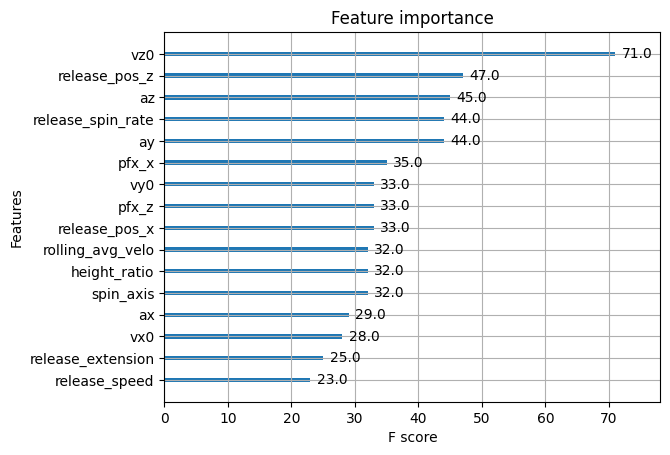

In [13]:
xgb.plot_importance(model)
plt.show()

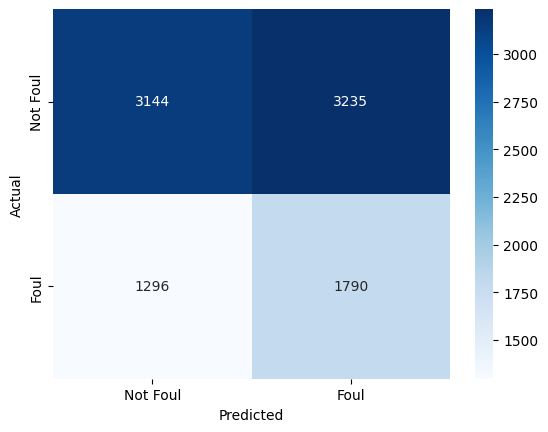

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [15]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [16]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:09:02,182] A new study created in memory with name: no-name-1e5cb9be-7579-450b-9679-74dcf92f0e85


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69022
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68850
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.68871
[11]	eval-logloss:0.68809
[12]	eval-logloss:0.68782
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68765
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68681
[17]	eval-logloss:0.68611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68603
[20]	eval-logloss:0.68574
[21]	eval-logloss:0.68574
[22]	eval-logloss:0.68545
[23]	eval-logloss:0.68524
[24]	eval-logloss:0.68540
[25]	eval-logloss:0.68594
[26]	eval-logloss:0.68599
[27]	eval-logloss:0.68569
[28]	eval-logloss:0.68530
[29]	eval-logloss:0.68538
[30]	eval-logloss:0.68489
[31]	eval-logloss:0.68482
[32]	eval-logloss:0.68450
[33]	eval-logloss:0.68469
[34]	eval-logloss:0.68462
[35]	eval-logloss:0.68438
[36]	eval-logloss:0.68473
[37]	eval-logloss:0.68571
[38]	eval-logloss:0.68539
[39]	eval-logloss:0.68458
[40]	eval-logloss:0.68528
[41]	eval-logloss:0.68546
[42]	eval-logloss:0.68561
[43]	eval-logloss:0.68528
[44]	eval-logloss:0.68554
[45]	eval-logloss:0.68551
[46]	eval-logloss:0.68575
[47]	eval-logloss:0.68620
[48]	eval-logloss:0.68589
[49]	eval-logloss:0.68525
[50]	eval-logloss:0.68584
[51]	eval-logloss:0.68551
[52]	eval-logloss:0.68549
[53]	eval-logloss:0.68529
[54]	eval-logloss:0.68484
[55]	eval-logloss:0.68494
[56]	eval-lo

[I 2023-11-15 17:09:02,718] Trial 0 finished with value: 0.6864999388827019 and parameters: {'max_depth': 4, 'eta': 0.16214924567953298, 'subsample': 0.6347013897408642, 'colsample_bytree': 0.5167462003302288}. Best is trial 0 with value: 0.6864999388827019.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68695


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68572
[12]	eval-logloss:0.68517
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68294
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68191
[21]	eval-logloss:0.68129
[22]	eval-logloss:0.68113
[23]	eval-logloss:0.68098
[24]	eval-logloss:0.68089
[25]	eval-logloss:0.68104
[26]	eval-logloss:0.68091
[27]	eval-logloss:0.68053
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67899
[34]	eval-logloss:0.67896
[35]	eval-logloss:0.67867
[36]	eval-logloss:0.67844
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67813
[39]	eval-logloss:0.67799
[40]	eval-logloss:0.67807
[41]	eval-logloss:0.67793
[42]	eval-logloss:0.67784
[43]	eval-logloss:0.67775
[44]	eval-logloss:0.67774
[45]	eval-logloss:0.67778
[46]	eval-logloss:0.67778
[47]	eval-log

[I 2023-11-15 17:09:03,779] Trial 1 finished with value: 0.6749782639994494 and parameters: {'max_depth': 8, 'eta': 0.06513763975285056, 'subsample': 0.84380332905588, 'colsample_bytree': 0.6902974589147162}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68594
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68669
[15]	eval-logloss:0.68714
[16]	eval-logloss:0.68725
[17]	eval-logloss:0.68707
[18]	eval-logloss:0.68755
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68784
[21]	eval-logloss:0.68827
[22]	eval-logloss:0.68786
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68937
[27]	eval-logloss:0.68951
[28]	eval-logloss:0.68928
[29]	eval-logloss:0.68984
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.69001
[32]	eval-logloss:0.68987
[33]	eval-logloss:0.69008
[34]	eval-logloss:0.69038
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.69071
[37]	eval-logloss:0.69146
[38]	eval-logloss:0.69069
[39]	eval-logloss:0.69027
[40]	eval-logloss:0.69107
[41]	eval-logloss:0.69140
[42]	eval-logloss:

[I 2023-11-15 17:09:05,021] Trial 2 finished with value: 0.6929536885102962 and parameters: {'max_depth': 7, 'eta': 0.2517351474637609, 'subsample': 0.8128519628955378, 'colsample_bytree': 0.769192269147007}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69093
[5]	eval-logloss:0.68991
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68810
[9]	eval-logloss:0.68788


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68743
[12]	eval-logloss:0.68736
[13]	eval-logloss:0.68728
[14]	eval-logloss:0.68725
[15]	eval-logloss:0.68690
[16]	eval-logloss:0.68670
[17]	eval-logloss:0.68617
[18]	eval-logloss:0.68605
[19]	eval-logloss:0.68595
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68575
[22]	eval-logloss:0.68517
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68503
[25]	eval-logloss:0.68566
[26]	eval-logloss:0.68537
[27]	eval-logloss:0.68526
[28]	eval-logloss:0.68519
[29]	eval-logloss:0.68541
[30]	eval-logloss:0.68510
[31]	eval-logloss:0.68501
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68474
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68426
[36]	eval-logloss:0.68424
[37]	eval-logloss:0.68469
[38]	eval-logloss:0.68464
[39]	eval-logloss:0.68415
[40]	eval-logloss:0.68453
[41]	eval-logloss:0.68465
[42]	eval-logloss:0.68441
[43]	eval-logloss:0.68444
[44]	eval-logloss:0.68447
[45]	eval-logloss:0.68459
[46]	eval-logloss:0.68470
[47]	eval-logloss:0.68472
[48]	eval-lo

[I 2023-11-15 17:09:05,769] Trial 3 finished with value: 0.6844715478080209 and parameters: {'max_depth': 3, 'eta': 0.15664124458466247, 'subsample': 0.7919485168242519, 'colsample_bytree': 0.8257853172471331}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68608
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68423


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68367
[15]	eval-logloss:0.68344
[16]	eval-logloss:0.68325
[17]	eval-logloss:0.68249
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68180
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68141
[26]	eval-logloss:0.68102
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68025
[29]	eval-logloss:0.68068
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.68029
[33]	eval-logloss:0.68041
[34]	eval-logloss:0.68058
[35]	eval-logloss:0.68036
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.68020
[38]	eval-logloss:0.68023
[39]	eval-logloss:0.67995
[40]	eval-logloss:0.68008
[41]	eval-logloss:0.68040
[42]	eval-logloss:0.68028
[43]	eval-logloss:0.67975
[44]	eval-logloss:0.68013
[45]	eval-logloss:0.67999
[46]	eval-logl

[I 2023-11-15 17:09:06,823] Trial 4 finished with value: 0.6827945357271934 and parameters: {'max_depth': 6, 'eta': 0.13179500390437993, 'subsample': 0.7047158370276333, 'colsample_bytree': 0.9436186715846047}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68893
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68816


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68751
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68749
[16]	eval-logloss:0.68707
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68653
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68612
[21]	eval-logloss:0.68592
[22]	eval-logloss:0.68570
[23]	eval-logloss:0.68554
[24]	eval-logloss:0.68558
[25]	eval-logloss:0.68575
[26]	eval-logloss:0.68531
[27]	eval-logloss:0.68527
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68536
[30]	eval-logloss:0.68503
[31]	eval-logloss:0.68507
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68491
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68458
[36]	eval-logloss:0.68441
[37]	eval-logloss:0.68474
[38]	eval-logloss:0.68474
[39]	eval-logloss:0.68449
[40]	eval-logloss:0.68476
[41]	eval-logloss:0.68462
[42]	eval-logloss:0.68450
[43]	eval-logloss:0.68446
[44]	eval-logloss:0.68454
[45]	eval-logloss:0.68480
[46]	eval-logloss:0.68486
[47]	eval-logloss:0.68498
[48]	eval-logloss:0.68460
[49]	eval-logloss:0.68451
[50]	eval-lo

[I 2023-11-15 17:09:07,539] Trial 5 finished with value: 0.6839941062056125 and parameters: {'max_depth': 3, 'eta': 0.1513992335804577, 'subsample': 0.8530176399976597, 'colsample_bytree': 0.680094830894979}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.68923
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68673
[9]	eval-logloss:0.68661
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68595
[12]	eval-logloss:0.68625
[13]	eval-logloss:0.68620


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68607
[16]	eval-logloss:0.68570
[17]	eval-logloss:0.68455
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68414
[20]	eval-logloss:0.68350
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68282
[23]	eval-logloss:0.68252
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68396
[26]	eval-logloss:0.68359
[27]	eval-logloss:0.68331
[28]	eval-logloss:0.68320
[29]	eval-logloss:0.68351
[30]	eval-logloss:0.68291
[31]	eval-logloss:0.68323
[32]	eval-logloss:0.68318
[33]	eval-logloss:0.68359
[34]	eval-logloss:0.68351
[35]	eval-logloss:0.68314
[36]	eval-logloss:0.68287
[37]	eval-logloss:0.68360
[38]	eval-logloss:0.68347
[39]	eval-logloss:0.68301
[40]	eval-logloss:0.68403
[41]	eval-logloss:0.68428
[42]	eval-logloss:0.68395
[43]	eval-logloss:0.68351
[44]	eval-logloss:0.68387
[45]	eval-logloss:0.68417
[46]	eval-logloss:0.68432
[47]	eval-logloss:0.68459
[48]	eval-logloss:0.68430
[49]	eval-logloss:0.68361
[50]	eval-logloss:0.68435
[51]	eval-logloss:0.68423
[52]	eval-lo

[I 2023-11-15 17:09:08,111] Trial 6 finished with value: 0.686195859495031 and parameters: {'max_depth': 5, 'eta': 0.1971473471158749, 'subsample': 0.7108073568370401, 'colsample_bytree': 0.6212404313981773}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69075
[7]	eval-logloss:0.68981
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68970
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68836
[13]	eval-logloss:0.68808
[14]	eval-logloss:0.68805
[15]	eval-logloss:0.68777
[16]	eval-logloss:0.68755
[17]	eval-logloss:0.68683
[18]	eval-logloss:0.68668
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68627
[21]	eval-logloss:0.68614
[22]	eval-logloss:0.68575


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68567
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68588
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68569
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68535
[33]	eval-logloss:0.68527
[34]	eval-logloss:0.68530
[35]	eval-logloss:0.68478
[36]	eval-logloss:0.68467
[37]	eval-logloss:0.68501
[38]	eval-logloss:0.68497
[39]	eval-logloss:0.68431
[40]	eval-logloss:0.68451
[41]	eval-logloss:0.68475
[42]	eval-logloss:0.68457
[43]	eval-logloss:0.68437
[44]	eval-logloss:0.68448
[45]	eval-logloss:0.68467
[46]	eval-logloss:0.68472
[47]	eval-logloss:0.68495
[48]	eval-logloss:0.68445
[49]	eval-logloss:0.68414
[50]	eval-logloss:0.68457
[51]	eval-logloss:0.68455
[52]	eval-logloss:0.68419
[53]	eval-logloss:0.68395
[54]	eval-logloss:0.68353
[55]	eval-logloss:0.68333
[56]	eval-logloss:0.68330
[57]	eval-logloss:0.68334
[58]	eval-logloss:0.68349
[59]	eval-logloss:0.68342
[60]	eval-logloss:0.68341
[61]	eval-lo

[I 2023-11-15 17:09:08,757] Trial 7 finished with value: 0.6840929857734112 and parameters: {'max_depth': 3, 'eta': 0.15096725191186783, 'subsample': 0.766975527076208, 'colsample_bytree': 0.5674437939669357}. Best is trial 1 with value: 0.6749782639994494.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68281
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68257
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68142
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68143
[24]	eval-logloss:0.68148
[25]	eval-logloss:0.68198
[26]	eval-logloss:0.68234
[27]	eval-logloss:0.68217
[28]	eval-logloss:0.68168
[29]	eval-logloss:0.68165
[30]	eval-logloss:0.68157
[31]	eval-logloss:0.68179
[32]	eval-logloss:0.68148
[33]	eval-logloss:0.68119
[34]	eval-logloss:0.68131
[35]	eval-logloss:0.68120
[36]	eval-logloss:0.68094
[37]	eval-logloss:0.68138
[38]	eval-logloss:0.68

[I 2023-11-15 17:09:09,871] Trial 8 finished with value: 0.684199491330626 and parameters: {'max_depth': 8, 'eta': 0.14636964335636743, 'subsample': 0.6346835238043159, 'colsample_bytree': 0.636169759429781}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69293
[3]	eval-logloss:0.69278
[4]	eval-logloss:0.69274
[5]	eval-logloss:0.69264
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69186
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69154
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69092
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69058
[16]	eval-logloss:0.69038
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.69001
[19]	eval-logloss:0.68973
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68938
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68887
[26]	eval-logloss:0.68867
[27]	eval-logloss:0.68856
[28]	eval-logloss:0.68843
[29]	eval-logloss:0.68843
[30]	eval-logloss:0.68831
[31]	eval-logloss:0.68821
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68800
[34]	eval-logloss:0.68790
[35]	eval-logloss:0.68776
[36]	eval-logloss:0.68760
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68740
[39]	eval-logloss:0.68719
[40]	eval-logloss:0.68718
[41]	eval-logloss:0.68717
[42]	eval-logloss:0.68709
[43]	eval-logloss:0.68705
[44]	eval-logloss:0.68697
[45]	eval-logloss:0.68699
[46]	eval-logloss:0.68700
[47]	eval-logloss:0.68693
[48]	eval-logloss:0.68689
[49]	eval-logloss:0.68694
[50]	eval-logloss:0.68689
[51]	eval-logloss:0.68684
[52]	eval-logloss:0.68670
[53]	eval-logloss:0.68665
[54]	eval-logloss:0.68656
[55]	eval-logloss:0.68648
[56]	eval-logloss:0.68643
[57]	eval-logloss:0.68635
[58]	eval-logloss:0.68630
[59]	eval-logloss:0.68626
[60]	eval-logloss:0.68623
[61]	eval-logloss:0.68622
[62]	eval-lo

[I 2023-11-15 17:09:10,508] Trial 9 finished with value: 0.6850067619405695 and parameters: {'max_depth': 3, 'eta': 0.04444084418797295, 'subsample': 0.865974419504119, 'colsample_bytree': 0.6204901558172108}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.69095
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.68991
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68953
[11]	eval-logloss:0.68913
[12]	eval-logloss:0.68869
[13]	eval-logloss:0.68822
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68781
[16]	eval-logloss:0.68752
[17]	eval-logloss:0.68725
[18]	eval-logloss:0.68708
[19]	eval-logloss:0.68666
[20]	eval-logloss:0.68631
[21]	eval-logloss:0.68601
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68536
[24]	eval-logloss:0.68521
[25]	eval-logloss:0.68503
[26]	eval-logloss:0.68478
[27]	eval-logloss:0.68462
[28]	eval-logloss:0.68433
[29]	eval-logloss:0.68418
[30]	eval-logloss:0.68393
[31]	eval-logloss:0.68366
[32]	eval-logloss:0.68349
[33]	eval-logloss:0.68326
[34]	eval-logloss:0.68297
[35]	eval-logloss:0.68266
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68225
[38]	eval-logloss:0.68198
[39]	eval-logloss:0.68175
[40]	eval-logloss:0.68166
[41]	eval-logloss:0.68161
[42]	eval-logloss:0.68141
[43]	eval-logloss:0.68127
[44]	eval-loglos

[I 2023-11-15 17:09:12,280] Trial 10 finished with value: 0.6754602008764847 and parameters: {'max_depth': 9, 'eta': 0.019932008348188306, 'subsample': 0.8914308585015038, 'colsample_bytree': 0.7208599347787583}. Best is trial 1 with value: 0.6749782639994494.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68971
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68912
[12]	eval-logloss:0.68870
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68808
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68737
[17]	eval-logloss:0.68702
[18]	eval-logloss:0.68682
[19]	eval-logloss:0.68637
[20]	eval-logloss:0.68592
[21]	eval-logloss:0.68548
[22]	eval-logloss:0.68520
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68418
[27]	eval-logloss:0.68384
[28]	eval-logloss:0.68362
[29]	eval-logloss:0.68355
[30]	eval-logloss:0.68331
[31]	eval-logloss:0.68306
[32]	eval-logloss:0.68295
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68243
[35]	eval-logloss:0.68223
[36]	eval-logloss:0.68203
[37]	eval-logloss:0.68179
[38]	eval-logloss:0.68149
[39]	eval-logloss:0.68126
[40]	eval-logloss:0.68100
[41]	eval-logloss:0.68089
[42]	eval-logloss:

[I 2023-11-15 17:09:14,024] Trial 11 finished with value: 0.6749073219821169 and parameters: {'max_depth': 9, 'eta': 0.021272134301042685, 'subsample': 0.899593422309332, 'colsample_bytree': 0.7301475839415942}. Best is trial 11 with value: 0.6749073219821169.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68235
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68055
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67867
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67854
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67822
[31]	eval-logloss:0.67839
[32]	eval-logloss:0.67826
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67689
[39]	eval-logloss:0.6

[I 2023-11-15 17:09:15,995] Trial 12 finished with value: 0.6725415458791018 and parameters: {'max_depth': 9, 'eta': 0.07233908512103877, 'subsample': 0.8999436909775758, 'colsample_bytree': 0.7864233297354503}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69068
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68466
[9]	eval-logloss:0.68446
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.68004
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67933
[22]	eval-logloss:0.67884
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67837
[26]	eval-logloss:0.67799
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67789
[30]	eval-logloss:0.67781
[31]	eval-logloss:0.67782
[32]	eval-logloss:0.67801
[33]	eval-logloss:0.67782
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67754
[38]	eval-logloss:0.67741
[39]	eval-logloss:0.6

[I 2023-11-15 17:09:17,750] Trial 13 finished with value: 0.6733503735488986 and parameters: {'max_depth': 9, 'eta': 0.07764806415671406, 'subsample': 0.8987284032792955, 'colsample_bytree': 0.8110144274303885}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.69013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68484
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67949
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67929
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67881
[29]	eval-logloss:0.67902
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67880
[35]	eval-logloss:0.67864
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67868
[38]	eval-logloss:0.67878
[39]	eval-logloss:0.67842
[40]	eval-logloss:0.67830
[41]	eval-logloss:0

[I 2023-11-15 17:09:18,908] Trial 14 finished with value: 0.6774450498295849 and parameters: {'max_depth': 8, 'eta': 0.08772191101553017, 'subsample': 0.8259133680237688, 'colsample_bytree': 0.8359001307325509}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68535
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68368
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68317
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68210
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68197
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68133
[25]	eval-logloss:0.68127
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.68117
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68101
[30]	eval-logloss:0.68085
[31]	eval-logloss:0.68062
[32]	eval-logloss:0.68047
[33]	eval-logloss:0.68030
[34]	eval-logloss:0.68001
[35]	eval-logloss:0.67998
[36]	eval-logloss:0.67986
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67950
[39]	eval-logloss:0.67947
[40]	eval-logloss:0.

[I 2023-11-15 17:09:19,862] Trial 15 finished with value: 0.6772121450212734 and parameters: {'max_depth': 7, 'eta': 0.08987366509928174, 'subsample': 0.8946538274926071, 'colsample_bytree': 0.894882870960503}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69012


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67907
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67819
[26]	eval-logloss:0.67785
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67737
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67728
[34]	eval-logloss:0.67718
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67630
[38]	eval-logloss:0.67601
[39]	eval-logloss:0.67597
[40]	eval-logloss:0.67616
[41]	eval-logloss:0

[I 2023-11-15 17:09:21,144] Trial 16 finished with value: 0.6760295714676875 and parameters: {'max_depth': 9, 'eta': 0.09502595452399129, 'subsample': 0.8448033722788552, 'colsample_bytree': 0.7960777142797176}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68811
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68767


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68637
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68568
[16]	eval-logloss:0.68522
[17]	eval-logloss:0.68475
[18]	eval-logloss:0.68463
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68385
[22]	eval-logloss:0.68355
[23]	eval-logloss:0.68315
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68196
[28]	eval-logloss:0.68159
[29]	eval-logloss:0.68159
[30]	eval-logloss:0.68133
[31]	eval-logloss:0.68131
[32]	eval-logloss:0.68131
[33]	eval-logloss:0.68115
[34]	eval-logloss:0.68100
[35]	eval-logloss:0.68083
[36]	eval-logloss:0.68060
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68021
[39]	eval-logloss:0.67999
[40]	eval-logloss:0.67995
[41]	eval-logloss:0.67985
[42]	eval-logloss:0.67970
[43]	eval-logloss:0.67973
[44]	eval-logloss:0.67958
[45]	eval-logloss:0.67964
[46]	eval-logloss:0.67963
[47]	eval-logloss:0.67956
[48]	eval-lo

[I 2023-11-15 17:09:22,125] Trial 17 finished with value: 0.6779331601848112 and parameters: {'max_depth': 7, 'eta': 0.0564572431462963, 'subsample': 0.8738371780480074, 'colsample_bytree': 0.8590115526062394}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68593
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68578
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68440


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68445
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68370
[17]	eval-logloss:0.68342
[18]	eval-logloss:0.68332
[19]	eval-logloss:0.68316
[20]	eval-logloss:0.68289
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68252
[24]	eval-logloss:0.68227
[25]	eval-logloss:0.68233
[26]	eval-logloss:0.68204
[27]	eval-logloss:0.68191
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68205
[30]	eval-logloss:0.68200
[31]	eval-logloss:0.68204
[32]	eval-logloss:0.68174
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68158
[35]	eval-logloss:0.68140
[36]	eval-logloss:0.68131
[37]	eval-logloss:0.68157
[38]	eval-logloss:0.68128
[39]	eval-logloss:0.68091
[40]	eval-logloss:0.68103
[41]	eval-logloss:0.68087
[42]	eval-logloss:0.68077
[43]	eval-logloss:0.68072
[44]	eval-logloss:0.68082
[45]	eval-logloss:0.68099
[46]	eval-logloss:0.68099
[47]	eval-logloss:0.68125
[48]	eval-logloss:0.68107
[49]	eval-logloss:0.68102
[50]	eval-logloss:0.68099
[51]	eval-logloss:0.68063
[52]	eval-lo

[I 2023-11-15 17:09:22,805] Trial 18 finished with value: 0.680856136271254 and parameters: {'max_depth': 6, 'eta': 0.10741302241271461, 'subsample': 0.8160685707197867, 'colsample_bytree': 0.7717771160165079}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69132
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69067
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69019
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68967
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68918
[17]	eval-logloss:0.68889
[18]	eval-logloss:0.68877
[19]	eval-logloss:0.68855
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68816
[22]	eval-logloss:0.68798
[23]	eval-logloss:0.68773
[24]	eval-logloss:0.68749
[25]	eval-logloss:0.68730
[26]	eval-logloss:0.68705
[27]	eval-logloss:0.68681
[28]	eval-logloss:0.68660
[29]	eval-logloss:0.68654
[30]	eval-logloss:0.68634
[31]	eval-logloss:0.68611
[32]	eval-logloss:0.68593
[33]	eval-logloss:0.68574
[34]	eval-logloss:0.68557
[35]	eval-logloss:0.68542
[36]	eval-logloss:0.68527
[37]	eval-logloss:0.68507
[38]	eval-logloss:0.68483
[39]	eval-logloss:0.68464
[40]	eval-logloss:0.68447
[41]	eval-logloss:0.68436
[42]	eval-logloss:0.68420
[43]	eval-logloss

[I 2023-11-15 17:09:24,188] Trial 19 finished with value: 0.6783015331426351 and parameters: {'max_depth': 9, 'eta': 0.011281399384357252, 'subsample': 0.8536644472482029, 'colsample_bytree': 0.9503375887388799}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68618


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68140
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68061
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.68010
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.67937
[27]	eval-logloss:0.67921
[28]	eval-logloss:0.67890
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67902
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67854
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67834
[39]	eval-logloss:0.67821
[40]	eval-logloss:0.67829
[41]	eval-logloss:0.67828
[42]	eval-logloss:0.67828
[43]	eval-logloss:0.67808
[44]	eval-logloss:0.67794
[45]	eval-loglo

[I 2023-11-15 17:09:25,102] Trial 20 finished with value: 0.6754758063239171 and parameters: {'max_depth': 8, 'eta': 0.05906637758975818, 'subsample': 0.7877852833392103, 'colsample_bytree': 0.9880377754093193}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68834
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68778
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68564
[15]	eval-logloss:0.68543
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68440
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68239
[24]	eval-logloss:0.68212
[25]	eval-logloss:0.68204
[26]	eval-logloss:0.68176
[27]	eval-logloss:0.68142
[28]	eval-logloss:0.68109
[29]	eval-logloss:0.68106
[30]	eval-logloss:0.68063
[31]	eval-logloss:0.68044
[32]	eval-logloss:0.68036
[33]	eval-logloss:0.68003
[34]	eval-logloss:0.67984
[35]	eval-logloss:0.67960
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67929
[38]	eval-logloss:0.67912
[39]	eval-logloss:0.67881
[40]	eval-logloss:0.67861
[41]	eval-logloss:0.67860
[42]	eval-logloss:0.67837
[43]	eval-logloss

[I 2023-11-15 17:09:26,251] Trial 21 finished with value: 0.6744349063991034 and parameters: {'max_depth': 9, 'eta': 0.033992974430607774, 'subsample': 0.8882301615428435, 'colsample_bytree': 0.7535151047705492}. Best is trial 12 with value: 0.6725415458791018.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68878
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68687
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68573
[12]	eval-logloss:0.68504
[13]	eval-logloss:0.68439
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68385
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68182
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68097
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68039
[26]	eval-logloss:0.68000
[27]	eval-logloss:0.67950
[28]	eval-logloss:0.67901
[29]	eval-logloss:0.67894
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67841
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67700
[39]	eval-logloss:0.67692
[40]	eval-logloss:0.67659
[41]	eval-logloss:0.67648
[42]	eval-logloss:0.67626
[43]	eval-logloss:0.67620
[44]	eval-loglos

[I 2023-11-15 17:09:27,443] Trial 22 finished with value: 0.6725279195155944 and parameters: {'max_depth': 9, 'eta': 0.04127843669255758, 'subsample': 0.8739138340915819, 'colsample_bytree': 0.8004051385766402}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68930


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68839
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68633
[11]	eval-logloss:0.68530
[12]	eval-logloss:0.68479
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68383
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68216
[19]	eval-logloss:0.68175
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68089
[22]	eval-logloss:0.68079
[23]	eval-logloss:0.68055
[24]	eval-logloss:0.68023
[25]	eval-logloss:0.68014
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67908
[29]	eval-logloss:0.67911
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67833
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67796
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67739
[39]	eval-logloss:0.67731
[40]	eval-logloss:0.67730
[41]	eval-logloss:0.67721
[42]	eval-logloss:0.67704
[43]	eval-logloss:0.67706
[44]	eval-loglos

[I 2023-11-15 17:09:28,456] Trial 23 finished with value: 0.6746518670200593 and parameters: {'max_depth': 8, 'eta': 0.06333317827812956, 'subsample': 0.8726035134749104, 'colsample_bytree': 0.7991923082021392}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68548
[12]	eval-logloss:0.68471
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68403
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68291
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68233
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68148
[22]	eval-logloss:0.68121
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68030
[26]	eval-logloss:0.68011
[27]	eval-logloss:0.67977
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67881
[35]	eval-logloss:0.67863
[36]	eval-logloss:0.67856
[37]	eval-logloss:0.67851
[38]	eval-logloss:0.67825
[39]	eval-logloss:0.6

[I 2023-11-15 17:09:29,776] Trial 24 finished with value: 0.6743230764839374 and parameters: {'max_depth': 9, 'eta': 0.04063292278591073, 'subsample': 0.8721015612615968, 'colsample_bytree': 0.8749224042089769}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68527
[12]	eval-logloss:0.68493
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68437
[15]	eval-logloss:0.68423
[16]	eval-logloss:0.68373
[17]	eval-logloss:0.68335
[18]	eval-logloss:0.68326
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68271
[21]	eval-logloss:0.68235
[22]	eval-logloss:0.68225
[23]	eval-logloss:0.68196
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68134
[27]	eval-logloss:0.68101
[28]	eval-logloss:0.68094
[29]	eval-logloss:0.68082
[30]	eval-logloss:0.68068
[31]	eval-logloss:0.68048
[32]	eval-logloss:0.68066
[33]	eval-logloss:0.68049
[34]	eval-logloss:0.68030
[35]	eval-logloss:0.68019
[36]	eval-logloss:0.68001
[37]	eval-logloss:0.68006
[38]	eval-logloss:0.68008
[39]	eval-logloss:0.6

[I 2023-11-15 17:09:30,609] Trial 25 finished with value: 0.6777989010761182 and parameters: {'max_depth': 7, 'eta': 0.07883504973854777, 'subsample': 0.8984818561177993, 'colsample_bytree': 0.8163326148236009}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68530


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68270
[13]	eval-logloss:0.68209
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.68000
[22]	eval-logloss:0.67982
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67933
[25]	eval-logloss:0.67970
[26]	eval-logloss:0.67969
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67929
[31]	eval-logloss:0.67948
[32]	eval-logloss:0.67947
[33]	eval-logloss:0.67919
[34]	eval-logloss:0.67916
[35]	eval-logloss:0.67889
[36]	eval-logloss:0.67888
[37]	eval-logloss:0.67895
[38]	eval-logloss:0.67893
[39]	eval-logloss:0.67868
[40]	eval-logloss:0.67886
[41]	eval-logloss:0.67874
[42]	eval-logloss:0.67860
[43]	eval-logloss:0.67852
[44]	eval-logloss:0.67849
[45]	eval-logloss:0.67857
[46]	eval-logl

[I 2023-11-15 17:09:31,482] Trial 26 finished with value: 0.6787299198229698 and parameters: {'max_depth': 8, 'eta': 0.11012379393780024, 'subsample': 0.8338345579434141, 'colsample_bytree': 0.7829182461053343}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.69041
[7]	eval-logloss:0.68978
[8]	eval-logloss:0.68934
[9]	eval-logloss:0.68923
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68829
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.68742
[17]	eval-logloss:0.68715
[18]	eval-logloss:0.68699
[19]	eval-logloss:0.68665
[20]	eval-logloss:0.68654
[21]	eval-logloss:0.68635
[22]	eval-logloss:0.68606
[23]	eval-logloss:0.68576
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68530
[26]	eval-logloss:0.68502
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68442
[30]	eval-logloss:0.68423
[31]	eval-logloss:0.68417
[32]	eval-logloss:0.68416
[33]	eval-logloss:0.68401
[34]	eval-logloss:0.68393
[35]	eval-logloss:0.68376
[36]	eval-logloss:0.68366
[37]	eval-logloss:0.68368
[38]	eval-logloss:0.68360
[39]	eval-logloss:0.68350
[40]	eval-logloss:0.68343
[41]	eval-logloss:0.68339
[42]	eval-logloss:0.68321
[43]	eval-logloss:0.68318
[44]	eval-logloss:0.68312
[45]	eval-logloss:0.68316
[46]	eval-logloss:0.68314
[47]	eval-logloss:0.68317
[48]	eval-logloss:0.68303
[49]	eval-logloss:0.68300
[50]	eval-logloss:0.68298
[51]	eval-logloss:0.68280
[52]	eval-logloss:0.68271
[53]	eval-logloss:0.68262
[54]	eval-lo

[I 2023-11-15 17:09:32,217] Trial 27 finished with value: 0.6805298324262161 and parameters: {'max_depth': 6, 'eta': 0.03885519626242892, 'subsample': 0.8636881169498268, 'colsample_bytree': 0.8287331786468242}. Best is trial 22 with value: 0.6725279195155944.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68752


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.68020
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67904
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67838
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67625
[34]	eval-logloss:0.67607
[35]	eval-logloss:0.67571
[36]	eval-logloss:0.67558
[37]	eval-logloss:0.67556
[38]	eval-logloss:0.67534
[39]	eval-logloss:0.67502
[40]	eval-logloss:0.67516
[41]	eval-logloss:0.67506
[42]	eval-logloss:0.67476
[43]	eval-logloss

[I 2023-11-15 17:09:33,333] Trial 28 finished with value: 0.671874052477871 and parameters: {'max_depth': 9, 'eta': 0.076662314778845, 'subsample': 0.8759031690919641, 'colsample_bytree': 0.9044228570072013}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68809
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68687
[12]	eval-logloss:0.68670
[13]	eval-logloss:0.68661
[14]	eval-logloss:0.68675
[15]	eval-logloss:0.68652
[16]	eval-logloss:0.68626
[17]	eval-logloss:0.68586
[18]	eval-logloss:0.68575


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[19]	eval-logloss:0.68557
[20]	eval-logloss:0.68525
[21]	eval-logloss:0.68516
[22]	eval-logloss:0.68484
[23]	eval-logloss:0.68477
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68496
[26]	eval-logloss:0.68473
[27]	eval-logloss:0.68430
[28]	eval-logloss:0.68429
[29]	eval-logloss:0.68435
[30]	eval-logloss:0.68424
[31]	eval-logloss:0.68430
[32]	eval-logloss:0.68436
[33]	eval-logloss:0.68417
[34]	eval-logloss:0.68417
[35]	eval-logloss:0.68393
[36]	eval-logloss:0.68381
[37]	eval-logloss:0.68387
[38]	eval-logloss:0.68367
[39]	eval-logloss:0.68337
[40]	eval-logloss:0.68355
[41]	eval-logloss:0.68342
[42]	eval-logloss:0.68322
[43]	eval-logloss:0.68313
[44]	eval-logloss:0.68325
[45]	eval-logloss:0.68340
[46]	eval-logloss:0.68356
[47]	eval-logloss:0.68370
[48]	eval-logloss:0.68344
[49]	eval-logloss:0.68350
[50]	eval-logloss:0.68344
[51]	eval-logloss:0.68312
[52]	eval-logloss:0.68292
[53]	eval-logloss:0.68281
[54]	eval-logloss:0.68253
[55]	eval-logloss:0.68254
[56]	eval-logloss:0.68243
[57]	eval-lo

[I 2023-11-15 17:09:33,865] Trial 29 finished with value: 0.6822060486282722 and parameters: {'max_depth': 4, 'eta': 0.11476863211039325, 'subsample': 0.8337159120144463, 'colsample_bytree': 0.8957709560407222}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69202


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69141
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69091
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69054
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69022
[17]	eval-logloss:0.69001
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68918
[23]	eval-logloss:0.68901
[24]	eval-logloss:0.68881
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68841
[27]	eval-logloss:0.68820
[28]	eval-logloss:0.68800
[29]	eval-logloss:0.68795
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68752
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68715
[34]	eval-logloss:0.68697
[35]	eval-logloss:0.68681
[36]	eval-logloss:0.68666
[37]	eval-logloss:0.68653
[38]	eval-logloss:0.68637
[39]	eval-logloss:0.68619
[40]	eval-logloss:0.68610
[41]	eval-logloss:0.68598
[42]	eval-logloss:0.68587
[43]	eval-logloss:0.68577
[44]	eval-logloss:0.68567
[45]	eval-loglo

[I 2023-11-15 17:09:35,164] Trial 30 finished with value: 0.6807192738934482 and parameters: {'max_depth': 8, 'eta': 0.011454941185450224, 'subsample': 0.8720241385093284, 'colsample_bytree': 0.8593846372893571}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68458
[9]	eval-logloss:0.68420
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67988
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67921
[21]	eval-logloss:0.67889
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67774
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67767
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67723
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67668
[36]	eval-logloss:0.67667
[37]	eval-logloss:0.67657
[38]	eval-logloss:0.67655
[39]	eval-logloss:0.67628
[40]	eval-logloss:0.67616
[41]	eval-logloss:0.67587
[42]	eval-logloss:0.67577
[43]	eval-logloss:0.67581
[44]	eval-loglos

[I 2023-11-15 17:09:36,249] Trial 31 finished with value: 0.6729080127201039 and parameters: {'max_depth': 9, 'eta': 0.07397470072089993, 'subsample': 0.8799295221305139, 'colsample_bytree': 0.7963698307202702}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68907


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68454
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.67894
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67673
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67645
[34]	eval-logloss:0.67629
[35]	eval-logloss:0.67603
[36]	eval-logloss:0.67589
[37]	eval-logloss:0.67585
[38]	eval-logloss:0.67558
[39]	eval-logloss:0.67533
[40]	eval-logloss:0.67515
[41]	eval-logloss:0.67493
[42]	eval-logloss:0.67493
[43]	eval-logloss

[I 2023-11-15 17:09:37,435] Trial 32 finished with value: 0.67232318028852 and parameters: {'max_depth': 9, 'eta': 0.07251312471520709, 'subsample': 0.8576754121173688, 'colsample_bytree': 0.7384632522953999}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68740
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68546
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68492
[16]	eval-logloss:0.68425
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68340
[19]	eval-logloss:0.68290
[20]	eval-logloss:0.68270
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68214
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68165
[25]	eval-logloss:0.68151
[26]	eval-logloss:0.68127
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68064
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68025
[32]	eval-logloss:0.68003
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67912
[38]	eval-logloss:0.67893
[39]	eval-logloss:0.67869
[40]	eval-logloss:0.67859
[41]	eval-logloss:0.67856
[42]	eval-logloss:0.67835
[43]	eval-logloss:0.67817
[44]	eval-logloss:0.67811
[45]	eval-logloss:0.67826
[46]	eval-logl

[I 2023-11-15 17:09:38,347] Trial 33 finished with value: 0.6753632283237047 and parameters: {'max_depth': 8, 'eta': 0.04652019814147404, 'subsample': 0.8475728332811884, 'colsample_bytree': 0.7468851290173302}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68940


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68154
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67741
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67650
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67635
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67606
[33]	eval-logloss:0.67568
[34]	eval-logloss:0.67572
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67515
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67482
[40]	eval-logloss:0.67487
[41]	eval-logloss:0.67480
[42]	eval-logloss:

[I 2023-11-15 17:09:39,436] Trial 34 finished with value: 0.672826262498074 and parameters: {'max_depth': 9, 'eta': 0.07004341199030713, 'subsample': 0.8542330971675832, 'colsample_bytree': 0.709490049252746}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69155
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.68966
[7]	eval-logloss:0.68875


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68765
[11]	eval-logloss:0.68681
[12]	eval-logloss:0.68625
[13]	eval-logloss:0.68579
[14]	eval-logloss:0.68570
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68446
[19]	eval-logloss:0.68406
[20]	eval-logloss:0.68388
[21]	eval-logloss:0.68358
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68273
[24]	eval-logloss:0.68250
[25]	eval-logloss:0.68251
[26]	eval-logloss:0.68224
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68185
[29]	eval-logloss:0.68185
[30]	eval-logloss:0.68158
[31]	eval-logloss:0.68142
[32]	eval-logloss:0.68120
[33]	eval-logloss:0.68108
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68089
[37]	eval-logloss:0.68079
[38]	eval-logloss:0.68059
[39]	eval-logloss:0.68040
[40]	eval-logloss:0.68032
[41]	eval-logloss:0.68020
[42]	eval-logloss:0.67991
[43]	eval-logloss:0.67983
[44]	eval-logloss:0.67975
[45]	eval-logloss:0.67974
[46]	eval-logl

[I 2023-11-15 17:09:40,407] Trial 35 finished with value: 0.676956958793441 and parameters: {'max_depth': 7, 'eta': 0.05661816741709694, 'subsample': 0.8020022724947224, 'colsample_bytree': 0.7714192819440503}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68871
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68484


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68017
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67938
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67836
[29]	eval-logloss:0.67833
[30]	eval-logloss:0.67843
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67886
[33]	eval-logloss:0.67874
[34]	eval-logloss:0.67864
[35]	eval-logloss:0.67857
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67842
[38]	eval-logloss:0.67835
[39]	eval-logloss:0.67811
[40]	eval-logloss:0.67823
[41]	eval-logloss:0.67798
[42]	eval-logloss:0.67765
[43]	eval-logloss:0.67785
[44]	eval-logloss:0.67787
[45]	eval-logloss:0.67820
[46]	eval-logl

[I 2023-11-15 17:09:41,284] Trial 36 finished with value: 0.6793808732721024 and parameters: {'max_depth': 8, 'eta': 0.12139018228495094, 'subsample': 0.8286679639798429, 'colsample_bytree': 0.7530988941485882}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68681


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68213
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67860
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67773
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67697
[24]	eval-logloss:0.67701
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67676
[27]	eval-logloss:0.67650
[28]	eval-logloss:0.67636
[29]	eval-logloss:0.67629
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67501
[37]	eval-logloss:0.67495
[38]	eval-logloss:0.67496
[39]	eval-logloss:0.67518
[40]	eval-logloss:0.67500
[41]	eval-logloss:0.67495
[42]	eval-logloss:0.67495
[43]	eval-logloss:0.67499
[44]	eval-loglos

[I 2023-11-15 17:09:42,405] Trial 37 finished with value: 0.6743298527231069 and parameters: {'max_depth': 9, 'eta': 0.09904126440665992, 'subsample': 0.8800501058278402, 'colsample_bytree': 0.690650805580405}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68621
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68531
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68521
[15]	eval-logloss:0.68494
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68383
[20]	eval-logloss:0.68362


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68311
[23]	eval-logloss:0.68306
[24]	eval-logloss:0.68300
[25]	eval-logloss:0.68305
[26]	eval-logloss:0.68268
[27]	eval-logloss:0.68251
[28]	eval-logloss:0.68261
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68260
[31]	eval-logloss:0.68259
[32]	eval-logloss:0.68255
[33]	eval-logloss:0.68237
[34]	eval-logloss:0.68218
[35]	eval-logloss:0.68194
[36]	eval-logloss:0.68203
[37]	eval-logloss:0.68185
[38]	eval-logloss:0.68186
[39]	eval-logloss:0.68170
[40]	eval-logloss:0.68179
[41]	eval-logloss:0.68181
[42]	eval-logloss:0.68201
[43]	eval-logloss:0.68220
[44]	eval-logloss:0.68207
[45]	eval-logloss:0.68228
[46]	eval-logloss:0.68222
[47]	eval-logloss:0.68225
[48]	eval-logloss:0.68193
[49]	eval-logloss:0.68202
[50]	eval-logloss:0.68199
[51]	eval-logloss:0.68159
[52]	eval-logloss:0.68160
[53]	eval-logloss:0.68143
[54]	eval-logloss:0.68130
[55]	eval-logloss:0.68124
[56]	eval-logloss:0.68108
[57]	eval-logloss:0.68115
[58]	eval-logloss:0.68119
[59]	eval-lo

[I 2023-11-15 17:09:42,960] Trial 38 finished with value: 0.6809345025195308 and parameters: {'max_depth': 5, 'eta': 0.12556414197199436, 'subsample': 0.854992969515408, 'colsample_bytree': 0.8457274080794079}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68411


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68120
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.68012
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67841
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67837
[32]	eval-logloss:0.67839
[33]	eval-logloss:0.67823
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67799
[36]	eval-logloss:0.67799
[37]	eval-logloss:0.67785
[38]	eval-logloss:0.67774
[39]	eval-logloss:0.67763
[40]	eval-logloss:0.67783
[41]	eval-logloss:0.67772
[42]	eval-logloss:0.67746
[43]	eval-logloss:0.67722
[44]	eval-logloss:0.67714
[45]	eval-logloss:0.67715
[46]	eval-logloss:0.67729
[47]	eval-logloss:0.67724
[48]	eval-lo

[I 2023-11-15 17:09:43,856] Trial 39 finished with value: 0.6751515253164362 and parameters: {'max_depth': 8, 'eta': 0.08471342193806168, 'subsample': 0.812377226385764, 'colsample_bytree': 0.9031691938981667}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68734


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68347
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68158
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68133
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.67995
[22]	eval-logloss:0.68012
[23]	eval-logloss:0.68007
[24]	eval-logloss:0.68026
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68044
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68036
[29]	eval-logloss:0.68036
[30]	eval-logloss:0.68023
[31]	eval-logloss:0.68003
[32]	eval-logloss:0.68026
[33]	eval-logloss:0.68006
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67987
[36]	eval-logloss:0.68018
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.67983
[39]	eval-logloss:0.67998
[40]	eval-logloss:0.68017
[41]	eval-logloss:0.68021
[42]	eval-logloss:

[I 2023-11-15 17:09:45,005] Trial 40 finished with value: 0.6851467317221099 and parameters: {'max_depth': 9, 'eta': 0.1345152070858971, 'subsample': 0.8565758706458706, 'colsample_bytree': 0.8186577252141221}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69030


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68326
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68122
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67871
[25]	eval-logloss:0.67869
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67795
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67736
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67666
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67612
[35]	eval-logloss:0.67587
[36]	eval-logloss:0.67565
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67511
[39]	eval-logloss:0.67489
[40]	eval-logloss:0.67494
[41]	eval-logloss:0

[I 2023-11-15 17:09:46,209] Trial 41 finished with value: 0.6724472019326119 and parameters: {'max_depth': 9, 'eta': 0.0715222125577002, 'subsample': 0.840016735770881, 'colsample_bytree': 0.7102927756326182}. Best is trial 28 with value: 0.671874052477871.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68636
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68152
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68039
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67945
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67726
[29]	eval-logloss:0.67719
[30]	eval-logloss:0.67696
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67595
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67505
[39]	eval-logloss:0.67471
[40]	eval-logloss:0.67449
[41]	eval-logloss:0.67456
[42]	eval-logloss:

[I 2023-11-15 17:09:47,377] Trial 42 finished with value: 0.6706552509399122 and parameters: {'max_depth': 9, 'eta': 0.06762725846329333, 'subsample': 0.8835605407403252, 'colsample_bytree': 0.6677293371015169}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.69030
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68868
[11]	eval-logloss:0.68801
[12]	eval-logloss:0.68757
[13]	eval-logloss:0.68697
[14]	eval-logloss:0.68669
[15]	eval-logloss:0.68654
[16]	eval-logloss:0.68603
[17]	eval-logloss:0.68555
[18]	eval-logloss:0.68530
[19]	eval-logloss:0.68503
[20]	eval-logloss:0.68464
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68330
[24]	eval-logloss:0.68325
[25]	eval-logloss:0.68299
[26]	eval-logloss:0.68254
[27]	eval-logloss:0.68237
[28]	eval-logloss:0.68210
[29]	eval-logloss:0.68199
[30]	eval-logloss:0.68174
[31]	eval-logloss:0.68139
[32]	eval-logloss:0.68113
[33]	eval-logloss:0.68068
[34]	eval-logloss:0.68032
[35]	eval-logloss:0.68001
[36]	eval-logloss:0.67971
[37]	eval-logloss:0.67945
[38]	eval-logloss:0.67916
[39]	eval-logloss:0.67892
[40]	eval-logloss:0.67875
[41]	eval-logloss:0.67862
[42]	eval-logloss:0.67840
[43]	eval-logloss:0.67826
[44]	eval-loglos

[I 2023-11-15 17:09:48,547] Trial 43 finished with value: 0.6739544152787073 and parameters: {'max_depth': 9, 'eta': 0.030899286297611503, 'subsample': 0.8374660027475895, 'colsample_bytree': 0.6636143947374943}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68921


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68822
[8]	eval-logloss:0.68762
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68617
[13]	eval-logloss:0.68563
[14]	eval-logloss:0.68549
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68429
[19]	eval-logloss:0.68391
[20]	eval-logloss:0.68344
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68250
[23]	eval-logloss:0.68202
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68168
[26]	eval-logloss:0.68135
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68097
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68064
[31]	eval-logloss:0.68057
[32]	eval-logloss:0.68034
[33]	eval-logloss:0.68017
[34]	eval-logloss:0.68002
[35]	eval-logloss:0.67997
[36]	eval-logloss:0.67970
[37]	eval-logloss:0.67959
[38]	eval-logloss:0.67929
[39]	eval-logloss:0.67895
[40]	eval-logloss:0.67873
[41]	eval-logloss:0.67865
[42]	eval-logloss:0.67846
[43]	eval-logloss:0.67849
[44]	eval-logloss:0.67845
[45]	eval-loglo

[I 2023-11-15 17:09:49,508] Trial 44 finished with value: 0.6748540483245742 and parameters: {'max_depth': 8, 'eta': 0.05087006728599677, 'subsample': 0.8816830736590887, 'colsample_bytree': 0.7118779884694422}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68585
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67885
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67675
[35]	eval-logloss:0.67666
[36]	eval-logloss:0.67623
[37]	eval-logloss:0.67619
[38]	eval-logloss:0.67606
[39]	eval-logloss:0.67594
[40]	eval-logloss:0.67588
[41]	eval-logloss:0

[I 2023-11-15 17:09:50,621] Trial 45 finished with value: 0.6736455940396531 and parameters: {'max_depth': 9, 'eta': 0.0647345921563228, 'subsample': 0.8646735564812132, 'colsample_bytree': 0.656380758036485}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68764


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68461
[7]	eval-logloss:0.68349
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68146
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67976
[16]	eval-logloss:0.67937
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67735
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67676
[25]	eval-logloss:0.67680
[26]	eval-logloss:0.67649
[27]	eval-logloss:0.67634
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67555
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67543
[33]	eval-logloss:0.67534
[34]	eval-logloss:0.67539
[35]	eval-logloss:0.67507
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67500
[38]	eval-logloss:0.67482
[39]	eval-logloss:0.67481
[40]	eval-logloss:0.67500
[41]	eval-logloss:0.67481
[42]	eval-logloss:0.67460
[43]	eval-logloss

[I 2023-11-15 17:09:51,671] Trial 46 finished with value: 0.6756320011732836 and parameters: {'max_depth': 9, 'eta': 0.10203018456436877, 'subsample': 0.8435190970702044, 'colsample_bytree': 0.6911249209609177}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68951


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68913
[11]	eval-logloss:0.68858
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68763
[14]	eval-logloss:0.68747
[15]	eval-logloss:0.68744
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68664
[18]	eval-logloss:0.68640
[19]	eval-logloss:0.68606
[20]	eval-logloss:0.68566
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68493
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68423
[25]	eval-logloss:0.68413
[26]	eval-logloss:0.68397
[27]	eval-logloss:0.68361
[28]	eval-logloss:0.68330
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68296
[31]	eval-logloss:0.68274
[32]	eval-logloss:0.68266
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68216
[35]	eval-logloss:0.68207
[36]	eval-logloss:0.68188
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68149
[39]	eval-logloss:0.68130
[40]	eval-logloss:0.68118
[41]	eval-logloss:0.68112
[42]	eval-logloss:0.68088
[43]	eval-logloss:0.68080
[44]	eval-logloss:0.68069
[45]	eval-logloss:0.68071
[46]	eval-logloss:0.68053
[47]	eval-log

[I 2023-11-15 17:09:52,668] Trial 47 finished with value: 0.6771379735148847 and parameters: {'max_depth': 8, 'eta': 0.02903442638851854, 'subsample': 0.8629731687694651, 'colsample_bytree': 0.7394564654196947}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68311
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68035
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67929
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67846
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67793
[32]	eval-logloss:0.67761
[33]	eval-logloss:0.67736
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67691
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67660
[39]	eval-logloss:0.67622
[40]	eval-logloss:0.67609
[41]	eval-logloss:0.67604
[42]	eval-logloss:0.67594
[43]	eval-logloss

[I 2023-11-15 17:09:53,776] Trial 48 finished with value: 0.6732169219134557 and parameters: {'max_depth': 9, 'eta': 0.05100460205393484, 'subsample': 0.8202926153201064, 'colsample_bytree': 0.7286938800142531}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68925
[9]	eval-logloss:0.68924
[10]	eval-logloss:0.68912
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68734
[14]	eval-logloss:0.68731
[15]	eval-logloss:0.68723
[16]	eval-logloss:0.68689
[17]	eval-logloss:0.68629
[18]	eval-logloss:0.68615
[19]	eval-logloss:0.68577
[20]	eval-logloss:0.68549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[21]	eval-logloss:0.68523
[22]	eval-logloss:0.68508
[23]	eval-logloss:0.68483
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68453
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68417
[29]	eval-logloss:0.68418
[30]	eval-logloss:0.68403
[31]	eval-logloss:0.68398
[32]	eval-logloss:0.68392
[33]	eval-logloss:0.68378
[34]	eval-logloss:0.68363
[35]	eval-logloss:0.68348
[36]	eval-logloss:0.68339
[37]	eval-logloss:0.68334
[38]	eval-logloss:0.68320
[39]	eval-logloss:0.68294
[40]	eval-logloss:0.68292
[41]	eval-logloss:0.68297
[42]	eval-logloss:0.68297
[43]	eval-logloss:0.68298
[44]	eval-logloss:0.68294
[45]	eval-logloss:0.68307
[46]	eval-logloss:0.68317
[47]	eval-logloss:0.68315
[48]	eval-logloss:0.68307
[49]	eval-logloss:0.68309
[50]	eval-logloss:0.68298
[51]	eval-logloss:0.68285
[52]	eval-logloss:0.68278
[53]	eval-logloss:0.68272
[54]	eval-logloss:0.68270
[55]	eval-logloss:0.68255
[56]	eval-logloss:0.68231
[57]	eval-logloss:0.68235
[58]	eval-logloss:0.68220
[59]	eval-lo

[I 2023-11-15 17:09:54,324] Trial 49 finished with value: 0.6817066275369147 and parameters: {'max_depth': 5, 'eta': 0.08874401425677207, 'subsample': 0.8795202211242403, 'colsample_bytree': 0.6258536507755711}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69185
[4]	eval-logloss:0.69113
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.68930


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68564
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68484
[17]	eval-logloss:0.68429
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68380
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68285
[24]	eval-logloss:0.68285
[25]	eval-logloss:0.68288
[26]	eval-logloss:0.68248
[27]	eval-logloss:0.68232
[28]	eval-logloss:0.68219
[29]	eval-logloss:0.68220
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68171
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68125
[35]	eval-logloss:0.68119
[36]	eval-logloss:0.68090
[37]	eval-logloss:0.68050
[38]	eval-logloss:0.68025
[39]	eval-logloss:0.67984
[40]	eval-logloss:0.67991
[41]	eval-logloss:0.67980
[42]	eval-logloss:0.67963
[43]	eval-logloss:0.67959
[44]	eval-logloss:0.67968
[45]	eval-loglo

[I 2023-11-15 17:09:55,126] Trial 50 finished with value: 0.6783866321217498 and parameters: {'max_depth': 7, 'eta': 0.07888545414377371, 'subsample': 0.8409615518620197, 'colsample_bytree': 0.5981343642229314}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68637
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68385
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67949
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67710
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67674
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67634
[37]	eval-logloss:0.67626
[38]	eval-logloss:0.67602
[39]	eval-logloss:0.67588
[40]	eval-logloss:0.67585
[41]	eval-logloss:0.67577
[42]	eval-logloss:0.67567
[43]	eval-logloss:0.67569
[44]	eval-loglos

[I 2023-11-15 17:09:56,309] Trial 51 finished with value: 0.6730057175104112 and parameters: {'max_depth': 9, 'eta': 0.07205723145756927, 'subsample': 0.888711536348481, 'colsample_bytree': 0.7109600719396842}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68183
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67854
[19]	eval-logloss:0.67805
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67739
[24]	eval-logloss:0.67707
[25]	eval-logloss:0.67694
[26]	eval-logloss:0.67664
[27]	eval-logloss:0.67642
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67597
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67556
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67549
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67510
[39]	eval-logloss:0.67504
[40]	eval-logloss:0.67509
[41]	eval-logloss:0.67507
[42]	eval-logloss:

[I 2023-11-15 17:09:57,479] Trial 52 finished with value: 0.6752444992044676 and parameters: {'max_depth': 9, 'eta': 0.09509106620108454, 'subsample': 0.8886084024913348, 'colsample_bytree': 0.7605353715180617}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68874


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68522
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68164
[18]	eval-logloss:0.68152
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67937
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67859
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67822
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67806
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67748
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67724
[36]	eval-logloss:0.67715
[37]	eval-logloss:0.67706
[38]	eval-logloss:0.67684
[39]	eval-logloss:0.67685
[40]	eval-logloss:0.67665
[41]	eval-logloss:0.67661
[42]	eval-logloss:0.67629
[43]	eval-logloss:0.67623
[44]	eval-loglos

[I 2023-11-15 17:09:58,625] Trial 53 finished with value: 0.6740379144934937 and parameters: {'max_depth': 9, 'eta': 0.06355844882992076, 'subsample': 0.8960978289343512, 'colsample_bytree': 0.7791267463680243}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68935


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68785
[10]	eval-logloss:0.68774
[11]	eval-logloss:0.68697
[12]	eval-logloss:0.68635
[13]	eval-logloss:0.68587
[14]	eval-logloss:0.68560
[15]	eval-logloss:0.68533
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68444
[18]	eval-logloss:0.68409
[19]	eval-logloss:0.68370
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68312
[22]	eval-logloss:0.68275
[23]	eval-logloss:0.68238
[24]	eval-logloss:0.68209
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68179
[27]	eval-logloss:0.68154
[28]	eval-logloss:0.68115
[29]	eval-logloss:0.68116
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68079
[32]	eval-logloss:0.68071
[33]	eval-logloss:0.68057
[34]	eval-logloss:0.68040
[35]	eval-logloss:0.68027
[36]	eval-logloss:0.68009
[37]	eval-logloss:0.68002
[38]	eval-logloss:0.67996
[39]	eval-logloss:0.67974
[40]	eval-logloss:0.67977
[41]	eval-logloss:0.67972
[42]	eval-logloss:0.67952
[43]	eval-logloss:0.67950
[44]	eval-logloss:0.67942
[45]	eval-loglo

[I 2023-11-15 17:09:59,602] Trial 54 finished with value: 0.6760426272776451 and parameters: {'max_depth': 8, 'eta': 0.04546651493758808, 'subsample': 0.8653279649182299, 'colsample_bytree': 0.7325840083617721}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68995


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67759
[22]	eval-logloss:0.67731
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67685
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67619
[30]	eval-logloss:0.67589
[31]	eval-logloss:0.67555
[32]	eval-logloss:0.67554
[33]	eval-logloss:0.67527
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67523
[36]	eval-logloss:0.67522
[37]	eval-logloss:0.67514
[38]	eval-logloss:0.67479
[39]	eval-logloss:0.67442
[40]	eval-logloss:0.67408
[41]	eval-logloss:0.67405
[42]	eval-logloss:0.67394
[43]	eval-logloss

[I 2023-11-15 17:10:00,708] Trial 55 finished with value: 0.6709669737771572 and parameters: {'max_depth': 9, 'eta': 0.08673748105214502, 'subsample': 0.8839889038806146, 'colsample_bytree': 0.6733911787504747}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68935


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68730
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67937
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67836
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67758
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67664
[34]	eval-logloss:0.67633
[35]	eval-logloss:0.67630
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67550
[39]	eval-logloss:0.67506
[40]	eval-logloss:0.67499
[41]	eval-logloss:0.67499
[42]	eval-logloss:0.67484
[43]	eval-logloss

[I 2023-11-15 17:10:01,913] Trial 56 finished with value: 0.6731217016696889 and parameters: {'max_depth': 9, 'eta': 0.08292251990672125, 'subsample': 0.8485505087969506, 'colsample_bytree': 0.6639369259170573}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68870
[7]	eval-logloss:0.68717
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68493
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68079
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67912
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67802
[30]	eval-logloss:0.67776
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67708
[35]	eval-logloss:0.67679
[36]	eval-logloss:0.67657
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67624
[39]	eval-logloss:0.67588
[40]	eval-logloss:0.67590
[41]	eval-logloss:0

[I 2023-11-15 17:10:03,058] Trial 57 finished with value: 0.6717346198892038 and parameters: {'max_depth': 9, 'eta': 0.05782701629802916, 'subsample': 0.8865361757076474, 'colsample_bytree': 0.6792655989452122}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68626


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68477
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68205
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.68023
[19]	eval-logloss:0.67994
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67813
[29]	eval-logloss:0.67799
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67714
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67690
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67635
[39]	eval-logloss:0.67632
[40]	eval-logloss:0.67615
[41]	eval-logloss:0.67606
[42]	eval-logloss:0.67597
[43]	eval-logloss:0.67609
[44]	eval-logloss:0.67598
[45]	eval-logloss:0.67589
[46]	eval-logl

[I 2023-11-15 17:10:04,027] Trial 58 finished with value: 0.674110125503847 and parameters: {'max_depth': 8, 'eta': 0.09967815354959372, 'subsample': 0.8854527420890953, 'colsample_bytree': 0.6769779009730622}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69069
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68869


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68615
[11]	eval-logloss:0.68510
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68298
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68066
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67842
[26]	eval-logloss:0.67797
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67765
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67706
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67650
[38]	eval-logloss:0.67646
[39]	eval-logloss:0.67623
[40]	eval-logloss:0.67612
[41]	eval-logloss:0.67602
[42]	eval-logloss:0.67563
[43]	eval-logloss:0.67578
[44]	eval-logloss:0.67577
[45]	eval-loglo

[I 2023-11-15 17:10:05,110] Trial 59 finished with value: 0.6729029706777496 and parameters: {'max_depth': 9, 'eta': 0.056688276352316054, 'subsample': 0.8600197086606126, 'colsample_bytree': 0.649960677490921}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68287
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67875
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67773
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67709
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67656
[32]	eval-logloss:0.67636
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67594
[36]	eval-logloss:0.67585
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.67534
[40]	eval-logloss:0.67514
[41]	eval-logloss:0.67507
[42]	eval-logloss:

[I 2023-11-15 17:10:06,245] Trial 60 finished with value: 0.6720567287476124 and parameters: {'max_depth': 9, 'eta': 0.06790247897508632, 'subsample': 0.8868298486559663, 'colsample_bytree': 0.6934507468864931}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68260
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67868
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67769
[23]	eval-logloss:0.67733
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67647
[30]	eval-logloss:0.67623
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67587
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67573
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67519
[39]	eval-logloss:0.6

[I 2023-11-15 17:10:07,458] Trial 61 finished with value: 0.6726973039300335 and parameters: {'max_depth': 9, 'eta': 0.06863602315018354, 'subsample': 0.8896978976487826, 'colsample_bytree': 0.6952385821785398}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68920


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68606
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68470
[10]	eval-logloss:0.68451
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68312
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67906
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67814
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67620
[34]	eval-logloss:0.67583
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67545
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67461
[39]	eval-logloss:0.67438
[40]	eval-logloss:0.67420
[41]	eval-logloss:0.67433
[42]	eval-logloss:0.67403
[43]	eval-logloss:0.67389
[44]	eval-loglos

[I 2023-11-15 17:10:08,523] Trial 62 finished with value: 0.6751720685162735 and parameters: {'max_depth': 9, 'eta': 0.08815989183700476, 'subsample': 0.8725282079301169, 'colsample_bytree': 0.6769165419811465}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68600
[9]	eval-logloss:0.68578


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68336
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68214
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68085
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68060
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68054
[27]	eval-logloss:0.68040
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.67989
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.67936
[32]	eval-logloss:0.67913
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67878
[35]	eval-logloss:0.67879
[36]	eval-logloss:0.67853
[37]	eval-logloss:0.67840
[38]	eval-logloss:0.67831
[39]	eval-logloss:0.67815
[40]	eval-logloss:0.67816
[41]	eval-logloss:0.67801
[42]	eval-logloss:0.67767
[43]	eval-logloss:0.67775
[44]	eval-logloss:0.67767
[45]	eval-logloss:0.67767
[46]	eval-logloss:0.67752
[47]	eval-logloss:0.67757
[48]	eval-lo

[I 2023-11-15 17:10:09,473] Trial 63 finished with value: 0.6760147233535595 and parameters: {'max_depth': 8, 'eta': 0.07697163772973617, 'subsample': 0.8981599151325608, 'colsample_bytree': 0.7035028723617381}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69040
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69021
[11]	eval-logloss:0.68966
[12]	eval-logloss:0.68938
[13]	eval-logloss:0.68907
[14]	eval-logloss:0.68908
[15]	eval-logloss:0.68905
[16]	eval-logloss:0.68871
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68816
[19]	eval-logloss:0.68786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.68755
[21]	eval-logloss:0.68731
[22]	eval-logloss:0.68708
[23]	eval-logloss:0.68690
[24]	eval-logloss:0.68678
[25]	eval-logloss:0.68680
[26]	eval-logloss:0.68662
[27]	eval-logloss:0.68649
[28]	eval-logloss:0.68628
[29]	eval-logloss:0.68628
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68595
[32]	eval-logloss:0.68583
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68544
[35]	eval-logloss:0.68532
[36]	eval-logloss:0.68518
[37]	eval-logloss:0.68515
[38]	eval-logloss:0.68496
[39]	eval-logloss:0.68467
[40]	eval-logloss:0.68461
[41]	eval-logloss:0.68458
[42]	eval-logloss:0.68456
[43]	eval-logloss:0.68447
[44]	eval-logloss:0.68452
[45]	eval-logloss:0.68462
[46]	eval-logloss:0.68470
[47]	eval-logloss:0.68462
[48]	eval-logloss:0.68449
[49]	eval-logloss:0.68446
[50]	eval-logloss:0.68440
[51]	eval-logloss:0.68431
[52]	eval-logloss:0.68416
[53]	eval-logloss:0.68400
[54]	eval-logloss:0.68394
[55]	eval-logloss:0.68380
[56]	eval-logloss:0.68372
[57]	eval-logloss:0.68366
[58]	eval-lo

[I 2023-11-15 17:10:09,986] Trial 64 finished with value: 0.6824508779908046 and parameters: {'max_depth': 4, 'eta': 0.061163731456801776, 'subsample': 0.8809133868729184, 'colsample_bytree': 0.6435048656604805}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68912


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68359
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68247
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67917
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67799
[20]	eval-logloss:0.67765
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67535
[35]	eval-logloss:0.67494
[36]	eval-logloss:0.67492
[37]	eval-logloss:0.67515
[38]	eval-logloss:0.67492
[39]	eval-logloss:0.67476
[40]	eval-logloss:0.67473
[41]	eval-logloss:0.67467
[42]	eval-logloss:

[I 2023-11-15 17:10:11,130] Trial 65 finished with value: 0.6728465617710057 and parameters: {'max_depth': 9, 'eta': 0.10480556487292803, 'subsample': 0.8684892529652137, 'colsample_bytree': 0.7225303048149312}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67968
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67694
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67646
[23]	eval-logloss:0.67592
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67587
[26]	eval-logloss:0.67579
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67542
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67496
[31]	eval-logloss:0.67521
[32]	eval-logloss:0.67514
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67449
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67360
[39]	eval-logloss:0.67344
[40]	eval-logloss:0.67356
[41]	eval-logloss:0.67363
[42]	eval-logloss:0.67353
[43]	eval-logloss

[I 2023-11-15 17:10:12,207] Trial 66 finished with value: 0.6740643858448659 and parameters: {'max_depth': 9, 'eta': 0.09264738823083175, 'subsample': 0.850736934077773, 'colsample_bytree': 0.6791502069857397}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68716
[10]	eval-logloss:0.68684
[11]	eval-logloss:0.68608
[12]	eval-logloss:0.68544
[13]	eval-logloss:0.68503
[14]	eval-logloss:0.68487
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68409
[17]	eval-logloss:0.68348
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68227
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68157
[23]	eval-logloss:0.68124
[24]	eval-logloss:0.68115
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68054
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68032
[29]	eval-logloss:0.68029
[30]	eval-logloss:0.68002
[31]	eval-logloss:0.67986
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67968
[34]	eval-logloss:0.67952
[35]	eval-logloss:0.67944
[36]	eval-logloss:0.67913
[37]	eval-logloss:0.67895
[38]	eval-logloss:0.67854
[39]	eval-logloss:0.67828
[40]	eval-logloss:0.67816
[41]	eval-logloss:0.67806
[42]	eval-logloss:0.67782
[43]	eval-logloss:0.67782
[44]	eval-loglos

[I 2023-11-15 17:10:13,123] Trial 67 finished with value: 0.6736164251097837 and parameters: {'max_depth': 8, 'eta': 0.052496901340545785, 'subsample': 0.8883414832015356, 'colsample_bytree': 0.7232390496771312}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69125
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.68941
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68884
[10]	eval-logloss:0.68875
[11]	eval-logloss:0.68809
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68696
[14]	eval-logloss:0.68670
[15]	eval-logloss:0.68639
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68498
[19]	eval-logloss:0.68450
[20]	eval-logloss:0.68416
[21]	eval-logloss:0.68392
[22]	eval-logloss:0.68358
[23]	eval-logloss:0.68314
[24]	eval-logloss:0.68313
[25]	eval-logloss:0.68311
[26]	eval-logloss:0.68264
[27]	eval-logloss:0.68259
[28]	eval-logloss:0.68218
[29]	eval-logloss:0.68219
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68174
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68134
[34]	eval-logloss:0.68124
[35]	eval-logloss:0.68112
[36]	eval-logloss:0.68083
[37]	eval-logloss:0.68052
[38]	eval-logloss:0.68037
[39]	eval-logloss:0.68011
[40]	eval-logloss:0.67995
[41]	eval-logloss:0.67994
[42]	eval-logloss:0.67973
[43]	eval-logloss

[I 2023-11-15 17:10:14,405] Trial 68 finished with value: 0.6751998076927074 and parameters: {'max_depth': 9, 'eta': 0.036625625080049885, 'subsample': 0.860409924607288, 'colsample_bytree': 0.6341257156161568}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68701
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68460
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67801
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67756
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67679
[28]	eval-logloss:0.67629
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67531
[33]	eval-logloss:0.67505
[34]	eval-logloss:0.67493
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67483
[38]	eval-logloss:0.67468
[39]	eval-logloss:0.67460
[40]	eval-logloss:0.67467
[41]	eval-logloss:0

[I 2023-11-15 17:10:15,646] Trial 69 finished with value: 0.672702174911832 and parameters: {'max_depth': 9, 'eta': 0.07152516834961037, 'subsample': 0.8763641038371438, 'colsample_bytree': 0.7427408295671654}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68858


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68392
[13]	eval-logloss:0.68372
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68349
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68203
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68162
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68142
[25]	eval-logloss:0.68131
[26]	eval-logloss:0.68090
[27]	eval-logloss:0.68087
[28]	eval-logloss:0.68063
[29]	eval-logloss:0.68055
[30]	eval-logloss:0.68030
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.67996
[33]	eval-logloss:0.67971
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67931
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67919
[38]	eval-logloss:0.67904
[39]	eval-logloss:0.67896
[40]	eval-logloss:0.67892
[41]	eval-logloss:0.67867
[42]	eval-logloss:0.67853
[43]	eval-logloss:0.67849
[44]	eval-loglos

[I 2023-11-15 17:10:16,714] Trial 70 finished with value: 0.676352647520022 and parameters: {'max_depth': 8, 'eta': 0.08060782744902166, 'subsample': 0.8981276407998162, 'colsample_bytree': 0.6994532364738928}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69184
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68892
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68772
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68623
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68535
[15]	eval-logloss:0.68520
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68409
[18]	eval-logloss:0.68382
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68282
[21]	eval-logloss:0.68230
[22]	eval-logloss:0.68185
[23]	eval-logloss:0.68133
[24]	eval-logloss:0.68119
[25]	eval-logloss:0.68114
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68080
[28]	eval-logloss:0.68038
[29]	eval-logloss:0.68034
[30]	eval-logloss:0.68003
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67968
[33]	eval-logloss:0.67950
[34]	eval-logloss:0.67923
[35]	eval-logloss:0.67909
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67889
[38]	eval-logloss:0.67858
[39]	eval-logloss:0.67825
[40]	eval-logloss:0.67814
[41]	eval-logloss:0

[I 2023-11-15 17:10:18,007] Trial 71 finished with value: 0.672095900927234 and parameters: {'max_depth': 9, 'eta': 0.0413247802259253, 'subsample': 0.8740885665404295, 'colsample_bytree': 0.6680586847341933}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68657
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68394
[15]	eval-logloss:0.68371
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68230
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68146
[21]	eval-logloss:0.68101
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.68005
[25]	eval-logloss:0.67980
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67920
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67817
[36]	eval-logloss:0.67781
[37]	eval-logloss:0.67756
[38]	eval-logloss:0.67727
[39]	eval-logloss:0.67694
[40]	eval-logloss:0.67680
[41]	eval-logloss:0.67672
[42]	eval-logloss:0.67637
[43]	eval-logloss

[I 2023-11-15 17:10:19,338] Trial 72 finished with value: 0.6726548869631184 and parameters: {'max_depth': 9, 'eta': 0.04900376316565543, 'subsample': 0.868110616543366, 'colsample_bytree': 0.6741511238522437}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69174


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69069
[7]	eval-logloss:0.69001
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68930
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68853
[12]	eval-logloss:0.68803
[13]	eval-logloss:0.68765
[14]	eval-logloss:0.68742
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68678
[17]	eval-logloss:0.68636
[18]	eval-logloss:0.68616
[19]	eval-logloss:0.68580
[20]	eval-logloss:0.68530
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68461
[23]	eval-logloss:0.68415
[24]	eval-logloss:0.68402
[25]	eval-logloss:0.68389
[26]	eval-logloss:0.68357
[27]	eval-logloss:0.68340
[28]	eval-logloss:0.68304
[29]	eval-logloss:0.68304
[30]	eval-logloss:0.68287
[31]	eval-logloss:0.68251
[32]	eval-logloss:0.68233
[33]	eval-logloss:0.68211
[34]	eval-logloss:0.68176
[35]	eval-logloss:0.68142
[36]	eval-logloss:0.68116
[37]	eval-logloss:0.68098
[38]	eval-logloss:0.68070
[39]	eval-logloss:0.68054
[40]	eval-logloss:0.68029
[41]	eval-logloss:0.68023
[42]	eval-logloss:0.68002
[43]	eval-logloss

[I 2023-11-15 17:10:20,665] Trial 73 finished with value: 0.6744186205472009 and parameters: {'max_depth': 9, 'eta': 0.024997817954288244, 'subsample': 0.8832683542089663, 'colsample_bytree': 0.6654111008327035}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68531
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68336
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67925
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67861
[27]	eval-logloss:0.67859
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67633
[39]	eval-logloss:0.67605
[40]	eval-logloss:0.

[I 2023-11-15 17:10:21,966] Trial 74 finished with value: 0.6727646510993962 and parameters: {'max_depth': 9, 'eta': 0.06253036525061531, 'subsample': 0.8745999560699271, 'colsample_bytree': 0.6898318199015487}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69211


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69093
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68844
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68809
[11]	eval-logloss:0.68734
[12]	eval-logloss:0.68670
[13]	eval-logloss:0.68608
[14]	eval-logloss:0.68587
[15]	eval-logloss:0.68568
[16]	eval-logloss:0.68503
[17]	eval-logloss:0.68432
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68302
[22]	eval-logloss:0.68258
[23]	eval-logloss:0.68213
[24]	eval-logloss:0.68206
[25]	eval-logloss:0.68197
[26]	eval-logloss:0.68151
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68090
[29]	eval-logloss:0.68087
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68044
[32]	eval-logloss:0.68030
[33]	eval-logloss:0.67996
[34]	eval-logloss:0.67969
[35]	eval-logloss:0.67938
[36]	eval-logloss:0.67921
[37]	eval-logloss:0.67907
[38]	eval-logloss:0.67879
[39]	eval-logloss:0.67853
[40]	eval-logloss:0.67831
[41]	eval-logloss:0

[I 2023-11-15 17:10:23,319] Trial 75 finished with value: 0.673164913496326 and parameters: {'max_depth': 9, 'eta': 0.03879077014439949, 'subsample': 0.8539267338601011, 'colsample_bytree': 0.644793492185365}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69062
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68967
[9]	eval-logloss:0.68955
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68883
[12]	eval-logloss:0.68843
[13]	eval-logloss:0.68806
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68756
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68643
[19]	eval-logloss:0.68599
[20]	eval-logloss:0.68572
[21]	eval-logloss:0.68553
[22]	eval-logloss:0.68517
[23]	eval-logloss:0.68478
[24]	eval-logloss:0.68462
[25]	eval-logloss:0.68452
[26]	eval-logloss:0.68416
[27]	eval-logloss:0.68399
[28]	eval-logloss:0.68365
[29]	eval-logloss:0.68361
[30]	eval-logloss:0.68336
[31]	eval-logloss:0.68309
[32]	eval-logloss:0.68298
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68248
[35]	eval-logloss:0.68217
[36]	eval-logloss:0.68195
[37]	eval-logloss:0.68175
[38]	eval-logloss:0.68146
[39]	eval-logloss:0.68120
[40]	eval-logloss:0.68108
[41]	eval-logloss:0.68103
[42]	eval-logloss:

[I 2023-11-15 17:10:24,538] Trial 76 finished with value: 0.6755286042185321 and parameters: {'max_depth': 9, 'eta': 0.022211334367679997, 'subsample': 0.8397101524477348, 'colsample_bytree': 0.710999572336717}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68525
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68373
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67960
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67833
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67754
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67663
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67580
[38]	eval-logloss:0.67553
[39]	eval-logloss:0.67532
[40]	eval-logloss:0.67504
[41]	eval-logloss:0.67489
[42]	eval-logloss:0.67481
[43]	eval-logloss

[I 2023-11-15 17:10:25,698] Trial 77 finished with value: 0.6711294012188338 and parameters: {'max_depth': 9, 'eta': 0.06887405004505874, 'subsample': 0.8917539390720217, 'colsample_bytree': 0.6116018468284454}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69100
[6]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68827
[10]	eval-logloss:0.68816
[11]	eval-logloss:0.68760
[12]	eval-logloss:0.68694
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68615
[15]	eval-logloss:0.68610
[16]	eval-logloss:0.68542
[17]	eval-logloss:0.68500
[18]	eval-logloss:0.68469
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68341
[22]	eval-logloss:0.68295
[23]	eval-logloss:0.68257
[24]	eval-logloss:0.68241
[25]	eval-logloss:0.68225
[26]	eval-logloss:0.68199
[27]	eval-logloss:0.68197
[28]	eval-logloss:0.68158
[29]	eval-logloss:0.68151
[30]	eval-logloss:0.68130
[31]	eval-logloss:0.68107
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68078
[34]	eval-logloss:0.68066
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68015
[37]	eval-logloss:0.67998
[38]	eval-logloss:0.67984
[39]	eval-logloss:0.67961
[40]	eval-logloss:0.67961
[41]	eval-logloss:0.67951
[42]	eval-logloss:0.67933
[43]	eval-logloss:0.67932
[44]	eval-logloss:0.67918
[45]	eval-loglo

[I 2023-11-15 17:10:26,625] Trial 78 finished with value: 0.6750110463807419 and parameters: {'max_depth': 8, 'eta': 0.04405855526278332, 'subsample': 0.8916740779330585, 'colsample_bytree': 0.6161304180218581}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69311
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68947
[9]	eval-logloss:0.68937
[10]	eval-logloss:0.68917
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68763
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68666
[18]	eval-logloss:0.68667
[19]	eval-logloss:0.68638
[20]	eval-logloss:0.68612
[21]	eval-logloss:0.68585
[22]	eval-logloss:0.68555
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68505
[25]	eval-logloss:0.68505
[26]	eval-logloss:0.68481
[27]	eval-logloss:0.68471
[28]	eval-logloss:0.68449
[29]	eval-logloss:0.68439
[30]	eval-logloss:0.68426
[31]	eval-logloss:0.68424
[32]	eval-logloss:0.68414
[33]	eval-logloss:0.68388
[34]	eval-logloss:0.68389
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68347
[37]	eval-logloss:0.68341
[38]	eval-logloss:0.68316
[39]	eval-logloss:0.68284
[40]	eval-logloss:0.68278
[41]	eval-logloss:0.68266
[42]	eval-logloss:0.68248
[43]	eval-logloss:0.68243
[44]	eval-logloss:0.68233
[45]	eval-logloss:0.68246
[46]	eval-logloss:0.68250
[47]	eval-logloss:0.68260
[48]	eval-logloss:0.68246
[49]	eval-logloss:0.68231
[50]	eval-logloss:0.68216
[51]	eval-logloss:0.68206
[52]	eval-logloss:0.68188
[53]	eval-logloss:0.68187
[54]	eval-lo

[I 2023-11-15 17:10:27,268] Trial 79 finished with value: 0.6796194597169702 and parameters: {'max_depth': 6, 'eta': 0.05627667818252524, 'subsample': 0.8821623082708131, 'colsample_bytree': 0.6028569240875328}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69147
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.68968
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68742
[13]	eval-logloss:0.68684
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68622
[16]	eval-logloss:0.68575
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68496
[19]	eval-logloss:0.68459
[20]	eval-logloss:0.68419
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68327
[23]	eval-logloss:0.68289
[24]	eval-logloss:0.68269
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68162
[29]	eval-logloss:0.68157
[30]	eval-logloss:0.68149
[31]	eval-logloss:0.68109
[32]	eval-logloss:0.68089
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68035
[35]	eval-logloss:0.68015
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67966
[38]	eval-logloss:0.67939
[39]	eval-logloss:0.6

[I 2023-11-15 17:10:28,456] Trial 80 finished with value: 0.6738635148146236 and parameters: {'max_depth': 9, 'eta': 0.03429667147917579, 'subsample': 0.8985682103577624, 'colsample_bytree': 0.6344103224540023}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69083
[5]	eval-logloss:0.69009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67640
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67550
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67465
[39]	eval-logloss:0.67449
[40]	eval-logloss:0.67453
[41]	eval-logloss:0.67448
[42]	eval-logloss:0.67419
[43]	eval-logloss:0.67431
[44]	eval-loglos

[I 2023-11-15 17:10:29,550] Trial 81 finished with value: 0.6731141357902515 and parameters: {'max_depth': 9, 'eta': 0.07163205056758709, 'subsample': 0.8690493068544751, 'colsample_bytree': 0.6576894467475041}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67877
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67784
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67754
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67682
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67590
[38]	eval-logloss:0.67578
[39]	eval-logloss:0.67563
[40]	eval-logloss:0.

[I 2023-11-15 17:10:30,738] Trial 82 finished with value: 0.6730321244371993 and parameters: {'max_depth': 9, 'eta': 0.06670428002093333, 'subsample': 0.8584494061736714, 'colsample_bytree': 0.6894307454103673}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67940
[17]	eval-logloss:0.67829
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67760
[20]	eval-logloss:0.67764
[21]	eval-logloss:0.67720
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67677
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67654
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67614
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67584
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67572
[36]	eval-logloss:0.67580
[37]	eval-logloss:0.67576
[38]	eval-logloss:0.67569
[39]	eval-logloss:0.67533
[40]	eval-logloss:0.67532
[41]	eval-logloss:0.67558
[42]	eval-logloss:

[I 2023-11-15 17:10:31,942] Trial 83 finished with value: 0.6713572498722908 and parameters: {'max_depth': 9, 'eta': 0.08726359948219614, 'subsample': 0.8770735243501576, 'colsample_bytree': 0.7178200958733517}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68969


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67993
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67898
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67803
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67727
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67709
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67711
[37]	eval-logloss:0.67694
[38]	eval-logloss:0.67626
[39]	eval-logloss:0.67608
[40]	eval-logloss:0.67626
[41]	eval-logloss:0.67628
[42]	eval-logloss:

[I 2023-11-15 17:10:33,242] Trial 84 finished with value: 0.6741006775788655 and parameters: {'max_depth': 9, 'eta': 0.08448546652962126, 'subsample': 0.8881128852245154, 'colsample_bytree': 0.7393264499961301}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68634


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68515
[9]	eval-logloss:0.68534
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68142
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68104
[20]	eval-logloss:0.68060
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67977
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.67962
[28]	eval-logloss:0.67946
[29]	eval-logloss:0.67963
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67902
[32]	eval-logloss:0.67902
[33]	eval-logloss:0.67892
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67878
[36]	eval-logloss:0.67849
[37]	eval-logloss:0.67852
[38]	eval-logloss:0.67847
[39]	eval-logloss:0.67809
[40]	eval-logloss:0.67806
[41]	eval-logloss:0.67805
[42]	eval-logloss:0.67800
[43]	eval-logloss:0.67805
[44]	eval-logloss:0.67765
[45]	eval-logloss:0.67761
[46]	eval-logl

[I 2023-11-15 17:10:34,122] Trial 85 finished with value: 0.6780299880501367 and parameters: {'max_depth': 8, 'eta': 0.11229872379104608, 'subsample': 0.8761416325110613, 'colsample_bytree': 0.6693475728232032}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67760
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67776
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67703
[30]	eval-logloss:0.67671
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67597
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67589
[39]	eval-logloss:0.67571
[40]	eval-logloss:0.67590
[41]	eval-logloss:0.67572
[42]	eval-logloss:

[I 2023-11-15 17:10:35,286] Trial 86 finished with value: 0.6734811957403015 and parameters: {'max_depth': 9, 'eta': 0.09395141697410686, 'subsample': 0.8933297935234453, 'colsample_bytree': 0.684358129328768}. Best is trial 42 with value: 0.6706552509399122.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68734


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67713
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67653
[24]	eval-logloss:0.67639
[25]	eval-logloss:0.67634
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67565
[29]	eval-logloss:0.67538
[30]	eval-logloss:0.67543
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67467
[39]	eval-logloss:0.67426
[40]	eval-logloss:0.67420
[41]	eval-logloss:0.67421
[42]	eval-logloss:0.67412
[43]	eval-logloss:0.67385
[44]	eval-loglos

[I 2023-11-15 17:10:36,392] Trial 87 finished with value: 0.6704118899525752 and parameters: {'max_depth': 9, 'eta': 0.08063332265393777, 'subsample': 0.877631574798586, 'colsample_bytree': 0.7633121251192172}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67814
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67751
[24]	eval-logloss:0.67753
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67674
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67634
[31]	eval-logloss:0.67633
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67548
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67550
[39]	eval-logloss:0.67537
[40]	eval-logloss:0.67530
[41]	eval-logloss:0.67524
[42]	eval-logloss:

[I 2023-11-15 17:10:37,561] Trial 88 finished with value: 0.6722350257531341 and parameters: {'max_depth': 9, 'eta': 0.07817832453276342, 'subsample': 0.8762279218164868, 'colsample_bytree': 0.7605353426793181}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68607
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68492
[11]	eval-logloss:0.68424
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67878
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67835
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67780
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67761
[31]	eval-logloss:0.67765
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67711
[34]	eval-logloss:0.67683
[35]	eval-logloss:0.67672
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67631
[38]	eval-logloss:0.67600
[39]	eval-logloss:0.67591
[40]	eval-logloss:0.67580
[41]	eval-logloss:0.67575
[42]	eval-logloss:

[I 2023-11-15 17:10:38,657] Trial 89 finished with value: 0.673472046010906 and parameters: {'max_depth': 9, 'eta': 0.06072782720644468, 'subsample': 0.8655172929897624, 'colsample_bytree': 0.7010748453522327}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69309
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69216
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69079
[8]	eval-logloss:0.69032
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.69016
[11]	eval-logloss:0.68966
[12]	eval-logloss:0.68927
[13]	eval-logloss:0.68897
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68872
[17]	eval-logloss:0.68838
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68804
[20]	eval-logloss:0.68780


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68745
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68675
[28]	eval-logloss:0.68667
[29]	eval-logloss:0.68665
[30]	eval-logloss:0.68639
[31]	eval-logloss:0.68632
[32]	eval-logloss:0.68623
[33]	eval-logloss:0.68603
[34]	eval-logloss:0.68593
[35]	eval-logloss:0.68567
[36]	eval-logloss:0.68550
[37]	eval-logloss:0.68553
[38]	eval-logloss:0.68544
[39]	eval-logloss:0.68509
[40]	eval-logloss:0.68517
[41]	eval-logloss:0.68511
[42]	eval-logloss:0.68507
[43]	eval-logloss:0.68495
[44]	eval-logloss:0.68489
[45]	eval-logloss:0.68499
[46]	eval-logloss:0.68512
[47]	eval-logloss:0.68503
[48]	eval-logloss:0.68492
[49]	eval-logloss:0.68498
[50]	eval-logloss:0.68503
[51]	eval-logloss:0.68495
[52]	eval-logloss:0.68493
[53]	eval-logloss:0.68486
[54]	eval-logloss:0.68473
[55]	eval-logloss:0.68457
[56]	eval-logloss:0.68446
[57]	eval-logloss:0.68444
[58]	eval-logloss:0.68445
[59]	eval-lo

[I 2023-11-15 17:10:39,227] Trial 90 finished with value: 0.6838737393197067 and parameters: {'max_depth': 3, 'eta': 0.08584197367712014, 'subsample': 0.8818662650429924, 'colsample_bytree': 0.6558738609806587}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68762


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68467
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67848
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67816
[25]	eval-logloss:0.67823
[26]	eval-logloss:0.67773
[27]	eval-logloss:0.67736
[28]	eval-logloss:0.67705
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67630
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67636
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67528
[39]	eval-logloss:0.67515
[40]	eval-logloss:0.67517
[41]	eval-logloss:0.67528
[42]	eval-logloss:0.67502
[43]	eval-logloss:0.67508
[44]	eval-loglos

[I 2023-11-15 17:10:40,286] Trial 91 finished with value: 0.6724705963265556 and parameters: {'max_depth': 9, 'eta': 0.07797581986384268, 'subsample': 0.8753784517675438, 'colsample_bytree': 0.7593124319172662}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68820
[5]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68482
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68243
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.68021
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.67965
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67826
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67782
[21]	eval-logloss:0.67721
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67714
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67572
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67539
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67492
[39]	eval-logloss:0.67471
[40]	eval-logloss:0.67474
[41]	eval-logloss:0.67449
[42]	eval-logloss:0.67421
[43]	eval-logloss:0.67437
[44]	eval-loglos

[I 2023-11-15 17:10:41,345] Trial 92 finished with value: 0.6753274722735336 and parameters: {'max_depth': 9, 'eta': 0.10528581828688036, 'subsample': 0.8897731589098188, 'colsample_bytree': 0.7214791299125045}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68914


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68589
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68013
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67926
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67896
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67842
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67795
[31]	eval-logloss:0.67786
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67747
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67700
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67654
[39]	eval-logloss:0.67632
[40]	eval-logloss:0.67609
[41]	eval-logloss:0.67621
[42]	eval-logloss:0.67620
[43]	eval-logloss:0.67606
[44]	eval-loglos

[I 2023-11-15 17:10:42,437] Trial 93 finished with value: 0.6725983020348849 and parameters: {'max_depth': 9, 'eta': 0.05413321959566328, 'subsample': 0.8695069303050983, 'colsample_bytree': 0.7889581078044043}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68232
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.68042
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.67972
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67935
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67712
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67684
[29]	eval-logloss:0.67670
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67585
[33]	eval-logloss:0.67573
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67529
[38]	eval-logloss:0.67511
[39]	eval-logloss:0.67489
[40]	eval-logloss:0.67489
[41]	eval-logloss:0.67448
[42]	eval-logloss:0.67426
[43]	eval-logloss

[I 2023-11-15 17:10:43,598] Trial 94 finished with value: 0.6734922127905706 and parameters: {'max_depth': 9, 'eta': 0.0965334594345673, 'subsample': 0.894338809095927, 'colsample_bytree': 0.767895086935258}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68864
[8]	eval-logloss:0.68810
[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68774
[11]	eval-logloss:0.68705
[12]	eval-logloss:0.68642
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68563
[16]	eval-logloss:0.68494
[17]	eval-logloss:0.68459
[18]	eval-logloss:0.68437
[19]	eval-logloss:0.68398
[20]	eval-logloss:0.68379
[21]	eval-logloss:0.68341
[22]	eval-logloss:0.68313
[23]	eval-logloss:0.68268
[24]	eval-logloss:0.68254
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68207
[27]	eval-logloss:0.68170
[28]	eval-logloss:0.68151
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68120
[32]	eval-logloss:0.68098
[33]	eval-logloss:0.68086
[34]	eval-logloss:0.68065
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68029
[37]	eval-logloss:0.68023
[38]	eval-logloss:0.67985
[39]	eval-logloss:0.67963
[40]	eval-logloss:0.67956
[41]	eval-logloss:0.67947
[42]	eval-logloss:0.67924
[43]	eval-logloss:0.67921
[44]	eval-loglos

[I 2023-11-15 17:10:44,513] Trial 95 finished with value: 0.6758447350896017 and parameters: {'max_depth': 8, 'eta': 0.046061435830849304, 'subsample': 0.8791246518546372, 'colsample_bytree': 0.8078751595118038}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68546
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68261
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.68012
[19]	eval-logloss:0.67969
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67898
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67745
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67694
[33]	eval-logloss:0.67662
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67565
[39]	eval-logloss:0.67529
[40]	eval-logloss:0.67515
[41]	eval-logloss:0.67495
[42]	eval-logloss:0.67489
[43]	eval-logloss

[I 2023-11-15 17:10:45,688] Trial 96 finished with value: 0.6723388888072999 and parameters: {'max_depth': 9, 'eta': 0.06662222890590855, 'subsample': 0.8482557977729874, 'colsample_bytree': 0.7470275314383753}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67721
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67612
[31]	eval-logloss:0.67600
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67579
[35]	eval-logloss:0.67547
[36]	eval-logloss:0.67531
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67486
[39]	eval-logloss:0.67451
[40]	eval-logloss:0.67456
[41]	eval-logloss:0.67447
[42]	eval-logloss:

[I 2023-11-15 17:10:46,786] Trial 97 finished with value: 0.671027948788102 and parameters: {'max_depth': 9, 'eta': 0.07906573560706578, 'subsample': 0.8614415359033323, 'colsample_bytree': 0.6806611226848902}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68091
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.67945
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67849
[19]	eval-logloss:0.67825
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67610
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67610
[33]	eval-logloss:0.67577
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67540
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.67471
[40]	eval-logloss:0.67446
[41]	eval-logloss:0.67459
[42]	eval-logloss:

[I 2023-11-15 17:10:47,958] Trial 98 finished with value: 0.6738474237799604 and parameters: {'max_depth': 9, 'eta': 0.08918213721107761, 'subsample': 0.8836885626430907, 'colsample_bytree': 0.6812540904899927}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67920
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67799
[28]	eval-logloss:0.67792
[29]	eval-logloss:0.67789
[30]	eval-logloss:0.67761
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67631
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67632
[38]	eval-logloss:0.67590
[39]	eval-logloss:0.67569
[40]	eval-logloss:0.67564
[41]	eval-logloss:0

[I 2023-11-15 17:10:49,068] Trial 99 finished with value: 0.6723971757267292 and parameters: {'max_depth': 9, 'eta': 0.05818531806702809, 'subsample': 0.8614067709464673, 'colsample_bytree': 0.6698532296773562}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67907
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67728
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67633
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67567
[33]	eval-logloss:0.67571
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67528
[39]	eval-logloss:0.67528
[40]	eval-logloss:0.67530
[41]	eval-logloss:0.67519
[42]	eval-logloss:

[I 2023-11-15 17:10:50,231] Trial 100 finished with value: 0.6721153162660979 and parameters: {'max_depth': 9, 'eta': 0.08197253345529035, 'subsample': 0.8996798404266978, 'colsample_bytree': 0.7048159027790829}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68871


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68727
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68364
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68200
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67724
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67638
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67575
[35]	eval-logloss:0.67571
[36]	eval-logloss:0.67531
[37]	eval-logloss:0.67517
[38]	eval-logloss:0.67493
[39]	eval-logloss:0.67446
[40]	eval-logloss:0.67432
[41]	eval-logloss:0.67416
[42]	eval-logloss:0.67406
[43]	eval-logloss

[I 2023-11-15 17:10:51,338] Trial 101 finished with value: 0.6720185737562975 and parameters: {'max_depth': 9, 'eta': 0.08219001790743821, 'subsample': 0.8932424443306942, 'colsample_bytree': 0.6923020052073722}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68959


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67928
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67730
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67688
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67580
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67548
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67507
[38]	eval-logloss:0.67492
[39]	eval-logloss:0.67484
[40]	eval-logloss:0.67472
[41]	eval-logloss:0.67459
[42]	eval-logloss:0.67436
[43]	eval-logloss

[I 2023-11-15 17:10:52,498] Trial 102 finished with value: 0.672907037196904 and parameters: {'max_depth': 9, 'eta': 0.07549361187564457, 'subsample': 0.8865735898486069, 'colsample_bytree': 0.7165170867007793}. Best is trial 87 with value: 0.6704118899525752.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68074
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67918
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67831
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67669
[29]	eval-logloss:0.67653
[30]	eval-logloss:0.67639
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67482
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67455
[39]	eval-logloss:0.67433
[40]	eval-logloss:0.67431
[41]	eval-logloss:0.67421
[42]	eval-logloss:0.67423
[43]	eval-logloss

[I 2023-11-15 17:10:53,594] Trial 103 finished with value: 0.6703698472167152 and parameters: {'max_depth': 9, 'eta': 0.06699389495190937, 'subsample': 0.8913820087849033, 'colsample_bytree': 0.6963814394791472}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68440
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67924
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67800
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67753
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67708
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67688
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67605
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67516
[38]	eval-logloss:0.67494
[39]	eval-logloss:0.67489
[40]	eval-logloss:0.67483
[41]	eval-logloss:0.67488
[42]	eval-logloss:0.67470
[43]	eval-logloss

[I 2023-11-15 17:10:54,777] Trial 104 finished with value: 0.6714791736952891 and parameters: {'max_depth': 9, 'eta': 0.06669785754201625, 'subsample': 0.8894732473681985, 'colsample_bytree': 0.6946980534086227}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68533


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68220
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.68009
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67925
[23]	eval-logloss:0.67901
[24]	eval-logloss:0.67900
[25]	eval-logloss:0.67912
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67872
[29]	eval-logloss:0.67875
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67827
[32]	eval-logloss:0.67811
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67739
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67715
[38]	eval-logloss:0.67694
[39]	eval-logloss:0.67663
[40]	eval-logloss:0.67657
[41]	eval-logloss:0.67664
[42]	eval-logloss:0.67648
[43]	eval-logloss:0.67637
[44]	eval-logloss:0.67632
[45]	eval-logloss:0.67643
[46]	eval-logl

[I 2023-11-15 17:10:55,883] Trial 105 finished with value: 0.6739322563134544 and parameters: {'max_depth': 8, 'eta': 0.09761645513104057, 'subsample': 0.8932676076247563, 'colsample_bytree': 0.682273389497975}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68602


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68382
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67919
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67802
[23]	eval-logloss:0.67805
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67661
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67623
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67518
[39]	eval-logloss:0.67500
[40]	eval-logloss:0.67474
[41]	eval-logloss:0.67451
[42]	eval-logloss:0.67425
[43]	eval-logloss:0.67416
[44]	eval-logloss:0.67408
[45]	eval-loglo

[I 2023-11-15 17:10:57,037] Trial 106 finished with value: 0.6715806854827243 and parameters: {'max_depth': 9, 'eta': 0.08960094655631742, 'subsample': 0.8930518280856247, 'colsample_bytree': 0.7321672703717552}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68966


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68769
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67862
[19]	eval-logloss:0.67808
[20]	eval-logloss:0.67778
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67746
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67622
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67621
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67569
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67546
[38]	eval-logloss:0.67529
[39]	eval-logloss:0.67494
[40]	eval-logloss:0.67490
[41]	eval-logloss:0.67468
[42]	eval-logloss:

[I 2023-11-15 17:10:58,135] Trial 107 finished with value: 0.6721339926428298 and parameters: {'max_depth': 9, 'eta': 0.09154250861842304, 'subsample': 0.8689012322718787, 'colsample_bytree': 0.7355997030861627}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68927


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68023
[17]	eval-logloss:0.67967
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67835
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67593
[35]	eval-logloss:0.67589
[36]	eval-logloss:0.67582
[37]	eval-logloss:0.67562
[38]	eval-logloss:0.67532
[39]	eval-logloss:0.67520
[40]	eval-logloss:0.67513
[41]	eval-logloss:0.67518
[42]	eval-logloss:0.67492
[43]	eval-logloss

[I 2023-11-15 17:10:59,306] Trial 108 finished with value: 0.6713611032555049 and parameters: {'max_depth': 9, 'eta': 0.07487910497804678, 'subsample': 0.8826065406236819, 'colsample_bytree': 0.72945760981103}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68900
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68590
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68475
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68342
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68215
[19]	eval-logloss:0.68162
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68094
[22]	eval-logloss:0.68068
[23]	eval-logloss:0.68032
[24]	eval-logloss:0.68026
[25]	eval-logloss:0.68016
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.67949
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67916
[31]	eval-logloss:0.67898
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67881
[34]	eval-logloss:0.67884
[35]	eval-logloss:0.67863
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67839
[38]	eval-logloss:0.67838
[39]	eval-logloss:0.67814
[40]	eval-logloss:0.67804
[41]	eval-logloss:0.67816
[42]	eval-logloss:0.67821
[43]	eval-logloss:0.67819
[44]	eval-logloss:0.67785
[45]	eval-logloss:0.67793
[46]	eval-logl

[I 2023-11-15 17:11:00,251] Trial 109 finished with value: 0.6741628414316995 and parameters: {'max_depth': 8, 'eta': 0.06673289522960886, 'subsample': 0.8840288091708172, 'colsample_bytree': 0.7251504432743257}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67924
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67815
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67704
[29]	eval-logloss:0.67703
[30]	eval-logloss:0.67694
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67665
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67693
[39]	eval-logloss:0.67665
[40]	eval-logloss:0.67668
[41]	eval-logloss:0

[I 2023-11-15 17:11:01,396] Trial 110 finished with value: 0.6752668938255991 and parameters: {'max_depth': 9, 'eta': 0.10063916605442208, 'subsample': 0.8635424770725705, 'colsample_bytree': 0.7046252488416761}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68350
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67880
[20]	eval-logloss:0.67863
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67798
[27]	eval-logloss:0.67804
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67803
[30]	eval-logloss:0.67772
[31]	eval-logloss:0.67793
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67767
[34]	eval-logloss:0.67755
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67666
[39]	eval-logloss:0.67651
[40]	eval-logloss:0.67623
[41]	eval-logloss:0.67595
[42]	eval-logloss:0.67583
[43]	eval-logloss:0.67594
[44]	eval-loglos

[I 2023-11-15 17:11:02,433] Trial 111 finished with value: 0.6740188815836682 and parameters: {'max_depth': 9, 'eta': 0.08713244317795264, 'subsample': 0.8929859792366491, 'colsample_bytree': 0.7157946882986442}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68874


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68123
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67978
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67825
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67751
[27]	eval-logloss:0.67733
[28]	eval-logloss:0.67705
[29]	eval-logloss:0.67702
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67635
[33]	eval-logloss:0.67601
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67579
[38]	eval-logloss:0.67560
[39]	eval-logloss:0.67551
[40]	eval-logloss:0.67550
[41]	eval-logloss:0.67561
[42]	eval-logloss:0.67521
[43]	eval-logloss

[I 2023-11-15 17:11:03,583] Trial 112 finished with value: 0.6731468727043992 and parameters: {'max_depth': 9, 'eta': 0.0744070790825384, 'subsample': 0.8999081677112117, 'colsample_bytree': 0.7267594349075877}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68085
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.67962
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67881
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67801
[27]	eval-logloss:0.67776
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67679
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67624
[37]	eval-logloss:0.67632
[38]	eval-logloss:0.67613
[39]	eval-logloss:0.67597
[40]	eval-logloss:0.67580
[41]	eval-logloss:0.67566
[42]	eval-logloss:0.67544
[43]	eval-logloss

[I 2023-11-15 17:11:04,664] Trial 113 finished with value: 0.6722347273131095 and parameters: {'max_depth': 9, 'eta': 0.06085561238698466, 'subsample': 0.8776636511598449, 'colsample_bytree': 0.7491544594865618}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68374
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68259
[12]	eval-logloss:0.68205
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67804
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67735
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67638
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67615
[33]	eval-logloss:0.67618
[34]	eval-logloss:0.67601
[35]	eval-logloss:0.67589
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67573
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.67497
[40]	eval-logloss:0.67490
[41]	eval-logloss:0.67466
[42]	eval-logloss:0.67439
[43]	eval-logloss:0.67445
[44]	eval-loglos

[I 2023-11-15 17:11:05,832] Trial 114 finished with value: 0.671310597260083 and parameters: {'max_depth': 9, 'eta': 0.07446642034190157, 'subsample': 0.884860471161389, 'colsample_bytree': 0.698468873482618}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68398
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68077
[19]	eval-logloss:0.68020
[20]	eval-logloss:0.67959
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67746
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67679
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67635
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67587
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67555
[39]	eval-logloss:0.67514
[40]	eval-logloss:0.67490
[41]	eval-logloss:0.67480
[42]	eval-logloss:

[I 2023-11-15 17:11:06,936] Trial 115 finished with value: 0.6714080724693723 and parameters: {'max_depth': 9, 'eta': 0.054442703902397686, 'subsample': 0.889438028589594, 'colsample_bytree': 0.7001895289931455}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68492
[12]	eval-logloss:0.68424
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68206
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68027
[22]	eval-logloss:0.67966
[23]	eval-logloss:0.67906
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67782
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67745
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67665
[36]	eval-logloss:0.67639
[37]	eval-logloss:0.67621
[38]	eval-logloss:0.67594
[39]	eval-logloss:0.67553
[40]	eval-logloss:0.67539
[41]	eval-logloss:0.67549
[42]	eval-logloss:

[I 2023-11-15 17:11:08,128] Trial 116 finished with value: 0.6713976856346036 and parameters: {'max_depth': 9, 'eta': 0.05278760024138328, 'subsample': 0.882646992503923, 'colsample_bytree': 0.6952841959495635}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68909
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68339
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68176
[18]	eval-logloss:0.68153
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68026
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67917
[24]	eval-logloss:0.67900
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67836
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67782
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67692
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67658
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67642
[39]	eval-logloss:0.67621
[40]	eval-logloss:0.67605
[41]	eval-logloss:0.67595
[42]	eval-logloss:

[I 2023-11-15 17:11:09,254] Trial 117 finished with value: 0.6721500767863217 and parameters: {'max_depth': 9, 'eta': 0.0530530952367114, 'subsample': 0.8706281511296319, 'colsample_bytree': 0.7057428236855187}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68370
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68012
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67848
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67778
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67702
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67560
[39]	eval-logloss:0.67542
[40]	eval-logloss:0.

[I 2023-11-15 17:11:10,435] Trial 118 finished with value: 0.6710821382804399 and parameters: {'max_depth': 9, 'eta': 0.06708312252331439, 'subsample': 0.8819379704709189, 'colsample_bytree': 0.6980572726253681}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69313
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68994
[10]	eval-logloss:0.68978
[11]	eval-logloss:0.68914
[12]	eval-logloss:0.68861
[13]	eval-logloss:0.68820
[14]	eval-logloss:0.68812
[15]	eval-logloss:0.68808
[16]	eval-logloss:0.68764


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68717
[18]	eval-logloss:0.68715
[19]	eval-logloss:0.68692
[20]	eval-logloss:0.68666
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68607
[23]	eval-logloss:0.68568
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68549
[26]	eval-logloss:0.68529
[27]	eval-logloss:0.68518
[28]	eval-logloss:0.68499
[29]	eval-logloss:0.68495
[30]	eval-logloss:0.68476
[31]	eval-logloss:0.68462
[32]	eval-logloss:0.68465
[33]	eval-logloss:0.68435
[34]	eval-logloss:0.68422
[35]	eval-logloss:0.68402
[36]	eval-logloss:0.68384
[37]	eval-logloss:0.68379
[38]	eval-logloss:0.68361
[39]	eval-logloss:0.68331
[40]	eval-logloss:0.68318
[41]	eval-logloss:0.68305
[42]	eval-logloss:0.68305
[43]	eval-logloss:0.68294
[44]	eval-logloss:0.68286
[45]	eval-logloss:0.68291
[46]	eval-logloss:0.68285
[47]	eval-logloss:0.68280
[48]	eval-logloss:0.68258
[49]	eval-logloss:0.68265
[50]	eval-logloss:0.68250
[51]	eval-logloss:0.68248
[52]	eval-logloss:0.68238
[53]	eval-logloss:0.68225
[54]	eval-logloss:0.68211
[55]	eval-lo

[I 2023-11-15 17:11:11,092] Trial 119 finished with value: 0.6800500286015604 and parameters: {'max_depth': 6, 'eta': 0.04974262859288733, 'subsample': 0.8814264212603091, 'colsample_bytree': 0.6509911601998932}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69268


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68414
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67871
[23]	eval-logloss:0.67855
[24]	eval-logloss:0.67849
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67799
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67766
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67692
[37]	eval-logloss:0.67679
[38]	eval-logloss:0.67668
[39]	eval-logloss:0.6

[I 2023-11-15 17:11:12,260] Trial 120 finished with value: 0.6748536279846644 and parameters: {'max_depth': 9, 'eta': 0.07344320212385001, 'subsample': 0.8572335822162979, 'colsample_bytree': 0.7161343245567915}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68993


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68301
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67888
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67844
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67737
[33]	eval-logloss:0.67742
[34]	eval-logloss:0.67740
[35]	eval-logloss:0.67714
[36]	eval-logloss:0.67703
[37]	eval-logloss:0.67681
[38]	eval-logloss:0.67660
[39]	eval-logloss:0.67635
[40]	eval-logloss:0.67623
[41]	eval-logloss:0.67619
[42]	eval-logloss:0.67595
[43]	eval-logloss

[I 2023-11-15 17:11:13,422] Trial 121 finished with value: 0.6725340198942719 and parameters: {'max_depth': 9, 'eta': 0.06679188027079544, 'subsample': 0.8866591435134028, 'colsample_bytree': 0.6992561361928537}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69002


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68376
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68087
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67782
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67754
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67673
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67611
[38]	eval-logloss:0.67614
[39]	eval-logloss:0.67572
[40]	eval-logloss:0.67564
[41]	eval-logloss:0.67567
[42]	eval-logloss:

[I 2023-11-15 17:11:14,551] Trial 122 finished with value: 0.6720306412507312 and parameters: {'max_depth': 9, 'eta': 0.06289188048944853, 'subsample': 0.8723765233569831, 'colsample_bytree': 0.6945695941298184}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67976
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67936
[20]	eval-logloss:0.67929
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67760
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67626
[30]	eval-logloss:0.67597
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67542
[33]	eval-logloss:0.67535
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67506
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67493
[39]	eval-logloss:0.67451
[40]	eval-logloss:0.67462
[41]	eval-logloss:0

[I 2023-11-15 17:11:15,780] Trial 123 finished with value: 0.671245007323649 and parameters: {'max_depth': 9, 'eta': 0.07087243025807445, 'subsample': 0.880528699068116, 'colsample_bytree': 0.6876148074437947}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68663
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68418
[10]	eval-logloss:0.68369
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68146
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68055
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.67945
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67825
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67738
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67700
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67644
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67606
[35]	eval-logloss:0.67578
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67522
[39]	eval-logloss:0.67494
[40]	eval-logloss:0.67491
[41]	eval-logloss:0.67487
[42]	eval-logloss:

[I 2023-11-15 17:11:16,900] Trial 124 finished with value: 0.672993762800826 and parameters: {'max_depth': 9, 'eta': 0.07880836597896694, 'subsample': 0.8639315426274047, 'colsample_bytree': 0.6827688711877102}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69190


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68413
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67903
[26]	eval-logloss:0.67866
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67850
[29]	eval-logloss:0.67834
[30]	eval-logloss:0.67792
[31]	eval-logloss:0.67769
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67720
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67640
[38]	eval-logloss:0.67601
[39]	eval-logloss:0.67578
[40]	eval-logloss:0.

[I 2023-11-15 17:11:18,041] Trial 125 finished with value: 0.6719518480221282 and parameters: {'max_depth': 9, 'eta': 0.07065959712588571, 'subsample': 0.8794351018523764, 'colsample_bytree': 0.6687525445414043}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68424
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67729
[23]	eval-logloss:0.67715
[24]	eval-logloss:0.67701
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67566
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67588
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67586
[35]	eval-logloss:0.67579
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67517
[39]	eval-logloss:0.67498
[40]	eval-logloss:0.67495
[41]	eval-logloss:0.67502
[42]	eval-logloss:0.67490
[43]	eval-logloss

[I 2023-11-15 17:11:19,122] Trial 126 finished with value: 0.6734991052758115 and parameters: {'max_depth': 9, 'eta': 0.08303925010254228, 'subsample': 0.8526452899159004, 'colsample_bytree': 0.6603790994296297}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68976


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68649
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67860
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67790
[26]	eval-logloss:0.67760
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67698
[29]	eval-logloss:0.67689
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67621
[33]	eval-logloss:0.67601
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67565
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67532
[39]	eval-logloss:0.67506
[40]	eval-logloss:0.67492
[41]	eval-logloss:0.67471
[42]	eval-logloss:0.67450
[43]	eval-logloss

[I 2023-11-15 17:11:20,316] Trial 127 finished with value: 0.6714175581490104 and parameters: {'max_depth': 9, 'eta': 0.05690580926404697, 'subsample': 0.8832618469897018, 'colsample_bytree': 0.7112840224591095}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68761
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68723
[11]	eval-logloss:0.68651
[12]	eval-logloss:0.68574
[13]	eval-logloss:0.68492
[14]	eval-logloss:0.68459
[15]	eval-logloss:0.68435
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68211
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68124
[23]	eval-logloss:0.68075
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68048
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.67984
[29]	eval-logloss:0.67985
[30]	eval-logloss:0.67951
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67899
[33]	eval-logloss:0.67876
[34]	eval-logloss:0.67841
[35]	eval-logloss:0.67808
[36]	eval-logloss:0.67767
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67735
[39]	eval-logloss:0.67696
[40]	eval-logloss:0.67674
[41]	eval-logloss:0

[I 2023-11-15 17:11:21,431] Trial 128 finished with value: 0.6728845862564691 and parameters: {'max_depth': 9, 'eta': 0.04979340778480992, 'subsample': 0.8710924315161631, 'colsample_bytree': 0.6736890789533788}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69034


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68074
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67710
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67626
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67466
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.67416
[40]	eval-logloss:0.67398
[41]	eval-logloss:0.67390
[42]	eval-logloss:0.67379
[43]	eval-logloss

[I 2023-11-15 17:11:22,584] Trial 129 finished with value: 0.6716733072730106 and parameters: {'max_depth': 9, 'eta': 0.07379818932527428, 'subsample': 0.8762046501030318, 'colsample_bytree': 0.6440952030395269}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68876


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68568
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67991
[23]	eval-logloss:0.67954
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67914
[27]	eval-logloss:0.67911
[28]	eval-logloss:0.67885
[29]	eval-logloss:0.67881
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67836
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67825
[34]	eval-logloss:0.67799
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67774
[38]	eval-logloss:0.67758
[39]	eval-logloss:0.67747
[40]	eval-logloss:0.67730
[41]	eval-logloss:0.67713
[42]	eval-logloss:0.67691
[43]	eval-logloss:0.67692
[44]	eval-loglos

[I 2023-11-15 17:11:23,473] Trial 130 finished with value: 0.6730817687829074 and parameters: {'max_depth': 8, 'eta': 0.0618688211563284, 'subsample': 0.8948509113694069, 'colsample_bytree': 0.686797721533983}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69023


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68548
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68420
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67939
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67819
[26]	eval-logloss:0.67809
[27]	eval-logloss:0.67789
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67638
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67575
[39]	eval-logloss:0.67564
[40]	eval-logloss:0.67546
[41]	eval-logloss:0.67527
[42]	eval-logloss:

[I 2023-11-15 17:11:24,667] Trial 131 finished with value: 0.6707599027461002 and parameters: {'max_depth': 9, 'eta': 0.05636953873974915, 'subsample': 0.882718713683291, 'colsample_bytree': 0.7096506755284562}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68873
[7]	eval-logloss:0.68790
[8]	eval-logloss:0.68718
[9]	eval-logloss:0.68680
[10]	eval-logloss:0.68657
[11]	eval-logloss:0.68581
[12]	eval-logloss:0.68491
[13]	eval-logloss:0.68443
[14]	eval-logloss:0.68411
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68291
[18]	eval-logloss:0.68266
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68128
[22]	eval-logloss:0.68099
[23]	eval-logloss:0.68058
[24]	eval-logloss:0.68030
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67951
[28]	eval-logloss:0.67931
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67885
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67854
[34]	eval-logloss:0.67845
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67801
[38]	eval-logloss:0.67794
[39]	eval-logloss:0.67782
[40]	eval-logloss:0.67761
[41]	eval-logloss:0.67755
[42]	eval-logloss:0.67734
[43]	eval-logloss:0.67735
[44]	eval-loglos

[I 2023-11-15 17:11:25,779] Trial 132 finished with value: 0.6731841835999731 and parameters: {'max_depth': 9, 'eta': 0.044862678174296275, 'subsample': 0.886848163002796, 'colsample_bytree': 0.7296922964404029}. Best is trial 103 with value: 0.6703698472167152.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68073
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67917
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67786
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67681
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67629
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67593
[29]	eval-logloss:0.67575
[30]	eval-logloss:0.67549
[31]	eval-logloss:0.67558
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67531
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67493
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-15 17:11:26,916] Trial 133 finished with value: 0.6713957428715346 and parameters: {'max_depth': 9, 'eta': 0.07730632107592633, 'subsample': 0.8793535304032156, 'colsample_bytree': 0.7017685505438722}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68446
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68036
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67829
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67688
[22]	eval-logloss:0.67638
[23]	eval-logloss:0.67605
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67586
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67539
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67506
[30]	eval-logloss:0.67482
[31]	eval-logloss:0.67474
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67446
[34]	eval-logloss:0.67446
[35]	eval-logloss:0.67444
[36]	eval-logloss:0.67439
[37]	eval-logloss:0.67430
[38]	eval-logloss:0.67424
[39]	eval-logloss:0.67420
[40]	eval-logloss:0.67410
[41]	eval-logloss:0.67387
[42]	eval-logloss:

[I 2023-11-15 17:11:28,013] Trial 134 finished with value: 0.6715945251661684 and parameters: {'max_depth': 9, 'eta': 0.0796395217596544, 'subsample': 0.8673486207850585, 'colsample_bytree': 0.7181319634792602}. Best is trial 103 with value: 0.6703698472167152.


[0]	eval-logloss:0.69220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68585
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68301
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68027
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67908
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67836
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67720
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67641
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67618
[25]	eval-logloss:0.67632
[26]	eval-logloss:0.67587
[27]	eval-logloss:0.67582
[28]	eval-logloss:0.67564
[29]	eval-logloss:0.67558
[30]	eval-logloss:0.67518
[31]	eval-logloss:0.67497
[32]	eval-logloss:0.67456
[33]	eval-logloss:0.67459
[34]	eval-logloss:0.67454
[35]	eval-logloss:0.67417
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67399
[38]	eval-logloss:0.67400
[39]	eval-logloss:0.6

[I 2023-11-15 17:11:29,150] Trial 135 finished with value: 0.6701567872234974 and parameters: {'max_depth': 9, 'eta': 0.08605356476879517, 'subsample': 0.8786706164446897, 'colsample_bytree': 0.7064610304554522}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68035
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67867
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67724
[30]	eval-logloss:0.67688
[31]	eval-logloss:0.67695
[32]	eval-logloss:0.67657
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67637
[38]	eval-logloss:0.67627
[39]	eval-logloss:0.67614
[40]	eval-logloss:0.67617
[41]	eval-logloss:0.67618
[42]	eval-logloss:0.67598
[43]	eval-logloss

[I 2023-11-15 17:11:30,276] Trial 136 finished with value: 0.6742118938659698 and parameters: {'max_depth': 9, 'eta': 0.0845681679864815, 'subsample': 0.8767539946721881, 'colsample_bytree': 0.7364847340375109}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68848


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68056
[17]	eval-logloss:0.68004
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67797
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67695
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67601
[38]	eval-logloss:0.67576
[39]	eval-logloss:0.67539
[40]	eval-logloss:0.67533
[41]	eval-logloss:0.67528
[42]	eval-logloss:0.67531
[43]	eval-logloss

[I 2023-11-15 17:11:31,371] Trial 137 finished with value: 0.6729917204212663 and parameters: {'max_depth': 9, 'eta': 0.09299583334189687, 'subsample': 0.859394581818041, 'colsample_bytree': 0.7051809046575094}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.68006
[14]	eval-logloss:0.67989
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67845
[18]	eval-logloss:0.67825
[19]	eval-logloss:0.67780
[20]	eval-logloss:0.67736
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67638
[25]	eval-logloss:0.67627
[26]	eval-logloss:0.67589
[27]	eval-logloss:0.67532
[28]	eval-logloss:0.67489
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67468
[35]	eval-logloss:0.67475
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67441
[38]	eval-logloss:0.67407
[39]	eval-logloss:0.67391
[40]	eval-logloss:0.67391
[41]	eval-logloss:0.67415
[42]	eval-logloss:0.67391
[43]	eval-logloss

[I 2023-11-15 17:11:32,476] Trial 138 finished with value: 0.6717798241785717 and parameters: {'max_depth': 9, 'eta': 0.10452322463776148, 'subsample': 0.8450390266403571, 'colsample_bytree': 0.6846846608551509}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68926


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68332
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67968
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67912
[20]	eval-logloss:0.67887
[21]	eval-logloss:0.67839
[22]	eval-logloss:0.67839
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67776
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67675
[29]	eval-logloss:0.67663
[30]	eval-logloss:0.67623
[31]	eval-logloss:0.67627
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67501
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67464
[39]	eval-logloss:0.67420
[40]	eval-logloss:0.67421
[41]	eval-logloss:0.67418
[42]	eval-logloss:0.67386
[43]	eval-logloss

[I 2023-11-15 17:11:33,573] Trial 139 finished with value: 0.6722735611231855 and parameters: {'max_depth': 9, 'eta': 0.07527225957264169, 'subsample': 0.8727893845165623, 'colsample_bytree': 0.7219998902756649}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68811


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68552
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68278
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67771
[29]	eval-logloss:0.67765
[30]	eval-logloss:0.67745
[31]	eval-logloss:0.67731
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67700
[34]	eval-logloss:0.67686
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67660
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67617
[39]	eval-logloss:0.67596
[40]	eval-logloss:0.67577
[41]	eval-logloss:0.67563
[42]	eval-logloss:0.67528
[43]	eval-logloss:0.67536
[44]	eval-logloss:0.67512
[45]	eval-loglo

[I 2023-11-15 17:11:34,732] Trial 140 finished with value: 0.6715122315622617 and parameters: {'max_depth': 9, 'eta': 0.06853185650168277, 'subsample': 0.8648972137315518, 'colsample_bytree': 0.6618240186586875}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68423
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68044
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67836
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67792
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67648
[35]	eval-logloss:0.67648
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67644
[39]	eval-logloss:0.67591
[40]	eval-logloss:0.67594
[41]	eval-logloss:0.67595
[42]	eval-logloss:

[I 2023-11-15 17:11:35,838] Trial 141 finished with value: 0.6734712597841189 and parameters: {'max_depth': 9, 'eta': 0.08811489574722574, 'subsample': 0.8801529697476594, 'colsample_bytree': 0.6950184750387954}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69055
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68608
[9]	eval-logloss:0.68585
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68474
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67739
[29]	eval-logloss:0.67744
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67732
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67695
[34]	eval-logloss:0.67697
[35]	eval-logloss:0.67678
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67631
[39]	eval-logloss:0.67618
[40]	eval-logloss:0.67598
[41]	eval-logloss:0.67579
[42]	eval-logloss:

[I 2023-11-15 17:11:37,052] Trial 142 finished with value: 0.6731604995856297 and parameters: {'max_depth': 9, 'eta': 0.06372122319551655, 'subsample': 0.8827656280240977, 'colsample_bytree': 0.677120702927376}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68934


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68361
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67941
[19]	eval-logloss:0.67856
[20]	eval-logloss:0.67787
[21]	eval-logloss:0.67739
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67659
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67629
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67600
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67572
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67540
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67484
[38]	eval-logloss:0.67465
[39]	eval-logloss:0.67444
[40]	eval-logloss:0.67438
[41]	eval-logloss:0.67433
[42]	eval-logloss:

[I 2023-11-15 17:11:38,162] Trial 143 finished with value: 0.6718609897703306 and parameters: {'max_depth': 9, 'eta': 0.07839270779164874, 'subsample': 0.898498039176761, 'colsample_bytree': 0.7120371098238347}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68896


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68449
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.68012
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67903
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67737
[29]	eval-logloss:0.67758
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67701
[37]	eval-logloss:0.67669
[38]	eval-logloss:0.67648
[39]	eval-logloss:0.67627
[40]	eval-logloss:0.67616
[41]	eval-logloss:0.67618
[42]	eval-logloss:

[I 2023-11-15 17:11:39,276] Trial 144 finished with value: 0.6757942413541295 and parameters: {'max_depth': 9, 'eta': 0.09463051237714636, 'subsample': 0.7634840038385611, 'colsample_bytree': 0.6888778931636876}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68860
[9]	eval-logloss:0.68828
[10]	eval-logloss:0.68807
[11]	eval-logloss:0.68739
[12]	eval-logloss:0.68705
[13]	eval-logloss:0.68681
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68666
[16]	eval-logloss:0.68633
[17]	eval-logloss:0.68589
[18]	eval-logloss:0.68587


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[19]	eval-logloss:0.68558
[20]	eval-logloss:0.68529
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68502
[23]	eval-logloss:0.68493
[24]	eval-logloss:0.68485
[25]	eval-logloss:0.68475
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68440
[28]	eval-logloss:0.68429
[29]	eval-logloss:0.68424
[30]	eval-logloss:0.68402
[31]	eval-logloss:0.68399
[32]	eval-logloss:0.68386
[33]	eval-logloss:0.68374
[34]	eval-logloss:0.68357
[35]	eval-logloss:0.68348
[36]	eval-logloss:0.68337
[37]	eval-logloss:0.68336
[38]	eval-logloss:0.68316
[39]	eval-logloss:0.68300
[40]	eval-logloss:0.68290
[41]	eval-logloss:0.68292
[42]	eval-logloss:0.68286
[43]	eval-logloss:0.68280
[44]	eval-logloss:0.68270
[45]	eval-logloss:0.68273
[46]	eval-logloss:0.68262
[47]	eval-logloss:0.68261
[48]	eval-logloss:0.68256
[49]	eval-logloss:0.68248
[50]	eval-logloss:0.68248
[51]	eval-logloss:0.68241
[52]	eval-logloss:0.68240
[53]	eval-logloss:0.68232
[54]	eval-logloss:0.68214
[55]	eval-logloss:0.68203
[56]	eval-logloss:0.68195
[57]	eval-lo

[I 2023-11-15 17:11:39,845] Trial 145 finished with value: 0.6811700570222847 and parameters: {'max_depth': 5, 'eta': 0.07281542929485393, 'subsample': 0.8848925866187209, 'colsample_bytree': 0.7450872796064126}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68151
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68082
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67753
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67720
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67727
[36]	eval-logloss:0.67705
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67666
[39]	eval-logloss:0.67634
[40]	eval-logloss:0.67606
[41]	eval-logloss:0

[I 2023-11-15 17:11:40,975] Trial 146 finished with value: 0.6754815159192782 and parameters: {'max_depth': 9, 'eta': 0.08199990456814389, 'subsample': 0.8765439272630934, 'colsample_bytree': 0.7039906999800076}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69102


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68091
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67913
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67675
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67566
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67539
[39]	eval-logloss:0.67503
[40]	eval-logloss:0.67492
[41]	eval-logloss:0.67465
[42]	eval-logloss:

[I 2023-11-15 17:11:42,099] Trial 147 finished with value: 0.670928905736198 and parameters: {'max_depth': 9, 'eta': 0.05944112034692106, 'subsample': 0.8918578974941981, 'colsample_bytree': 0.6748620593117468}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68705
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68453
[12]	eval-logloss:0.68394
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68001
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67803
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67787
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67749
[32]	eval-logloss:0.67729
[33]	eval-logloss:0.67709
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67599
[37]	eval-logloss:0.67596
[38]	eval-logloss:0.67568
[39]	eval-logloss:0.67551
[40]	eval-logloss:0.67534
[41]	eval-logloss:0.67515
[42]	eval-logloss:

[I 2023-11-15 17:11:43,289] Trial 148 finished with value: 0.6714011071656137 and parameters: {'max_depth': 9, 'eta': 0.06000131221792895, 'subsample': 0.8927167578705286, 'colsample_bytree': 0.6509651046261253}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.68997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68342
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67965
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67887
[18]	eval-logloss:0.67879
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67773
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67680
[25]	eval-logloss:0.67683
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67675
[31]	eval-logloss:0.67675
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67695
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67708
[38]	eval-logloss:0.67690
[39]	eval-logloss:0.67675
[40]	eval-logloss:0.67673
[41]	eval-logloss:0.67655
[42]	eval-logloss:0.67618
[43]	eval-logloss

[I 2023-11-15 17:11:44,388] Trial 149 finished with value: 0.674028961886032 and parameters: {'max_depth': 9, 'eta': 0.11009316105159027, 'subsample': 0.8991981283844258, 'colsample_bytree': 0.67138074402002}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69081
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68402
[14]	eval-logloss:0.68380
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68297
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68062
[22]	eval-logloss:0.68015
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67889
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67850
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67836
[31]	eval-logloss:0.67800
[32]	eval-logloss:0.67774
[33]	eval-logloss:0.67742
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67684
[38]	eval-logloss:0.67653
[39]	eval-logloss:0.67613
[40]	eval-logloss:0.67596
[41]	eval-logloss:0.67573
[42]	eval-logloss:

[I 2023-11-15 17:11:45,563] Trial 150 finished with value: 0.6725811759897119 and parameters: {'max_depth': 9, 'eta': 0.06643395704389657, 'subsample': 0.8901444883712563, 'colsample_bytree': 0.5575166669354674}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68940
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68552
[10]	eval-logloss:0.68510
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67981
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67631
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67553
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67536
[38]	eval-logloss:0.67500
[39]	eval-logloss:0.67493
[40]	eval-logloss:0.67473
[41]	eval-logloss:0.67480
[42]	eval-logloss:

[I 2023-11-15 17:11:46,646] Trial 151 finished with value: 0.6727996895258817 and parameters: {'max_depth': 9, 'eta': 0.06956383842737757, 'subsample': 0.8811995812767067, 'colsample_bytree': 0.6812915442705305}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68919
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68761
[9]	eval-logloss:0.68742
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68492
[15]	eval-logloss:0.68461
[16]	eval-logloss:0.68409
[17]	eval-logloss:0.68367
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68295
[20]	eval-logloss:0.68261
[21]	eval-logloss:0.68221
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68115
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68055
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.68007
[29]	eval-logloss:0.67999
[30]	eval-logloss:0.67976
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67913
[34]	eval-logloss:0.67871
[35]	eval-logloss:0.67844
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67834
[38]	eval-logloss:0.67805
[39]	eval-logloss:0.67761
[40]	eval-logloss:0.67747
[41]	eval-logloss:0.67744
[42]	eval-logloss:0.67722
[43]	eval-logloss

[I 2023-11-15 17:11:47,843] Trial 152 finished with value: 0.6742565839442506 and parameters: {'max_depth': 9, 'eta': 0.041252589101678616, 'subsample': 0.8692273342320087, 'colsample_bytree': 0.6921764115231333}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69077


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68228
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67964
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67703
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67673
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67630
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67615
[38]	eval-logloss:0.67616
[39]	eval-logloss:0.67598
[40]	eval-logloss:0.67572
[41]	eval-logloss:0

[I 2023-11-15 17:11:48,955] Trial 153 finished with value: 0.6716949040925528 and parameters: {'max_depth': 9, 'eta': 0.05624633384215208, 'subsample': 0.8868173809305635, 'colsample_bytree': 0.7107775560345885}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68102
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67630
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67575
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67451
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67374
[38]	eval-logloss:0.67383
[39]	eval-logloss:0.67374
[40]	eval-logloss:0.67364
[41]	eval-logloss:0.67370
[42]	eval-logloss:

[I 2023-11-15 17:11:50,130] Trial 154 finished with value: 0.6723472446569747 and parameters: {'max_depth': 9, 'eta': 0.07772370406746626, 'subsample': 0.8742700708166274, 'colsample_bytree': 0.6591812127009858}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68178
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67981
[17]	eval-logloss:0.67931
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67918
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67791
[25]	eval-logloss:0.67785
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67727
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67659
[32]	eval-logloss:0.67651
[33]	eval-logloss:0.67656
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67658
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67619
[39]	eval-logloss:0.67602
[40]	eval-logloss:0.67597
[41]	eval-logloss:0.67614
[42]	eval-logloss:

[I 2023-11-15 17:11:51,200] Trial 155 finished with value: 0.675644856632166 and parameters: {'max_depth': 9, 'eta': 0.08487726847888555, 'subsample': 0.8933755014633736, 'colsample_bytree': 0.7289284674031783}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68540
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68247
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68041
[21]	eval-logloss:0.67989
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67834
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67710
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67654
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67587
[37]	eval-logloss:0.67565
[38]	eval-logloss:0.67539
[39]	eval-logloss:0.67486
[40]	eval-logloss:0.67480
[41]	eval-logloss:0.67461
[42]	eval-logloss:

[I 2023-11-15 17:11:52,424] Trial 156 finished with value: 0.671489453288939 and parameters: {'max_depth': 9, 'eta': 0.048996601215444885, 'subsample': 0.8806461914727983, 'colsample_bytree': 0.6975804399225131}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67894
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67832
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67872
[26]	eval-logloss:0.67851
[27]	eval-logloss:0.67830
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67775
[31]	eval-logloss:0.67761
[32]	eval-logloss:0.67725
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67732
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67692
[39]	eval-logloss:0.67641
[40]	eval-logloss:0.67645
[41]	eval-logloss:0.67636
[42]	eval-logloss:

[I 2023-11-15 17:11:53,602] Trial 157 finished with value: 0.674373028138775 and parameters: {'max_depth': 9, 'eta': 0.0721774892003019, 'subsample': 0.72798749741696, 'colsample_bytree': 0.7181940041443207}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68419
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67915
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67718
[28]	eval-logloss:0.67689
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67675
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67619
[34]	eval-logloss:0.67596
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67576
[38]	eval-logloss:0.67583
[39]	eval-logloss:0.67549
[40]	eval-logloss:0.67530
[41]	eval-logloss:0

[I 2023-11-15 17:11:54,733] Trial 158 finished with value: 0.6720814395763044 and parameters: {'max_depth': 9, 'eta': 0.06008843444715543, 'subsample': 0.8618539833881126, 'colsample_bytree': 0.6759690177377232}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68961


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68059
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67767
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67665
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67554
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67508
[38]	eval-logloss:0.67477
[39]	eval-logloss:0.67468
[40]	eval-logloss:0.67470
[41]	eval-logloss:0.67479
[42]	eval-logloss:0.67466
[43]	eval-logloss

[I 2023-11-15 17:11:55,882] Trial 159 finished with value: 0.6725784047071369 and parameters: {'max_depth': 9, 'eta': 0.08950255174499958, 'subsample': 0.888116049334312, 'colsample_bytree': 0.6655686108082345}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68333
[8]	eval-logloss:0.68253
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.68007
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.67998
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67960
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.68032
[29]	eval-logloss:0.68034
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.68054
[32]	eval-logloss:0.67999
[33]	eval-logloss:0.68047
[34]	eval-logloss:0.68095
[35]	eval-logloss:0.68086
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68142
[38]	eval-logloss:0.68133
[39]	eval-logloss:0.68059
[40]	eval-logloss:0.68104
[41]	eval-logloss:0.68062
[42]	eval-logloss:0.68070
[43]	eval-logloss

[I 2023-11-15 17:11:56,736] Trial 160 finished with value: 0.6825738249898532 and parameters: {'max_depth': 9, 'eta': 0.16014720105736874, 'subsample': 0.7939669938205474, 'colsample_bytree': 0.7016845068308974}. Best is trial 135 with value: 0.6701567872234974.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69062


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68844
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68182
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67807
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67634
[31]	eval-logloss:0.67594
[32]	eval-logloss:0.67580
[33]	eval-logloss:0.67556
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67537
[36]	eval-logloss:0.67506
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67462
[39]	eval-logloss:0.67443
[40]	eval-logloss:0.67426
[41]	eval-logloss:0.67401
[42]	eval-logloss:0.67383
[43]	eval-logloss

[I 2023-11-15 17:11:57,932] Trial 161 finished with value: 0.6697787283981812 and parameters: {'max_depth': 9, 'eta': 0.06254797156414611, 'subsample': 0.8926453109623222, 'colsample_bytree': 0.6513446731765044}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68862
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68548
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68179
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67941
[23]	eval-logloss:0.67899
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67853
[27]	eval-logloss:0.67861
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67802
[30]	eval-logloss:0.67789
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67720
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67617
[39]	eval-logloss:0.67603
[40]	eval-logloss:0.67579
[41]	eval-logloss:0.67577
[42]	eval-logloss:0.67543
[43]	eval-logloss

[I 2023-11-15 17:11:59,024] Trial 162 finished with value: 0.6724788961205198 and parameters: {'max_depth': 9, 'eta': 0.06439542579236282, 'subsample': 0.8998316704084738, 'colsample_bytree': 0.6408300893199561}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68508
[10]	eval-logloss:0.68467
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68205
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68052
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67926
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67784
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67602
[38]	eval-logloss:0.67578
[39]	eval-logloss:0.67574
[40]	eval-logloss:0.67554
[41]	eval-logloss:0.67557
[42]	eval-logloss:0.67535
[43]	eval-logloss

[I 2023-11-15 17:12:00,247] Trial 163 finished with value: 0.6721879255578515 and parameters: {'max_depth': 9, 'eta': 0.05393409638072869, 'subsample': 0.8844515226052951, 'colsample_bytree': 0.6848485476754834}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68226
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67803
[25]	eval-logloss:0.67798
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67777
[28]	eval-logloss:0.67728
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67692
[31]	eval-logloss:0.67695
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67681
[34]	eval-logloss:0.67676
[35]	eval-logloss:0.67659
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67605
[38]	eval-logloss:0.67591
[39]	eval-logloss:0.67576
[40]	eval-logloss:0.67549
[41]	eval-logloss:0

[I 2023-11-15 17:12:01,383] Trial 164 finished with value: 0.6709712671050417 and parameters: {'max_depth': 9, 'eta': 0.07527154790676802, 'subsample': 0.8920505689389973, 'colsample_bytree': 0.6543285563109583}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68987
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68426
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68249
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67651
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67585
[32]	eval-logloss:0.67551
[33]	eval-logloss:0.67525
[34]	eval-logloss:0.67517
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67447
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67406
[39]	eval-logloss:0.67393
[40]	eval-logloss:0.67397
[41]	eval-logloss:0.67373
[42]	eval-logloss:

[I 2023-11-15 17:12:02,545] Trial 165 finished with value: 0.6703986743341926 and parameters: {'max_depth': 9, 'eta': 0.07611262153374776, 'subsample': 0.8918363861860296, 'colsample_bytree': 0.6541926199033014}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69067
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68123
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67951
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67824
[26]	eval-logloss:0.67778
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67720
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67641
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67612
[36]	eval-logloss:0.67609
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67537
[39]	eval-logloss:0.67502
[40]	eval-logloss:0.67484
[41]	eval-logloss:0

[I 2023-11-15 17:12:03,696] Trial 166 finished with value: 0.6708835922352275 and parameters: {'max_depth': 9, 'eta': 0.08312027966347603, 'subsample': 0.8932528587983133, 'colsample_bytree': 0.6337805539889609}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69155
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68808
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68700
[10]	eval-logloss:0.68671


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.68589
[12]	eval-logloss:0.68539
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68454
[15]	eval-logloss:0.68442
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68294
[19]	eval-logloss:0.68263
[20]	eval-logloss:0.68232
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68092
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68058
[29]	eval-logloss:0.68057
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68018
[32]	eval-logloss:0.68003
[33]	eval-logloss:0.67976
[34]	eval-logloss:0.67970
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67955
[37]	eval-logloss:0.67952
[38]	eval-logloss:0.67928
[39]	eval-logloss:0.67888
[40]	eval-logloss:0.67891
[41]	eval-logloss:0.67870
[42]	eval-logloss:0.67860
[43]	eval-logloss:0.67870
[44]	eval-logloss:0.67843
[45]	eval-logloss:0.67847
[46]	eval-logloss:0.67857
[47]	eval-logloss:0.67837
[48]	eval-logloss:0.67817
[49]	eval-lo

[I 2023-11-15 17:12:04,438] Trial 167 finished with value: 0.6770387771087726 and parameters: {'max_depth': 7, 'eta': 0.0813770642081047, 'subsample': 0.8940969546386481, 'colsample_bytree': 0.6288269283713814}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69149


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69059
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67943
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67836
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67790
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67611
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67520
[38]	eval-logloss:0.67483
[39]	eval-logloss:0.67450
[40]	eval-logloss:0.67441
[41]	eval-logloss:0

[I 2023-11-15 17:12:05,618] Trial 168 finished with value: 0.6735706444376857 and parameters: {'max_depth': 9, 'eta': 0.10047659533083006, 'subsample': 0.8890514125917811, 'colsample_bytree': 0.6363489160462731}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68878
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68113
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67615
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67546
[35]	eval-logloss:0.67525
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67473
[39]	eval-logloss:0.67461
[40]	eval-logloss:0.67437
[41]	eval-logloss:0.67415
[42]	eval-logloss:0.67390
[43]	eval-logloss

[I 2023-11-15 17:12:06,697] Trial 169 finished with value: 0.6704883686272693 and parameters: {'max_depth': 9, 'eta': 0.06924671940781721, 'subsample': 0.894670920000041, 'colsample_bytree': 0.6509093607543961}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68528
[9]	eval-logloss:0.68485
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67869
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67779
[24]	eval-logloss:0.67766
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67729
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67639
[33]	eval-logloss:0.67599
[34]	eval-logloss:0.67603
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67576
[38]	eval-logloss:0.67552
[39]	eval-logloss:0.67548
[40]	eval-logloss:0.67536
[41]	eval-logloss:0.67527
[42]	eval-logloss:

[I 2023-11-15 17:12:07,855] Trial 170 finished with value: 0.6718871887473254 and parameters: {'max_depth': 9, 'eta': 0.06704017690813105, 'subsample': 0.8923680402150971, 'colsample_bytree': 0.6433061199479587}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68535
[9]	eval-logloss:0.68507
[10]	eval-logloss:0.68473
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67823
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67756
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67731
[28]	eval-logloss:0.67708
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67673
[31]	eval-logloss:0.67658
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67573
[37]	eval-logloss:0.67545
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.67468
[40]	eval-logloss:0.67432
[41]	eval-logloss:0.67430
[42]	eval-logloss:

[I 2023-11-15 17:12:08,971] Trial 171 finished with value: 0.6710068101262743 and parameters: {'max_depth': 9, 'eta': 0.07239371953912904, 'subsample': 0.8995066475170769, 'colsample_bytree': 0.6540880473182678}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68528
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68344
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67981
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67769
[30]	eval-logloss:0.67754
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67680
[34]	eval-logloss:0.67665
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67627
[37]	eval-logloss:0.67621
[38]	eval-logloss:0.67598
[39]	eval-logloss:0.67586
[40]	eval-logloss:0.67562
[41]	eval-logloss:0.67566
[42]	eval-logloss:

[I 2023-11-15 17:12:10,136] Trial 172 finished with value: 0.672000967009869 and parameters: {'max_depth': 9, 'eta': 0.0723847566183038, 'subsample': 0.8997580558376591, 'colsample_bytree': 0.6520464415472131}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68829
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68543
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68428
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67917
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67787
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67705
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67673
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67635
[33]	eval-logloss:0.67627
[34]	eval-logloss:0.67604
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67571
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67547
[39]	eval-logloss:0.67519
[40]	eval-logloss:0.67503
[41]	eval-logloss:0.67508
[42]	eval-logloss:0.67477
[43]	eval-logloss:0.67487
[44]	eval-loglos

[I 2023-11-15 17:12:11,261] Trial 173 finished with value: 0.6701609597489286 and parameters: {'max_depth': 9, 'eta': 0.061216885950663866, 'subsample': 0.8928159079794924, 'colsample_bytree': 0.6543770014815965}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69121


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68519
[11]	eval-logloss:0.68429
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68278
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67938
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67625
[37]	eval-logloss:0.67619
[38]	eval-logloss:0.67581
[39]	eval-logloss:0.67582
[40]	eval-logloss:0.67578
[41]	eval-logloss:0.67544
[42]	eval-logloss:

[I 2023-11-15 17:12:12,483] Trial 174 finished with value: 0.6722952888689309 and parameters: {'max_depth': 9, 'eta': 0.06439269184656933, 'subsample': 0.8941260475125066, 'colsample_bytree': 0.6272147444715479}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68600
[9]	eval-logloss:0.68572
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68270
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67839
[27]	eval-logloss:0.67837
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67798
[30]	eval-logloss:0.67772
[31]	eval-logloss:0.67743
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67665
[34]	eval-logloss:0.67647
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67610
[38]	eval-logloss:0.67582
[39]	eval-logloss:0.67539
[40]	eval-logloss:0.67535
[41]	eval-logloss:0

[I 2023-11-15 17:12:13,811] Trial 175 finished with value: 0.6706679570980608 and parameters: {'max_depth': 9, 'eta': 0.05962192234330781, 'subsample': 0.8939783910708273, 'colsample_bytree': 0.6553925095537699}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69179


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68872
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68609
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68580
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68425
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68093
[20]	eval-logloss:0.68038
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67870
[25]	eval-logloss:0.67863
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67842
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67782
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67668
[36]	eval-logloss:0.67628
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67557
[39]	eval-logloss:0.67543
[40]	eval-logloss:0.67523
[41]	eval-logloss:0

[I 2023-11-15 17:12:14,952] Trial 176 finished with value: 0.6706162386227322 and parameters: {'max_depth': 9, 'eta': 0.05819434503326242, 'subsample': 0.893955387942773, 'colsample_bytree': 0.6204885635197276}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69080


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68289
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67769
[23]	eval-logloss:0.67711
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67701
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67548
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67418
[39]	eval-logloss:0.67394
[40]	eval-logloss:0.67380
[41]	eval-logloss:0.67369
[42]	eval-logloss:

[I 2023-11-15 17:12:16,184] Trial 177 finished with value: 0.6706531584902136 and parameters: {'max_depth': 9, 'eta': 0.05879864316028614, 'subsample': 0.8964880240873789, 'colsample_bytree': 0.6537432764499087}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68655
[11]	eval-logloss:0.68558
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68435
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68278
[18]	eval-logloss:0.68252
[19]	eval-logloss:0.68203
[20]	eval-logloss:0.68148
[21]	eval-logloss:0.68096
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.68010
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.67987
[26]	eval-logloss:0.67972
[27]	eval-logloss:0.67963
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67924
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67869
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67825
[34]	eval-logloss:0.67798
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67767
[37]	eval-logloss:0.67765
[38]	eval-logloss:0.67736
[39]	eval-logloss:0.67701
[40]	eval-logloss:0.67678
[41]	eval-logloss:0.67654
[42]	eval-logloss:0.67613
[43]	eval-logloss:0.67607
[44]	eval-loglos

[I 2023-11-15 17:12:17,306] Trial 178 finished with value: 0.6718875798917493 and parameters: {'max_depth': 9, 'eta': 0.05976534543002215, 'subsample': 0.8990691866204649, 'colsample_bytree': 0.6521282595294073}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68736
[11]	eval-logloss:0.68661
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68486
[16]	eval-logloss:0.68436
[17]	eval-logloss:0.68376
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68305
[20]	eval-logloss:0.68269
[21]	eval-logloss:0.68220
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68112
[24]	eval-logloss:0.68094
[25]	eval-logloss:0.68080
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.68038
[28]	eval-logloss:0.68001
[29]	eval-logloss:0.67990
[30]	eval-logloss:0.67968
[31]	eval-logloss:0.67950
[32]	eval-logloss:0.67937
[33]	eval-logloss:0.67909
[34]	eval-logloss:0.67901
[35]	eval-logloss:0.67876
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67821
[38]	eval-logloss:0.67782
[39]	eval-logloss:0.67760
[40]	eval-logloss:0.67742
[41]	eval-logloss:0.67729
[42]	eval-logloss:0.67710
[43]	eval-logloss

[I 2023-11-15 17:12:18,596] Trial 179 finished with value: 0.6721393751588752 and parameters: {'max_depth': 9, 'eta': 0.044636942701308406, 'subsample': 0.8935180779999167, 'colsample_bytree': 0.6203893463891359}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69192


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68793
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68652
[10]	eval-logloss:0.68650
[11]	eval-logloss:0.68569
[12]	eval-logloss:0.68506
[13]	eval-logloss:0.68439
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68355
[16]	eval-logloss:0.68286
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67954
[24]	eval-logloss:0.67945
[25]	eval-logloss:0.67937
[26]	eval-logloss:0.67902
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67882
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67834
[32]	eval-logloss:0.67801
[33]	eval-logloss:0.67765
[34]	eval-logloss:0.67760
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67736
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67691
[39]	eval-logloss:0.67672
[40]	eval-logloss:0.67658
[41]	eval-logloss:0

[I 2023-11-15 17:12:19,746] Trial 180 finished with value: 0.6716413690790407 and parameters: {'max_depth': 9, 'eta': 0.05668154384326187, 'subsample': 0.8996845759478734, 'colsample_bytree': 0.6413259353858742}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69059
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68719
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68581
[11]	eval-logloss:0.68486
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68100
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68024
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67949
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67887
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67870
[30]	eval-logloss:0.67856
[31]	eval-logloss:0.67825
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67749
[34]	eval-logloss:0.67727
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67667
[39]	eval-logloss:0.67644
[40]	eval-logloss:0.67639
[41]	eval-logloss:0.67637
[42]	eval-logloss:

[I 2023-11-15 17:12:20,961] Trial 181 finished with value: 0.6729822772429318 and parameters: {'max_depth': 9, 'eta': 0.060690054023917014, 'subsample': 0.8888208851982258, 'colsample_bytree': 0.6601415137601023}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69154


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68669
[11]	eval-logloss:0.68603
[12]	eval-logloss:0.68533
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68423
[15]	eval-logloss:0.68398
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68218
[20]	eval-logloss:0.68182
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68011
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.67990
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67916
[29]	eval-logloss:0.67910
[30]	eval-logloss:0.67890
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67862
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67810
[36]	eval-logloss:0.67771
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67702
[39]	eval-logloss:0.67681
[40]	eval-logloss:0.67661
[41]	eval-logloss:0.67645
[42]	eval-logloss:

[I 2023-11-15 17:12:22,062] Trial 182 finished with value: 0.6715732466051342 and parameters: {'max_depth': 9, 'eta': 0.04946245632743966, 'subsample': 0.8930053004302143, 'colsample_bytree': 0.6343451304496673}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68816
[9]	eval-logloss:0.68803
[10]	eval-logloss:0.68785
[11]	eval-logloss:0.68718
[12]	eval-logloss:0.68646
[13]	eval-logloss:0.68597
[14]	eval-logloss:0.68575
[15]	eval-logloss:0.68542
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68371
[20]	eval-logloss:0.68321
[21]	eval-logloss:0.68273
[22]	eval-logloss:0.68240
[23]	eval-logloss:0.68200
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68165
[26]	eval-logloss:0.68139
[27]	eval-logloss:0.68121
[28]	eval-logloss:0.68086
[29]	eval-logloss:0.68079
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68039
[32]	eval-logloss:0.68024
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.67969
[35]	eval-logloss:0.67951
[36]	eval-logloss:0.67925
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67883
[39]	eval-logloss:0.67860
[40]	eval-logloss:0.67831
[41]	eval-logloss:0.67822
[42]	eval-logloss:

[I 2023-11-15 17:12:23,287] Trial 183 finished with value: 0.6731230630580128 and parameters: {'max_depth': 9, 'eta': 0.03415371501715799, 'subsample': 0.8882672333842447, 'colsample_bytree': 0.6485635808551221}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68854
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68611
[11]	eval-logloss:0.68520
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68403
[14]	eval-logloss:0.68365
[15]	eval-logloss:0.68329
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68229
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68140
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68052
[22]	eval-logloss:0.68007
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67914
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67861
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67780
[33]	eval-logloss:0.67746
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67718
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67716
[38]	eval-logloss:0.67692
[39]	eval-logloss:0.67684
[40]	eval-logloss:0.67651
[41]	eval-logloss:0.67628
[42]	eval-logloss:0.67599
[43]	eval-logloss

[I 2023-11-15 17:12:24,488] Trial 184 finished with value: 0.6722629271093555 and parameters: {'max_depth': 9, 'eta': 0.05510567436031285, 'subsample': 0.8944189524545979, 'colsample_bytree': 0.6598399165335158}. Best is trial 161 with value: 0.6697787283981812.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68905
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68485
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68344
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68030
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67675
[25]	eval-logloss:0.67669
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67578
[28]	eval-logloss:0.67553
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67476
[33]	eval-logloss:0.67440
[34]	eval-logloss:0.67417
[35]	eval-logloss:0.67397
[36]	eval-logloss:0.67365
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67302
[39]	eval-logloss:0.67278
[40]	eval-logloss:0.67277
[41]	eval-logloss:0

[I 2023-11-15 17:12:25,586] Trial 185 finished with value: 0.6694712751666917 and parameters: {'max_depth': 9, 'eta': 0.06427723995518318, 'subsample': 0.8880416163140785, 'colsample_bytree': 0.6659501241370734}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68832
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68301
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67842
[26]	eval-logloss:0.67808
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67742
[29]	eval-logloss:0.67742
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67673
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67660
[37]	eval-logloss:0.67640
[38]	eval-logloss:0.67617
[39]	eval-logloss:0.67575
[40]	eval-logloss:0.67559
[41]	eval-logloss:0.67539
[42]	eval-logloss:0.67533
[43]	eval-logloss

[I 2023-11-15 17:12:26,759] Trial 186 finished with value: 0.6709502494834276 and parameters: {'max_depth': 9, 'eta': 0.06274126622228361, 'subsample': 0.888552674676654, 'colsample_bytree': 0.667694644504259}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68309
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68259
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68260
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68216
[27]	eval-logloss:0.68190
[28]	eval-logloss:0.68204
[29]	eval-logloss:0.68168
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68105
[32]	eval-logloss:0.68112
[33]	eval-logloss:0.68105
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68119
[36]	eval-logloss:0.68099
[37]	eval-logloss:0.68093
[38]	eval-logloss:0.68134
[39]	eval-logloss:0.68163
[40]	eval-logloss:0.68171
[41]	eval-logloss:0.68180
[42]	eval-logloss:0.68211
[43]	eval-logloss

[I 2023-11-15 17:12:27,698] Trial 187 finished with value: 0.6862042276498592 and parameters: {'max_depth': 9, 'eta': 0.18093786428331787, 'subsample': 0.8885736860900998, 'colsample_bytree': 0.6675359135589409}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69186


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69155
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68768
[9]	eval-logloss:0.68754
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68576
[14]	eval-logloss:0.68548
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68372
[19]	eval-logloss:0.68339
[20]	eval-logloss:0.68289
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68205
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68136
[25]	eval-logloss:0.68118
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68070
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68027
[30]	eval-logloss:0.68003
[31]	eval-logloss:0.67970
[32]	eval-logloss:0.67940
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67884
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67786
[39]	eval-logloss:0.67752
[40]	eval-logloss:0.67736
[41]	eval-logloss:0

[I 2023-11-15 17:12:28,933] Trial 188 finished with value: 0.6726928495241026 and parameters: {'max_depth': 9, 'eta': 0.03952544272667642, 'subsample': 0.8949658223690045, 'colsample_bytree': 0.6458349869137937}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69070
[5]	eval-logloss:0.68995
[6]	eval-logloss:0.68882
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68649
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68153
[19]	eval-logloss:0.68127
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68042
[22]	eval-logloss:0.68011
[23]	eval-logloss:0.67974
[24]	eval-logloss:0.67954
[25]	eval-logloss:0.67939
[26]	eval-logloss:0.67900
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67855
[29]	eval-logloss:0.67838
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67821
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67749
[34]	eval-logloss:0.67740
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67689
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67626
[39]	eval-logloss:0.67597
[40]	eval-logloss:0.67564
[41]	eval-logloss:0.67572
[42]	eval-logloss:

[I 2023-11-15 17:12:30,096] Trial 189 finished with value: 0.6713961793594715 and parameters: {'max_depth': 9, 'eta': 0.061897669081193596, 'subsample': 0.8867806143202885, 'colsample_bytree': 0.6301282794209091}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69058
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68646
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68486
[13]	eval-logloss:0.68417
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68315
[17]	eval-logloss:0.68244
[18]	eval-logloss:0.68228
[19]	eval-logloss:0.68188
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68121
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.68012
[24]	eval-logloss:0.68010
[25]	eval-logloss:0.67992
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.67930
[29]	eval-logloss:0.67939
[30]	eval-logloss:0.67909
[31]	eval-logloss:0.67893
[32]	eval-logloss:0.67885
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67717
[39]	eval-logloss:0.67697
[40]	eval-logloss:0.67673
[41]	eval-logloss:0.67660
[42]	eval-logloss:

[I 2023-11-15 17:12:31,190] Trial 190 finished with value: 0.6727126111795078 and parameters: {'max_depth': 9, 'eta': 0.050117602843380266, 'subsample': 0.8294574903570435, 'colsample_bytree': 0.6566407875120939}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69121


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68872
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68228
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67947
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67872
[25]	eval-logloss:0.67866
[26]	eval-logloss:0.67836
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67763
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67725
[33]	eval-logloss:0.67694
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67620
[38]	eval-logloss:0.67593
[39]	eval-logloss:0.67588
[40]	eval-logloss:0.67585
[41]	eval-logloss:0.67584
[42]	eval-logloss:

[I 2023-11-15 17:12:32,365] Trial 191 finished with value: 0.6722982377421012 and parameters: {'max_depth': 9, 'eta': 0.06544619274344468, 'subsample': 0.8999879454181072, 'colsample_bytree': 0.6689071964082018}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68908
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68505
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67809
[23]	eval-logloss:0.67762
[24]	eval-logloss:0.67753
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67676
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67638
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67583
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67485
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67431
[39]	eval-logloss:0.67410
[40]	eval-logloss:0.67401
[41]	eval-logloss:0.67367
[42]	eval-logloss:

[I 2023-11-15 17:12:33,445] Trial 192 finished with value: 0.6717508551466109 and parameters: {'max_depth': 9, 'eta': 0.07031748190696996, 'subsample': 0.8897226395498197, 'colsample_bytree': 0.6500000025742786}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69046


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68599
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67847
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67740
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67707
[33]	eval-logloss:0.67682
[34]	eval-logloss:0.67650
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67597
[39]	eval-logloss:0.67582
[40]	eval-logloss:0.67565
[41]	eval-logloss:0.67550
[42]	eval-logloss:0.67533
[43]	eval-logloss

[I 2023-11-15 17:12:34,601] Trial 193 finished with value: 0.6711297453138056 and parameters: {'max_depth': 9, 'eta': 0.05854715870107398, 'subsample': 0.8948531965748698, 'colsample_bytree': 0.6380862708322581}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69314
[1]	eval-logloss:0.69295
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69046
[8]	eval-logloss:0.69001
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68974
[11]	eval-logloss:0.68912
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68833
[14]	eval-logloss:0.68833
[15]	eval-logloss:0.68830
[16]	eval-logloss:0.68791
[17]	eval-logloss:0.68742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68704
[20]	eval-logloss:0.68684
[21]	eval-logloss:0.68664
[22]	eval-logloss:0.68654
[23]	eval-logloss:0.68628
[24]	eval-logloss:0.68613
[25]	eval-logloss:0.68612
[26]	eval-logloss:0.68598
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68536
[32]	eval-logloss:0.68529
[33]	eval-logloss:0.68504
[34]	eval-logloss:0.68490
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68448
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68432
[39]	eval-logloss:0.68412
[40]	eval-logloss:0.68411
[41]	eval-logloss:0.68396
[42]	eval-logloss:0.68397
[43]	eval-logloss:0.68391
[44]	eval-logloss:0.68382
[45]	eval-logloss:0.68389
[46]	eval-logloss:0.68393
[47]	eval-logloss:0.68392
[48]	eval-logloss:0.68378
[49]	eval-logloss:0.68376
[50]	eval-logloss:0.68375
[51]	eval-logloss:0.68364
[52]	eval-logloss:0.68358
[53]	eval-logloss:0.68350
[54]	eval-logloss:0.68349
[55]	eval-logloss:0.68336
[56]	eval-lo

[I 2023-11-15 17:12:35,129] Trial 194 finished with value: 0.6826001827406721 and parameters: {'max_depth': 4, 'eta': 0.07866146044765544, 'subsample': 0.8853323093968684, 'colsample_bytree': 0.6612047630575764}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69040
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68795
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68719
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68599
[12]	eval-logloss:0.68550
[13]	eval-logloss:0.68486
[14]	eval-logloss:0.68459
[15]	eval-logloss:0.68446
[16]	eval-logloss:0.68410
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68248
[20]	eval-logloss:0.68200
[21]	eval-logloss:0.68165
[22]	eval-logloss:0.68091
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68046
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.68008
[27]	eval-logloss:0.67982
[28]	eval-logloss:0.67961
[29]	eval-logloss:0.67959
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67892
[33]	eval-logloss:0.67868
[34]	eval-logloss:0.67866
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67788
[39]	eval-logloss:0.67751
[40]	eval-logloss:0.67745
[41]	eval-logloss:0.67721
[42]	eval-logloss:

[I 2023-11-15 17:12:36,289] Trial 195 finished with value: 0.6745590715337174 and parameters: {'max_depth': 9, 'eta': 0.0521654239237875, 'subsample': 0.8216105387720665, 'colsample_bytree': 0.6223699984064708}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68472
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67814
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67749
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67512
[37]	eval-logloss:0.67505
[38]	eval-logloss:0.67486
[39]	eval-logloss:0.67459
[40]	eval-logloss:0.67449
[41]	eval-logloss:0

[I 2023-11-15 17:12:37,383] Trial 196 finished with value: 0.6738930941621889 and parameters: {'max_depth': 9, 'eta': 0.08337947501728427, 'subsample': 0.8767030793060332, 'colsample_bytree': 0.6711693091275399}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68399
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68237
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67740
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67683
[34]	eval-logloss:0.67673
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67635
[37]	eval-logloss:0.67633
[38]	eval-logloss:0.67614
[39]	eval-logloss:0.67601
[40]	eval-logloss:0.67576
[41]	eval-logloss:0.67567
[42]	eval-logloss:0.67534
[43]	eval-logloss

[I 2023-11-15 17:12:38,560] Trial 197 finished with value: 0.6720462578905518 and parameters: {'max_depth': 9, 'eta': 0.06947455792555614, 'subsample': 0.8999183295457319, 'colsample_bytree': 0.6560722948846957}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68630
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68330
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67888
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67851
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67726
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67616
[33]	eval-logloss:0.67571
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67540
[36]	eval-logloss:0.67528
[37]	eval-logloss:0.67548
[38]	eval-logloss:0.67537
[39]	eval-logloss:0.67489
[40]	eval-logloss:0.67486
[41]	eval-logloss:0.67464
[42]	eval-logloss:

[I 2023-11-15 17:12:39,643] Trial 198 finished with value: 0.6716761496014977 and parameters: {'max_depth': 9, 'eta': 0.07668049033675867, 'subsample': 0.8093004621359928, 'colsample_bytree': 0.6735945218977151}. Best is trial 185 with value: 0.6694712751666917.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68491
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.68014
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67872
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67814
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67761
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67612
[38]	eval-logloss:0.67

[I 2023-11-15 17:12:40,828] Trial 199 finished with value: 0.6722554425636987 and parameters: {'max_depth': 9, 'eta': 0.05897269690887037, 'subsample': 0.8907403967696115, 'colsample_bytree': 0.6390661120995648}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.69011
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68765
[10]	eval-logloss:0.68753
[11]	eval-logloss:0.68672
[12]	eval-logloss:0.68599
[13]	eval-logloss:0.68526
[14]	eval-logloss:0.68498
[15]	eval-logloss:0.68486
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68295
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68141
[25]	eval-logloss:0.68133
[26]	eval-logloss:0.68111
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68035
[31]	eval-logloss:0.68012
[32]	eval-logloss:0.67999
[33]	eval-logloss:0.67961
[34]	eval-logloss:0.67950
[35]	eval-logloss:0.67934
[36]	eval-logloss:0.67912
[37]	eval-logloss:0.67896
[38]	eval-logloss:0.67851
[39]	eval-logloss:0.67813
[40]	eval-logloss:0.

[I 2023-11-15 17:12:42,032] Trial 200 finished with value: 0.6734524210388306 and parameters: {'max_depth': 9, 'eta': 0.04657196453067957, 'subsample': 0.8736418484694336, 'colsample_bytree': 0.6127663646426887}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68479
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.67998
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67792
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67674
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67667
[32]	eval-logloss:0.67643
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67606
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67585
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67550
[39]	eval-logloss:0.67533
[40]	eval-logloss:0.67519
[41]	eval-logloss:0.67513
[42]	eval-logloss:0.67497
[43]	eval-logloss

[I 2023-11-15 17:12:43,233] Trial 201 finished with value: 0.6722423170530467 and parameters: {'max_depth': 9, 'eta': 0.064584685585504, 'subsample': 0.8835751234782122, 'colsample_bytree': 0.6506582412265629}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67927
[24]	eval-logloss:0.67921
[25]	eval-logloss:0.67924
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67859
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67837
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67810
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67724
[38]	eval-logloss:0.67700
[39]	eval-logloss:0.67673
[40]	eval-logloss:0.67646
[41]	eval-logloss:0

[I 2023-11-15 17:12:44,431] Trial 202 finished with value: 0.6732340496151229 and parameters: {'max_depth': 9, 'eta': 0.06844570970861681, 'subsample': 0.8812670612815047, 'colsample_bytree': 0.6665484287064357}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68880


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68545
[7]	eval-logloss:0.68363
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68129
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67900
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67629
[24]	eval-logloss:0.67646
[25]	eval-logloss:0.67643
[26]	eval-logloss:0.67644
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67631
[30]	eval-logloss:0.67605
[31]	eval-logloss:0.67587
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67545
[38]	eval-logloss:0.67539
[39]	eval-logloss:0.67536
[40]	eval-logloss:0.67527
[41]	eval-logloss:0.67520
[42]	eval-logloss:0.67496
[43]	eval-logloss

[I 2023-11-15 17:12:45,485] Trial 203 finished with value: 0.6750176810677575 and parameters: {'max_depth': 9, 'eta': 0.12514734997903185, 'subsample': 0.8866230683057862, 'colsample_bytree': 0.678012095437007}. Best is trial 185 with value: 0.6694712751666917.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68538
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67898
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67660
[25]	eval-logloss:0.67651
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67541
[30]	eval-logloss:0.67505
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67413
[39]	eval-logloss:0.67410
[40]	eval-logloss:0.67394
[41]	eval-logloss:0.67371
[42]	eval-logloss:0.67312
[43]	eval-logloss

[I 2023-11-15 17:12:46,651] Trial 204 finished with value: 0.6687657513144211 and parameters: {'max_depth': 9, 'eta': 0.07424371290643847, 'subsample': 0.8951322977276879, 'colsample_bytree': 0.6592023026164208}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.67990
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67622
[24]	eval-logloss:0.67627
[25]	eval-logloss:0.67629
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67585
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67567
[30]	eval-logloss:0.67534
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67463
[34]	eval-logloss:0.67457
[35]	eval-logloss:0.67443
[36]	eval-logloss:0.67435
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67394
[39]	eval-logloss:0.67385
[40]	eval-logloss:0.67372
[41]	eval-logloss:0.67358
[42]	eval-logloss:0.67334
[43]	eval-logloss

[I 2023-11-15 17:12:47,883] Trial 205 finished with value: 0.6697841620817343 and parameters: {'max_depth': 9, 'eta': 0.07315895034166349, 'subsample': 0.895094335659885, 'colsample_bytree': 0.6597853833020396}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68725


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68399
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.67984
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67843
[20]	eval-logloss:0.67797
[21]	eval-logloss:0.67739
[22]	eval-logloss:0.67682
[23]	eval-logloss:0.67650
[24]	eval-logloss:0.67658
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67616
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67561
[29]	eval-logloss:0.67545
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67508
[32]	eval-logloss:0.67506
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67484
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.67426
[40]	eval-logloss:0.67424
[41]	eval-logloss:0.67421
[42]	eval-logloss:0.67405
[43]	eval-logloss:0.67414
[44]	eval-logloss:0.67395
[45]	eval-loglo

[I 2023-11-15 17:12:48,956] Trial 206 finished with value: 0.6701834876444217 and parameters: {'max_depth': 9, 'eta': 0.07398817237703056, 'subsample': 0.894879284533635, 'colsample_bytree': 0.6563165758253716}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68247
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67847
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67812
[32]	eval-logloss:0.67802
[33]	eval-logloss:0.67766
[34]	eval-logloss:0.67749
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67700
[39]	eval-logloss:0.67659
[40]	eval-logloss:0.67648
[41]	eval-logloss:0

[I 2023-11-15 17:12:50,147] Trial 207 finished with value: 0.6717385535649117 and parameters: {'max_depth': 9, 'eta': 0.05546201753902018, 'subsample': 0.8935163930749613, 'colsample_bytree': 0.6438017120573334}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68174
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67833
[28]	eval-logloss:0.67773
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67739
[34]	eval-logloss:0.67686
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67658
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67679
[39]	eval-logloss:0.67668
[40]	eval-logloss:0.67659
[41]	eval-logloss:0.67685
[42]	eval-logloss:

[I 2023-11-15 17:12:51,220] Trial 208 finished with value: 0.6768795407604908 and parameters: {'max_depth': 9, 'eta': 0.1346909183898198, 'subsample': 0.8927137434324545, 'colsample_bytree': 0.6688575390423854}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68209
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67719
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67699
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67634
[31]	eval-logloss:0.67592
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67607
[34]	eval-logloss:0.67604
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67572
[37]	eval-logloss:0.67546
[38]	eval-logloss:0.67508
[39]	eval-logloss:0.67492
[40]	eval-logloss:0.67462
[41]	eval-logloss:0

[I 2023-11-15 17:12:52,388] Trial 209 finished with value: 0.6713534832260516 and parameters: {'max_depth': 9, 'eta': 0.08497572462974834, 'subsample': 0.8884661003083667, 'colsample_bytree': 0.6610209063914855}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68813
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68640
[11]	eval-logloss:0.68531
[12]	eval-logloss:0.68484
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68111
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.68035
[25]	eval-logloss:0.67993
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67932
[28]	eval-logloss:0.67908
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67808
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67746
[36]	eval-logloss:0.67727
[37]	eval-logloss:0.67718
[38]	eval-logloss:0.67708
[39]	eval-logloss:0.67689
[40]	eval-logloss:0.67702
[41]	eval-logloss:0.67719
[42]	eval-logloss:0.67697
[43]	eval-logloss

[I 2023-11-15 17:12:53,472] Trial 210 finished with value: 0.6728592302539753 and parameters: {'max_depth': 9, 'eta': 0.0624156165048991, 'subsample': 0.7796937415337357, 'colsample_bytree': 0.6295911139807381}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68044
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67603
[32]	eval-logloss:0.67580
[33]	eval-logloss:0.67527
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67527
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67484
[38]	eval-logloss:0.67466
[39]	eval-logloss:0.67452
[40]	eval-logloss:0.67446
[41]	eval-logloss:0.67422
[42]	eval-logloss:0.67401
[43]	eval-logloss

[I 2023-11-15 17:12:54,645] Trial 211 finished with value: 0.6701309935102137 and parameters: {'max_depth': 9, 'eta': 0.07329286108753932, 'subsample': 0.8960188772273503, 'colsample_bytree': 0.6534662488657331}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67724
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67692
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67708
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67637
[31]	eval-logloss:0.67620
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67552
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67536
[38]	eval-logloss:0.67518
[39]	eval-logloss:0.67526
[40]	eval-logloss:0.67504
[41]	eval-logloss:0

[I 2023-11-15 17:12:55,822] Trial 212 finished with value: 0.6732392761230958 and parameters: {'max_depth': 9, 'eta': 0.075383434038328, 'subsample': 0.8941778884478374, 'colsample_bytree': 0.6465685142056701}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.67956
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67864
[25]	eval-logloss:0.67862
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67771
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67720
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67688
[39]	eval-logloss:0.67655
[40]	eval-logloss:0.67658
[41]	eval-logloss:0

[I 2023-11-15 17:12:56,955] Trial 213 finished with value: 0.671845298823488 and parameters: {'max_depth': 9, 'eta': 0.06853165966881505, 'subsample': 0.8948874389479251, 'colsample_bytree': 0.6352238443347047}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68947
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68327
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68176
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67708
[25]	eval-logloss:0.67691
[26]	eval-logloss:0.67671
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67584
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67506
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67473
[36]	eval-logloss:0.67457
[37]	eval-logloss:0.67426
[38]	eval-logloss:0.67383
[39]	eval-logloss:0.67336
[40]	eval-logloss:0.

[I 2023-11-15 17:12:58,196] Trial 214 finished with value: 0.6702540330493743 and parameters: {'max_depth': 9, 'eta': 0.06432112122534045, 'subsample': 0.885309687138259, 'colsample_bytree': 0.6577494212597653}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68577
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.67981
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67799
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67776
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67744
[31]	eval-logloss:0.67721
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67657
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67617
[36]	eval-logloss:0.67611
[37]	eval-logloss:0.67578
[38]	eval-logloss:0.67565
[39]	eval-logloss:0.67540
[40]	eval-logloss:0.67553
[41]	eval-logloss:0

[I 2023-11-15 17:12:59,417] Trial 215 finished with value: 0.6718942092273462 and parameters: {'max_depth': 9, 'eta': 0.06087852305449736, 'subsample': 0.6393718516285509, 'colsample_bytree': 0.6635929028392357}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68053
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67763
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67616
[33]	eval-logloss:0.67612
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67541
[38]	eval-logloss:0.67515
[39]	eval-logloss:0.67491
[40]	eval-logloss:0.67463
[41]	eval-logloss:0.67466
[42]	eval-logloss:0.67452
[43]	eval-logloss

[I 2023-11-15 17:13:00,576] Trial 216 finished with value: 0.6710421291720744 and parameters: {'max_depth': 9, 'eta': 0.06550864842422913, 'subsample': 0.8821540591127234, 'colsample_bytree': 0.6571448998592114}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68630
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68404
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68112
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67932
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67907
[27]	eval-logloss:0.67900
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67874
[30]	eval-logloss:0.67849
[31]	eval-logloss:0.67843
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67794
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67763
[37]	eval-logloss:0.67736
[38]	eval-logloss:0.67680
[39]	eval-logloss:0.67649
[40]	eval-logloss:0.67631
[41]	eval-logloss:0

[I 2023-11-15 17:13:01,821] Trial 217 finished with value: 0.6728672745704334 and parameters: {'max_depth': 9, 'eta': 0.05472092742039753, 'subsample': 0.8864169164660122, 'colsample_bytree': 0.6744853795658948}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69046
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67826
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67800
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67753
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67663
[33]	eval-logloss:0.67643
[34]	eval-logloss:0.67624
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67533
[39]	eval-logloss:0.67488
[40]	eval-logloss:0.67483
[41]	eval-logloss:0

[I 2023-11-15 17:13:03,126] Trial 218 finished with value: 0.6728903572745645 and parameters: {'max_depth': 9, 'eta': 0.0911027309233593, 'subsample': 0.8765436915179742, 'colsample_bytree': 0.6433798140520792}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69174


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69094
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68882
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68586
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67649
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67609
[34]	eval-logloss:0.67592
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67518
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.67461
[40]	eval-logloss:0.67471
[41]	eval-logloss:0

[I 2023-11-15 17:13:04,353] Trial 219 finished with value: 0.6712606421836487 and parameters: {'max_depth': 9, 'eta': 0.0707141369989963, 'subsample': 0.8997230029022993, 'colsample_bytree': 0.6227778518616371}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68378
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68056
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67676
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67582
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67530
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67506
[38]	eval-logloss:0.67488
[39]	eval-logloss:0.67475
[40]	eval-logloss:0.67477
[41]	eval-logloss:0

[I 2023-11-15 17:13:05,660] Trial 220 finished with value: 0.6727273843050164 and parameters: {'max_depth': 9, 'eta': 0.08035583820022406, 'subsample': 0.885839837549625, 'colsample_bytree': 0.6678607958091168}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68978
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68451
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67650
[30]	eval-logloss:0.67635
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67507
[38]	eval-logloss:0.67480
[39]	eval-logloss:0.67467
[40]	eval-logloss:0.67456
[41]	eval-logloss:0

[I 2023-11-15 17:13:06,965] Trial 221 finished with value: 0.6703901819882615 and parameters: {'max_depth': 9, 'eta': 0.07521300602872442, 'subsample': 0.8910490123493834, 'colsample_bytree': 0.6528432083244105}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68303
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68235
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68231
[18]	eval-logloss:0.68313
[19]	eval-logloss:0.68342
[20]	eval-logloss:0.68327
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68256
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68253
[25]	eval-logloss:0.68226
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68318
[28]	eval-logloss:0.68367
[29]	eval-logloss:0.68325
[30]	eval-logloss:0.68328
[31]	eval-logloss:0.68381
[32]	eval-logloss:0.68422
[33]	eval-logloss:0.68398
[34]	eval-logloss:0.68415
[35]	eval-logloss:0.68422
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68461
[38]	eval-logloss:0.68533
[39]	eval-logloss:0.68527
[40]	eval-logloss:0.68470
[41]	eval-logloss:0.68533
[42]	eval-logloss:

[I 2023-11-15 17:13:07,851] Trial 222 finished with value: 0.6904555752960145 and parameters: {'max_depth': 9, 'eta': 0.22377026771414515, 'subsample': 0.890611509854739, 'colsample_bytree': 0.6503536664541169}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68364
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68220
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67801
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67737
[25]	eval-logloss:0.67740
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67715
[28]	eval-logloss:0.67698
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67654
[32]	eval-logloss:0.67634
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67547
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67

[I 2023-11-15 17:13:09,092] Trial 223 finished with value: 0.6709230098521433 and parameters: {'max_depth': 9, 'eta': 0.06233967636001763, 'subsample': 0.8946590451819639, 'colsample_bytree': 0.6605129209591567}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69135
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.68987
[7]	eval-logloss:0.68878
[8]	eval-logloss:0.68808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68773
[11]	eval-logloss:0.68689
[12]	eval-logloss:0.68647
[13]	eval-logloss:0.68576
[14]	eval-logloss:0.68571
[15]	eval-logloss:0.68565
[16]	eval-logloss:0.68535
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68479
[19]	eval-logloss:0.68456
[20]	eval-logloss:0.68427
[21]	eval-logloss:0.68403
[22]	eval-logloss:0.68367
[23]	eval-logloss:0.68339
[24]	eval-logloss:0.68326
[25]	eval-logloss:0.68339
[26]	eval-logloss:0.68285
[27]	eval-logloss:0.68269
[28]	eval-logloss:0.68255
[29]	eval-logloss:0.68260
[30]	eval-logloss:0.68237
[31]	eval-logloss:0.68226
[32]	eval-logloss:0.68218
[33]	eval-logloss:0.68175
[34]	eval-logloss:0.68174
[35]	eval-logloss:0.68142
[36]	eval-logloss:0.68112
[37]	eval-logloss:0.68116
[38]	eval-logloss:0.68090
[39]	eval-logloss:0.68071
[40]	eval-logloss:0.68077
[41]	eval-logloss:0.68069
[42]	eval-logloss:0.68048
[43]	eval-logloss:0.68043
[44]	eval-logloss:0.68037
[45]	eval-logloss:0.68046
[46]	eval-logloss:0.68050
[47]	eval-log

[I 2023-11-15 17:13:09,952] Trial 224 finished with value: 0.6777653886766664 and parameters: {'max_depth': 7, 'eta': 0.06303394810748846, 'subsample': 0.8378771144545397, 'colsample_bytree': 0.636303969576744}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68805
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68529
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68480
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68326
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.67996
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67751
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67687
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67529
[39]	eval-logloss:0.67509
[40]	eval-logloss:0.67493
[41]	eval-logloss:0.67490
[42]	eval-logloss:0.67472
[43]	eval-logloss

[I 2023-11-15 17:13:11,063] Trial 225 finished with value: 0.670796085454752 and parameters: {'max_depth': 9, 'eta': 0.0577315097442384, 'subsample': 0.8948568375551927, 'colsample_bytree': 0.6608875925865834}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68657
[10]	eval-logloss:0.68657
[11]	eval-logloss:0.68587
[12]	eval-logloss:0.68530
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68317
[18]	eval-logloss:0.68279
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68164
[21]	eval-logloss:0.68116
[22]	eval-logloss:0.68070
[23]	eval-logloss:0.68000
[24]	eval-logloss:0.67993
[25]	eval-logloss:0.67962
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67940
[28]	eval-logloss:0.67904
[29]	eval-logloss:0.67901
[30]	eval-logloss:0.67877
[31]	eval-logloss:0.67874
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67827
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67699
[39]	eval-logloss:0.67676
[40]	eval-logloss:0.67651
[41]	eval-logloss:0

[I 2023-11-15 17:13:12,289] Trial 226 finished with value: 0.6711830802203659 and parameters: {'max_depth': 9, 'eta': 0.047750961147992016, 'subsample': 0.8950089791187525, 'colsample_bytree': 0.656218166906388}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68839
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68323
[14]	eval-logloss:0.68289
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67821
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67756
[29]	eval-logloss:0.67752
[30]	eval-logloss:0.67731
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67587
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67553
[38]	eval-logloss:0.67507
[39]	eval-logloss:0.67469
[40]	eval-logloss:0.67450
[41]	eval-logloss:0.67431
[42]	eval-logloss:0.67407
[43]	eval-logloss

[I 2023-11-15 17:13:13,457] Trial 227 finished with value: 0.67084056055233 and parameters: {'max_depth': 9, 'eta': 0.054720121501530994, 'subsample': 0.8963280340346229, 'colsample_bytree': 0.6463273778826892}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69201


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68960
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68568
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68476
[12]	eval-logloss:0.68398
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.67962
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67867
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67790
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67762
[32]	eval-logloss:0.67727
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67599
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67606
[39]	eval-logloss:0.67598
[40]	eval-logloss:0.

[I 2023-11-15 17:13:14,766] Trial 228 finished with value: 0.671681165055421 and parameters: {'max_depth': 9, 'eta': 0.05433526946068734, 'subsample': 0.8962858358932575, 'colsample_bytree': 0.6461326658073212}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67959
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67638
[32]	eval-logloss:0.67628
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67596
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67544
[39]	eval-logloss:0.67504
[40]	eval-logloss:0.67489
[41]	eval-logloss:0

[I 2023-11-15 17:13:15,912] Trial 229 finished with value: 0.6711044238641977 and parameters: {'max_depth': 9, 'eta': 0.07209002664744779, 'subsample': 0.8992817949292442, 'colsample_bytree': 0.6325557507575932}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68869
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68772
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68541
[14]	eval-logloss:0.68524
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68398
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68327
[20]	eval-logloss:0.68284
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68190
[23]	eval-logloss:0.68152
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68110
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68068
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68029
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67972
[32]	eval-logloss:0.67955
[33]	eval-logloss:0.67937
[34]	eval-logloss:0.67912
[35]	eval-logloss:0.67896
[36]	eval-logloss:0.67886
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67844
[39]	eval-logloss:0.67813
[40]	eval-logloss:0.67790
[41]	eval-logloss:0

[I 2023-11-15 17:13:17,186] Trial 230 finished with value: 0.673079412593708 and parameters: {'max_depth': 9, 'eta': 0.04347943211894319, 'subsample': 0.8806314060172774, 'colsample_bytree': 0.6421321359320121}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68545
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68168
[17]	eval-logloss:0.68085
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67715
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67674
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67620
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67535
[37]	eval-logloss:0.67522
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67478
[40]	eval-logloss:0.67470
[41]	eval-logloss:0

[I 2023-11-15 17:13:20,451] Trial 231 finished with value: 0.6714289351450384 and parameters: {'max_depth': 9, 'eta': 0.058392714728138104, 'subsample': 0.8903596617875404, 'colsample_bytree': 0.661603513342024}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68970
[15]	eval-logloss:0.68952
[16]	eval-logloss:0.68925
[17]	eval-logloss:0.68896
[18]	eval-logloss:0.68879
[19]	eval-logloss:0.68858
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68807
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68749
[24]	eval-logloss:0.68741
[25]	eval-logloss:0.68732
[26]	eval-logloss:0.68711
[27]	eval-logloss:0.68698
[28]	eval-logloss:0.68679
[29]	eval-logloss:0.68670
[30]	eval-logloss:0.68658
[31]	eval-logloss:0.68628
[32]	eval-logloss:0.68615
[33]	eval-logloss:0.68591
[34]	eval-logloss:0.68565
[35]	eval-logloss:0.68545
[36]	eval-logloss:0.68528
[37]	eval-logloss:0.68502
[38]	eval-logloss:0.68474
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:22,286] Trial 232 finished with value: 0.6784341433305802 and parameters: {'max_depth': 9, 'eta': 0.014080209342752295, 'subsample': 0.8999783692310118, 'colsample_bytree': 0.6520886912202132}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69206


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68138
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67885
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67783
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67741
[19]	eval-logloss:0.67695
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67713
[22]	eval-logloss:0.67673
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67635
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67636
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67565
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67508
[32]	eval-logloss:0.67499
[33]	eval-logloss:0.67473
[34]	eval-logloss:0.67452
[35]	eval-logloss:0.67444
[36]	eval-logloss:0.67420
[37]	eval-logloss:0.67414
[38]	eval-logloss:0.67422
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:24,363] Trial 233 finished with value: 0.6756159918676486 and parameters: {'max_depth': 9, 'eta': 0.11660634834047137, 'subsample': 0.8931647835792021, 'colsample_bytree': 0.658814352224171}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68039
[20]	eval-logloss:0.68028
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67889
[25]	eval-logloss:0.67863
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67826
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67756
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67720
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67650
[39]	eval-logloss:0.67628
[40]	eval-logloss:0.

[I 2023-11-15 17:13:26,315] Trial 234 finished with value: 0.6719761481058689 and parameters: {'max_depth': 9, 'eta': 0.06709340008210105, 'subsample': 0.8861962300098049, 'colsample_bytree': 0.6784108652913564}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68869
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68602
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67825
[28]	eval-logloss:0.67806
[29]	eval-logloss:0.67807
[30]	eval-logloss:0.67801
[31]	eval-logloss:0.67790
[32]	eval-logloss:0.67767
[33]	eval-logloss:0.67736
[34]	eval-logloss:0.67705
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67686
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67637
[39]	eval-logloss:0.67607
[40]	eval-logloss:0.

[I 2023-11-15 17:13:27,914] Trial 235 finished with value: 0.6717617631527274 and parameters: {'max_depth': 9, 'eta': 0.051935606164716173, 'subsample': 0.8913139965565099, 'colsample_bytree': 0.6480132057405338}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68531
[12]	eval-logloss:0.68471
[13]	eval-logloss:0.68401
[14]	eval-logloss:0.68362
[15]	eval-logloss:0.68341
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68167
[19]	eval-logloss:0.68142
[20]	eval-logloss:0.68091
[21]	eval-logloss:0.68063
[22]	eval-logloss:0.68026
[23]	eval-logloss:0.67962
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67916
[27]	eval-logloss:0.67920
[28]	eval-logloss:0.67885
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67841
[32]	eval-logloss:0.67818
[33]	eval-logloss:0.67792
[34]	eval-logloss:0.67781
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-15 17:13:29,612] Trial 236 finished with value: 0.6717034001072375 and parameters: {'max_depth': 9, 'eta': 0.05721815514867193, 'subsample': 0.8941603578374473, 'colsample_bytree': 0.6263304597870891}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68529
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68458
[11]	eval-logloss:0.68376
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68207
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67986
[21]	eval-logloss:0.67945
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67867
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67837
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67784
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67720
[31]	eval-logloss:0.67699
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67652
[34]	eval-logloss:0.67636
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67597
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:31,317] Trial 237 finished with value: 0.6709971199851502 and parameters: {'max_depth': 9, 'eta': 0.0637210970512391, 'subsample': 0.8855683753066914, 'colsample_bytree': 0.6622099587260446}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68634
[8]	eval-logloss:0.68503
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68449
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67804
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67711
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67633
[30]	eval-logloss:0.67604
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67583
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67540
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67515
[38]	eval-logloss:0.67485
[39]	eval-logloss:0.67460
[40]	eval-logloss:0.67449
[41]	eval-logloss:0

[I 2023-11-15 17:13:33,040] Trial 238 finished with value: 0.670959412353074 and parameters: {'max_depth': 9, 'eta': 0.07427912784401046, 'subsample': 0.8791978406921591, 'colsample_bytree': 0.6061287749566657}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68546
[9]	eval-logloss:0.68502
[10]	eval-logloss:0.68493
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68297
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67809
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67746
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67609
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67554
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:34,860] Trial 239 finished with value: 0.6724215497683877 and parameters: {'max_depth': 9, 'eta': 0.06794834472089079, 'subsample': 0.8899391412089279, 'colsample_bytree': 0.7668047962836037}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.67986
[21]	eval-logloss:0.67933
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67826
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67824
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67756
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67718
[32]	eval-logloss:0.67694
[33]	eval-logloss:0.67680
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67552
[39]	eval-logloss:0.67527
[40]	eval-logloss:0.67494
[41]	eval-logloss:0

[I 2023-11-15 17:13:36,435] Trial 240 finished with value: 0.6697957133892609 and parameters: {'max_depth': 9, 'eta': 0.05893676241985808, 'subsample': 0.8955452601447814, 'colsample_bytree': 0.6422139031500221}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68581
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67800
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67541
[38]	eval-logloss:0.67506
[39]	eval-logloss:0.67505
[40]	eval-logloss:0.67494
[41]	eval-logloss:0

[I 2023-11-15 17:13:37,938] Trial 241 finished with value: 0.6703004856752889 and parameters: {'max_depth': 9, 'eta': 0.058221013953790535, 'subsample': 0.8939425830305409, 'colsample_bytree': 0.6392767776520689}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68588
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68402
[14]	eval-logloss:0.68371
[15]	eval-logloss:0.68338
[16]	eval-logloss:0.68289
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68220
[19]	eval-logloss:0.68175
[20]	eval-logloss:0.68112
[21]	eval-logloss:0.68059
[22]	eval-logloss:0.68012
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67901
[27]	eval-logloss:0.67893
[28]	eval-logloss:0.67854
[29]	eval-logloss:0.67850
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67827
[32]	eval-logloss:0.67803
[33]	eval-logloss:0.67776
[34]	eval-logloss:0.67756
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67639
[39]	eval-logloss:0.67613
[40]	eval-logloss:0.

[I 2023-11-15 17:13:39,399] Trial 242 finished with value: 0.6714554727437492 and parameters: {'max_depth': 9, 'eta': 0.05078256618220656, 'subsample': 0.8950865700429254, 'colsample_bytree': 0.6383805575981206}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68638
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68503
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68360
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68253
[18]	eval-logloss:0.68229
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68106
[21]	eval-logloss:0.68059
[22]	eval-logloss:0.68008
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.67936
[28]	eval-logloss:0.67918
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67887
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67826
[33]	eval-logloss:0.67793
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67765
[36]	eval-logloss:0.67755
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67722
[39]	eval-logloss:0.67694
[40]	eval-logloss:0.

[I 2023-11-15 17:13:40,768] Trial 243 finished with value: 0.6725096937278598 and parameters: {'max_depth': 9, 'eta': 0.058569325059585786, 'subsample': 0.8997614340707343, 'colsample_bytree': 0.6197297607716378}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69185
[4]	eval-logloss:0.69160
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.68941
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68862
[10]	eval-logloss:0.68844
[11]	eval-logloss:0.68786
[12]	eval-logloss:0.68723
[13]	eval-logloss:0.68676
[14]	eval-logloss:0.68652
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68582
[17]	eval-logloss:0.68534
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68469
[20]	eval-logloss:0.68411
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68340
[23]	eval-logloss:0.68297
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68274
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68202
[29]	eval-logloss:0.68195
[30]	eval-logloss:0.68177
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68114
[33]	eval-logloss:0.68088
[34]	eval-logloss:0.68049
[35]	eval-logloss:0.68019
[36]	eval-logloss:0.67998
[37]	eval-logloss:0.67969
[38]	eval-logloss:0.67

[I 2023-11-15 17:13:42,306] Trial 244 finished with value: 0.6740014245673905 and parameters: {'max_depth': 9, 'eta': 0.02932724022137848, 'subsample': 0.8851506224834863, 'colsample_bytree': 0.6474690099130451}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68912
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68052
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.67921
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67830
[24]	eval-logloss:0.67837
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67820
[27]	eval-logloss:0.67813
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67771
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67664
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67625
[39]	eval-logloss:0.67592
[40]	eval-logloss:0.67577
[41]	eval-logloss:0.67559
[42]	eval-logloss:

[I 2023-11-15 17:13:43,716] Trial 245 finished with value: 0.670802157779108 and parameters: {'max_depth': 9, 'eta': 0.07867685179075438, 'subsample': 0.8933198620435931, 'colsample_bytree': 0.6342066417807181}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67725
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67569
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67533
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67478
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67439
[39]	eval-logloss:0.67426
[40]	eval-logloss:0.

[I 2023-11-15 17:13:45,147] Trial 246 finished with value: 0.670940258710949 and parameters: {'max_depth': 9, 'eta': 0.08141238595458264, 'subsample': 0.8879613003520617, 'colsample_bytree': 0.6397360934202192}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68842
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68559
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68389
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68112
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68031
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67924
[25]	eval-logloss:0.67928
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67822
[31]	eval-logloss:0.67836
[32]	eval-logloss:0.67819
[33]	eval-logloss:0.67821
[34]	eval-logloss:0.67803
[35]	eval-logloss:0.67781
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67752
[38]	eval-logloss:0.67723
[39]	eval-logloss:0.67696
[40]	eval-logloss:0.67678
[41]	eval-logloss:0

[I 2023-11-15 17:13:46,623] Trial 247 finished with value: 0.6739173146504238 and parameters: {'max_depth': 9, 'eta': 0.07370281993213446, 'subsample': 0.8815360061947822, 'colsample_bytree': 0.6293727501351338}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68606
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68451
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.67987
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67791
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67550
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67491
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67481
[39]	eval-logloss:0.67465
[40]	eval-logloss:0.

[I 2023-11-15 17:13:48,106] Trial 248 finished with value: 0.6725287822538566 and parameters: {'max_depth': 9, 'eta': 0.07817932212664816, 'subsample': 0.8952641775691096, 'colsample_bytree': 0.6158447042907998}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69324
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68756
[10]	eval-logloss:0.68766
[11]	eval-logloss:0.68794
[12]	eval-logloss:0.68770
[13]	eval-logloss:0.68777
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68865
[16]	eval-logloss:0.68868
[17]	eval-logloss:0.68878
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68954
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68939
[23]	eval-logloss:0.68950
[24]	eval-logloss:0.68952
[25]	eval-logloss:0.68998
[26]	eval-logloss:0.68964
[27]	eval-logloss:0.69028
[28]	eval-logloss:0.69038
[29]	eval-logloss:0.69038
[30]	eval-logloss:0.69017
[31]	eval-logloss:0.69056
[32]	eval-logloss:0.69035
[33]	eval-logloss:0.69015
[34]	eval-logloss:0.69004
[35]	eval-logloss:0.69030
[36]	eval-logloss:0.69064
[37]	eval-logloss:0.69120
[38]	eval-logloss:0.69

[I 2023-11-15 17:13:49,157] Trial 249 finished with value: 0.694833222383828 and parameters: {'max_depth': 9, 'eta': 0.277385348956836, 'subsample': 0.8874549217222556, 'colsample_bytree': 0.6327977461748494}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69295


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68569
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68047
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67914
[25]	eval-logloss:0.67917
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67773
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67635
[38]	eval-logloss:0.67600
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:50,794] Trial 250 finished with value: 0.6723414489329034 and parameters: {'max_depth': 9, 'eta': 0.0687900219611432, 'subsample': 0.8350724083690708, 'colsample_bytree': 0.6510897238600636}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68228
[9]	eval-logloss:0.68235
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68118
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67746
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67665
[27]	eval-logloss:0.67661
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67660
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67687
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67722
[38]	eval-logloss:0.67772
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:52,071] Trial 251 finished with value: 0.6793265053097478 and parameters: {'max_depth': 9, 'eta': 0.14813790985072067, 'subsample': 0.8773023112106536, 'colsample_bytree': 0.6396756352436774}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68268
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68146
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67866
[24]	eval-logloss:0.67853
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67783
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67770
[32]	eval-logloss:0.67783
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67752
[37]	eval-logloss:0.67725
[38]	eval-logloss:0.67711
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:53,698] Trial 252 finished with value: 0.6744934782094685 and parameters: {'max_depth': 9, 'eta': 0.08576464419238378, 'subsample': 0.8257478317702924, 'colsample_bytree': 0.782573176814436}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68686
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68354
[11]	eval-logloss:0.68261
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67900
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67825
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67740
[23]	eval-logloss:0.67709
[24]	eval-logloss:0.67675
[25]	eval-logloss:0.67678
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67624
[28]	eval-logloss:0.67578
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67487
[32]	eval-logloss:0.67461
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67435
[37]	eval-logloss:0.67417
[38]	eval-logloss:0.67407
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:55,497] Trial 253 finished with value: 0.6724040729649623 and parameters: {'max_depth': 9, 'eta': 0.07591654272588055, 'subsample': 0.8906849877186716, 'colsample_bytree': 0.6534125812753887}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68806
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68664
[10]	eval-logloss:0.68626
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68479
[13]	eval-logloss:0.68416
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68379
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68232
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68157
[22]	eval-logloss:0.68089
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68023
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.67982
[27]	eval-logloss:0.67960
[28]	eval-logloss:0.67918
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67884
[31]	eval-logloss:0.67855
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67811
[34]	eval-logloss:0.67803
[35]	eval-logloss:0.67778
[36]	eval-logloss:0.67751
[37]	eval-logloss:0.67738
[38]	eval-logloss:0.67698
[39]	eval-logloss:0.6

[I 2023-11-15 17:13:56,959] Trial 254 finished with value: 0.6721238134874691 and parameters: {'max_depth': 9, 'eta': 0.05347356401767484, 'subsample': 0.8113464732916538, 'colsample_bytree': 0.6239003449822849}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69312
[1]	eval-logloss:0.69296
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68979
[11]	eval-logloss:0.68916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68882
[13]	eval-logloss:0.68847
[14]	eval-logloss:0.68841
[15]	eval-logloss:0.68833
[16]	eval-logloss:0.68788
[17]	eval-logloss:0.68739
[18]	eval-logloss:0.68734
[19]	eval-logloss:0.68697
[20]	eval-logloss:0.68679
[21]	eval-logloss:0.68654
[22]	eval-logloss:0.68637
[23]	eval-logloss:0.68613
[24]	eval-logloss:0.68593
[25]	eval-logloss:0.68582
[26]	eval-logloss:0.68565
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68538
[29]	eval-logloss:0.68535
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68498
[32]	eval-logloss:0.68495
[33]	eval-logloss:0.68471
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68434
[36]	eval-logloss:0.68434
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68407
[39]	eval-logloss:0.68385
[40]	eval-logloss:0.68373
[41]	eval-logloss:0.68360
[42]	eval-logloss:0.68344
[43]	eval-logloss:0.68344
[44]	eval-logloss:0.68342
[45]	eval-logloss:0.68351
[46]	eval-logloss:0.68357
[47]	eval-logloss:0.68347
[48]	eval-logloss:0.68334
[49]	eval-logloss:0.68323
[50]	eval-lo

[I 2023-11-15 17:13:57,716] Trial 255 finished with value: 0.6818253928935215 and parameters: {'max_depth': 5, 'eta': 0.06541757927746068, 'subsample': 0.8996570930695796, 'colsample_bytree': 0.6459416156281316}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69073
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68915
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68775
[9]	eval-logloss:0.68755
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68592
[13]	eval-logloss:0.68546
[14]	eval-logloss:0.68527
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68412
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68313
[20]	eval-logloss:0.68269
[21]	eval-logloss:0.68230
[22]	eval-logloss:0.68195
[23]	eval-logloss:0.68158
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68104
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67942
[32]	eval-logloss:0.67926
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67876
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67842
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67799
[39]	eval-logloss:0.67771
[40]	eval-logloss:0.67751
[41]	eval-logloss:0.67737
[42]	eval-logloss:

[I 2023-11-15 17:13:59,145] Trial 256 finished with value: 0.6735554727025885 and parameters: {'max_depth': 9, 'eta': 0.03985305426524053, 'subsample': 0.8826644902902797, 'colsample_bytree': 0.7553064353028972}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69027
[6]	eval-logloss:0.68875
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68598
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67814
[23]	eval-logloss:0.67770
[24]	eval-logloss:0.67760
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67645
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67552
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67501
[37]	eval-logloss:0.67472
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.67397
[40]	eval-logloss:0.67393
[41]	eval-logloss:0

[I 2023-11-15 17:14:00,482] Trial 257 finished with value: 0.6697911071935899 and parameters: {'max_depth': 9, 'eta': 0.0710695839379749, 'subsample': 0.8999238307887958, 'colsample_bytree': 0.6103266377745868}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68492
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68066
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67904
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67870
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67853
[29]	eval-logloss:0.67827
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67814
[32]	eval-logloss:0.67803
[33]	eval-logloss:0.67764
[34]	eval-logloss:0.67750
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67648
[38]	eval-logloss:0.67622
[39]	eval-logloss:0.67599
[40]	eval-logloss:0.67598
[41]	eval-logloss:0

[I 2023-11-15 17:14:02,019] Trial 258 finished with value: 0.6729924803351776 and parameters: {'max_depth': 9, 'eta': 0.07034257197658125, 'subsample': 0.8434532893769648, 'colsample_bytree': 0.6019253023976082}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68916
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68636
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68500
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68385
[15]	eval-logloss:0.68356
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68233
[19]	eval-logloss:0.68166
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68073
[22]	eval-logloss:0.68015
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67950
[25]	eval-logloss:0.67937
[26]	eval-logloss:0.67897
[27]	eval-logloss:0.67902
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67860
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67800
[32]	eval-logloss:0.67772
[33]	eval-logloss:0.67745
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67738
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67720
[38]	eval-logloss:0.67688
[39]	eval-logloss:0.67666
[40]	eval-logloss:0.

[I 2023-11-15 17:14:03,583] Trial 259 finished with value: 0.6714265464605573 and parameters: {'max_depth': 9, 'eta': 0.058676890778855344, 'subsample': 0.8998507412392363, 'colsample_bytree': 0.6126694355388435}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68449
[11]	eval-logloss:0.68336
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68216
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68233
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68187
[25]	eval-logloss:0.68228
[26]	eval-logloss:0.68231
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68102
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68121
[31]	eval-logloss:0.68153
[32]	eval-logloss:0.68117
[33]	eval-logloss:0.68121
[34]	eval-logloss:0.68150
[35]	eval-logloss:0.68137
[36]	eval-logloss:0.68075
[37]	eval-logloss:0.68087
[38]	eval-logloss:0.68091
[39]	eval-logloss:0.68050
[40]	eval-logloss:0.68045
[41]	eval-logloss:0

[I 2023-11-15 17:14:04,991] Trial 260 finished with value: 0.6848917569010647 and parameters: {'max_depth': 9, 'eta': 0.154999542980036, 'subsample': 0.7837914876084535, 'colsample_bytree': 0.6695616320125151}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68726
[9]	eval-logloss:0.68717
[10]	eval-logloss:0.68703
[11]	eval-logloss:0.68623
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68484
[14]	eval-logloss:0.68463
[15]	eval-logloss:0.68445
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68334
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68192
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68036
[26]	eval-logloss:0.68017
[27]	eval-logloss:0.68005
[28]	eval-logloss:0.67983
[29]	eval-logloss:0.67984
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67909
[33]	eval-logloss:0.67875
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67824
[36]	eval-logloss:0.67809
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67761
[39]	eval-logloss:0.67736
[40]	eval-logloss:0.67729
[41]	eval-logloss:0

[I 2023-11-15 17:14:06,509] Trial 261 finished with value: 0.672288316948796 and parameters: {'max_depth': 9, 'eta': 0.048312734908811814, 'subsample': 0.8723677742157427, 'colsample_bytree': 0.6590988493190714}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67669
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67623
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67566
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67521
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67427
[39]	eval-logloss:0.67433
[40]	eval-logloss:0.67408
[41]	eval-logloss:0

[I 2023-11-15 17:14:08,076] Trial 262 finished with value: 0.67204213240081 and parameters: {'max_depth': 9, 'eta': 0.06399768122948976, 'subsample': 0.8902174118518168, 'colsample_bytree': 0.652861962628353}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68452
[9]	eval-logloss:0.68445
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67926
[18]	eval-logloss:0.67908
[19]	eval-logloss:0.67846
[20]	eval-logloss:0.67804
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67626
[24]	eval-logloss:0.67617
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67569
[27]	eval-logloss:0.67567
[28]	eval-logloss:0.67549
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67346
[38]	eval-logloss:0.67342
[39]	eval-logloss:0.6

[I 2023-11-15 17:14:09,720] Trial 263 finished with value: 0.6688877699078308 and parameters: {'max_depth': 9, 'eta': 0.07355578708334881, 'subsample': 0.8947688869143068, 'colsample_bytree': 0.6795965615776096}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69044
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.68984
[12]	eval-logloss:0.68955
[13]	eval-logloss:0.68926
[14]	eval-logloss:0.68916
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68876
[17]	eval-logloss:0.68840
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68725
[26]	eval-logloss:0.68711
[27]	eval-logloss:0.68695
[28]	eval-logloss:0.68681
[29]	eval-logloss:0.68683
[30]	eval-logloss:0.68662
[31]	eval-logloss:0.68665
[32]	eval-logloss:0.68645
[33]	eval-logloss:0.68638
[34]	eval-logloss:0.68633
[35]	eval-logloss:0.68613
[36]	eval-logloss:0.68588
[37]	eval-logloss:0.68598
[38]	eval-logloss:0.68588
[39]	eval-logloss:0.68544
[40]	eval-logloss:0.68551
[41]	eval-logloss:0.68567
[42]	eval-logloss:0.68553
[43]	eval-logloss:0.68531
[44]	eval-logloss:0.68531
[45]	eval-logloss:0.68539
[46]	eval-logl

[I 2023-11-15 17:14:10,414] Trial 264 finished with value: 0.683778316361206 and parameters: {'max_depth': 3, 'eta': 0.07452957132523, 'subsample': 0.7470287507796566, 'colsample_bytree': 0.591882222300907}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69313
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69100
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.68977
[8]	eval-logloss:0.68936
[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68831


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.68809
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68761
[17]	eval-logloss:0.68721
[18]	eval-logloss:0.68707
[19]	eval-logloss:0.68675
[20]	eval-logloss:0.68656
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68606
[24]	eval-logloss:0.68590
[25]	eval-logloss:0.68587
[26]	eval-logloss:0.68566
[27]	eval-logloss:0.68561
[28]	eval-logloss:0.68550
[29]	eval-logloss:0.68545
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68511
[32]	eval-logloss:0.68503
[33]	eval-logloss:0.68491
[34]	eval-logloss:0.68478
[35]	eval-logloss:0.68473
[36]	eval-logloss:0.68464
[37]	eval-logloss:0.68461
[38]	eval-logloss:0.68442
[39]	eval-logloss:0.68424
[40]	eval-logloss:0.68421
[41]	eval-logloss:0.68411
[42]	eval-logloss:0.68412
[43]	eval-logloss:0.68412
[44]	eval-logloss:0.68404
[45]	eval-logloss:0.68409
[46]	eval-logloss:0.68400
[47]	eval-logloss:0.68395
[48]	eval-logloss:0.68389
[49]	eval-logloss:0.68387
[50]	eval-logloss:0.68380
[51]	eval-lo

[I 2023-11-15 17:14:11,253] Trial 265 finished with value: 0.6825040689330498 and parameters: {'max_depth': 4, 'eta': 0.0787841122956595, 'subsample': 0.8847742825182346, 'colsample_bytree': 0.6850505582537836}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68619
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68552
[10]	eval-logloss:0.68519
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68344
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67925
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67878
[25]	eval-logloss:0.67872
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67775
[29]	eval-logloss:0.67771
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67710
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67708
[35]	eval-logloss:0.67693
[36]	eval-logloss:0.67682
[37]	eval-logloss:0.67632
[38]	eval-logloss:0.67

[I 2023-11-15 17:14:12,791] Trial 266 finished with value: 0.6727258983307481 and parameters: {'max_depth': 9, 'eta': 0.07072763316681221, 'subsample': 0.8509607102503555, 'colsample_bytree': 0.6758613001920508}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69317
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69088
[7]	eval-logloss:0.68977
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68884
[11]	eval-logloss:0.68812
[12]	eval-logloss:0.68774
[13]	eval-logloss:0.68723
[14]	eval-logloss:0.68700
[15]	eval-logloss:0.68691
[16]	eval-logloss:0.68637
[17]	eval-logloss:0.68577
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68524
[20]	eval-logloss:0.68493
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68398
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68362
[27]	eval-logloss:0.68356
[28]	eval-logloss:0.68324
[29]	eval-logloss:0.68325
[30]	eval-logloss:0.68313
[31]	eval-logloss:0.68300
[32]	eval-logloss:0.68296
[33]	eval-logloss:0.68271
[34]	eval-logloss:0.68252
[35]	eval-logloss:0.68229
[36]	eval-logloss:0.68206
[37]	eval-logloss:0.68193
[38]	eval-logloss:0.68

[I 2023-11-15 17:14:13,708] Trial 267 finished with value: 0.6793415838367454 and parameters: {'max_depth': 6, 'eta': 0.06666139168716578, 'subsample': 0.889887362813492, 'colsample_bytree': 0.6662895177135035}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68103
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67879
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67878
[22]	eval-logloss:0.67807
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67777
[25]	eval-logloss:0.67795
[26]	eval-logloss:0.67773
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67737
[29]	eval-logloss:0.67754
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67634
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67637
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67607
[39]	eval-logloss:0.67576
[40]	eval-logloss:0.

[I 2023-11-15 17:14:15,369] Trial 268 finished with value: 0.6734856539855683 and parameters: {'max_depth': 9, 'eta': 0.0810407276881108, 'subsample': 0.8172659010194837, 'colsample_bytree': 0.6832722033698904}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68259
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67962
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67753
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67717
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67694
[34]	eval-logloss:0.67679
[35]	eval-logloss:0.67674
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67632
[39]	eval-logloss:0.67609
[40]	eval-logloss:0.

[I 2023-11-15 17:14:17,106] Trial 269 finished with value: 0.6725796405612979 and parameters: {'max_depth': 9, 'eta': 0.07199899392457067, 'subsample': 0.8798806859815421, 'colsample_bytree': 0.7734648178137878}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.68074
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67695
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67593
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67546
[38]	eval-logloss:0.67524
[39]	eval-logloss:0.67518
[40]	eval-logloss:0.

[I 2023-11-15 17:14:18,533] Trial 270 finished with value: 0.6706733364074369 and parameters: {'max_depth': 9, 'eta': 0.059466852296835966, 'subsample': 0.8949007355083856, 'colsample_bytree': 0.6647343944174658}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68650
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68472
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67825
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67599
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67530
[35]	eval-logloss:0.67496
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67417
[39]	eval-logloss:0.67393
[40]	eval-logloss:0.67367
[41]	eval-logloss:0.67349
[42]	eval-logloss:

[I 2023-11-15 17:14:19,918] Trial 271 finished with value: 0.6700913115504535 and parameters: {'max_depth': 9, 'eta': 0.05935503829817369, 'subsample': 0.8949819437548298, 'colsample_bytree': 0.6656615175225831}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68631
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68445
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68377
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68272
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68145
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68090
[20]	eval-logloss:0.68051
[21]	eval-logloss:0.68004
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67804
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67718
[32]	eval-logloss:0.67735
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67708
[35]	eval-logloss:0.67697
[36]	eval-logloss:0.67680
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67671
[39]	eval-logloss:0.67637
[40]	eval-logloss:0.

[I 2023-11-15 17:14:21,400] Trial 272 finished with value: 0.6731209726168921 and parameters: {'max_depth': 9, 'eta': 0.06236929949862636, 'subsample': 0.8863241963263384, 'colsample_bytree': 0.924331929876471}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69061


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68256
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68145
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67955
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67730
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67686
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67625
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67625
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67567
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67495
[38]	eval-logloss:0.67478
[39]	eval-logloss:0.67459
[40]	eval-logloss:0.

[I 2023-11-15 17:14:22,905] Trial 273 finished with value: 0.6706316343751396 and parameters: {'max_depth': 9, 'eta': 0.06491584088272113, 'subsample': 0.8996314057082868, 'colsample_bytree': 0.9786759295296144}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68459
[10]	eval-logloss:0.68425
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68270
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.67992
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67696
[29]	eval-logloss:0.67682
[30]	eval-logloss:0.67650
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67641
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67628
[35]	eval-logloss:0.67604
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67538
[39]	eval-logloss:0.67518
[40]	eval-logloss:0.

[I 2023-11-15 17:14:24,350] Trial 274 finished with value: 0.6715399478560781 and parameters: {'max_depth': 9, 'eta': 0.06493102552249748, 'subsample': 0.8999409473994879, 'colsample_bytree': 0.8371232014242953}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68694
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68189
[13]	eval-logloss:0.68136
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67923
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67800
[23]	eval-logloss:0.67778
[24]	eval-logloss:0.67757
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67688
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67625
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67582
[34]	eval-logloss:0.67546
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67520
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67500
[39]	eval-logloss:0.67471
[40]	eval-logloss:0.

[I 2023-11-15 17:14:25,870] Trial 275 finished with value: 0.6717445724661403 and parameters: {'max_depth': 9, 'eta': 0.0713877219675575, 'subsample': 0.8999146319623188, 'colsample_bytree': 0.8564775504522589}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68608
[9]	eval-logloss:0.68595
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68087
[21]	eval-logloss:0.68046
[22]	eval-logloss:0.68002
[23]	eval-logloss:0.67960
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67952
[26]	eval-logloss:0.67908
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67863
[30]	eval-logloss:0.67849
[31]	eval-logloss:0.67820
[32]	eval-logloss:0.67815
[33]	eval-logloss:0.67796
[34]	eval-logloss:0.67790
[35]	eval-logloss:0.67773
[36]	eval-logloss:0.67759
[37]	eval-logloss:0.67740
[38]	eval-logloss:0.67718
[39]	eval-logloss:0.67696
[40]	eval-logloss:0.67690
[41]	eval-logloss:0

[I 2023-11-15 17:14:27,193] Trial 276 finished with value: 0.6728041787085653 and parameters: {'max_depth': 9, 'eta': 0.061825910606738144, 'subsample': 0.893845829258053, 'colsample_bytree': 0.5915882704020564}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68555
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67964
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67821
[24]	eval-logloss:0.67804
[25]	eval-logloss:0.67801
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67748
[28]	eval-logloss:0.67729
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67632
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67577
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67518
[39]	eval-logloss:0.67498
[40]	eval-logloss:0.

[I 2023-11-15 17:14:28,691] Trial 277 finished with value: 0.6736277932893007 and parameters: {'max_depth': 9, 'eta': 0.06790958767003809, 'subsample': 0.8890688424471986, 'colsample_bytree': 0.67792427755369}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.69002


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68516
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68124
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68073
[23]	eval-logloss:0.68036
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67904
[28]	eval-logloss:0.67888
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67881
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67863
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67825
[36]	eval-logloss:0.67817
[37]	eval-logloss:0.67806
[38]	eval-logloss:0.67805
[39]	eval-logloss:0.67791
[40]	eval-logloss:0.67774
[41]	eval-logloss:0.67782
[42]	eval-logloss:

[I 2023-11-15 17:14:29,896] Trial 278 finished with value: 0.6743524263485486 and parameters: {'max_depth': 8, 'eta': 0.07375013884226043, 'subsample': 0.8944539644040425, 'colsample_bytree': 0.7774494414255521}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67943
[11]	eval-logloss:0.67904
[12]	eval-logloss:0.67956
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67872
[15]	eval-logloss:0.67860
[16]	eval-logloss:0.67878
[17]	eval-logloss:0.67793
[18]	eval-logloss:0.67844
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67786
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67902
[30]	eval-logloss:0.67916
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67865
[33]	eval-logloss:0.67875
[34]	eval-logloss:0.67930
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.68012
[38]	eval-logloss:0.68019
[39]	eval-logloss:0.68025
[40]	eval-logloss:0.

[I 2023-11-15 17:14:31,071] Trial 279 finished with value: 0.6839387192744448 and parameters: {'max_depth': 9, 'eta': 0.1643450949081912, 'subsample': 0.6904490097925511, 'colsample_bytree': 0.882160352395757}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68003
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67890
[17]	eval-logloss:0.67818
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67763
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67686
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67631
[26]	eval-logloss:0.67599
[27]	eval-logloss:0.67595
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67583
[31]	eval-logloss:0.67602
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67584
[39]	eval-logloss:0.67560
[40]	eval-logloss:0.

[I 2023-11-15 17:14:32,408] Trial 280 finished with value: 0.6736397112668209 and parameters: {'max_depth': 9, 'eta': 0.08989429899343292, 'subsample': 0.88905879841045, 'colsample_bytree': 0.9036996950978504}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68458
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68274
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67650
[31]	eval-logloss:0.67653
[32]	eval-logloss:0.67657
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67596
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67

[I 2023-11-15 17:14:33,627] Trial 281 finished with value: 0.6712668856515253 and parameters: {'max_depth': 9, 'eta': 0.060456549860721034, 'subsample': 0.8770361636162387, 'colsample_bytree': 0.8722066338420289}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68593
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68391
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67966
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67921
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67886
[27]	eval-logloss:0.67865
[28]	eval-logloss:0.67837
[29]	eval-logloss:0.67845
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67821
[32]	eval-logloss:0.67810
[33]	eval-logloss:0.67787
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67761
[36]	eval-logloss:0.67750
[37]	eval-logloss:0.67750
[38]	eval-logloss:0.67722
[39]	eval-logloss:0.67682
[40]	eval-logloss:0.67674
[41]	eval-logloss:0

[I 2023-11-15 17:14:34,814] Trial 282 finished with value: 0.6731033185148363 and parameters: {'max_depth': 9, 'eta': 0.05091417759648199, 'subsample': 0.7964272907647696, 'colsample_bytree': 0.7530666201339177}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68527
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68365
[12]	eval-logloss:0.68290
[13]	eval-logloss:0.68241
[14]	eval-logloss:0.68193
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67821
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67729
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67727
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67684
[36]	eval-logloss:0.67681
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67641
[39]	eval-logloss:0.67629
[40]	eval-logloss:0.67620
[41]	eval-logloss:0

[I 2023-11-15 17:14:35,979] Trial 283 finished with value: 0.6739945608315199 and parameters: {'max_depth': 9, 'eta': 0.06756312257994039, 'subsample': 0.8945455557687999, 'colsample_bytree': 0.8104756496247297}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68541
[6]	eval-logloss:0.68456
[7]	eval-logloss:0.68370
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68288
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68144
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67827
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67779
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67756
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67692
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67697
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67630
[36]	eval-logloss:0.67628
[37]	eval-logloss:0.67592
[38]	eval-logloss:0.67586
[39]	eval-logloss:0.67580
[40]	eval-logloss:0.67601
[41]	eval-logloss:0

[I 2023-11-15 17:14:37,080] Trial 284 finished with value: 0.6737778199230656 and parameters: {'max_depth': 9, 'eta': 0.09816293676888241, 'subsample': 0.884297572180909, 'colsample_bytree': 0.9539350298407921}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68689


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68446
[14]	eval-logloss:0.68427
[15]	eval-logloss:0.68398
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68212
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68125
[23]	eval-logloss:0.68078
[24]	eval-logloss:0.68066
[25]	eval-logloss:0.68062
[26]	eval-logloss:0.68039
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.68018
[31]	eval-logloss:0.67988
[32]	eval-logloss:0.67994
[33]	eval-logloss:0.67981
[34]	eval-logloss:0.67964
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67934
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67897
[39]	eval-logloss:0.67874
[40]	eval-logloss:0.67871
[41]	eval-logloss:0.67863
[42]	eval-logloss:0.67858
[43]	eval-logloss:0.67864
[44]	eval-logloss:0.67877
[45]	eval-logloss:0.67882
[46]	eval-logl

[I 2023-11-15 17:14:37,924] Trial 285 finished with value: 0.6768828476132748 and parameters: {'max_depth': 7, 'eta': 0.0745930644778739, 'subsample': 0.8714309942193722, 'colsample_bytree': 0.8314383836595992}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69169


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68782
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68620
[14]	eval-logloss:0.68593
[15]	eval-logloss:0.68556
[16]	eval-logloss:0.68500
[17]	eval-logloss:0.68455
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68333
[21]	eval-logloss:0.68288
[22]	eval-logloss:0.68244
[23]	eval-logloss:0.68196
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68159
[26]	eval-logloss:0.68139
[27]	eval-logloss:0.68121
[28]	eval-logloss:0.68097
[29]	eval-logloss:0.68090
[30]	eval-logloss:0.68071
[31]	eval-logloss:0.68047
[32]	eval-logloss:0.68027
[33]	eval-logloss:0.67988
[34]	eval-logloss:0.67957
[35]	eval-logloss:0.67926
[36]	eval-logloss:0.67888
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67829
[39]	eval-logloss:0.67797
[40]	eval-logloss:0.67785
[41]	eval-logloss:0.67770
[42]	eval-logloss:

[I 2023-11-15 17:14:39,126] Trial 286 finished with value: 0.6723500836242366 and parameters: {'max_depth': 9, 'eta': 0.034588491515800554, 'subsample': 0.894978466492828, 'colsample_bytree': 0.669979815752481}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68557
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67855
[24]	eval-logloss:0.67824
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67698
[29]	eval-logloss:0.67710
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67658
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67596
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67553
[38]	eval-logloss:0.67557
[39]	eval-logloss:0.67545
[40]	eval-logloss:0.67527
[41]	eval-logloss:0

[I 2023-11-15 17:14:40,189] Trial 287 finished with value: 0.6729736211694628 and parameters: {'max_depth': 9, 'eta': 0.08536886193694955, 'subsample': 0.8885177968042836, 'colsample_bytree': 0.5159201352498431}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68151
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67652
[29]	eval-logloss:0.67666
[30]	eval-logloss:0.67629
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67599
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67561
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67534
[39]	eval-logloss:0.67494
[40]	eval-logloss:0.67503
[41]	eval-logloss:0

[I 2023-11-15 17:14:41,439] Trial 288 finished with value: 0.6726321504284811 and parameters: {'max_depth': 9, 'eta': 0.05620104418505802, 'subsample': 0.8029526074903178, 'colsample_bytree': 0.9177976714041424}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69182


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68969
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68868
[9]	eval-logloss:0.68837
[10]	eval-logloss:0.68806
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68731
[13]	eval-logloss:0.68693
[14]	eval-logloss:0.68677
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68599
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68531
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68444
[22]	eval-logloss:0.68416
[23]	eval-logloss:0.68387
[24]	eval-logloss:0.68358
[25]	eval-logloss:0.68326
[26]	eval-logloss:0.68300
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68245
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68205
[31]	eval-logloss:0.68187
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68128
[34]	eval-logloss:0.68105
[35]	eval-logloss:0.68084
[36]	eval-logloss:0.68070
[37]	eval-logloss:0.68047
[38]	eval-logloss:0.68020
[39]	eval-logloss:0.67998
[40]	eval-logloss:0.67974
[41]	eval-logloss:0

[I 2023-11-15 17:14:42,736] Trial 289 finished with value: 0.6748311030155353 and parameters: {'max_depth': 9, 'eta': 0.024447502081225786, 'subsample': 0.8997445990923737, 'colsample_bytree': 0.980390776086055}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68662
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68417
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68251
[18]	eval-logloss:0.68233
[19]	eval-logloss:0.68193
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68121
[22]	eval-logloss:0.68083
[23]	eval-logloss:0.68049
[24]	eval-logloss:0.68027
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.67981
[27]	eval-logloss:0.67943
[28]	eval-logloss:0.67924
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67881
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67862
[34]	eval-logloss:0.67852
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67816
[37]	eval-logloss:0.67811
[38]	eval-logloss:0.67787
[39]	eval-logloss:0.67750
[40]	eval-logloss:0.

[I 2023-11-15 17:14:43,892] Trial 290 finished with value: 0.6736846800026332 and parameters: {'max_depth': 9, 'eta': 0.043687905977305645, 'subsample': 0.8821022251649137, 'colsample_bytree': 0.9352430551881141}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68696
[7]	eval-logloss:0.68613
[8]	eval-logloss:0.68539
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68514
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68335
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68178
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68015
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67760
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67585
[38]	eval-logloss:0.67

[I 2023-11-15 17:14:45,080] Trial 291 finished with value: 0.6721430548876194 and parameters: {'max_depth': 9, 'eta': 0.06387142935293137, 'subsample': 0.8905003988325134, 'colsample_bytree': 0.8343022063687406}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68420
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68192
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68047
[18]	eval-logloss:0.68035
[19]	eval-logloss:0.67976
[20]	eval-logloss:0.67937
[21]	eval-logloss:0.67925
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67866
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67821
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67739
[28]	eval-logloss:0.67713
[29]	eval-logloss:0.67724
[30]	eval-logloss:0.67692
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67669
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67622
[38]	eval-logloss:0.67588
[39]	eval-logloss:0.67576
[40]	eval-logloss:0.67583
[41]	eval-logloss:0.67556
[42]	eval-logloss:

[I 2023-11-15 17:14:46,268] Trial 292 finished with value: 0.6735397023029354 and parameters: {'max_depth': 9, 'eta': 0.06989305846013952, 'subsample': 0.8204400839620045, 'colsample_bytree': 0.7848586673510599}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68056
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67891
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67842
[20]	eval-logloss:0.67798
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67650
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67506
[33]	eval-logloss:0.67473
[34]	eval-logloss:0.67465
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67437
[39]	eval-logloss:0.67428
[40]	eval-logloss:0.67417
[41]	eval-logloss:0

[I 2023-11-15 17:14:47,471] Trial 293 finished with value: 0.6704276080150172 and parameters: {'max_depth': 9, 'eta': 0.07752267865118359, 'subsample': 0.8953042733540085, 'colsample_bytree': 0.819876890833739}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68394
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68038
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67852
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67752
[32]	eval-logloss:0.67737
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67711
[35]	eval-logloss:0.67710
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67691
[38]	eval-logloss:0.67657
[39]	eval-logloss:0.67620
[40]	eval-logloss:0.67586
[41]	eval-logloss:0

[I 2023-11-15 17:14:48,596] Trial 294 finished with value: 0.6730629052480979 and parameters: {'max_depth': 9, 'eta': 0.08001202078209166, 'subsample': 0.8998264412382946, 'colsample_bytree': 0.8165353866927478}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68855


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68288
[9]	eval-logloss:0.68217
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.67980
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67883
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67731
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67630
[25]	eval-logloss:0.67609
[26]	eval-logloss:0.67571
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67504
[30]	eval-logloss:0.67484
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67522
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67471
[35]	eval-logloss:0.67448
[36]	eval-logloss:0.67453
[37]	eval-logloss:0.67441
[38]	eval-logloss:0.67460
[39]	eval-logloss:0.67440
[40]	eval-logloss:0.67468
[41]	eval-logloss:0.67465
[42]	eval-logloss:

[I 2023-11-15 17:14:49,752] Trial 295 finished with value: 0.6738434791995593 and parameters: {'max_depth': 9, 'eta': 0.09411436545960333, 'subsample': 0.8777779725311569, 'colsample_bytree': 0.8016167392044861}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68276
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67897
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67836
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67758
[28]	eval-logloss:0.67741
[29]	eval-logloss:0.67764
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67745
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67745
[35]	eval-logloss:0.67721
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67702
[39]	eval-logloss:0.67672
[40]	eval-logloss:0.

[I 2023-11-15 17:14:50,955] Trial 296 finished with value: 0.6751016576131093 and parameters: {'max_depth': 9, 'eta': 0.07647632314966274, 'subsample': 0.8677429545699197, 'colsample_bytree': 0.9891063265950186}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.69004


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68322
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68107
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68049
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67890
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67779
[23]	eval-logloss:0.67753
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67718
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67641
[29]	eval-logloss:0.67625
[30]	eval-logloss:0.67618
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67579
[35]	eval-logloss:0.67581
[36]	eval-logloss:0.67571
[37]	eval-logloss:0.67575
[38]	eval-logloss:0.67577
[39]	eval-logloss:0.67552
[40]	eval-logloss:0.67565
[41]	eval-logloss:0

[I 2023-11-15 17:14:52,010] Trial 297 finished with value: 0.675469787675233 and parameters: {'max_depth': 9, 'eta': 0.10466345469806135, 'subsample': 0.8861051435198363, 'colsample_bytree': 0.7993289251050093}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68832


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68282
[9]	eval-logloss:0.68240
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68158
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67977
[17]	eval-logloss:0.67900
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67812
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67754
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67592
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67540
[35]	eval-logloss:0.67504
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67487
[39]	eval-logloss:0.67468
[40]	eval-logloss:0.67452
[41]	eval-logloss:0.67446
[42]	eval-logloss:

[I 2023-11-15 17:14:53,221] Trial 298 finished with value: 0.673767911931133 and parameters: {'max_depth': 9, 'eta': 0.0848775585266811, 'subsample': 0.8908980519976697, 'colsample_bytree': 0.9358632525261951}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68825


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68371
[8]	eval-logloss:0.68230
[9]	eval-logloss:0.68245
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67822
[29]	eval-logloss:0.67796
[30]	eval-logloss:0.67755
[31]	eval-logloss:0.67759
[32]	eval-logloss:0.67768
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67779
[36]	eval-logloss:0.67762
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67801
[39]	eval-logloss:0.67766
[40]	eval-logloss:0.67782
[41]	eval-logloss:0.67776
[42]	eval-logloss:0.67727
[43]	eval-logloss

[I 2023-11-15 17:14:54,377] Trial 299 finished with value: 0.6784031203531513 and parameters: {'max_depth': 9, 'eta': 0.1132765675071926, 'subsample': 0.7729116065913832, 'colsample_bytree': 0.7942037269479284}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69163
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69118
[13]	eval-logloss:0.69100
[14]	eval-logloss:0.69090
[15]	eval-logloss:0.69080
[16]	eval-logloss:0.69061
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69031
[19]	eval-logloss:0.69011
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68958
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68907
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68864
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68837
[33]	eval-logloss:0.68821
[34]	eval-logloss:0.68804
[35]	eval-logloss:0.68787
[36]	eval-logloss:0.68772
[37]	eval-logloss:0.68758
[38]	eval-logloss:0.68742
[39]	eval-logloss:0.68727
[40]	eval-logloss:0.68714
[41]	eval-logloss:0.68705
[42]	eval-logloss:0.68693
[43]	eval-logloss

[I 2023-11-15 17:14:55,471] Trial 300 finished with value: 0.6819324947714751 and parameters: {'max_depth': 8, 'eta': 0.010105054631503185, 'subsample': 0.8818211163299305, 'colsample_bytree': 0.6913922690480458}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67765
[24]	eval-logloss:0.67744
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67648
[32]	eval-logloss:0.67628
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67485
[39]	eval-logloss:0.67471
[40]	eval-logloss:0.67457
[41]	eval-logloss:0

[I 2023-11-15 17:14:56,643] Trial 301 finished with value: 0.6712037947899907 and parameters: {'max_depth': 9, 'eta': 0.06896660693125496, 'subsample': 0.8935762971846504, 'colsample_bytree': 0.7621471705968693}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.69013
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68970
[11]	eval-logloss:0.68924
[12]	eval-logloss:0.68875
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68824
[15]	eval-logloss:0.68804
[16]	eval-logloss:0.68771
[17]	eval-logloss:0.68731
[18]	eval-logloss:0.68712
[19]	eval-logloss:0.68673
[20]	eval-logloss:0.68636
[21]	eval-logloss:0.68610
[22]	eval-logloss:0.68577
[23]	eval-logloss:0.68539
[24]	eval-logloss:0.68510
[25]	eval-logloss:0.68501
[26]	eval-logloss:0.68469
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68383
[30]	eval-logloss:0.68350
[31]	eval-logloss:0.68317
[32]	eval-logloss:0.68308
[33]	eval-logloss:0.68287
[34]	eval-logloss:0.68260
[35]	eval-logloss:0.68234
[36]	eval-logloss:0.68214
[37]	eval-logloss:0.68195
[38]	eval-logloss:0.68171
[39]	eval-logloss:0.68147
[40]	eval-logloss:0.68128
[41]	eval-logloss:0

[I 2023-11-15 17:14:57,846] Trial 302 finished with value: 0.6748917251562812 and parameters: {'max_depth': 9, 'eta': 0.01977997902433179, 'subsample': 0.8857272340572114, 'colsample_bytree': 0.7367599257129797}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.67991
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67935
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67800
[30]	eval-logloss:0.67780
[31]	eval-logloss:0.67793
[32]	eval-logloss:0.67788
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67687
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67624
[39]	eval-logloss:0.67602
[40]	eval-logloss:0.

[I 2023-11-15 17:14:59,017] Trial 303 finished with value: 0.6728677571881478 and parameters: {'max_depth': 9, 'eta': 0.07688809876226646, 'subsample': 0.8758770917553081, 'colsample_bytree': 0.8105745497962303}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68911


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68269
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67872
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67857
[27]	eval-logloss:0.67893
[28]	eval-logloss:0.67925
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67935
[32]	eval-logloss:0.67938
[33]	eval-logloss:0.67945
[34]	eval-logloss:0.67909
[35]	eval-logloss:0.67900
[36]	eval-logloss:0.67938
[37]	eval-logloss:0.67949
[38]	eval-logloss:0.67905
[39]	eval-logloss:0.67875
[40]	eval-logloss:0.67847
[41]	eval-logloss:0

[I 2023-11-15 17:15:00,174] Trial 304 finished with value: 0.6806038954075966 and parameters: {'max_depth': 9, 'eta': 0.13736527609672602, 'subsample': 0.8547757434241413, 'colsample_bytree': 0.7428387597663794}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68548
[9]	eval-logloss:0.68531
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67984
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67710
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67607
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67545
[34]	eval-logloss:0.67536
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67467
[39]	eval-logloss:0.6

[I 2023-11-15 17:15:01,393] Trial 305 finished with value: 0.6694555606218202 and parameters: {'max_depth': 9, 'eta': 0.06573852547814868, 'subsample': 0.8944963639218152, 'colsample_bytree': 0.6583467161145236}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68999


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68209
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67993
[19]	eval-logloss:0.67927
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67816
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67776
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67727
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67698
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67685
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67546
[39]	eval-logloss:0.67543
[40]	eval-logloss:0.67508
[41]	eval-logloss:0

[I 2023-11-15 17:15:02,471] Trial 306 finished with value: 0.6723120508185092 and parameters: {'max_depth': 9, 'eta': 0.08185434673995039, 'subsample': 0.8997056411940806, 'colsample_bytree': 0.8181626782490831}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68881


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68294
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68189
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68006
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67930
[16]	eval-logloss:0.67912
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67866
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67767
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67721
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67676
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67625
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67612
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67634
[38]	eval-logloss:0.67606
[39]	eval-logloss:0.67579
[40]	eval-logloss:0.67562
[41]	eval-logloss:0

[I 2023-11-15 17:15:03,674] Trial 307 finished with value: 0.6736422793813466 and parameters: {'max_depth': 9, 'eta': 0.07261216623237324, 'subsample': 0.7934855944660896, 'colsample_bytree': 0.9967234834824124}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68552
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68108
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67784
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67734
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67699
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67629
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67614
[38]	eval-logloss:0.67610
[39]	eval-logloss:0.67579
[40]	eval-logloss:0.

[I 2023-11-15 17:15:04,877] Trial 308 finished with value: 0.6721477974054618 and parameters: {'max_depth': 9, 'eta': 0.06609336791861384, 'subsample': 0.7858055503416375, 'colsample_bytree': 0.8651518979002188}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68889


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68069
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68115
[23]	eval-logloss:0.68121
[24]	eval-logloss:0.68133
[25]	eval-logloss:0.68144
[26]	eval-logloss:0.68137
[27]	eval-logloss:0.68112
[28]	eval-logloss:0.68082
[29]	eval-logloss:0.68113
[30]	eval-logloss:0.68101
[31]	eval-logloss:0.68119
[32]	eval-logloss:0.68149
[33]	eval-logloss:0.68111
[34]	eval-logloss:0.68103
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68095
[37]	eval-logloss:0.68101
[38]	eval-logloss:0.68125
[39]	eval-logloss:0.68118
[40]	eval-logloss:0.68153
[41]	eval-logloss:0

[I 2023-11-15 17:15:06,018] Trial 309 finished with value: 0.682199217677037 and parameters: {'max_depth': 9, 'eta': 0.14346641393413473, 'subsample': 0.8896402883107665, 'colsample_bytree': 0.7832360005329435}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68948


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68398
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68056
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67797
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67746
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67608
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67621
[38]	eval-logloss:0.67628
[39]	eval-logloss:0.67565
[40]	eval-logloss:0.67554
[41]	eval-logloss:0.67560
[42]	eval-logloss:

[I 2023-11-15 17:15:07,096] Trial 310 finished with value: 0.6734402796411383 and parameters: {'max_depth': 9, 'eta': 0.07453550935336757, 'subsample': 0.8091657983483458, 'colsample_bytree': 0.7572455692679364}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69092


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67796
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67741
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67675
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67640
[39]	eval-logloss:0.67599
[40]	eval-logloss:0.67563
[41]	eval-logloss:0.67534
[42]	eval-logloss:

[I 2023-11-15 17:15:08,283] Trial 311 finished with value: 0.672239343259823 and parameters: {'max_depth': 9, 'eta': 0.06469018644182915, 'subsample': 0.8842044915567537, 'colsample_bytree': 0.6797050614048894}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68120
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.68102
[11]	eval-logloss:0.68068
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.68061
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68172
[21]	eval-logloss:0.68192
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68187
[24]	eval-logloss:0.68210
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68264
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68261
[29]	eval-logloss:0.68271
[30]	eval-logloss:0.68288
[31]	eval-logloss:0.68325
[32]	eval-logloss:0.68275
[33]	eval-logloss:0.68282
[34]	eval-logloss:0.68304
[35]	eval-logloss:0.68305
[36]	eval-logloss:0.68333
[37]	eval-logloss:0.68299
[38]	eval-logloss:0.68324
[39]	eval-logloss:0.68320
[40]	eval-logloss:0.68309
[41]	eval-logloss:0.68348
[42]	eval-logloss:

[I 2023-11-15 17:15:09,080] Trial 312 finished with value: 0.6876207891551609 and parameters: {'max_depth': 9, 'eta': 0.20041016072001308, 'subsample': 0.8998160642439823, 'colsample_bytree': 0.7895291491470872}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67928
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67747
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67702
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67659
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67651
[34]	eval-logloss:0.67664
[35]	eval-logloss:0.67660
[36]	eval-logloss:0.67637
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67605
[39]	eval-logloss:0.67565
[40]	eval-logloss:0.

[I 2023-11-15 17:15:10,174] Trial 313 finished with value: 0.6736657356973262 and parameters: {'max_depth': 9, 'eta': 0.08548823735198394, 'subsample': 0.8912083720798588, 'colsample_bytree': 0.6695197113718026}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69050


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68640
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68366
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68028
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67850
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67819
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67785
[33]	eval-logloss:0.67757
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67701
[39]	eval-logloss:0.67677
[40]	eval-logloss:0.67684
[41]	eval-logloss:0

[I 2023-11-15 17:15:11,408] Trial 314 finished with value: 0.6732692475286919 and parameters: {'max_depth': 9, 'eta': 0.05268625994480082, 'subsample': 0.762836424246334, 'colsample_bytree': 0.954057503156979}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.69012


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68454
[9]	eval-logloss:0.68418
[10]	eval-logloss:0.68399
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67947
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67695
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67646
[26]	eval-logloss:0.67616
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67534
[30]	eval-logloss:0.67514
[31]	eval-logloss:0.67486
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67493
[34]	eval-logloss:0.67463
[35]	eval-logloss:0.67450
[36]	eval-logloss:0.67438
[37]	eval-logloss:0.67418
[38]	eval-logloss:0.67429
[39]	eval-logloss:0.67417
[40]	eval-logloss:0.67401
[41]	eval-logloss:0.67399
[42]	eval-logloss:

[I 2023-11-15 17:15:12,611] Trial 315 finished with value: 0.6706623768186593 and parameters: {'max_depth': 9, 'eta': 0.07014182725866633, 'subsample': 0.8722191455280511, 'colsample_bytree': 0.8587896068988375}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.69017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68369
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68187
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68022
[17]	eval-logloss:0.67967
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67778
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67739
[29]	eval-logloss:0.67742
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67699
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67600
[38]	eval-logloss:0.67578
[39]	eval-logloss:0.67531
[40]	eval-logloss:0.67526
[41]	eval-logloss:0

[I 2023-11-15 17:15:13,874] Trial 316 finished with value: 0.6731254582220516 and parameters: {'max_depth': 9, 'eta': 0.0792185522201846, 'subsample': 0.8803742285986218, 'colsample_bytree': 0.8217636844872112}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68062
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67718
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67612
[33]	eval-logloss:0.67580
[34]	eval-logloss:0.67575
[35]	eval-logloss:0.67571
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67560
[39]	eval-logloss:0.67520
[40]	eval-logloss:0.67487
[41]	eval-logloss:0

[I 2023-11-15 17:15:15,170] Trial 317 finished with value: 0.6731475505845004 and parameters: {'max_depth': 9, 'eta': 0.10928661356859574, 'subsample': 0.8939552409096038, 'colsample_bytree': 0.6560291257104455}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68775
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68008
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67820
[18]	eval-logloss:0.67855
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67785
[21]	eval-logloss:0.67720
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67661
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67625
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67625
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67579
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.67562
[40]	eval-logloss:0.

[I 2023-11-15 17:15:16,368] Trial 318 finished with value: 0.6758439670989173 and parameters: {'max_depth': 9, 'eta': 0.12421052649334066, 'subsample': 0.8863055611494322, 'colsample_bytree': 0.6443992073642955}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69011


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67826
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67646
[25]	eval-logloss:0.67669
[26]	eval-logloss:0.67656
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67623
[30]	eval-logloss:0.67630
[31]	eval-logloss:0.67639
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67584
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67542
[39]	eval-logloss:0.67534
[40]	eval-logloss:0.

[I 2023-11-15 17:15:17,690] Trial 319 finished with value: 0.6733496924191086 and parameters: {'max_depth': 9, 'eta': 0.08985634286696002, 'subsample': 0.8483247392812214, 'colsample_bytree': 0.8803769767435787}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68421
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68212
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67719
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67593
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67479
[36]	eval-logloss:0.67470
[37]	eval-logloss:0.67444
[38]	eval-logloss:0.67444
[39]	eval-logloss:0.67435
[40]	eval-logloss:0.

[I 2023-11-15 17:15:19,056] Trial 320 finished with value: 0.670517334879986 and parameters: {'max_depth': 9, 'eta': 0.061652797350694434, 'subsample': 0.8940589698432949, 'colsample_bytree': 0.8832859938784909}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69102


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68416
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67841
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67780
[29]	eval-logloss:0.67771
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67760
[32]	eval-logloss:0.67744
[33]	eval-logloss:0.67718
[34]	eval-logloss:0.67708
[35]	eval-logloss:0.67691
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67638
[39]	eval-logloss:0.67626
[40]	eval-logloss:0.

[I 2023-11-15 17:15:20,581] Trial 321 finished with value: 0.671632910829745 and parameters: {'max_depth': 9, 'eta': 0.04675502716537503, 'subsample': 0.8951055272524969, 'colsample_bytree': 0.9609191501094605}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69067
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68419
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67804
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67771
[26]	eval-logloss:0.67747
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67671
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67584
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67548
[34]	eval-logloss:0.67530
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67465
[38]	eval-logloss:0.67441
[39]	eval-logloss:0.67430
[40]	eval-logloss:0.

[I 2023-11-15 17:15:21,874] Trial 322 finished with value: 0.6706108008905595 and parameters: {'max_depth': 9, 'eta': 0.0589321477769615, 'subsample': 0.8948407245908744, 'colsample_bytree': 0.8841902806788171}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68876
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68636
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68580
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68142
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68000
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67856
[27]	eval-logloss:0.67844
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67827
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67687
[38]	eval-logloss:0.67657
[39]	eval-logloss:0.67645
[40]	eval-logloss:0.67625
[41]	eval-logloss:0.67609
[42]	eval-logloss:

[I 2023-11-15 17:15:23,095] Trial 323 finished with value: 0.6727166214258897 and parameters: {'max_depth': 9, 'eta': 0.061939074451207915, 'subsample': 0.8894395952275581, 'colsample_bytree': 0.6158191393266377}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68843
[5]	eval-logloss:0.68746
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68477
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68069
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67780
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67776
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67697
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67669
[38]	eval-logloss:0.67650
[39]	eval-logloss:0.67656
[40]	eval-logloss:0.67640
[41]	eval-logloss:0

[I 2023-11-15 17:15:24,378] Trial 324 finished with value: 0.6724679238962884 and parameters: {'max_depth': 9, 'eta': 0.05624253032210157, 'subsample': 0.8996420685704253, 'colsample_bytree': 0.8664740592461914}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68668
[6]	eval-logloss:0.68565
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68122
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68008
[17]	eval-logloss:0.67950
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67744
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67650
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67618
[35]	eval-logloss:0.67600
[36]	eval-logloss:0.67590
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67567
[39]	eval-logloss:0.67545
[40]	eval-logloss:0.67533
[41]	eval-logloss:0

[I 2023-11-15 17:15:25,659] Trial 325 finished with value: 0.6711113273251436 and parameters: {'max_depth': 9, 'eta': 0.06655924356330678, 'subsample': 0.8904089020247061, 'colsample_bytree': 0.893046556308186}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68453
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67853
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67809
[27]	eval-logloss:0.67787
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67751
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67721
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67655
[39]	eval-logloss:0.67649
[40]	eval-logloss:0.67653
[41]	eval-logloss:0

[I 2023-11-15 17:15:28,194] Trial 326 finished with value: 0.6730247371823839 and parameters: {'max_depth': 9, 'eta': 0.073984211117296, 'subsample': 0.8948754019045567, 'colsample_bytree': 0.8470558221264226}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67829
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67748
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67697
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67627
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:30,399] Trial 327 finished with value: 0.6714037196921185 and parameters: {'max_depth': 9, 'eta': 0.05145918643195161, 'subsample': 0.883708761807066, 'colsample_bytree': 0.9642518646620601}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68259
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67897
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67785
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67721
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67718
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67679
[35]	eval-logloss:0.67675
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67692
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:32,363] Trial 328 finished with value: 0.6750577963229283 and parameters: {'max_depth': 9, 'eta': 0.08002972426015753, 'subsample': 0.8781427094963024, 'colsample_bytree': 0.9234647630721242}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69046


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68440
[10]	eval-logloss:0.68380
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68290
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67843
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67812
[25]	eval-logloss:0.67795
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67671
[31]	eval-logloss:0.67665
[32]	eval-logloss:0.67663
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67615
[35]	eval-logloss:0.67612
[36]	eval-logloss:0.67585
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67538
[39]	eval-logloss:0.67516
[40]	eval-logloss:0.

[I 2023-11-15 17:15:35,638] Trial 329 finished with value: 0.6712451930646541 and parameters: {'max_depth': 9, 'eta': 0.06253282794822558, 'subsample': 0.8885944269743596, 'colsample_bytree': 0.9664473186556066}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68928
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68454
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67975
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67879
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67769
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67708
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67615
[35]	eval-logloss:0.67603
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:38,412] Trial 330 finished with value: 0.6721447141241971 and parameters: {'max_depth': 9, 'eta': 0.06870765174422258, 'subsample': 0.8949177042911463, 'colsample_bytree': 0.8404831589659701}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68373
[8]	eval-logloss:0.68263
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.67986
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67791
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67691
[22]	eval-logloss:0.67684
[23]	eval-logloss:0.67656
[24]	eval-logloss:0.67677
[25]	eval-logloss:0.67646
[26]	eval-logloss:0.67636
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67566
[32]	eval-logloss:0.67548
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67493
[35]	eval-logloss:0.67481
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:41,333] Trial 331 finished with value: 0.6716540175290517 and parameters: {'max_depth': 9, 'eta': 0.09554439991051636, 'subsample': 0.8999363410561108, 'colsample_bytree': 0.8530694001367765}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68287
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68102
[18]	eval-logloss:0.68077
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68014
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67890
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67782
[29]	eval-logloss:0.67798
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67742
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67712
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:44,032] Trial 332 finished with value: 0.6727262566757711 and parameters: {'max_depth': 9, 'eta': 0.05579452858692918, 'subsample': 0.8049096901942523, 'colsample_bytree': 0.8418926764664121}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67917
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67862
[19]	eval-logloss:0.67821
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67751
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67784
[31]	eval-logloss:0.67820
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67793
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67810
[36]	eval-logloss:0.67823
[37]	eval-logloss:0.67815
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:46,907] Trial 333 finished with value: 0.6781202629013361 and parameters: {'max_depth': 9, 'eta': 0.1201002953660599, 'subsample': 0.8414219627880705, 'colsample_bytree': 0.826883806812461}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68458
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68291
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68066
[20]	eval-logloss:0.68056
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.68019
[23]	eval-logloss:0.67999
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67914
[28]	eval-logloss:0.67882
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67853
[31]	eval-logloss:0.67841
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67822
[35]	eval-logloss:0.67796
[36]	eval-logloss:0.67785
[37]	eval-logloss:0.67790
[38]	eval-logloss:0.67754
[39]	eval-logloss:0.6

[I 2023-11-15 17:15:49,144] Trial 334 finished with value: 0.674744116671549 and parameters: {'max_depth': 8, 'eta': 0.0741056267534465, 'subsample': 0.884685720366724, 'colsample_bytree': 0.9023442803643159}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68143
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68074
[22]	eval-logloss:0.68035
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.67986
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.67903
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67772
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67720
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:51,828] Trial 335 finished with value: 0.6720443748765884 and parameters: {'max_depth': 9, 'eta': 0.045040343552200976, 'subsample': 0.8358829506986087, 'colsample_bytree': 0.8914802805837195}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68843
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67867
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67720
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67681
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67628
[39]	eval-logloss:0.6

[I 2023-11-15 17:15:54,423] Trial 336 finished with value: 0.673270581993539 and parameters: {'max_depth': 9, 'eta': 0.0625104777329813, 'subsample': 0.7951583831459854, 'colsample_bytree': 0.9987126230458615}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68288
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68230
[11]	eval-logloss:0.68174
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68057
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67687
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67656
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67669
[31]	eval-logloss:0.67642
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67605
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67588
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67

[I 2023-11-15 17:15:56,688] Trial 337 finished with value: 0.6727634113708735 and parameters: {'max_depth': 9, 'eta': 0.08750085459980049, 'subsample': 0.867917156512634, 'colsample_bytree': 0.8910537180333823}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68764
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68539
[12]	eval-logloss:0.68486
[13]	eval-logloss:0.68427
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68398
[16]	eval-logloss:0.68358
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68189
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68089
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.68002
[25]	eval-logloss:0.68005
[26]	eval-logloss:0.67984
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67913
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67840
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67800
[34]	eval-logloss:0.67792
[35]	eval-logloss:0.67761
[36]	eval-logloss:0.67726
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67670
[39]	eval-logloss:0.6

[I 2023-11-15 17:15:59,268] Trial 338 finished with value: 0.6711417716693717 and parameters: {'max_depth': 9, 'eta': 0.03576701233114396, 'subsample': 0.7210757595859977, 'colsample_bytree': 0.9460198694006077}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.68128
[11]	eval-logloss:0.68067
[12]	eval-logloss:0.68007
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67705
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67688
[28]	eval-logloss:0.67720
[29]	eval-logloss:0.67695
[30]	eval-logloss:0.67669
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67540
[37]	eval-logloss:0.67533
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:01,470] Trial 339 finished with value: 0.675855143845456 and parameters: {'max_depth': 9, 'eta': 0.11775221165862418, 'subsample': 0.8912864543775321, 'colsample_bytree': 0.9361633801387755}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68265
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68055
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67676
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67554
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:03,832] Trial 340 finished with value: 0.6706848002949153 and parameters: {'max_depth': 9, 'eta': 0.06958233187500025, 'subsample': 0.8999977073055774, 'colsample_bytree': 0.8936659167979891}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67968
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67674
[34]	eval-logloss:0.67652
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67613
[37]	eval-logloss:0.67605
[38]	eval-logloss:0.67596
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:06,179] Trial 341 finished with value: 0.6738171536261494 and parameters: {'max_depth': 9, 'eta': 0.07839139795362374, 'subsample': 0.8782863566097308, 'colsample_bytree': 0.876206939518316}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68104
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.68028
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67770
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67708
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67699
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67668
[38]	eval-logloss:0.67633
[39]	eval-logloss:0.67630
[40]	eval-logloss:0.

[I 2023-11-15 17:16:08,438] Trial 342 finished with value: 0.6728456779781434 and parameters: {'max_depth': 9, 'eta': 0.05798377266260109, 'subsample': 0.8895938515369929, 'colsample_bytree': 0.8486692112251601}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68516
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67915
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67866
[23]	eval-logloss:0.67837
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67837
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67745
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67703
[32]	eval-logloss:0.67707
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67635
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:10,846] Trial 343 finished with value: 0.673743440908523 and parameters: {'max_depth': 9, 'eta': 0.06549522620914426, 'subsample': 0.860163762963708, 'colsample_bytree': 0.9816431708647945}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67711
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67667
[25]	eval-logloss:0.67652
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67601
[28]	eval-logloss:0.67591
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67527
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67513
[38]	eval-logloss:0.67514
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:13,023] Trial 344 finished with value: 0.6723020629204369 and parameters: {'max_depth': 9, 'eta': 0.08378881265825718, 'subsample': 0.8942151188297406, 'colsample_bytree': 0.8001145424637982}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68342
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68049
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67806
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67780
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67775
[32]	eval-logloss:0.67764
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67777
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67777
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:14,979] Trial 345 finished with value: 0.6744667822569997 and parameters: {'max_depth': 8, 'eta': 0.12984589982661346, 'subsample': 0.8843449017093823, 'colsample_bytree': 0.8096786150709052}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68394
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67948
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67841
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67760
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67699
[28]	eval-logloss:0.67673
[29]	eval-logloss:0.67682
[30]	eval-logloss:0.67667
[31]	eval-logloss:0.67641
[32]	eval-logloss:0.67633
[33]	eval-logloss:0.67613
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67581
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67577
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:17,493] Trial 346 finished with value: 0.6712222954005408 and parameters: {'max_depth': 9, 'eta': 0.05148917541806652, 'subsample': 0.7995082526821663, 'colsample_bytree': 0.8639138681966712}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68314
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67910
[18]	eval-logloss:0.67898
[19]	eval-logloss:0.67846
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67679
[28]	eval-logloss:0.67674
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67721
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67683
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67626
[38]	eval-logloss:0.67562
[39]	eval-logloss:0.67535
[40]	eval-logloss:0.

[I 2023-11-15 17:16:19,677] Trial 347 finished with value: 0.6729302073493206 and parameters: {'max_depth': 9, 'eta': 0.07199897310999673, 'subsample': 0.6999917438840942, 'colsample_bytree': 0.6855542905706633}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68594
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68301
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67994
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67943
[18]	eval-logloss:0.67898
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67768
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67752
[27]	eval-logloss:0.67727
[28]	eval-logloss:0.67729
[29]	eval-logloss:0.67735
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67699
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67681
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67665
[37]	eval-logloss:0.67646
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:22,064] Trial 348 finished with value: 0.6738990209331903 and parameters: {'max_depth': 9, 'eta': 0.07678921874645517, 'subsample': 0.8311090048784952, 'colsample_bytree': 0.9152962287782284}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68686
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68312
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67898
[23]	eval-logloss:0.67849
[24]	eval-logloss:0.67833
[25]	eval-logloss:0.67829
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67740
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67696
[33]	eval-logloss:0.67687
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67639
[37]	eval-logloss:0.67631
[38]	eval-logloss:0.67625
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:24,350] Trial 349 finished with value: 0.6727315874355398 and parameters: {'max_depth': 9, 'eta': 0.06032562294630123, 'subsample': 0.8158828749014968, 'colsample_bytree': 0.8595164948055148}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69004


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68054
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67990
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67855
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67819
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67798
[33]	eval-logloss:0.67738
[34]	eval-logloss:0.67751
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67763
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67745
[39]	eval-logloss:0.67753
[40]	eval-logloss:0.

[I 2023-11-15 17:16:26,669] Trial 350 finished with value: 0.6753674795521685 and parameters: {'max_depth': 9, 'eta': 0.10488306195028371, 'subsample': 0.8314098542998711, 'colsample_bytree': 0.9055643333415384}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69071
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68929
[8]	eval-logloss:0.68882
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68791
[12]	eval-logloss:0.68756
[13]	eval-logloss:0.68732
[14]	eval-logloss:0.68729
[15]	eval-logloss:0.68726
[16]	eval-logloss:0.68687
[17]	eval-logloss:0.68636
[18]	eval-logloss:0.68627
[19]	eval-logloss:0.68585
[20]	eval-logloss:0.68565
[21]	eval-logloss:0.68549
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68507
[24]	eval-logloss:0.68490
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68461
[27]	eval-logloss:0.68440
[28]	eval-logloss:0.68428
[29]	eval-logloss:0.68431
[30]	eval-logloss:0.68404
[31]	eval-logloss:0.68391
[32]	eval-logloss:0.68390
[33]	eval-logloss:0.68368
[34]	eval-logloss:0.68352
[35]	eval-logloss:0.68339
[36]	eval-logloss:0.68326
[37]	eval-logloss:0.68318
[38]	eval-logloss:0.68307
[39]	eval-logloss:0.68283
[40]	eval-logloss:0.68275
[41]	eval-logloss:0.68271
[42]	eval-logloss:

[I 2023-11-15 17:16:27,928] Trial 351 finished with value: 0.68105677592999 and parameters: {'max_depth': 5, 'eta': 0.06777079998305115, 'subsample': 0.8741185276264415, 'colsample_bytree': 0.8504180313975079}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69142


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68628
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68697
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68783
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68769
[17]	eval-logloss:0.68802
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68981
[20]	eval-logloss:0.69063
[21]	eval-logloss:0.69078
[22]	eval-logloss:0.69123
[23]	eval-logloss:0.69219
[24]	eval-logloss:0.69323
[25]	eval-logloss:0.69375
[26]	eval-logloss:0.69359
[27]	eval-logloss:0.69365
[28]	eval-logloss:0.69415
[29]	eval-logloss:0.69413
[30]	eval-logloss:0.69474
[31]	eval-logloss:0.69463
[32]	eval-logloss:0.69566
[33]	eval-logloss:0.69668
[34]	eval-logloss:0.69720
[35]	eval-logloss:0.69777
[36]	eval-logloss:0.69810
[37]	eval-logloss:0.69856
[38]	eval-logloss:0.69756
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:29,349] Trial 352 finished with value: 0.7062412054813632 and parameters: {'max_depth': 9, 'eta': 0.24164240938632647, 'subsample': 0.7880424562475457, 'colsample_bytree': 0.9377554857849286}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67991
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67796
[27]	eval-logloss:0.67733
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67609
[38]	eval-logloss:0.67582
[39]	eval-logloss:0.67571
[40]	eval-logloss:0.

[I 2023-11-15 17:16:31,758] Trial 353 finished with value: 0.6725106915888224 and parameters: {'max_depth': 9, 'eta': 0.05646957842229285, 'subsample': 0.8945664440867336, 'colsample_bytree': 0.9181391589714392}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68432
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67947
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67795
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67753
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67636
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:34,091] Trial 354 finished with value: 0.6759140273115253 and parameters: {'max_depth': 9, 'eta': 0.0911109112645637, 'subsample': 0.8876148731388189, 'colsample_bytree': 0.9272334471059837}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68735
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68676
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68575
[13]	eval-logloss:0.68522
[14]	eval-logloss:0.68507
[15]	eval-logloss:0.68493
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68397
[18]	eval-logloss:0.68370
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68200
[23]	eval-logloss:0.68166
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68097
[27]	eval-logloss:0.68068
[28]	eval-logloss:0.68053
[29]	eval-logloss:0.68069
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67956
[34]	eval-logloss:0.67928
[35]	eval-logloss:0.67908
[36]	eval-logloss:0.67886
[37]	eval-logloss:0.67872
[38]	eval-logloss:0.67850
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:36,496] Trial 355 finished with value: 0.6735046284307147 and parameters: {'max_depth': 9, 'eta': 0.031049169862197072, 'subsample': 0.7411607152807758, 'colsample_bytree': 0.8842061145045468}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68166
[12]	eval-logloss:0.68136
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67794
[20]	eval-logloss:0.67776
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67646
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67602
[28]	eval-logloss:0.67541
[29]	eval-logloss:0.67521
[30]	eval-logloss:0.67489
[31]	eval-logloss:0.67479
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67446
[36]	eval-logloss:0.67433
[37]	eval-logloss:0.67416
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:38,845] Trial 356 finished with value: 0.6720504447487246 and parameters: {'max_depth': 9, 'eta': 0.0821127104783983, 'subsample': 0.8806436131149774, 'colsample_bytree': 0.8713554044825078}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69084


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68350
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67789
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67670
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67584
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.67486
[40]	eval-logloss:0.

[I 2023-11-15 17:16:41,234] Trial 357 finished with value: 0.6725447779542167 and parameters: {'max_depth': 9, 'eta': 0.07143862935035819, 'subsample': 0.899993772203841, 'colsample_bytree': 0.9463524868159938}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68880
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68511
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68193
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68078
[21]	eval-logloss:0.68051
[22]	eval-logloss:0.67989
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67908
[27]	eval-logloss:0.67893
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67848
[31]	eval-logloss:0.67819
[32]	eval-logloss:0.67782
[33]	eval-logloss:0.67770
[34]	eval-logloss:0.67751
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:43,653] Trial 358 finished with value: 0.6729790216565904 and parameters: {'max_depth': 9, 'eta': 0.047947306019971915, 'subsample': 0.7533216251543888, 'colsample_bytree': 0.9034740445733437}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68595
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68458
[10]	eval-logloss:0.68441
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68050
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67674
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67623
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67570
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67517
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:46,040] Trial 359 finished with value: 0.670890653545845 and parameters: {'max_depth': 9, 'eta': 0.06382108619920893, 'subsample': 0.8900699965089488, 'colsample_bytree': 0.8259982906829464}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.69063
[7]	eval-logloss:0.69001
[8]	eval-logloss:0.68956
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68830
[13]	eval-logloss:0.68796
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68781
[16]	eval-logloss:0.68741
[17]	eval-logloss:0.68702
[18]	eval-logloss:0.68691
[19]	eval-logloss:0.68655
[20]	eval-logloss:0.68631
[21]	eval-logloss:0.68607
[22]	eval-logloss:0.68582
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68523
[26]	eval-logloss:0.68499
[27]	eval-logloss:0.68473
[28]	eval-logloss:0.68459
[29]	eval-logloss:0.68448
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68429
[32]	eval-logloss:0.68423
[33]	eval-logloss:0.68403
[34]	eval-logloss:0.68396
[35]	eval-logloss:0.68382
[36]	eval-logloss:0.68370
[37]	eval-logloss:0.68362
[38]	eval-logloss:0.68349
[39]	eval-logloss:0.68321
[40]	eval-logloss:0.68309
[41]	eval-logloss:0

[I 2023-11-15 17:16:47,464] Trial 360 finished with value: 0.6802468100077289 and parameters: {'max_depth': 6, 'eta': 0.03942079607266138, 'subsample': 0.8851244476768723, 'colsample_bytree': 0.8352731360037685}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69080


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68386
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67812
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67705
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67635
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67601
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67501
[39]	eval-logloss:0.67478
[40]	eval-logloss:0.

[I 2023-11-15 17:16:49,804] Trial 361 finished with value: 0.6711383916447379 and parameters: {'max_depth': 9, 'eta': 0.07645773675822795, 'subsample': 0.8941991305909601, 'colsample_bytree': 0.9101621568010462}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69088
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68880
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68470
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68038
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67871
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67824
[25]	eval-logloss:0.67817
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67737
[29]	eval-logloss:0.67735
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67562
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:52,059] Trial 362 finished with value: 0.6725820508540135 and parameters: {'max_depth': 9, 'eta': 0.06635041238815342, 'subsample': 0.8282124914873413, 'colsample_bytree': 0.792331020801268}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68552
[9]	eval-logloss:0.68525
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68405
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68245
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67962
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67858
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67835
[26]	eval-logloss:0.67816
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67770
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67712
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67671
[37]	eval-logloss:0.67661
[38]	eval-logloss:0.67631
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:54,365] Trial 363 finished with value: 0.6722962601455833 and parameters: {'max_depth': 9, 'eta': 0.059130092473288653, 'subsample': 0.7793801853521254, 'colsample_bytree': 0.7697181047357987}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68649
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67907
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67744
[32]	eval-logloss:0.67741
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67713
[35]	eval-logloss:0.67714
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67679
[38]	eval-logloss:0.67659
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:56,595] Trial 364 finished with value: 0.6728898915724338 and parameters: {'max_depth': 9, 'eta': 0.05313249698483926, 'subsample': 0.8413844350828161, 'colsample_bytree': 0.7755709062631849}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68402
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67988
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67859
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67795
[32]	eval-logloss:0.67816
[33]	eval-logloss:0.67819
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67815
[36]	eval-logloss:0.67774
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67757
[39]	eval-logloss:0.6

[I 2023-11-15 17:16:58,939] Trial 365 finished with value: 0.6747618068537381 and parameters: {'max_depth': 9, 'eta': 0.07206046805420482, 'subsample': 0.8950494364157267, 'colsample_bytree': 0.9779708339063936}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68504
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68072
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67981
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67848
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67799
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67752
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67683
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67652
[36]	eval-logloss:0.67657
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67640
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:01,235] Trial 366 finished with value: 0.6737969610638858 and parameters: {'max_depth': 9, 'eta': 0.08215053159937848, 'subsample': 0.880114339801594, 'colsample_bytree': 0.8809868704860564}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68805
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68336
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68248
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68073
[18]	eval-logloss:0.68035
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67978
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67863
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67807
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67793
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:03,577] Trial 367 finished with value: 0.6735411872970423 and parameters: {'max_depth': 9, 'eta': 0.06348889615929262, 'subsample': 0.8888064958951426, 'colsample_bytree': 0.9124429442913057}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68447
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68133
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67989
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67695
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67677
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67647
[36]	eval-logloss:0.67638
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67651
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:05,770] Trial 368 finished with value: 0.6756393133920443 and parameters: {'max_depth': 9, 'eta': 0.09840070993971801, 'subsample': 0.7728546457785381, 'colsample_bytree': 0.6394519546303785}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68331
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.67954
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67815
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67786
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67764
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67706
[35]	eval-logloss:0.67700
[36]	eval-logloss:0.67693
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:08,067] Trial 369 finished with value: 0.6741643846830608 and parameters: {'max_depth': 9, 'eta': 0.07614349929022038, 'subsample': 0.6100748662248849, 'colsample_bytree': 0.7451457261873761}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68296
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68285
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68220
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68156
[21]	eval-logloss:0.68155
[22]	eval-logloss:0.68131
[23]	eval-logloss:0.68114
[24]	eval-logloss:0.68122
[25]	eval-logloss:0.68110
[26]	eval-logloss:0.68089
[27]	eval-logloss:0.68054
[28]	eval-logloss:0.68067
[29]	eval-logloss:0.68093
[30]	eval-logloss:0.68105
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68101
[33]	eval-logloss:0.68089
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68104
[36]	eval-logloss:0.68108
[37]	eval-logloss:0.68127
[38]	eval-logloss:0.68107
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:09,849] Trial 370 finished with value: 0.6820191160979211 and parameters: {'max_depth': 9, 'eta': 0.158152898307936, 'subsample': 0.8703981923186906, 'colsample_bytree': 0.6247325640309741}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69066
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67884
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67753
[23]	eval-logloss:0.67739
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67630
[31]	eval-logloss:0.67609
[32]	eval-logloss:0.67599
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67576
[35]	eval-logloss:0.67557
[36]	eval-logloss:0.67548
[37]	eval-logloss:0.67548
[38]	eval-logloss:0.67549
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:12,196] Trial 371 finished with value: 0.673113504479684 and parameters: {'max_depth': 9, 'eta': 0.06880848519765925, 'subsample': 0.8152060848808719, 'colsample_bytree': 0.8219947050166185}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68511
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68219
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.67994
[14]	eval-logloss:0.67956
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67796
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67779
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67718
[22]	eval-logloss:0.67688
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67660
[25]	eval-logloss:0.67682
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67632
[28]	eval-logloss:0.67593
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67557
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67462
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:14,536] Trial 372 finished with value: 0.6725829867864995 and parameters: {'max_depth': 9, 'eta': 0.08771911930322072, 'subsample': 0.8944998639126204, 'colsample_bytree': 0.8692475575686369}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68623
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.67920
[23]	eval-logloss:0.67888
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67823
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67740
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67745
[35]	eval-logloss:0.67722
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:16,875] Trial 373 finished with value: 0.6726380779959125 and parameters: {'max_depth': 9, 'eta': 0.058692496976122825, 'subsample': 0.8869184657665923, 'colsample_bytree': 0.9305507735828906}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68707
[11]	eval-logloss:0.68625
[12]	eval-logloss:0.68555
[13]	eval-logloss:0.68475
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68414
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68151
[22]	eval-logloss:0.68100
[23]	eval-logloss:0.68052
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68025
[26]	eval-logloss:0.67997
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67927
[32]	eval-logloss:0.67898
[33]	eval-logloss:0.67854
[34]	eval-logloss:0.67826
[35]	eval-logloss:0.67811
[36]	eval-logloss:0.67767
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:19,521] Trial 374 finished with value: 0.6722834120359886 and parameters: {'max_depth': 9, 'eta': 0.04877244287679342, 'subsample': 0.8228166362519285, 'colsample_bytree': 0.6643191415112424}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69094
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68443
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68362
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68224
[20]	eval-logloss:0.68186
[21]	eval-logloss:0.68165
[22]	eval-logloss:0.68125
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68089
[27]	eval-logloss:0.68079
[28]	eval-logloss:0.68076
[29]	eval-logloss:0.68081
[30]	eval-logloss:0.68045
[31]	eval-logloss:0.68041
[32]	eval-logloss:0.68041
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.68020
[35]	eval-logloss:0.68009
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.67991
[38]	eval-logloss:0.67995
[39]	eval-logloss:0.67988
[40]	eval-logloss:0.

[I 2023-11-15 17:17:21,196] Trial 375 finished with value: 0.6774639240133667 and parameters: {'max_depth': 7, 'eta': 0.0726228979711348, 'subsample': 0.8997568216491783, 'colsample_bytree': 0.9445744610322975}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69314
[1]	eval-logloss:0.69296
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69162
[7]	eval-logloss:0.69094
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69041
[11]	eval-logloss:0.68982
[12]	eval-logloss:0.68954
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68912
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68832
[18]	eval-logloss:0.68816
[19]	eval-logloss:0.68780
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68682
[26]	eval-logloss:0.68654
[27]	eval-logloss:0.68645
[28]	eval-logloss:0.68634
[29]	eval-logloss:0.68642
[30]	eval-logloss:0.68623
[31]	eval-logloss:0.68610
[32]	eval-logloss:0.68605
[33]	eval-logloss:0.68584
[34]	eval-logloss:0.68570
[35]	eval-logloss:0.68555
[36]	eval-logloss:0.68545
[37]	eval-logloss:0.68530
[38]	eval-logloss:0.68

[I 2023-11-15 17:17:22,247] Trial 376 finished with value: 0.6830184970736473 and parameters: {'max_depth': 4, 'eta': 0.06384769088485875, 'subsample': 0.8625133719626461, 'colsample_bytree': 0.6506012646858115}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69206


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68546
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67975
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67806
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67772
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67758
[33]	eval-logloss:0.67738
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67682
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67647
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:24,665] Trial 377 finished with value: 0.6729661405196827 and parameters: {'max_depth': 9, 'eta': 0.04379052455598906, 'subsample': 0.8558770442645274, 'colsample_bytree': 0.9585850919227074}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68667
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68516
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68395
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68354
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68194
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.67968
[24]	eval-logloss:0.67945
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67915
[27]	eval-logloss:0.67880
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67827
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67817
[33]	eval-logloss:0.67787
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67744
[37]	eval-logloss:0.67757
[38]	eval-logloss:0.67751
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:26,914] Trial 378 finished with value: 0.6719106522412517 and parameters: {'max_depth': 9, 'eta': 0.05328687188890909, 'subsample': 0.8806119044577653, 'colsample_bytree': 0.768108439355912}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68476
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67992
[18]	eval-logloss:0.67989
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67671
[31]	eval-logloss:0.67679
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67670
[34]	eval-logloss:0.67668
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67651
[37]	eval-logloss:0.67643
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:29,176] Trial 379 finished with value: 0.6741433183575322 and parameters: {'max_depth': 9, 'eta': 0.07822624470323883, 'subsample': 0.8909730604910328, 'colsample_bytree': 0.8088681892161386}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68552
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68287
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68029
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67929
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67821
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67772
[26]	eval-logloss:0.67736
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67661
[30]	eval-logloss:0.67638
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67651
[33]	eval-logloss:0.67642
[34]	eval-logloss:0.67625
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67610
[38]	eval-logloss:0.67589
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:31,519] Trial 380 finished with value: 0.6728373162944263 and parameters: {'max_depth': 9, 'eta': 0.06738341883279281, 'subsample': 0.8741129495006618, 'colsample_bytree': 0.9759299117021404}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69292


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68510
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68015
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67877
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67787
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67701
[35]	eval-logloss:0.67691
[36]	eval-logloss:0.67669
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67619
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:33,913] Trial 381 finished with value: 0.6712211140768406 and parameters: {'max_depth': 9, 'eta': 0.05930081337681093, 'subsample': 0.8947087607446585, 'colsample_bytree': 0.8473181693925989}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68323
[7]	eval-logloss:0.68301
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68470
[13]	eval-logloss:0.68547
[14]	eval-logloss:0.68499
[15]	eval-logloss:0.68511
[16]	eval-logloss:0.68599
[17]	eval-logloss:0.68570
[18]	eval-logloss:0.68709
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68849
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68864
[24]	eval-logloss:0.68915
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69064
[27]	eval-logloss:0.69158
[28]	eval-logloss:0.69238
[29]	eval-logloss:0.69364
[30]	eval-logloss:0.69417
[31]	eval-logloss:0.69453
[32]	eval-logloss:0.69409
[33]	eval-logloss:0.69512
[34]	eval-logloss:0.69579
[35]	eval-logloss:0.69594
[36]	eval-logloss:0.69600
[37]	eval-logloss:0.69710
[38]	eval-logloss:0.69679
[39]	eval-logloss:0.69629
[40]	eval-logloss:0.

[I 2023-11-15 17:17:35,170] Trial 382 finished with value: 0.7042325510513927 and parameters: {'max_depth': 8, 'eta': 0.2914053616744119, 'subsample': 0.7906881719239902, 'colsample_bytree': 0.9726409232663082}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68259
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67990
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67930
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.68002
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.68027
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68032
[32]	eval-logloss:0.68017
[33]	eval-logloss:0.68037
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68034
[36]	eval-logloss:0.67999
[37]	eval-logloss:0.67996
[38]	eval-logloss:0.67993
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:36,833] Trial 383 finished with value: 0.6813915457093279 and parameters: {'max_depth': 9, 'eta': 0.14100233762727388, 'subsample': 0.8092223252691961, 'colsample_bytree': 0.6585232060814518}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68060
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.68024
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.68016
[30]	eval-logloss:0.68016
[31]	eval-logloss:0.68072
[32]	eval-logloss:0.68047
[33]	eval-logloss:0.68014
[34]	eval-logloss:0.68022
[35]	eval-logloss:0.68026
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.68033
[38]	eval-logloss:0.68

[I 2023-11-15 17:17:39,102] Trial 384 finished with value: 0.6814105228697038 and parameters: {'max_depth': 9, 'eta': 0.13662636274122167, 'subsample': 0.8250709801296118, 'colsample_bytree': 0.6371279250084805}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69093
[8]	eval-logloss:0.69045
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68934
[13]	eval-logloss:0.68897
[14]	eval-logloss:0.68876
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68821
[17]	eval-logloss:0.68786
[18]	eval-logloss:0.68759
[19]	eval-logloss:0.68735
[20]	eval-logloss:0.68687
[21]	eval-logloss:0.68667
[22]	eval-logloss:0.68622
[23]	eval-logloss:0.68588
[24]	eval-logloss:0.68583
[25]	eval-logloss:0.68574
[26]	eval-logloss:0.68541
[27]	eval-logloss:0.68529
[28]	eval-logloss:0.68504
[29]	eval-logloss:0.68505
[30]	eval-logloss:0.68494
[31]	eval-logloss:0.68473
[32]	eval-logloss:0.68464
[33]	eval-logloss:0.68444
[34]	eval-logloss:0.68420
[35]	eval-logloss:0.68394
[36]	eval-logloss:0.68370
[37]	eval-logloss:0.68347
[38]	eval-logloss:0.68325
[39]	eval-logloss:0.68297
[40]	eval-logloss:0.

[I 2023-11-15 17:17:41,574] Trial 385 finished with value: 0.6763910143205779 and parameters: {'max_depth': 9, 'eta': 0.018932950896288978, 'subsample': 0.8010962548558777, 'colsample_bytree': 0.6729434410689966}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69079
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68330
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68295
[11]	eval-logloss:0.68215
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67915
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67868
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67824
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67767
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67741
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67751
[36]	eval-logloss:0.67744
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67704
[39]	eval-logloss:0.67675
[40]	eval-logloss:0.

[I 2023-11-15 17:17:43,836] Trial 386 finished with value: 0.6755964309815127 and parameters: {'max_depth': 9, 'eta': 0.10914963443539959, 'subsample': 0.884748227082691, 'colsample_bytree': 0.6079958323136689}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67855
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67708
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67608
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67596
[32]	eval-logloss:0.67579
[33]	eval-logloss:0.67553
[34]	eval-logloss:0.67542
[35]	eval-logloss:0.67521
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:46,031] Trial 387 finished with value: 0.6729645834696856 and parameters: {'max_depth': 9, 'eta': 0.08120520367665202, 'subsample': 0.8900444254132038, 'colsample_bytree': 0.8346729412672084}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68584
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68109
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67892
[14]	eval-logloss:0.67887
[15]	eval-logloss:0.67857
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67838
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67758
[21]	eval-logloss:0.67761
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67677
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67562
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:48,391] Trial 388 finished with value: 0.6765835390191168 and parameters: {'max_depth': 9, 'eta': 0.09247525033784548, 'subsample': 0.6862397754449624, 'colsample_bytree': 0.9553850956217256}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69069
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68851
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68023
[21]	eval-logloss:0.67969
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67904
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67881
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67801
[29]	eval-logloss:0.67782
[30]	eval-logloss:0.67755
[31]	eval-logloss:0.67745
[32]	eval-logloss:0.67744
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67704
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67680
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67662
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:50,674] Trial 389 finished with value: 0.6726702597008903 and parameters: {'max_depth': 9, 'eta': 0.07108296736503326, 'subsample': 0.8993891447648997, 'colsample_bytree': 0.6472768489356115}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68933
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68698
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68585
[12]	eval-logloss:0.68529
[13]	eval-logloss:0.68449
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68407
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68255
[18]	eval-logloss:0.68225
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68099
[22]	eval-logloss:0.68065
[23]	eval-logloss:0.68016
[24]	eval-logloss:0.67996
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67923
[29]	eval-logloss:0.67918
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67817
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67801
[36]	eval-logloss:0.67779
[37]	eval-logloss:0.67766
[38]	eval-logloss:0.67727
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:52,885] Trial 390 finished with value: 0.6731808183985071 and parameters: {'max_depth': 9, 'eta': 0.05464205949116016, 'subsample': 0.8835335803751189, 'colsample_bytree': 0.6282535047317128}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68732
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68277
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68169
[21]	eval-logloss:0.68166
[22]	eval-logloss:0.68184
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68184
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68158
[27]	eval-logloss:0.68165
[28]	eval-logloss:0.68155
[29]	eval-logloss:0.68160
[30]	eval-logloss:0.68154
[31]	eval-logloss:0.68221
[32]	eval-logloss:0.68225
[33]	eval-logloss:0.68248
[34]	eval-logloss:0.68242
[35]	eval-logloss:0.68238
[36]	eval-logloss:0.68225
[37]	eval-logloss:0.68222
[38]	eval-logloss:0.68

[I 2023-11-15 17:17:54,623] Trial 391 finished with value: 0.6858628581425138 and parameters: {'max_depth': 9, 'eta': 0.17755796905391913, 'subsample': 0.8921218263958286, 'colsample_bytree': 0.6898090025051082}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68234
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68111
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.68038
[11]	eval-logloss:0.67975
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67919
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67797
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67739
[21]	eval-logloss:0.67717
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67640
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67634
[27]	eval-logloss:0.67607
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67563
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67582
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:56,747] Trial 392 finished with value: 0.680725570657143 and parameters: {'max_depth': 9, 'eta': 0.12372763837037856, 'subsample': 0.8784352661584733, 'colsample_bytree': 0.9652278487995882}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68858
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68777
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68689
[12]	eval-logloss:0.68642
[13]	eval-logloss:0.68600
[14]	eval-logloss:0.68575
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68502
[17]	eval-logloss:0.68459
[18]	eval-logloss:0.68434
[19]	eval-logloss:0.68394
[20]	eval-logloss:0.68364
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68279
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68208
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68157
[27]	eval-logloss:0.68130
[28]	eval-logloss:0.68107
[29]	eval-logloss:0.68098
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68049
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67998
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67955
[36]	eval-logloss:0.67946
[37]	eval-logloss:0.67925
[38]	eval-logloss:0.67906
[39]	eval-logloss:0.6

[I 2023-11-15 17:17:59,200] Trial 393 finished with value: 0.6736420190578789 and parameters: {'max_depth': 9, 'eta': 0.02921230518691087, 'subsample': 0.8946753068997275, 'colsample_bytree': 0.9277411215172142}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68623
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67848
[22]	eval-logloss:0.67814
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67695
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67638
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67602
[36]	eval-logloss:0.67583
[37]	eval-logloss:0.67572
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:01,532] Trial 394 finished with value: 0.6726857255064468 and parameters: {'max_depth': 9, 'eta': 0.06347055017974479, 'subsample': 0.8998346044082295, 'colsample_bytree': 0.9911334008993922}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67811
[26]	eval-logloss:0.67799
[27]	eval-logloss:0.67758
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67735
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67688
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67664
[38]	eval-logloss:0.67647
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:03,795] Trial 395 finished with value: 0.6744271879339022 and parameters: {'max_depth': 9, 'eta': 0.07619364463811959, 'subsample': 0.8488010511021802, 'colsample_bytree': 0.7252083756401261}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67870
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67819
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67739
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67627
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67590
[38]	eval-logloss:0.67557
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:06,307] Trial 396 finished with value: 0.6742383880166617 and parameters: {'max_depth': 9, 'eta': 0.0868069381937598, 'subsample': 0.8874566385640733, 'colsample_bytree': 0.8011649637130484}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68264
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68147
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68062
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67734
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67591
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67575
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67592
[33]	eval-logloss:0.67611
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67570
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:08,638] Trial 397 finished with value: 0.6718447240312131 and parameters: {'max_depth': 9, 'eta': 0.06801956410252359, 'subsample': 0.8669311276030989, 'colsample_bytree': 0.8853129606517729}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68390
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68216
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68258
[22]	eval-logloss:0.68267
[23]	eval-logloss:0.68251
[24]	eval-logloss:0.68272
[25]	eval-logloss:0.68253
[26]	eval-logloss:0.68218
[27]	eval-logloss:0.68222
[28]	eval-logloss:0.68214
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68243
[31]	eval-logloss:0.68307
[32]	eval-logloss:0.68326
[33]	eval-logloss:0.68369
[34]	eval-logloss:0.68381
[35]	eval-logloss:0.68357
[36]	eval-logloss:0.68429
[37]	eval-logloss:0.68447
[38]	eval-logloss:0.68481
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:10,222] Trial 398 finished with value: 0.688838185642585 and parameters: {'max_depth': 9, 'eta': 0.20312893133762117, 'subsample': 0.8899723580912442, 'colsample_bytree': 0.6760160429428903}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68733
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68334
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67874
[25]	eval-logloss:0.67857
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67831
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67691
[35]	eval-logloss:0.67692
[36]	eval-logloss:0.67675
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:12,481] Trial 399 finished with value: 0.6721020467845408 and parameters: {'max_depth': 9, 'eta': 0.06076860461569595, 'subsample': 0.8748536477408732, 'colsample_bytree': 0.6626335931321621}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68604
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68128
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.68003
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67943
[25]	eval-logloss:0.67959
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67889
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67820
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67775
[38]	eval-logloss:0.67781
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:14,788] Trial 400 finished with value: 0.6753306906501843 and parameters: {'max_depth': 9, 'eta': 0.0735352565272161, 'subsample': 0.6689061601354807, 'colsample_bytree': 0.6537859167632812}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68480
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68379
[15]	eval-logloss:0.68356
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.68002
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67921
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67877
[27]	eval-logloss:0.67857
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67828
[30]	eval-logloss:0.67815
[31]	eval-logloss:0.67806
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67764
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67705
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67630
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:17,082] Trial 401 finished with value: 0.671914872800675 and parameters: {'max_depth': 9, 'eta': 0.04841083647342989, 'subsample': 0.8835183808354892, 'colsample_bytree': 0.6418640333089392}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.68010
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67814
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67804
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67797
[30]	eval-logloss:0.67803
[31]	eval-logloss:0.67808
[32]	eval-logloss:0.67796
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67747
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:19,598] Trial 402 finished with value: 0.6764499716833423 and parameters: {'max_depth': 9, 'eta': 0.08131382593645708, 'subsample': 0.8362805334457607, 'colsample_bytree': 0.9991763009232966}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69000
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68092
[21]	eval-logloss:0.68049
[22]	eval-logloss:0.68020
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.67990
[25]	eval-logloss:0.67976
[26]	eval-logloss:0.67929
[27]	eval-logloss:0.67901
[28]	eval-logloss:0.67888
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67832
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67757
[37]	eval-logloss:0.67752
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:21,959] Trial 403 finished with value: 0.6724377011682007 and parameters: {'max_depth': 9, 'eta': 0.05601293225057919, 'subsample': 0.8944441579780886, 'colsample_bytree': 0.8186805188462241}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68057
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67849
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67822
[22]	eval-logloss:0.67795
[23]	eval-logloss:0.67769
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67647
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67697
[32]	eval-logloss:0.67694
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67682
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67682
[37]	eval-logloss:0.67657
[38]	eval-logloss:0.67652
[39]	eval-logloss:0.67647
[40]	eval-logloss:0.

[I 2023-11-15 17:18:24,358] Trial 404 finished with value: 0.6755924937343757 and parameters: {'max_depth': 9, 'eta': 0.10031947566601598, 'subsample': 0.8878018035278522, 'colsample_bytree': 0.7777440941330733}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68555
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68179
[17]	eval-logloss:0.68143
[18]	eval-logloss:0.68129
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67875
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67838
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67678
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67616
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67606
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:26,745] Trial 405 finished with value: 0.672388332482112 and parameters: {'max_depth': 9, 'eta': 0.06860962462141884, 'subsample': 0.8999715807724913, 'colsample_bytree': 0.6703334672668503}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68287
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68145
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68059
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67925
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67807
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67660
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67572
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67510
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67488
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:29,136] Trial 406 finished with value: 0.6713719928227511 and parameters: {'max_depth': 9, 'eta': 0.06421363323344097, 'subsample': 0.8930717582929717, 'colsample_bytree': 0.9429702553564231}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69283


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68788
[9]	eval-logloss:0.68768
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68687
[12]	eval-logloss:0.68643
[13]	eval-logloss:0.68589
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68561
[16]	eval-logloss:0.68508
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68443
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68264
[24]	eval-logloss:0.68244
[25]	eval-logloss:0.68227
[26]	eval-logloss:0.68202
[27]	eval-logloss:0.68168
[28]	eval-logloss:0.68146
[29]	eval-logloss:0.68143
[30]	eval-logloss:0.68121
[31]	eval-logloss:0.68113
[32]	eval-logloss:0.68107
[33]	eval-logloss:0.68090
[34]	eval-logloss:0.68073
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68018
[37]	eval-logloss:0.68008
[38]	eval-logloss:0.67984
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:31,138] Trial 407 finished with value: 0.6758154085940206 and parameters: {'max_depth': 8, 'eta': 0.0398751280573071, 'subsample': 0.8804527112830257, 'colsample_bytree': 0.8924333400575619}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68390
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68146
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67902
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67756
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67611
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67539
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67527
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:33,381] Trial 408 finished with value: 0.6727692898772927 and parameters: {'max_depth': 9, 'eta': 0.0785363040109372, 'subsample': 0.8945505281873012, 'colsample_bytree': 0.7515602121710078}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69283


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67834
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67727
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67669
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67645
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67596
[35]	eval-logloss:0.67578
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67554
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:35,709] Trial 409 finished with value: 0.6720689879655857 and parameters: {'max_depth': 9, 'eta': 0.0720356662878353, 'subsample': 0.8525257149902179, 'colsample_bytree': 0.7155340416444586}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68237
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.67994
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67999
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68036
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.68060
[21]	eval-logloss:0.68083
[22]	eval-logloss:0.68063
[23]	eval-logloss:0.68091
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68152
[27]	eval-logloss:0.68154
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68195
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68104
[32]	eval-logloss:0.68077
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68164
[36]	eval-logloss:0.68207
[37]	eval-logloss:0.68274
[38]	eval-logloss:0.68

[I 2023-11-15 17:18:37,382] Trial 410 finished with value: 0.6874735611053647 and parameters: {'max_depth': 9, 'eta': 0.16216301809983552, 'subsample': 0.7144357674208128, 'colsample_bytree': 0.9099497480402688}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.68013
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68043
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68079
[28]	eval-logloss:0.68098
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68054
[31]	eval-logloss:0.67997
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67935
[35]	eval-logloss:0.67888
[36]	eval-logloss:0.67906
[37]	eval-logloss:0.67944
[38]	eval-logloss:0.67963
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:39,302] Trial 411 finished with value: 0.6837909493693988 and parameters: {'max_depth': 9, 'eta': 0.17169972128860925, 'subsample': 0.8999858143433817, 'colsample_bytree': 0.6616665648737486}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.69000
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68053
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67780
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67720
[31]	eval-logloss:0.67692
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67646
[34]	eval-logloss:0.67625
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:41,605] Trial 412 finished with value: 0.6714011822840201 and parameters: {'max_depth': 9, 'eta': 0.06082091049566173, 'subsample': 0.8865023225010505, 'colsample_bytree': 0.6950922509489388}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68525
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68301
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.68038
[21]	eval-logloss:0.67990
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67864
[25]	eval-logloss:0.67849
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67774
[32]	eval-logloss:0.67762
[33]	eval-logloss:0.67741
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67727
[36]	eval-logloss:0.67726
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67734
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:43,954] Trial 413 finished with value: 0.6715150582794006 and parameters: {'max_depth': 9, 'eta': 0.052454156385422016, 'subsample': 0.7679672596329395, 'colsample_bytree': 0.9213312882441841}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68287
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67848
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67672
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67632
[36]	eval-logloss:0.67638
[37]	eval-logloss:0.67639
[38]	eval-logloss:0.67634
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:46,287] Trial 414 finished with value: 0.6759416612492539 and parameters: {'max_depth': 9, 'eta': 0.08549158647189428, 'subsample': 0.8752552289662592, 'colsample_bytree': 0.8574437558519683}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68172
[13]	eval-logloss:0.68108
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67859
[19]	eval-logloss:0.67795
[20]	eval-logloss:0.67777
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67670
[25]	eval-logloss:0.67658
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67559
[29]	eval-logloss:0.67565
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:48,418] Trial 415 finished with value: 0.6733312551805337 and parameters: {'max_depth': 9, 'eta': 0.1110458185582835, 'subsample': 0.8896143396322722, 'colsample_bytree': 0.6317821727559959}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68613
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68494
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68313
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68095
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67892
[26]	eval-logloss:0.67856
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67786
[31]	eval-logloss:0.67759
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67729
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67693
[36]	eval-logloss:0.67679
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:50,856] Trial 416 finished with value: 0.6732362471365398 and parameters: {'max_depth': 9, 'eta': 0.06638160081433532, 'subsample': 0.7529616593268532, 'colsample_bytree': 0.6819074891884926}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68654
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68468
[7]	eval-logloss:0.68382
[8]	eval-logloss:0.68326
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68218
[11]	eval-logloss:0.68168
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68038
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67845
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67765
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67744
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67714
[34]	eval-logloss:0.67709
[35]	eval-logloss:0.67700
[36]	eval-logloss:0.67689
[37]	eval-logloss:0.67698
[38]	eval-logloss:0.67677
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:53,623] Trial 417 finished with value: 0.6732072005735 and parameters: {'max_depth': 9, 'eta': 0.07525992656454793, 'subsample': 0.735184405853789, 'colsample_bytree': 0.9831303862952796}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68570
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68391
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68128
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.68004
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67917
[24]	eval-logloss:0.67936
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67934
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67915
[31]	eval-logloss:0.67921
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67882
[35]	eval-logloss:0.67861
[36]	eval-logloss:0.67863
[37]	eval-logloss:0.67883
[38]	eval-logloss:0.67880
[39]	eval-logloss:0.6

[I 2023-11-15 17:18:56,000] Trial 418 finished with value: 0.6765708081697649 and parameters: {'max_depth': 9, 'eta': 0.09251218279197101, 'subsample': 0.7571189626120429, 'colsample_bytree': 0.7893714251228797}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68405
[8]	eval-logloss:0.68276
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67876
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67805
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67826
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67733
[30]	eval-logloss:0.67760
[31]	eval-logloss:0.67769
[32]	eval-logloss:0.67774
[33]	eval-logloss:0.67769
[34]	eval-logloss:0.67770
[35]	eval-logloss:0.67800
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67822
[38]	eval-logloss:0.67

[I 2023-11-15 17:18:58,246] Trial 419 finished with value: 0.6797731768239326 and parameters: {'max_depth': 9, 'eta': 0.1268707623670151, 'subsample': 0.8816196007200727, 'colsample_bytree': 0.7624502952356477}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69202


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68592
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68315
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67934
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67887
[28]	eval-logloss:0.67854
[29]	eval-logloss:0.67857
[30]	eval-logloss:0.67836
[31]	eval-logloss:0.67831
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67832
[34]	eval-logloss:0.67789
[35]	eval-logloss:0.67804
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67839
[39]	eval-logloss:0.67812
[40]	eval-logloss:0.

[I 2023-11-15 17:19:00,289] Trial 420 finished with value: 0.6829571161632623 and parameters: {'max_depth': 9, 'eta': 0.12839111092437883, 'subsample': 0.7211268575214896, 'colsample_bytree': 0.504488278183463}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68119
[18]	eval-logloss:0.68102
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67850
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67750
[29]	eval-logloss:0.67756
[30]	eval-logloss:0.67728
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67696
[33]	eval-logloss:0.67667
[34]	eval-logloss:0.67640
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67580
[37]	eval-logloss:0.67557
[38]	eval-logloss:0.67528
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:02,613] Trial 421 finished with value: 0.6717449460528867 and parameters: {'max_depth': 9, 'eta': 0.05806487887681108, 'subsample': 0.7351869612153327, 'colsample_bytree': 0.6467574146259422}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67887
[18]	eval-logloss:0.67853
[19]	eval-logloss:0.67797
[20]	eval-logloss:0.67767
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67658
[25]	eval-logloss:0.67658
[26]	eval-logloss:0.67636
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67653
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67625
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67535
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:04,944] Trial 422 finished with value: 0.6711114570089187 and parameters: {'max_depth': 9, 'eta': 0.06995693069200062, 'subsample': 0.8941602134619128, 'colsample_bytree': 0.8700122566170755}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.68946
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68746
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68625
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68531
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68371
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68271
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68190
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68152
[25]	eval-logloss:0.68135
[26]	eval-logloss:0.68120
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68074
[29]	eval-logloss:0.68071
[30]	eval-logloss:0.68057
[31]	eval-logloss:0.68012
[32]	eval-logloss:0.67987
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67936
[36]	eval-logloss:0.67916
[37]	eval-logloss:0.67930
[38]	eval-logloss:0.67899
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:07,375] Trial 423 finished with value: 0.6728898338050582 and parameters: {'max_depth': 9, 'eta': 0.047991811629215404, 'subsample': 0.777080788882926, 'colsample_bytree': 0.6161319675576955}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68312
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68057
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67734
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67652
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67656
[34]	eval-logloss:0.67644
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67609
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:09,626] Trial 424 finished with value: 0.6727694243323805 and parameters: {'max_depth': 9, 'eta': 0.08198392479001396, 'subsample': 0.8847236892947729, 'colsample_bytree': 0.7062660158941314}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68511
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68259
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68198
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68148
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68122
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68049
[28]	eval-logloss:0.68059
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68075
[31]	eval-logloss:0.68098
[32]	eval-logloss:0.68090
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68087
[35]	eval-logloss:0.68099
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68082
[38]	eval-logloss:0.68056
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:11,350] Trial 425 finished with value: 0.6816211201212671 and parameters: {'max_depth': 7, 'eta': 0.1432154425935395, 'subsample': 0.8675581192595019, 'colsample_bytree': 0.8277412825896824}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68563
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68304
[8]	eval-logloss:0.68203
[9]	eval-logloss:0.68187
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68205
[13]	eval-logloss:0.68152
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68102
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67990
[22]	eval-logloss:0.67971
[23]	eval-logloss:0.67962
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.68018
[26]	eval-logloss:0.68022
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67930
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67904
[31]	eval-logloss:0.67916
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67852
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67813
[36]	eval-logloss:0.67797
[37]	eval-logloss:0.67779
[38]	eval-logloss:0.67771
[39]	eval-logloss:0.67738
[40]	eval-logloss:0.

[I 2023-11-15 17:19:13,622] Trial 426 finished with value: 0.6814980235070444 and parameters: {'max_depth': 9, 'eta': 0.1506604675303539, 'subsample': 0.8999280750107297, 'colsample_bytree': 0.841630455109414}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68138
[10]	eval-logloss:0.68113
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67924
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67746
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67693
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67668
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67627
[34]	eval-logloss:0.67624
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67625
[38]	eval-logloss:0.67630
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:15,864] Trial 427 finished with value: 0.6795851913284271 and parameters: {'max_depth': 9, 'eta': 0.151789551785374, 'subsample': 0.8921136503458994, 'colsample_bytree': 0.731793505880951}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68417
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67909
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67775
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67703
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67652
[33]	eval-logloss:0.67654
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67597
[38]	eval-logloss:0.67565
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:18,295] Trial 428 finished with value: 0.6718588241579382 and parameters: {'max_depth': 9, 'eta': 0.06416656094067193, 'subsample': 0.8882110130259866, 'colsample_bytree': 0.9022807742009276}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68847
[9]	eval-logloss:0.68847
[10]	eval-logloss:0.68825
[11]	eval-logloss:0.68742
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68637
[15]	eval-logloss:0.68636
[16]	eval-logloss:0.68582
[17]	eval-logloss:0.68522
[18]	eval-logloss:0.68509
[19]	eval-logloss:0.68465
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68395
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68323
[25]	eval-logloss:0.68316
[26]	eval-logloss:0.68299
[27]	eval-logloss:0.68297
[28]	eval-logloss:0.68281
[29]	eval-logloss:0.68276
[30]	eval-logloss:0.68248
[31]	eval-logloss:0.68233
[32]	eval-logloss:0.68221
[33]	eval-logloss:0.68207
[34]	eval-logloss:0.68188
[35]	eval-logloss:0.68175
[36]	eval-logloss:0.68152
[37]	eval-logloss:0.68160
[38]	eval-logloss:0.68141
[39]	eval-logloss:0.68120
[40]	eval-logloss:0.68110
[41]	eval-logloss:0

[I 2023-11-15 17:19:19,685] Trial 429 finished with value: 0.6795129512190206 and parameters: {'max_depth': 6, 'eta': 0.07570156806450783, 'subsample': 0.8789758238063209, 'colsample_bytree': 0.6542856118263068}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69064
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68942
[11]	eval-logloss:0.68894
[12]	eval-logloss:0.68861
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68814
[15]	eval-logloss:0.68790
[16]	eval-logloss:0.68749
[17]	eval-logloss:0.68712
[18]	eval-logloss:0.68692
[19]	eval-logloss:0.68655
[20]	eval-logloss:0.68626
[21]	eval-logloss:0.68599
[22]	eval-logloss:0.68569
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68516
[25]	eval-logloss:0.68490
[26]	eval-logloss:0.68464
[27]	eval-logloss:0.68431
[28]	eval-logloss:0.68405
[29]	eval-logloss:0.68396
[30]	eval-logloss:0.68368
[31]	eval-logloss:0.68341
[32]	eval-logloss:0.68310
[33]	eval-logloss:0.68287
[34]	eval-logloss:0.68264
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68227
[37]	eval-logloss:0.68198
[38]	eval-logloss:0.68

[I 2023-11-15 17:19:22,297] Trial 430 finished with value: 0.6751917242564399 and parameters: {'max_depth': 9, 'eta': 0.019374173769594175, 'subsample': 0.8947259328393807, 'colsample_bytree': 0.8734148623526614}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69312
[1]	eval-logloss:0.69305
[2]	eval-logloss:0.69293
[3]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69100
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69024
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68992
[15]	eval-logloss:0.68990
[16]	eval-logloss:0.68968
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68904
[20]	eval-logloss:0.68884
[21]	eval-logloss:0.68865
[22]	eval-logloss:0.68849
[23]	eval-logloss:0.68824
[24]	eval-logloss:0.68820
[25]	eval-logloss:0.68821
[26]	eval-logloss:0.68803
[27]	eval-logloss:0.68791
[28]	eval-logloss:0.68774
[29]	eval-logloss:0.68773
[30]	eval-logloss:0.68756
[31]	eval-logloss:0.68744
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68712
[35]	eval-logloss:0.68701
[36]	eval-logloss:0.68684
[37]	eval-logloss:0.68680
[38]	eval-logloss:0.68669
[39]	eval-logloss:0.68647
[40]	eval-logloss:0.68650
[41]	eval-logloss:0.68645
[42]	eval-logloss:

[I 2023-11-15 17:19:23,355] Trial 431 finished with value: 0.68435285348707 and parameters: {'max_depth': 3, 'eta': 0.058704293097912655, 'subsample': 0.8860647901936505, 'colsample_bytree': 0.668428262935687}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69275
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68538
[13]	eval-logloss:0.68579
[14]	eval-logloss:0.68503
[15]	eval-logloss:0.68572
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68585
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68640
[20]	eval-logloss:0.68680
[21]	eval-logloss:0.68642
[22]	eval-logloss:0.68680
[23]	eval-logloss:0.68781
[24]	eval-logloss:0.68815
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68929
[27]	eval-logloss:0.68947
[28]	eval-logloss:0.69010
[29]	eval-logloss:0.69141
[30]	eval-logloss:0.69162
[31]	eval-logloss:0.69280
[32]	eval-logloss:0.69410
[33]	eval-logloss:0.69454
[34]	eval-logloss:0.69540
[35]	eval-logloss:0.69576
[36]	eval-logloss:0.69595
[37]	eval-logloss:0.69653
[38]	eval-logloss:0.69667
[39]	eval-logloss:0.69633
[40]	eval-logloss:0.

[I 2023-11-15 17:19:24,755] Trial 432 finished with value: 0.7024283255416761 and parameters: {'max_depth': 9, 'eta': 0.2471599731189474, 'subsample': 0.8041568648996333, 'colsample_bytree': 0.5975051421987706}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68445
[10]	eval-logloss:0.68395
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68274
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.68020
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67923
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67877
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67796
[29]	eval-logloss:0.67798
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67780
[32]	eval-logloss:0.67765
[33]	eval-logloss:0.67739
[34]	eval-logloss:0.67722
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67691
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:27,071] Trial 433 finished with value: 0.6725705057272147 and parameters: {'max_depth': 9, 'eta': 0.053308314346713334, 'subsample': 0.8953768702950076, 'colsample_bytree': 0.9685853557886914}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68020
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68033
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67949
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67941
[33]	eval-logloss:0.67942
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.67938
[37]	eval-logloss:0.67933
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:29,153] Trial 434 finished with value: 0.6888509520182545 and parameters: {'max_depth': 9, 'eta': 0.18999202169157897, 'subsample': 0.8999837021761693, 'colsample_bytree': 0.6406243365790572}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69167


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68982
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68329
[13]	eval-logloss:0.68261
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68067
[18]	eval-logloss:0.68061
[19]	eval-logloss:0.68092
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.68148
[24]	eval-logloss:0.68092
[25]	eval-logloss:0.68061
[26]	eval-logloss:0.68058
[27]	eval-logloss:0.68055
[28]	eval-logloss:0.68016
[29]	eval-logloss:0.68001
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.67998
[32]	eval-logloss:0.68040
[33]	eval-logloss:0.68023
[34]	eval-logloss:0.67980
[35]	eval-logloss:0.67980
[36]	eval-logloss:0.68052
[37]	eval-logloss:0.68101
[38]	eval-logloss:0.68167
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:30,947] Trial 435 finished with value: 0.6897928419679075 and parameters: {'max_depth': 9, 'eta': 0.2128790228552193, 'subsample': 0.8753358472605505, 'colsample_bytree': 0.6803848858944854}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68235
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.68013
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67904
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67800
[25]	eval-logloss:0.67802
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67765
[29]	eval-logloss:0.67759
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67643
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67609
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:33,219] Trial 436 finished with value: 0.6729097043949941 and parameters: {'max_depth': 9, 'eta': 0.06928058966355752, 'subsample': 0.8880504350001244, 'colsample_bytree': 0.6246598720658025}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69140
[6]	eval-logloss:0.69094
[7]	eval-logloss:0.69029
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68957
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68757
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68674
[17]	eval-logloss:0.68627
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68558
[20]	eval-logloss:0.68515
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68433
[23]	eval-logloss:0.68387
[24]	eval-logloss:0.68379
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68330
[27]	eval-logloss:0.68304
[28]	eval-logloss:0.68265
[29]	eval-logloss:0.68268
[30]	eval-logloss:0.68254
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68202
[33]	eval-logloss:0.68179
[34]	eval-logloss:0.68146
[35]	eval-logloss:0.68113
[36]	eval-logloss:0.68080
[37]	eval-logloss:0.68057
[38]	eval-logloss:0.68030
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:35,971] Trial 437 finished with value: 0.6740083423181926 and parameters: {'max_depth': 9, 'eta': 0.024490941037505515, 'subsample': 0.6609987811390424, 'colsample_bytree': 0.6562865283658349}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68346
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.67983
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.68002
[30]	eval-logloss:0.67997
[31]	eval-logloss:0.68016
[32]	eval-logloss:0.68070
[33]	eval-logloss:0.68091
[34]	eval-logloss:0.68067
[35]	eval-logloss:0.68039
[36]	eval-logloss:0.68072
[37]	eval-logloss:0.68069
[38]	eval-logloss:0.68

[I 2023-11-15 17:19:37,462] Trial 438 finished with value: 0.6840940928995192 and parameters: {'max_depth': 8, 'eta': 0.16387598908372128, 'subsample': 0.8822876194917114, 'colsample_bytree': 0.8131028825700389}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67902
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67828
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67816
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67788
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67742
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67697
[34]	eval-logloss:0.67706
[35]	eval-logloss:0.67700
[36]	eval-logloss:0.67694
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67643
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:39,750] Trial 439 finished with value: 0.6739779083051695 and parameters: {'max_depth': 9, 'eta': 0.08737800866325808, 'subsample': 0.8911820822085617, 'colsample_bytree': 0.741655398938866}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68681
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68203
[10]	eval-logloss:0.68232
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68241
[14]	eval-logloss:0.68205
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68144
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68171
[19]	eval-logloss:0.68142
[20]	eval-logloss:0.68126
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68147
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68241
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68234
[30]	eval-logloss:0.68196
[31]	eval-logloss:0.68264
[32]	eval-logloss:0.68246
[33]	eval-logloss:0.68286
[34]	eval-logloss:0.68351
[35]	eval-logloss:0.68353
[36]	eval-logloss:0.68353
[37]	eval-logloss:0.68356
[38]	eval-logloss:0.68302
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:41,479] Trial 440 finished with value: 0.6870045003077986 and parameters: {'max_depth': 9, 'eta': 0.14751533154072036, 'subsample': 0.7472279570058226, 'colsample_bytree': 0.8522488906808872}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69065
[6]	eval-logloss:0.68919
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68646
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68599
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68195
[19]	eval-logloss:0.68148
[20]	eval-logloss:0.68104
[21]	eval-logloss:0.68071
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67958
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67885
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67813
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67780
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67687
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:43,810] Trial 441 finished with value: 0.6718823907722732 and parameters: {'max_depth': 9, 'eta': 0.0640216375544453, 'subsample': 0.7960931075151223, 'colsample_bytree': 0.6655298085887603}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68180
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68044
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67834
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67676
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67657
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67632
[36]	eval-logloss:0.67631
[37]	eval-logloss:0.67619
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:46,070] Trial 442 finished with value: 0.6723554869403706 and parameters: {'max_depth': 9, 'eta': 0.0750455344454354, 'subsample': 0.8441133355538853, 'colsample_bytree': 0.8876723919942267}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68631
[11]	eval-logloss:0.68565
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68483
[14]	eval-logloss:0.68459
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68390
[17]	eval-logloss:0.68339
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68132
[24]	eval-logloss:0.68093
[25]	eval-logloss:0.68071
[26]	eval-logloss:0.68034
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67970
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67903
[33]	eval-logloss:0.67876
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67823
[37]	eval-logloss:0.67814
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:48,521] Trial 443 finished with value: 0.6734578560160593 and parameters: {'max_depth': 9, 'eta': 0.03612555740661841, 'subsample': 0.8111819021081221, 'colsample_bytree': 0.9471735017094263}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68544
[6]	eval-logloss:0.68486
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68341
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.67994
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67709
[22]	eval-logloss:0.67683
[23]	eval-logloss:0.67659
[24]	eval-logloss:0.67648
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67613
[27]	eval-logloss:0.67601
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67564
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67531
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:50,922] Trial 444 finished with value: 0.6725853086636203 and parameters: {'max_depth': 9, 'eta': 0.08174823716036234, 'subsample': 0.891843074330954, 'colsample_bytree': 0.9893248728132668}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68870
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68695
[10]	eval-logloss:0.68695
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68578
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68555
[15]	eval-logloss:0.68535
[16]	eval-logloss:0.68504
[17]	eval-logloss:0.68464
[18]	eval-logloss:0.68452
[19]	eval-logloss:0.68431
[20]	eval-logloss:0.68410
[21]	eval-logloss:0.68405
[22]	eval-logloss:0.68372
[23]	eval-logloss:0.68372
[24]	eval-logloss:0.68367
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68348
[27]	eval-logloss:0.68339
[28]	eval-logloss:0.68335
[29]	eval-logloss:0.68339
[30]	eval-logloss:0.68311
[31]	eval-logloss:0.68318
[32]	eval-logloss:0.68318
[33]	eval-logloss:0.68292
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68276
[36]	eval-logloss:0.68277
[37]	eval-logloss:0.68295
[38]	eval-logloss:0.68276
[39]	eval-logloss:0.68242
[40]	eval-logloss:0.68233
[41]	eval-logloss:0

[I 2023-11-15 17:19:52,140] Trial 445 finished with value: 0.6835172092601173 and parameters: {'max_depth': 5, 'eta': 0.11793216486877009, 'subsample': 0.8292272765127223, 'colsample_bytree': 0.8033637621097061}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69274
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69250
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69185
[8]	eval-logloss:0.69160
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69143
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.68999
[18]	eval-logloss:0.68993
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.68893
[24]	eval-logloss:0.68887
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68861
[27]	eval-logloss:0.68849
[28]	eval-logloss:0.68825
[29]	eval-logloss:0.68817
[30]	eval-logloss:0.68808
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68759
[34]	eval-logloss:0.68738
[35]	eval-logloss:0.68722
[36]	eval-logloss:0.68703
[37]	eval-logloss:0.68685
[38]	eval-logloss:0.68

[I 2023-11-15 17:19:54,867] Trial 446 finished with value: 0.6803599517169037 and parameters: {'max_depth': 9, 'eta': 0.010420051342681189, 'subsample': 0.8714278847672887, 'colsample_bytree': 0.6468667961200609}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67921
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67653
[31]	eval-logloss:0.67649
[32]	eval-logloss:0.67627
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67589
[36]	eval-logloss:0.67566
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67535
[39]	eval-logloss:0.6

[I 2023-11-15 17:19:57,109] Trial 447 finished with value: 0.6732711067765983 and parameters: {'max_depth': 9, 'eta': 0.06975716904525298, 'subsample': 0.8950246968349399, 'colsample_bytree': 0.8962315034345505}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67952
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.67996
[27]	eval-logloss:0.67963
[28]	eval-logloss:0.67985
[29]	eval-logloss:0.68002
[30]	eval-logloss:0.67992
[31]	eval-logloss:0.67942
[32]	eval-logloss:0.67937
[33]	eval-logloss:0.67944
[34]	eval-logloss:0.67918
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.67954
[37]	eval-logloss:0.67967
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:59,389] Trial 448 finished with value: 0.6819542515259591 and parameters: {'max_depth': 9, 'eta': 0.13747781158421646, 'subsample': 0.7703652110645691, 'colsample_bytree': 0.785407419105313}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68745
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68602
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68413
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68398
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68152
[24]	eval-logloss:0.68136
[25]	eval-logloss:0.68133
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68078
[28]	eval-logloss:0.68067
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68021
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67943
[37]	eval-logloss:0.67945
[38]	eval-logloss:0.67908
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:01,413] Trial 449 finished with value: 0.6750559812893234 and parameters: {'max_depth': 8, 'eta': 0.06042090626070297, 'subsample': 0.8826641712159085, 'colsample_bytree': 0.9330153933031807}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68905
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68493
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68190
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67929
[24]	eval-logloss:0.67916
[25]	eval-logloss:0.67901
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67854
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67853
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67807
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67751
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:03,745] Trial 450 finished with value: 0.6717821402363277 and parameters: {'max_depth': 9, 'eta': 0.05574496718366852, 'subsample': 0.862483381751143, 'colsample_bytree': 0.689721890891827}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69003
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68714
[10]	eval-logloss:0.68785
[11]	eval-logloss:0.68925
[12]	eval-logloss:0.68951
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.69030
[15]	eval-logloss:0.69070
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69035
[18]	eval-logloss:0.69114
[19]	eval-logloss:0.69108
[20]	eval-logloss:0.69128
[21]	eval-logloss:0.69140
[22]	eval-logloss:0.69136
[23]	eval-logloss:0.69209
[24]	eval-logloss:0.69235
[25]	eval-logloss:0.69292
[26]	eval-logloss:0.69213
[27]	eval-logloss:0.69246
[28]	eval-logloss:0.69208
[29]	eval-logloss:0.69206
[30]	eval-logloss:0.69314
[31]	eval-logloss:0.69345
[32]	eval-logloss:0.69430
[33]	eval-logloss:0.69478
[34]	eval-logloss:0.69469
[35]	eval-logloss:0.69496
[36]	eval-logloss:0.69497
[37]	eval-logloss:0.69559
[38]	eval-logloss:0.69614
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:05,136] Trial 451 finished with value: 0.7033908323866256 and parameters: {'max_depth': 9, 'eta': 0.26316042194431233, 'subsample': 0.8883743449385936, 'colsample_bytree': 0.6373261550195116}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68646
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68479
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68141
[22]	eval-logloss:0.68094
[23]	eval-logloss:0.68047
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68046
[26]	eval-logloss:0.68003
[27]	eval-logloss:0.67965
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67943
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67797
[36]	eval-logloss:0.67767
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67724
[39]	eval-logloss:0.67709
[40]	eval-logloss:0.

[I 2023-11-15 17:20:07,423] Trial 452 finished with value: 0.6723729134197263 and parameters: {'max_depth': 9, 'eta': 0.06558019039309239, 'subsample': 0.8386770518263444, 'colsample_bytree': 0.5784769576912306}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69037
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68754
[10]	eval-logloss:0.68721
[11]	eval-logloss:0.68646
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68512
[15]	eval-logloss:0.68488
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68389
[18]	eval-logloss:0.68362
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68293
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68230
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68192
[25]	eval-logloss:0.68184
[26]	eval-logloss:0.68153
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68081
[30]	eval-logloss:0.68065
[31]	eval-logloss:0.68029
[32]	eval-logloss:0.68016
[33]	eval-logloss:0.67992
[34]	eval-logloss:0.67977
[35]	eval-logloss:0.67972
[36]	eval-logloss:0.67952
[37]	eval-logloss:0.67943
[38]	eval-logloss:0.67895
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:09,810] Trial 453 finished with value: 0.674029967214462 and parameters: {'max_depth': 9, 'eta': 0.04477846872628105, 'subsample': 0.7768116142442839, 'colsample_bytree': 0.658529469948177}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68281
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67862
[25]	eval-logloss:0.67852
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67800
[30]	eval-logloss:0.67791
[31]	eval-logloss:0.67777
[32]	eval-logloss:0.67767
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67716
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:12,067] Trial 454 finished with value: 0.675064284384337 and parameters: {'max_depth': 9, 'eta': 0.10422030786547008, 'subsample': 0.8959225886065708, 'colsample_bytree': 0.6094120803758312}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68096
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.67982
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67920
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67733
[20]	eval-logloss:0.67733
[21]	eval-logloss:0.67686
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67642
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67643
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67614
[30]	eval-logloss:0.67600
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67569
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67544
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67506
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:14,402] Trial 455 finished with value: 0.6725605113842175 and parameters: {'max_depth': 9, 'eta': 0.07756960227002073, 'subsample': 0.7121276702885315, 'colsample_bytree': 0.9531473329517482}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68390
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67906
[17]	eval-logloss:0.67870
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67804
[20]	eval-logloss:0.67770
[21]	eval-logloss:0.67725
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67673
[25]	eval-logloss:0.67678
[26]	eval-logloss:0.67646
[27]	eval-logloss:0.67639
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67536
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:17,053] Trial 456 finished with value: 0.6734948576598666 and parameters: {'max_depth': 9, 'eta': 0.09421894152106991, 'subsample': 0.8770767495727869, 'colsample_bytree': 0.9184166307164746}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68508
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68054
[20]	eval-logloss:0.68017
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67780
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67744
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67606
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67578
[39]	eval-logloss:0.67543
[40]	eval-logloss:0.

[I 2023-11-15 17:20:19,365] Trial 457 finished with value: 0.6719024204633159 and parameters: {'max_depth': 9, 'eta': 0.07198413103193409, 'subsample': 0.7683693757378403, 'colsample_bytree': 0.6735526984927254}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.67941
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67831
[23]	eval-logloss:0.67815
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67679
[32]	eval-logloss:0.67654
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67644
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67602
[38]	eval-logloss:0.67564
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:21,769] Trial 458 finished with value: 0.6719114690412311 and parameters: {'max_depth': 9, 'eta': 0.061447869029307225, 'subsample': 0.7338208558249025, 'colsample_bytree': 0.8285882861152423}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69288
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69300
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68951
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68918
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68902
[16]	eval-logloss:0.68999
[17]	eval-logloss:0.68937
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68871
[20]	eval-logloss:0.68882
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69165
[23]	eval-logloss:0.69177
[24]	eval-logloss:0.69261
[25]	eval-logloss:0.69396
[26]	eval-logloss:0.69437
[27]	eval-logloss:0.69473
[28]	eval-logloss:0.69390
[29]	eval-logloss:0.69447
[30]	eval-logloss:0.69473
[31]	eval-logloss:0.69486
[32]	eval-logloss:0.69422
[33]	eval-logloss:0.69366
[34]	eval-logloss:0.69322
[35]	eval-logloss:0.69403
[36]	eval-logloss:0.69434
[37]	eval-logloss:0.69485
[38]	eval-logloss:0.69

[I 2023-11-15 17:20:23,189] Trial 459 finished with value: 0.7009424244793785 and parameters: {'max_depth': 9, 'eta': 0.23563743102262094, 'subsample': 0.7612207971259712, 'colsample_bytree': 0.6285927036859226}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68445
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67935
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67763
[31]	eval-logloss:0.67765
[32]	eval-logloss:0.67758
[33]	eval-logloss:0.67757
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67730
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:25,604] Trial 460 finished with value: 0.6720625811118772 and parameters: {'max_depth': 9, 'eta': 0.050679369868998785, 'subsample': 0.8850441572432987, 'colsample_bytree': 0.9734145707054407}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68318
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68084
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.68081
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68135
[26]	eval-logloss:0.68166
[27]	eval-logloss:0.68150
[28]	eval-logloss:0.68166
[29]	eval-logloss:0.68146
[30]	eval-logloss:0.68179
[31]	eval-logloss:0.68230
[32]	eval-logloss:0.68236
[33]	eval-logloss:0.68249
[34]	eval-logloss:0.68244
[35]	eval-logloss:0.68227
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68238
[38]	eval-logloss:0.68240
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:27,250] Trial 461 finished with value: 0.6844876858762733 and parameters: {'max_depth': 9, 'eta': 0.18854849426173345, 'subsample': 0.8945616780440084, 'colsample_bytree': 0.8633952825542398}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68872
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68386
[8]	eval-logloss:0.68286
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68025
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67623
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67630
[31]	eval-logloss:0.67651
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67664
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67667
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:29,510] Trial 462 finished with value: 0.6768197849398779 and parameters: {'max_depth': 9, 'eta': 0.08439968847986008, 'subsample': 0.602518508982864, 'colsample_bytree': 0.7522438264770848}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67990
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67654
[31]	eval-logloss:0.67628
[32]	eval-logloss:0.67605
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67511
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:31,796] Trial 463 finished with value: 0.6718184776116888 and parameters: {'max_depth': 9, 'eta': 0.06720512578957645, 'subsample': 0.8892082550658087, 'colsample_bytree': 0.7038573190929284}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68226
[8]	eval-logloss:0.68208
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67948
[17]	eval-logloss:0.67869
[18]	eval-logloss:0.67879
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67756
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67741
[27]	eval-logloss:0.67714
[28]	eval-logloss:0.67709
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67745
[32]	eval-logloss:0.67744
[33]	eval-logloss:0.67751
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67709
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:33,740] Trial 464 finished with value: 0.6791692860666213 and parameters: {'max_depth': 9, 'eta': 0.11281313709660969, 'subsample': 0.8571872697563402, 'colsample_bytree': 0.8792913343969906}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68147
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67974
[20]	eval-logloss:0.67937
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67801
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67760
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67720
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67657
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:36,016] Trial 465 finished with value: 0.6738160532594853 and parameters: {'max_depth': 9, 'eta': 0.0774875437686336, 'subsample': 0.8994008453881294, 'colsample_bytree': 0.7950279985147091}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69079
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68926
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68661
[10]	eval-logloss:0.68629
[11]	eval-logloss:0.68543
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68355
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68238
[19]	eval-logloss:0.68198
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68077
[22]	eval-logloss:0.68020
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67894
[27]	eval-logloss:0.67882
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67855
[30]	eval-logloss:0.67819
[31]	eval-logloss:0.67784
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67718
[34]	eval-logloss:0.67698
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67593
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:38,281] Trial 466 finished with value: 0.6716319892491243 and parameters: {'max_depth': 9, 'eta': 0.05495068278261428, 'subsample': 0.8800647341419137, 'colsample_bytree': 0.6438537105447717}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68657
[10]	eval-logloss:0.68620
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68126
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68012
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67923
[24]	eval-logloss:0.67924
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67884
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67857
[30]	eval-logloss:0.67826
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67800
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67726
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67698
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:40,543] Trial 467 finished with value: 0.6738824127893839 and parameters: {'max_depth': 9, 'eta': 0.07345040828994653, 'subsample': 0.890115198112014, 'colsample_bytree': 0.5486038194229172}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68347
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67842
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67765
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67750
[28]	eval-logloss:0.67770
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67785
[31]	eval-logloss:0.67812
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67839
[34]	eval-logloss:0.67829
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67835
[37]	eval-logloss:0.67817
[38]	eval-logloss:0.67839
[39]	eval-logloss:0.67812
[40]	eval-logloss:0.

[I 2023-11-15 17:20:42,029] Trial 468 finished with value: 0.6798060919871095 and parameters: {'max_depth': 8, 'eta': 0.15522765442299025, 'subsample': 0.8950407528600167, 'colsample_bytree': 0.6530500653249796}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67766
[27]	eval-logloss:0.67764
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67610
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:44,331] Trial 469 finished with value: 0.6715018007077188 and parameters: {'max_depth': 9, 'eta': 0.06244340823950906, 'subsample': 0.8832145335607741, 'colsample_bytree': 0.6659947212670226}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69182
[6]	eval-logloss:0.69140
[7]	eval-logloss:0.69098
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68939
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68908
[16]	eval-logloss:0.68873
[17]	eval-logloss:0.68843
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68795
[20]	eval-logloss:0.68763
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68683
[24]	eval-logloss:0.68668
[25]	eval-logloss:0.68653
[26]	eval-logloss:0.68626
[27]	eval-logloss:0.68610
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68567
[30]	eval-logloss:0.68544
[31]	eval-logloss:0.68519
[32]	eval-logloss:0.68501
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68464
[35]	eval-logloss:0.68442
[36]	eval-logloss:0.68422
[37]	eval-logloss:0.68405
[38]	eval-logloss:0.68381
[39]	eval-logloss:0.68358
[40]	eval-logloss:0.

[I 2023-11-15 17:20:46,883] Trial 470 finished with value: 0.677428235060377 and parameters: {'max_depth': 9, 'eta': 0.015565655947121448, 'subsample': 0.8897837064981806, 'colsample_bytree': 0.682223829820055}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68753
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68577
[13]	eval-logloss:0.68511
[14]	eval-logloss:0.68475
[15]	eval-logloss:0.68449
[16]	eval-logloss:0.68394
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68313
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68200
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68116
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68034
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.67964
[29]	eval-logloss:0.67963
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67939
[32]	eval-logloss:0.67912
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67822
[37]	eval-logloss:0.67809
[38]	eval-logloss:0.67799
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:49,259] Trial 471 finished with value: 0.6734628000314901 and parameters: {'max_depth': 9, 'eta': 0.04158542602726033, 'subsample': 0.8715174494245451, 'colsample_bytree': 0.7669828237153349}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69200


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68820
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68282
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67848
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67785
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67737
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67728
[25]	eval-logloss:0.67735
[26]	eval-logloss:0.67721
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67660
[37]	eval-logloss:0.67633
[38]	eval-logloss:0.67611
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:51,427] Trial 472 finished with value: 0.6750376749649863 and parameters: {'max_depth': 9, 'eta': 0.09787397799672079, 'subsample': 0.8955796326409109, 'colsample_bytree': 0.7163703762962319}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68544
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68453
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68224
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67848
[23]	eval-logloss:0.67815
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67742
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67623
[36]	eval-logloss:0.67620
[37]	eval-logloss:0.67639
[38]	eval-logloss:0.67

[I 2023-11-15 17:20:53,764] Trial 473 finished with value: 0.6719977665006026 and parameters: {'max_depth': 9, 'eta': 0.06884297075464442, 'subsample': 0.7555182277559889, 'colsample_bytree': 0.8413166312627609}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67865
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67832
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67864
[31]	eval-logloss:0.67850
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67849
[34]	eval-logloss:0.67861
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67858
[37]	eval-logloss:0.67875
[38]	eval-logloss:0.67874
[39]	eval-logloss:0.6

[I 2023-11-15 17:20:55,870] Trial 474 finished with value: 0.6826535828564021 and parameters: {'max_depth': 9, 'eta': 0.16766011793056412, 'subsample': 0.8854249073419332, 'colsample_bytree': 0.6337311606400716}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68610
[10]	eval-logloss:0.68653
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68540
[13]	eval-logloss:0.68489
[14]	eval-logloss:0.68479
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68473
[17]	eval-logloss:0.68434
[18]	eval-logloss:0.68435
[19]	eval-logloss:0.68457
[20]	eval-logloss:0.68458
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68475
[24]	eval-logloss:0.68548
[25]	eval-logloss:0.68549
[26]	eval-logloss:0.68544
[27]	eval-logloss:0.68531
[28]	eval-logloss:0.68513
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68577
[31]	eval-logloss:0.68597
[32]	eval-logloss:0.68606
[33]	eval-logloss:0.68616
[34]	eval-logloss:0.68615
[35]	eval-logloss:0.68676
[36]	eval-logloss:0.68711
[37]	eval-logloss:0.68688
[38]	eval-logloss:0.68

[I 2023-11-15 17:20:57,390] Trial 475 finished with value: 0.687793835354965 and parameters: {'max_depth': 9, 'eta': 0.17763531387545517, 'subsample': 0.8040334449898686, 'colsample_bytree': 0.6212890740703104}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68533
[9]	eval-logloss:0.68581
[10]	eval-logloss:0.68580
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68505
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68461
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68367
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68310
[21]	eval-logloss:0.68338
[22]	eval-logloss:0.68275
[23]	eval-logloss:0.68339
[24]	eval-logloss:0.68399
[25]	eval-logloss:0.68469
[26]	eval-logloss:0.68484
[27]	eval-logloss:0.68484
[28]	eval-logloss:0.68531
[29]	eval-logloss:0.68540
[30]	eval-logloss:0.68539
[31]	eval-logloss:0.68532
[32]	eval-logloss:0.68498
[33]	eval-logloss:0.68544
[34]	eval-logloss:0.68546
[35]	eval-logloss:0.68525
[36]	eval-logloss:0.68607
[37]	eval-logloss:0.68628
[38]	eval-logloss:0.68

[I 2023-11-15 17:20:59,158] Trial 476 finished with value: 0.6930229221127763 and parameters: {'max_depth': 9, 'eta': 0.21831604366954682, 'subsample': 0.8995518882297396, 'colsample_bytree': 0.6519362052888734}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68274
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68176
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68094
[22]	eval-logloss:0.68084
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68106
[26]	eval-logloss:0.68098
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68046
[29]	eval-logloss:0.68069
[30]	eval-logloss:0.68052
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68053
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68033
[35]	eval-logloss:0.67987
[36]	eval-logloss:0.67976
[37]	eval-logloss:0.67990
[38]	eval-logloss:0.68012
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:01,114] Trial 477 finished with value: 0.6842013181731432 and parameters: {'max_depth': 9, 'eta': 0.13527853843349436, 'subsample': 0.7286304861251082, 'colsample_bytree': 0.6762248165628693}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68607
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67887
[21]	eval-logloss:0.67846
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67762
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67710
[28]	eval-logloss:0.67662
[29]	eval-logloss:0.67663
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67567
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67502
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:03,378] Trial 478 finished with value: 0.6717461949891805 and parameters: {'max_depth': 9, 'eta': 0.08965221796057768, 'subsample': 0.8783059396236474, 'colsample_bytree': 0.6640132724002039}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68478
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67945
[22]	eval-logloss:0.67884
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67848
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67833
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67739
[31]	eval-logloss:0.67720
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67678
[34]	eval-logloss:0.67675
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67619
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:05,680] Trial 479 finished with value: 0.6725950417847795 and parameters: {'max_depth': 9, 'eta': 0.05750475667308379, 'subsample': 0.8188301659155428, 'colsample_bytree': 0.737376343200884}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68429
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68185
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67862
[18]	eval-logloss:0.67868
[19]	eval-logloss:0.67785
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67711
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67680
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67657
[33]	eval-logloss:0.67670
[34]	eval-logloss:0.67679
[35]	eval-logloss:0.67638
[36]	eval-logloss:0.67623
[37]	eval-logloss:0.67633
[38]	eval-logloss:0.67658
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:08,039] Trial 480 finished with value: 0.6760108566367049 and parameters: {'max_depth': 9, 'eta': 0.08114118989236718, 'subsample': 0.7071799366516838, 'colsample_bytree': 0.9051151064002649}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67834
[23]	eval-logloss:0.67797
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67773
[26]	eval-logloss:0.67756
[27]	eval-logloss:0.67741
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67726
[30]	eval-logloss:0.67699
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67640
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67589
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:10,340] Trial 481 finished with value: 0.6724203373109102 and parameters: {'max_depth': 9, 'eta': 0.07300230413743047, 'subsample': 0.7891784356267968, 'colsample_bytree': 0.6980244427698032}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68716
[10]	eval-logloss:0.68689
[11]	eval-logloss:0.68605
[12]	eval-logloss:0.68541
[13]	eval-logloss:0.68454
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68420
[16]	eval-logloss:0.68362
[17]	eval-logloss:0.68300
[18]	eval-logloss:0.68266
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68167
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68061
[23]	eval-logloss:0.68026
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.67997
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67940
[29]	eval-logloss:0.67937
[30]	eval-logloss:0.67906
[31]	eval-logloss:0.67878
[32]	eval-logloss:0.67865
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67808
[35]	eval-logloss:0.67784
[36]	eval-logloss:0.67748
[37]	eval-logloss:0.67748
[38]	eval-logloss:0.67727
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:12,662] Trial 482 finished with value: 0.6715749744446879 and parameters: {'max_depth': 9, 'eta': 0.049499737833835614, 'subsample': 0.744893103750665, 'colsample_bytree': 0.6460406057742497}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69064
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68447
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67734
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67714
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67640
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67603
[35]	eval-logloss:0.67597
[36]	eval-logloss:0.67603
[37]	eval-logloss:0.67593
[38]	eval-logloss:0.67570
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:15,007] Trial 483 finished with value: 0.6714581898325318 and parameters: {'max_depth': 9, 'eta': 0.06623149072665582, 'subsample': 0.7818290485323139, 'colsample_bytree': 0.9130308104406865}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69047
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68646
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68516
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68362
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68285
[13]	eval-logloss:0.68241
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67966
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67878
[25]	eval-logloss:0.67845
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67728
[29]	eval-logloss:0.67722
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67664
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67634
[38]	eval-logloss:0.67621
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:17,422] Trial 484 finished with value: 0.6723159822038147 and parameters: {'max_depth': 9, 'eta': 0.06178928175778388, 'subsample': 0.89065096125362, 'colsample_bytree': 0.9658564443436405}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68857
[9]	eval-logloss:0.68833
[10]	eval-logloss:0.68807
[11]	eval-logloss:0.68729
[12]	eval-logloss:0.68681
[13]	eval-logloss:0.68629
[14]	eval-logloss:0.68599
[15]	eval-logloss:0.68572
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68460
[18]	eval-logloss:0.68437
[19]	eval-logloss:0.68397
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68330
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68211
[25]	eval-logloss:0.68179
[26]	eval-logloss:0.68148
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68094
[29]	eval-logloss:0.68087
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68015
[32]	eval-logloss:0.67989
[33]	eval-logloss:0.67962
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67907
[36]	eval-logloss:0.67901
[37]	eval-logloss:0.67884
[38]	eval-logloss:0.67869
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:19,947] Trial 485 finished with value: 0.6727152451836345 and parameters: {'max_depth': 9, 'eta': 0.028694736940576025, 'subsample': 0.8847099168840422, 'colsample_bytree': 0.8758199134141709}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67751
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67710
[29]	eval-logloss:0.67703
[30]	eval-logloss:0.67679
[31]	eval-logloss:0.67691
[32]	eval-logloss:0.67673
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67551
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:22,366] Trial 486 finished with value: 0.6715338279392047 and parameters: {'max_depth': 9, 'eta': 0.078663727543042, 'subsample': 0.8994847200049781, 'colsample_bytree': 0.7231831378408669}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69083
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68497
[13]	eval-logloss:0.68413
[14]	eval-logloss:0.68379
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68262
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68176
[19]	eval-logloss:0.68131
[20]	eval-logloss:0.68096
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67997
[23]	eval-logloss:0.67941
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67805
[33]	eval-logloss:0.67787
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67647
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:24,730] Trial 487 finished with value: 0.6720368948548466 and parameters: {'max_depth': 9, 'eta': 0.05586335416425413, 'subsample': 0.8634005632887652, 'colsample_bytree': 0.6595792039187963}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69023


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68680
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68609
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68549
[15]	eval-logloss:0.68523
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68456
[18]	eval-logloss:0.68435
[19]	eval-logloss:0.68412
[20]	eval-logloss:0.68385
[21]	eval-logloss:0.68359
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68318
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68273
[27]	eval-logloss:0.68247
[28]	eval-logloss:0.68221
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68191
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68185
[33]	eval-logloss:0.68162
[34]	eval-logloss:0.68151
[35]	eval-logloss:0.68134
[36]	eval-logloss:0.68120
[37]	eval-logloss:0.68121
[38]	eval-logloss:0.68101
[39]	eval-logloss:0.68088
[40]	eval-logloss:0.68075
[41]	eval-logloss:0.68051
[42]	eval-logloss:

[I 2023-11-15 17:21:26,171] Trial 488 finished with value: 0.678710741088887 and parameters: {'max_depth': 6, 'eta': 0.06864675871969007, 'subsample': 0.8926123329191317, 'colsample_bytree': 0.9275984089711631}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68552
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.68130
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.68008
[13]	eval-logloss:0.68017
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67989
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67846
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67821
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67710
[29]	eval-logloss:0.67727
[30]	eval-logloss:0.67740
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67737
[33]	eval-logloss:0.67728
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67720
[36]	eval-logloss:0.67673
[37]	eval-logloss:0.67735
[38]	eval-logloss:0.67741
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:28,230] Trial 489 finished with value: 0.6808107755365727 and parameters: {'max_depth': 9, 'eta': 0.1440854200655873, 'subsample': 0.8741121567778484, 'colsample_bytree': 0.8187640678565155}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67812
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67759
[23]	eval-logloss:0.67714
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67610
[28]	eval-logloss:0.67587
[29]	eval-logloss:0.67591
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67570
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67560
[38]	eval-logloss:0.67570
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:30,578] Trial 490 finished with value: 0.6722714922194997 and parameters: {'max_depth': 9, 'eta': 0.0863303774152657, 'subsample': 0.8872960148605169, 'colsample_bytree': 0.8554017677092851}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68722
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68414
[7]	eval-logloss:0.68339
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68225
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67997
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67884
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67874
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67814
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67736
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67680
[31]	eval-logloss:0.67666
[32]	eval-logloss:0.67671
[33]	eval-logloss:0.67642
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67628
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:32,876] Trial 491 finished with value: 0.6730972941617259 and parameters: {'max_depth': 9, 'eta': 0.0731770779787568, 'subsample': 0.7899191316887145, 'colsample_bytree': 0.9875413027495263}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68673
[10]	eval-logloss:0.68621
[11]	eval-logloss:0.68546
[12]	eval-logloss:0.68497
[13]	eval-logloss:0.68449
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68426
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68317
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68201
[21]	eval-logloss:0.68161
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.68067
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68057
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.68013
[28]	eval-logloss:0.67984
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.67942
[31]	eval-logloss:0.67922
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67878
[34]	eval-logloss:0.67846
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67797
[37]	eval-logloss:0.67793
[38]	eval-logloss:0.67775
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:35,522] Trial 492 finished with value: 0.6732165704107463 and parameters: {'max_depth': 9, 'eta': 0.04424394255408124, 'subsample': 0.7614933429257938, 'colsample_bytree': 0.6890083991761065}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69311
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69144


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.69031
[7]	eval-logloss:0.68918
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68859
[10]	eval-logloss:0.68853
[11]	eval-logloss:0.68797
[12]	eval-logloss:0.68752
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68704
[15]	eval-logloss:0.68702
[16]	eval-logloss:0.68658
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68554
[20]	eval-logloss:0.68523
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68453
[25]	eval-logloss:0.68464
[26]	eval-logloss:0.68453
[27]	eval-logloss:0.68455
[28]	eval-logloss:0.68447
[29]	eval-logloss:0.68448
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68436
[32]	eval-logloss:0.68424
[33]	eval-logloss:0.68402
[34]	eval-logloss:0.68380
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68364
[37]	eval-logloss:0.68359
[38]	eval-logloss:0.68363
[39]	eval-logloss:0.68350
[40]	eval-logloss:0.68354
[41]	eval-logloss:0.68341
[42]	eval-logloss:0.68332
[43]	eval-logloss:0.68343
[44]	eval-loglos

[I 2023-11-15 17:21:36,611] Trial 493 finished with value: 0.6825271079750717 and parameters: {'max_depth': 4, 'eta': 0.1219497133322667, 'subsample': 0.8949217988554402, 'colsample_bytree': 0.6371438514910669}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68323
[13]	eval-logloss:0.68248
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67693
[27]	eval-logloss:0.67678
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67639
[30]	eval-logloss:0.67618
[31]	eval-logloss:0.67603
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67552
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67483
[38]	eval-logloss:0.67448
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:38,910] Trial 494 finished with value: 0.669558988334841 and parameters: {'max_depth': 9, 'eta': 0.06264569285206478, 'subsample': 0.883531713523678, 'colsample_bytree': 0.6715448158266587}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68632
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68809
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68896
[14]	eval-logloss:0.68849
[15]	eval-logloss:0.68837
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68906
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.69027
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69071
[24]	eval-logloss:0.69119
[25]	eval-logloss:0.69208
[26]	eval-logloss:0.69182
[27]	eval-logloss:0.69191
[28]	eval-logloss:0.69266
[29]	eval-logloss:0.69259
[30]	eval-logloss:0.69252
[31]	eval-logloss:0.69409
[32]	eval-logloss:0.69446
[33]	eval-logloss:0.69497
[34]	eval-logloss:0.69647
[35]	eval-logloss:0.69607
[36]	eval-logloss:0.69693
[37]	eval-logloss:0.69842
[38]	eval-logloss:0.69

[I 2023-11-15 17:21:40,271] Trial 495 finished with value: 0.7060459125830175 and parameters: {'max_depth': 9, 'eta': 0.2945051930037659, 'subsample': 0.8789268828504986, 'colsample_bytree': 0.6716674892049483}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69118
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68792
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68655
[13]	eval-logloss:0.68595
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68561
[16]	eval-logloss:0.68486
[17]	eval-logloss:0.68424
[18]	eval-logloss:0.68401
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68204
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68177
[27]	eval-logloss:0.68153
[28]	eval-logloss:0.68131
[29]	eval-logloss:0.68125
[30]	eval-logloss:0.68104
[31]	eval-logloss:0.68077
[32]	eval-logloss:0.68055
[33]	eval-logloss:0.68009
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67948
[37]	eval-logloss:0.67938
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:42,644] Trial 496 finished with value: 0.6739637906584931 and parameters: {'max_depth': 9, 'eta': 0.051104889297188275, 'subsample': 0.7752347434893958, 'colsample_bytree': 0.6767624060353677}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68863
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68363
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67934
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67881
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67814
[28]	eval-logloss:0.67804
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67773
[31]	eval-logloss:0.67741
[32]	eval-logloss:0.67714
[33]	eval-logloss:0.67674
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:44,814] Trial 497 finished with value: 0.6721597049999742 and parameters: {'max_depth': 9, 'eta': 0.06000595023940542, 'subsample': 0.8353876020182447, 'colsample_bytree': 0.6583668764519456}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68494
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68575
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68572
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68667
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68624
[22]	eval-logloss:0.68620
[23]	eval-logloss:0.68604
[24]	eval-logloss:0.68618
[25]	eval-logloss:0.68696
[26]	eval-logloss:0.68702
[27]	eval-logloss:0.68634
[28]	eval-logloss:0.68724
[29]	eval-logloss:0.68734
[30]	eval-logloss:0.68682
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68882
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68879
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68940
[38]	eval-logloss:0.68

[I 2023-11-15 17:21:46,153] Trial 498 finished with value: 0.6949674354330883 and parameters: {'max_depth': 9, 'eta': 0.2040236248183702, 'subsample': 0.7423267544889771, 'colsample_bytree': 0.6678867533699857}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68655
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68539
[10]	eval-logloss:0.68511
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68061
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67837
[25]	eval-logloss:0.67835
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67718
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67643
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:48,413] Trial 499 finished with value: 0.6735944490339419 and parameters: {'max_depth': 9, 'eta': 0.07798658070938586, 'subsample': 0.8265873053231169, 'colsample_bytree': 0.6470201664594403}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68708
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68142
[19]	eval-logloss:0.68093
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68034
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67905
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67850
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67818
[32]	eval-logloss:0.67796
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67786
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67751
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67722
[39]	eval-logloss:0.67692
[40]	eval-logloss:0.

[I 2023-11-15 17:21:50,666] Trial 500 finished with value: 0.6727171461160343 and parameters: {'max_depth': 9, 'eta': 0.06545277512541248, 'subsample': 0.8673777705919548, 'colsample_bytree': 0.617137809726922}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68144
[17]	eval-logloss:0.68072
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67993
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67777
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67709
[29]	eval-logloss:0.67701
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67628
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67604
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67502
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:53,034] Trial 501 finished with value: 0.6700142647013407 and parameters: {'max_depth': 9, 'eta': 0.05647491383531868, 'subsample': 0.8838984518155261, 'colsample_bytree': 0.6910845290673581}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68398
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67871
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67808
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67759
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67670
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67643
[37]	eval-logloss:0.67634
[38]	eval-logloss:0.67611
[39]	eval-logloss:0.6

[I 2023-11-15 17:21:55,281] Trial 502 finished with value: 0.6733518112377975 and parameters: {'max_depth': 9, 'eta': 0.054326609207141524, 'subsample': 0.8488954495164175, 'colsample_bytree': 0.6941600411455772}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68789
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68507
[13]	eval-logloss:0.68504
[14]	eval-logloss:0.68540
[15]	eval-logloss:0.68543
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68557
[18]	eval-logloss:0.68555
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68586
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68549
[23]	eval-logloss:0.68557
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68700
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68856
[31]	eval-logloss:0.68957
[32]	eval-logloss:0.68997
[33]	eval-logloss:0.69027
[34]	eval-logloss:0.69126
[35]	eval-logloss:0.69177
[36]	eval-logloss:0.69238
[37]	eval-logloss:0.69226
[38]	eval-logloss:0.69

[I 2023-11-15 17:21:56,675] Trial 503 finished with value: 0.6954110295943172 and parameters: {'max_depth': 9, 'eta': 0.25649440953879854, 'subsample': 0.8756242681236175, 'colsample_bytree': 0.6782660718573498}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68063
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67914
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67841
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67688
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67692
[36]	eval-logloss:0.67694
[37]	eval-logloss:0.67682
[38]	eval-logloss:0.67

[I 2023-11-15 17:21:59,020] Trial 504 finished with value: 0.6734979524433947 and parameters: {'max_depth': 9, 'eta': 0.07144414172942881, 'subsample': 0.8811833830118275, 'colsample_bytree': 0.686612413146028}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68372
[9]	eval-logloss:0.68421
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68335
[16]	eval-logloss:0.68392
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68455
[19]	eval-logloss:0.68414
[20]	eval-logloss:0.68431
[21]	eval-logloss:0.68445
[22]	eval-logloss:0.68399
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68475
[25]	eval-logloss:0.68566
[26]	eval-logloss:0.68693
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68630
[29]	eval-logloss:0.68685
[30]	eval-logloss:0.68658
[31]	eval-logloss:0.68716
[32]	eval-logloss:0.68673
[33]	eval-logloss:0.68755
[34]	eval-logloss:0.68757
[35]	eval-logloss:0.68763
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-15 17:22:00,531] Trial 505 finished with value: 0.694725192640411 and parameters: {'max_depth': 9, 'eta': 0.1920384697370774, 'subsample': 0.6418440728249755, 'colsample_bytree': 0.6639952410349939}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68352
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68046
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67953
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67747
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67716
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67581
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67573
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67517
[38]	eval-logloss:0.67503
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:02,857] Trial 506 finished with value: 0.6704851195299946 and parameters: {'max_depth': 9, 'eta': 0.08158915205981697, 'subsample': 0.8695342142882068, 'colsample_bytree': 0.7096184653160679}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68399
[15]	eval-logloss:0.68393
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68368
[19]	eval-logloss:0.68410
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68463
[22]	eval-logloss:0.68476
[23]	eval-logloss:0.68523
[24]	eval-logloss:0.68535
[25]	eval-logloss:0.68528
[26]	eval-logloss:0.68545
[27]	eval-logloss:0.68616
[28]	eval-logloss:0.68646
[29]	eval-logloss:0.68686
[30]	eval-logloss:0.68678
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68790
[34]	eval-logloss:0.68821
[35]	eval-logloss:0.68862
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68929
[38]	eval-logloss:0.68981
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:04,352] Trial 507 finished with value: 0.6957073347703531 and parameters: {'max_depth': 9, 'eta': 0.2275226607520233, 'subsample': 0.8689775715130856, 'colsample_bytree': 0.7053416270361492}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68873
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68178
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68115
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67988
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67917
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67877
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67836
[30]	eval-logloss:0.67843
[31]	eval-logloss:0.67825
[32]	eval-logloss:0.67804
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67776
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67748
[37]	eval-logloss:0.67740
[38]	eval-logloss:0.67726
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:06,639] Trial 508 finished with value: 0.6773120751006617 and parameters: {'max_depth': 9, 'eta': 0.09231518722241036, 'subsample': 0.815825889880855, 'colsample_bytree': 0.6966460961148844}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68451
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68289
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67982
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67891
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67833
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67861
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67830
[34]	eval-logloss:0.67794
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67722
[38]	eval-logloss:0.67711
[39]	eval-logloss:0.67679
[40]	eval-logloss:0.

[I 2023-11-15 17:22:08,632] Trial 509 finished with value: 0.6764562562417903 and parameters: {'max_depth': 8, 'eta': 0.087092784333233, 'subsample': 0.6976988217852171, 'colsample_bytree': 0.7108267790761876}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68838
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68676
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68574
[12]	eval-logloss:0.68524
[13]	eval-logloss:0.68463
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68424
[16]	eval-logloss:0.68355
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68291
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68137
[24]	eval-logloss:0.68114
[25]	eval-logloss:0.68119
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68055
[29]	eval-logloss:0.68066
[30]	eval-logloss:0.68036
[31]	eval-logloss:0.68024
[32]	eval-logloss:0.67998
[33]	eval-logloss:0.67995
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67964
[36]	eval-logloss:0.67935
[37]	eval-logloss:0.67925
[38]	eval-logloss:0.67904
[39]	eval-logloss:0.67885
[40]	eval-logloss:0.67854
[41]	eval-logloss:0

[I 2023-11-15 17:22:10,544] Trial 510 finished with value: 0.6773642821519764 and parameters: {'max_depth': 7, 'eta': 0.0815692633987895, 'subsample': 0.8739774422518919, 'colsample_bytree': 0.6878417974764116}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69170


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68168
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67994
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67790
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67756
[21]	eval-logloss:0.67729
[22]	eval-logloss:0.67668
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67681
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67659
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67706
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:12,798] Trial 511 finished with value: 0.6779405216243054 and parameters: {'max_depth': 9, 'eta': 0.128308230607869, 'subsample': 0.8813628416590271, 'colsample_bytree': 0.7091950870484093}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68268
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68056
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67797
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67725
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67623
[29]	eval-logloss:0.67619
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67567
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67409
[38]	eval-logloss:0.67

[I 2023-11-15 17:22:15,133] Trial 512 finished with value: 0.670801647279713 and parameters: {'max_depth': 9, 'eta': 0.08137831675663731, 'subsample': 0.872602066324557, 'colsample_bytree': 0.6725304295932508}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68259
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68078
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67900
[21]	eval-logloss:0.67861
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67802
[26]	eval-logloss:0.67760
[27]	eval-logloss:0.67729
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67716
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67678
[34]	eval-logloss:0.67679
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67694
[37]	eval-logloss:0.67679
[38]	eval-logloss:0.67686
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:17,435] Trial 513 finished with value: 0.6757179454809551 and parameters: {'max_depth': 9, 'eta': 0.09979035223602328, 'subsample': 0.8588855304898174, 'colsample_bytree': 0.7191529144305115}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69202


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68371
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68146
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67930
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67933
[20]	eval-logloss:0.67914
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67821
[32]	eval-logloss:0.67849
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67845
[35]	eval-logloss:0.67845
[36]	eval-logloss:0.67841
[37]	eval-logloss:0.67863
[38]	eval-logloss:0.67835
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:19,760] Trial 514 finished with value: 0.6812227284289997 and parameters: {'max_depth': 9, 'eta': 0.13264744174239906, 'subsample': 0.7821723173170336, 'colsample_bytree': 0.6530130515945038}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68215
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68085
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67941
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67885
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67799
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67769
[27]	eval-logloss:0.67759
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67759
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67614
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67588
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:22,074] Trial 515 finished with value: 0.6723177131931806 and parameters: {'max_depth': 9, 'eta': 0.07470708090319966, 'subsample': 0.7653122426965989, 'colsample_bytree': 0.6819468524147866}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.68012
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67912
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67856
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67735
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67632
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67607
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67475
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:24,384] Trial 516 finished with value: 0.6720974342456485 and parameters: {'max_depth': 9, 'eta': 0.08570439606687541, 'subsample': 0.8842424073145478, 'colsample_bytree': 0.697161372875825}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68351
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.67981
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67741
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67641
[32]	eval-logloss:0.67633
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67623
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67604
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:26,715] Trial 517 finished with value: 0.6738641008115966 and parameters: {'max_depth': 9, 'eta': 0.0766008907462642, 'subsample': 0.8793151249296968, 'colsample_bytree': 0.6592976095973332}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68449
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68312
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68152
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.67967
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67917
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67691
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67572
[32]	eval-logloss:0.67547
[33]	eval-logloss:0.67516
[34]	eval-logloss:0.67499
[35]	eval-logloss:0.67476
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67451
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:29,039] Trial 518 finished with value: 0.6723232933735286 and parameters: {'max_depth': 9, 'eta': 0.06970896248819156, 'subsample': 0.884935949000737, 'colsample_bytree': 0.6721757849967025}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67921
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67888
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67753
[31]	eval-logloss:0.67807
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67803
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67801
[36]	eval-logloss:0.67811
[37]	eval-logloss:0.67838
[38]	eval-logloss:0.67856
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:30,888] Trial 519 finished with value: 0.6818036820109102 and parameters: {'max_depth': 9, 'eta': 0.14924798733902295, 'subsample': 0.8882710709489424, 'colsample_bytree': 0.6434702577535911}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69306
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69288
[5]	eval-logloss:0.69347
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68903
[9]	eval-logloss:0.68967
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.69019
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.69218
[21]	eval-logloss:0.69263
[22]	eval-logloss:0.69306
[23]	eval-logloss:0.69299
[24]	eval-logloss:0.69301
[25]	eval-logloss:0.69376
[26]	eval-logloss:0.69338
[27]	eval-logloss:0.69347
[28]	eval-logloss:0.69431
[29]	eval-logloss:0.69498
[30]	eval-logloss:0.69529
[31]	eval-logloss:0.69602
[32]	eval-logloss:0.69644
[33]	eval-logloss:0.69724
[34]	eval-logloss:0.69741
[35]	eval-logloss:0.69715
[36]	eval-logloss:0.69760
[37]	eval-logloss:0.69813
[38]	eval-logloss:0.69

[I 2023-11-15 17:22:32,384] Trial 520 finished with value: 0.7067698844641941 and parameters: {'max_depth': 9, 'eta': 0.2881868775330188, 'subsample': 0.8653063396068884, 'colsample_bytree': 0.5890617006333476}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68672
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68152
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67874
[26]	eval-logloss:0.67851
[27]	eval-logloss:0.67850
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67832
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67825
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67831
[37]	eval-logloss:0.67827
[38]	eval-logloss:0.67821
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:34,597] Trial 521 finished with value: 0.6767014954093297 and parameters: {'max_depth': 9, 'eta': 0.10742967913244607, 'subsample': 0.8884013427522667, 'colsample_bytree': 0.73375643860335}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69120
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68797
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68596
[15]	eval-logloss:0.68583
[16]	eval-logloss:0.68523
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68425
[20]	eval-logloss:0.68385
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68252
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68181
[28]	eval-logloss:0.68142
[29]	eval-logloss:0.68137
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68067
[32]	eval-logloss:0.68041
[33]	eval-logloss:0.68004
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.67945
[36]	eval-logloss:0.67921
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67

[I 2023-11-15 17:22:36,992] Trial 522 finished with value: 0.6735455572931465 and parameters: {'max_depth': 9, 'eta': 0.03458799890589413, 'subsample': 0.8778650375545398, 'colsample_bytree': 0.6854042033862059}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67909
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67797
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67756
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67742
[32]	eval-logloss:0.67740
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67691
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67575
[39]	eval-logloss:0.67544
[40]	eval-logloss:0.

[I 2023-11-15 17:22:39,264] Trial 523 finished with value: 0.6717350588489054 and parameters: {'max_depth': 9, 'eta': 0.0645490716678879, 'subsample': 0.8715928963280207, 'colsample_bytree': 0.6561088480350081}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69204


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68848
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68430
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68068
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.68009
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67853
[25]	eval-logloss:0.67890
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67924
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67853
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67851
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67823
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:41,490] Trial 524 finished with value: 0.6790556696470671 and parameters: {'max_depth': 9, 'eta': 0.09397537533367405, 'subsample': 0.682712002120165, 'colsample_bytree': 0.6340554566846711}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68350
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67717
[28]	eval-logloss:0.67698
[29]	eval-logloss:0.67707
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67642
[32]	eval-logloss:0.67627
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67612
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67592
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:43,759] Trial 525 finished with value: 0.6732523580565659 and parameters: {'max_depth': 9, 'eta': 0.08232558125143662, 'subsample': 0.7844057628034706, 'colsample_bytree': 0.7018999879018031}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69294
[4]	eval-logloss:0.69231
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68665
[9]	eval-logloss:0.68708
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68965
[14]	eval-logloss:0.69007
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.69055
[17]	eval-logloss:0.69053
[18]	eval-logloss:0.69084
[19]	eval-logloss:0.69077
[20]	eval-logloss:0.69209
[21]	eval-logloss:0.69203
[22]	eval-logloss:0.69288
[23]	eval-logloss:0.69393
[24]	eval-logloss:0.69484
[25]	eval-logloss:0.69623
[26]	eval-logloss:0.69654
[27]	eval-logloss:0.69657
[28]	eval-logloss:0.69596
[29]	eval-logloss:0.69706
[30]	eval-logloss:0.69761
[31]	eval-logloss:0.69871
[32]	eval-logloss:0.69827
[33]	eval-logloss:0.69960
[34]	eval-logloss:0.69991
[35]	eval-logloss:0.70002
[36]	eval-logloss:0.70186
[37]	eval-logloss:0.70308
[38]	eval-logloss:0.70410
[39]	eval-logloss:0.7

[I 2023-11-15 17:22:45,146] Trial 526 finished with value: 0.71676077695079 and parameters: {'max_depth': 9, 'eta': 0.27167353665322813, 'subsample': 0.7513822226900089, 'colsample_bytree': 0.6666009428626368}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68044
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67778
[25]	eval-logloss:0.67776
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67678
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67641
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67611
[35]	eval-logloss:0.67607
[36]	eval-logloss:0.67597
[37]	eval-logloss:0.67600
[38]	eval-logloss:0.67582
[39]	eval-logloss:0.67580
[40]	eval-logloss:0.

[I 2023-11-15 17:22:47,730] Trial 527 finished with value: 0.6738703552097672 and parameters: {'max_depth': 9, 'eta': 0.0721067254457202, 'subsample': 0.8185191487510096, 'colsample_bytree': 0.7588307004262497}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69033
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68298
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68042
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.68015
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68077
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68107
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68154
[30]	eval-logloss:0.68186
[31]	eval-logloss:0.68210
[32]	eval-logloss:0.68237
[33]	eval-logloss:0.68189
[34]	eval-logloss:0.68157
[35]	eval-logloss:0.68171
[36]	eval-logloss:0.68181
[37]	eval-logloss:0.68165
[38]	eval-logloss:0.68188
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:49,368] Trial 528 finished with value: 0.684561037468143 and parameters: {'max_depth': 9, 'eta': 0.18180372662280747, 'subsample': 0.8835147444881054, 'colsample_bytree': 0.7756934607971202}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68878
[6]	eval-logloss:0.68730
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68422
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67842
[19]	eval-logloss:0.67814
[20]	eval-logloss:0.67735
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67669
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67614
[25]	eval-logloss:0.67587
[26]	eval-logloss:0.67574
[27]	eval-logloss:0.67577
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67500
[32]	eval-logloss:0.67475
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67446
[35]	eval-logloss:0.67428
[36]	eval-logloss:0.67403
[37]	eval-logloss:0.67388
[38]	eval-logloss:0.67

[I 2023-11-15 17:22:51,662] Trial 529 finished with value: 0.6711531595309005 and parameters: {'max_depth': 9, 'eta': 0.07648685632447808, 'subsample': 0.8910371038891028, 'colsample_bytree': 0.6507295097839085}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68633
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68478
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68313
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68175
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68077
[22]	eval-logloss:0.68034
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67992
[25]	eval-logloss:0.67984
[26]	eval-logloss:0.67971
[27]	eval-logloss:0.67963
[28]	eval-logloss:0.67940
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67921
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67892
[35]	eval-logloss:0.67865
[36]	eval-logloss:0.67856
[37]	eval-logloss:0.67851
[38]	eval-logloss:0.67812
[39]	eval-logloss:0.67775
[40]	eval-logloss:0.

[I 2023-11-15 17:22:53,642] Trial 530 finished with value: 0.6749118205634357 and parameters: {'max_depth': 8, 'eta': 0.065624928620724, 'subsample': 0.889015548655099, 'colsample_bytree': 0.6726366566403081}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69018
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68894
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68860
[11]	eval-logloss:0.68796
[12]	eval-logloss:0.68743
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68664
[15]	eval-logloss:0.68646
[16]	eval-logloss:0.68598
[17]	eval-logloss:0.68552
[18]	eval-logloss:0.68537
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68468
[21]	eval-logloss:0.68444
[22]	eval-logloss:0.68403
[23]	eval-logloss:0.68355
[24]	eval-logloss:0.68349
[25]	eval-logloss:0.68334
[26]	eval-logloss:0.68294
[27]	eval-logloss:0.68276
[28]	eval-logloss:0.68254
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68227
[31]	eval-logloss:0.68196
[32]	eval-logloss:0.68178
[33]	eval-logloss:0.68162
[34]	eval-logloss:0.68130
[35]	eval-logloss:0.68105
[36]	eval-logloss:0.68083
[37]	eval-logloss:0.68072
[38]	eval-logloss:0.68

[I 2023-11-15 17:22:56,110] Trial 531 finished with value: 0.6743009731917344 and parameters: {'max_depth': 9, 'eta': 0.02612684440519776, 'subsample': 0.805181353682376, 'colsample_bytree': 0.7228916430270707}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67809
[27]	eval-logloss:0.67826
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67782
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67786
[33]	eval-logloss:0.67763
[34]	eval-logloss:0.67750
[35]	eval-logloss:0.67723
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67630
[39]	eval-logloss:0.6

[I 2023-11-15 17:22:58,367] Trial 532 finished with value: 0.6737775382781671 and parameters: {'max_depth': 9, 'eta': 0.08915162806668388, 'subsample': 0.844749844705332, 'colsample_bytree': 0.6613559174839244}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69209


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68132
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67982
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67971
[22]	eval-logloss:0.67873
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67868
[29]	eval-logloss:0.67880
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67859
[32]	eval-logloss:0.67859
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67860
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67867
[37]	eval-logloss:0.67872
[38]	eval-logloss:0.67896
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:00,660] Trial 533 finished with value: 0.6784035520922871 and parameters: {'max_depth': 9, 'eta': 0.11383875125871026, 'subsample': 0.7577798719400106, 'colsample_bytree': 0.6418301928375891}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68171
[19]	eval-logloss:0.68116
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68043
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67976
[24]	eval-logloss:0.67963
[25]	eval-logloss:0.67972
[26]	eval-logloss:0.67942
[27]	eval-logloss:0.67914
[28]	eval-logloss:0.67907
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67873
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67831
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67803
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67706
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:02,998] Trial 534 finished with value: 0.671994682751251 and parameters: {'max_depth': 9, 'eta': 0.046893715530451976, 'subsample': 0.8499765642269068, 'colsample_bytree': 0.6837714706032072}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68715
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68202
[9]	eval-logloss:0.68196
[10]	eval-logloss:0.68181
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.67939
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67930
[17]	eval-logloss:0.67854
[18]	eval-logloss:0.67902
[19]	eval-logloss:0.67837
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67783
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67927
[28]	eval-logloss:0.67927
[29]	eval-logloss:0.67974
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67873
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67887
[35]	eval-logloss:0.67853
[36]	eval-logloss:0.67823
[37]	eval-logloss:0.67831
[38]	eval-logloss:0.67805
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:05,083] Trial 535 finished with value: 0.684162225223215 and parameters: {'max_depth': 9, 'eta': 0.15379694641197525, 'subsample': 0.712809508855587, 'colsample_bytree': 0.6279752422721928}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.69061
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68742
[11]	eval-logloss:0.68696
[12]	eval-logloss:0.68831
[13]	eval-logloss:0.68772
[14]	eval-logloss:0.68886
[15]	eval-logloss:0.68861
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68813
[18]	eval-logloss:0.68795
[19]	eval-logloss:0.68817
[20]	eval-logloss:0.68838
[21]	eval-logloss:0.68823
[22]	eval-logloss:0.68832
[23]	eval-logloss:0.68882
[24]	eval-logloss:0.68870
[25]	eval-logloss:0.68852
[26]	eval-logloss:0.68775
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68796
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68885
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.69025
[33]	eval-logloss:0.69036
[34]	eval-logloss:0.69197
[35]	eval-logloss:0.69240
[36]	eval-logloss:0.69321
[37]	eval-logloss:0.69413
[38]	eval-logloss:0.69500
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:06,545] Trial 536 finished with value: 0.7051132644593019 and parameters: {'max_depth': 9, 'eta': 0.2975400801562069, 'subsample': 0.8793225097500514, 'colsample_bytree': 0.6534370863046325}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68104
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68041
[21]	eval-logloss:0.68022
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67866
[29]	eval-logloss:0.67887
[30]	eval-logloss:0.67838
[31]	eval-logloss:0.67832
[32]	eval-logloss:0.67817
[33]	eval-logloss:0.67803
[34]	eval-logloss:0.67777
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67732
[37]	eval-logloss:0.67718
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:08,842] Trial 537 finished with value: 0.6725903426523369 and parameters: {'max_depth': 9, 'eta': 0.060529836201350246, 'subsample': 0.7043710669117192, 'colsample_bytree': 0.7437823479114969}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68340
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68240
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68189
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68044
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68161
[21]	eval-logloss:0.68152
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68098
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68141
[26]	eval-logloss:0.68125
[27]	eval-logloss:0.68132
[28]	eval-logloss:0.68131
[29]	eval-logloss:0.68142
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68136
[32]	eval-logloss:0.68121
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68173
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68198
[38]	eval-logloss:0.68

[I 2023-11-15 17:23:10,420] Trial 538 finished with value: 0.6837784957359301 and parameters: {'max_depth': 9, 'eta': 0.16226982132259635, 'subsample': 0.8998537552418785, 'colsample_bytree': 0.6970279922255113}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68529
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68058
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67930
[22]	eval-logloss:0.67881
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67819
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67729
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67588
[38]	eval-logloss:0.67568
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:12,711] Trial 539 finished with value: 0.6728447233607291 and parameters: {'max_depth': 9, 'eta': 0.06937731461773701, 'subsample': 0.8908851180462534, 'colsample_bytree': 0.5986548117908418}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68716
[10]	eval-logloss:0.68668
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68276
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68143
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68014
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67919
[27]	eval-logloss:0.67915
[28]	eval-logloss:0.67882
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67844
[31]	eval-logloss:0.67811
[32]	eval-logloss:0.67793
[33]	eval-logloss:0.67773
[34]	eval-logloss:0.67736
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67670
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:14,990] Trial 540 finished with value: 0.6733367366965498 and parameters: {'max_depth': 9, 'eta': 0.07918942228753312, 'subsample': 0.8540823857557256, 'colsample_bytree': 0.5771702134525405}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68596
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68346
[16]	eval-logloss:0.68290
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68125
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.68028
[25]	eval-logloss:0.68004
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67952
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67923
[31]	eval-logloss:0.67894
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67845
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67766
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:17,270] Trial 541 finished with value: 0.6730520010583658 and parameters: {'max_depth': 9, 'eta': 0.05356899689340126, 'subsample': 0.8229552711122956, 'colsample_bytree': 0.7150014900703933}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.68869
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68568
[14]	eval-logloss:0.68622
[15]	eval-logloss:0.68569
[16]	eval-logloss:0.68609
[17]	eval-logloss:0.68591
[18]	eval-logloss:0.68626
[19]	eval-logloss:0.68689
[20]	eval-logloss:0.68768
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.69029
[25]	eval-logloss:0.69145
[26]	eval-logloss:0.69198
[27]	eval-logloss:0.69227
[28]	eval-logloss:0.69133
[29]	eval-logloss:0.69140
[30]	eval-logloss:0.69068
[31]	eval-logloss:0.69063
[32]	eval-logloss:0.69091
[33]	eval-logloss:0.69166
[34]	eval-logloss:0.69166
[35]	eval-logloss:0.69220
[36]	eval-logloss:0.69259
[37]	eval-logloss:0.69363
[38]	eval-logloss:0.69

[I 2023-11-15 17:23:18,686] Trial 542 finished with value: 0.7045280794253815 and parameters: {'max_depth': 9, 'eta': 0.2519677554291381, 'subsample': 0.7189815193556109, 'colsample_bytree': 0.6778723572784976}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67831
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67772
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67732
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67712
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:21,342] Trial 543 finished with value: 0.6747726581714455 and parameters: {'max_depth': 9, 'eta': 0.07387059166557663, 'subsample': 0.7382305580971754, 'colsample_bytree': 0.730074075138143}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68571
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67978
[21]	eval-logloss:0.67930
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67853
[25]	eval-logloss:0.67863
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67796
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67796
[32]	eval-logloss:0.67777
[33]	eval-logloss:0.67751
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67708
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67689
[39]	eval-logloss:0.67666
[40]	eval-logloss:0.

[I 2023-11-15 17:23:23,675] Trial 544 finished with value: 0.6730576475560831 and parameters: {'max_depth': 9, 'eta': 0.06241072132785596, 'subsample': 0.6751208793845651, 'colsample_bytree': 0.6633354611244866}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68175
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67760
[27]	eval-logloss:0.67753
[28]	eval-logloss:0.67715
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67687
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67670
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67646
[36]	eval-logloss:0.67655
[37]	eval-logloss:0.67656
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:25,921] Trial 545 finished with value: 0.6728615309251028 and parameters: {'max_depth': 9, 'eta': 0.08682484725680045, 'subsample': 0.8827683378466269, 'colsample_bytree': 0.646625186296057}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68073
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67888
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67831
[29]	eval-logloss:0.67834
[30]	eval-logloss:0.67795
[31]	eval-logloss:0.67783
[32]	eval-logloss:0.67785
[33]	eval-logloss:0.67759
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67657
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:28,195] Trial 546 finished with value: 0.672424256248431 and parameters: {'max_depth': 9, 'eta': 0.06847133013976313, 'subsample': 0.8923671587996954, 'colsample_bytree': 0.6057110407055967}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68543
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68392
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67983
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67832
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67884
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67870
[31]	eval-logloss:0.67825
[32]	eval-logloss:0.67824
[33]	eval-logloss:0.67806
[34]	eval-logloss:0.67780
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67725
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:30,338] Trial 547 finished with value: 0.6800920185738788 and parameters: {'max_depth': 9, 'eta': 0.11606103338198298, 'subsample': 0.7314236939596737, 'colsample_bytree': 0.6354664622178913}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69311


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69297
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69102
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69048
[12]	eval-logloss:0.69006
[13]	eval-logloss:0.68967
[14]	eval-logloss:0.68958
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68868
[19]	eval-logloss:0.68864
[20]	eval-logloss:0.68858
[21]	eval-logloss:0.68821
[22]	eval-logloss:0.68791
[23]	eval-logloss:0.68761
[24]	eval-logloss:0.68759
[25]	eval-logloss:0.68754
[26]	eval-logloss:0.68722
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68687
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68673
[31]	eval-logloss:0.68656
[32]	eval-logloss:0.68646
[33]	eval-logloss:0.68626
[34]	eval-logloss:0.68614
[35]	eval-logloss:0.68600
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68575
[38]	eval-logloss:0.68555
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:31,474] Trial 548 finished with value: 0.6821935043335482 and parameters: {'max_depth': 5, 'eta': 0.04009061029994137, 'subsample': 0.8749927851696345, 'colsample_bytree': 0.5405606553536382}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69137
[11]	eval-logloss:0.69109
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69054
[14]	eval-logloss:0.69043
[15]	eval-logloss:0.69037
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68971
[19]	eval-logloss:0.68949
[20]	eval-logloss:0.68927
[21]	eval-logloss:0.68908
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68851
[24]	eval-logloss:0.68843
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68812
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68778
[29]	eval-logloss:0.68777
[30]	eval-logloss:0.68764
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68735
[33]	eval-logloss:0.68717
[34]	eval-logloss:0.68696
[35]	eval-logloss:0.68677
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68641
[38]	eval-logloss:0.68624
[39]	eval-logloss:0.68600
[40]	eval-logloss:0.68581
[41]	eval-logloss:0

[I 2023-11-15 17:23:33,631] Trial 549 finished with value: 0.6803046804433808 and parameters: {'max_depth': 8, 'eta': 0.01348812790422646, 'subsample': 0.7697475796122597, 'colsample_bytree': 0.6711770992735856}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68598
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68279
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68047
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67628
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:36,008] Trial 550 finished with value: 0.6706489530842787 and parameters: {'max_depth': 9, 'eta': 0.056999134623532136, 'subsample': 0.8852838958338091, 'colsample_bytree': 0.7058411073264222}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69084
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68916
[7]	eval-logloss:0.68846
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68802
[10]	eval-logloss:0.68789
[11]	eval-logloss:0.68766
[12]	eval-logloss:0.68743
[13]	eval-logloss:0.68699
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68694
[16]	eval-logloss:0.68670
[17]	eval-logloss:0.68652
[18]	eval-logloss:0.68639
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68589
[21]	eval-logloss:0.68585
[22]	eval-logloss:0.68568
[23]	eval-logloss:0.68537
[24]	eval-logloss:0.68539
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68530
[27]	eval-logloss:0.68521
[28]	eval-logloss:0.68518
[29]	eval-logloss:0.68527
[30]	eval-logloss:0.68497
[31]	eval-logloss:0.68497
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68474
[34]	eval-logloss:0.68446
[35]	eval-logloss:0.68444
[36]	eval-logloss:0.68445
[37]	eval-logloss:0.68458
[38]	eval-logloss:0.68471
[39]	eval-logloss:0.68441
[40]	eval-logloss:0.68430
[41]	eval-logloss:0.68422
[42]	eval-logloss:

[I 2023-11-15 17:23:37,026] Trial 551 finished with value: 0.684249718433826 and parameters: {'max_depth': 3, 'eta': 0.17128693558954183, 'subsample': 0.8943381870560317, 'colsample_bytree': 0.6870057908384757}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68525
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68491
[12]	eval-logloss:0.68484
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68437
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68333
[19]	eval-logloss:0.68408
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68379
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68413
[24]	eval-logloss:0.68409
[25]	eval-logloss:0.68410
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68370
[28]	eval-logloss:0.68432
[29]	eval-logloss:0.68435
[30]	eval-logloss:0.68376
[31]	eval-logloss:0.68438
[32]	eval-logloss:0.68449
[33]	eval-logloss:0.68419
[34]	eval-logloss:0.68474
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68433
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68442
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:38,623] Trial 552 finished with value: 0.6876159637691802 and parameters: {'max_depth': 9, 'eta': 0.19617466073453402, 'subsample': 0.8664229690568841, 'colsample_bytree': 0.6493996605294978}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68259
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67970
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67890
[29]	eval-logloss:0.67895
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67886
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67865
[36]	eval-logloss:0.67864
[37]	eval-logloss:0.67869
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:40,862] Trial 553 finished with value: 0.67697473426297 and parameters: {'max_depth': 9, 'eta': 0.0991393067718281, 'subsample': 0.7922493443965906, 'colsample_bytree': 0.664158469401973}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67888
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67871
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67737
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67620
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67554
[33]	eval-logloss:0.67522
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67503
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:43,156] Trial 554 finished with value: 0.6721119604932458 and parameters: {'max_depth': 9, 'eta': 0.08058262120783799, 'subsample': 0.8876832290162038, 'colsample_bytree': 0.6574642051478388}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68983
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68570
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68130
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67796
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67770
[29]	eval-logloss:0.67782
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67718
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67678
[38]	eval-logloss:0.67651
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:45,468] Trial 555 finished with value: 0.6738437621579035 and parameters: {'max_depth': 9, 'eta': 0.07418169015789604, 'subsample': 0.8294473960306383, 'colsample_bytree': 0.6386654162483593}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68503
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68177
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67660
[25]	eval-logloss:0.67644
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67594
[28]	eval-logloss:0.67574
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67510
[33]	eval-logloss:0.67489
[34]	eval-logloss:0.67480
[35]	eval-logloss:0.67467
[36]	eval-logloss:0.67451
[37]	eval-logloss:0.67457
[38]	eval-logloss:0.67431
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:47,802] Trial 556 finished with value: 0.6698007689148424 and parameters: {'max_depth': 9, 'eta': 0.06621000858449416, 'subsample': 0.8950961561912714, 'colsample_bytree': 0.6784773574920986}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68480
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67963
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67818
[27]	eval-logloss:0.67807
[28]	eval-logloss:0.67783
[29]	eval-logloss:0.67772
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67584
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:50,038] Trial 557 finished with value: 0.6734545735573894 and parameters: {'max_depth': 9, 'eta': 0.06762744265841913, 'subsample': 0.8797430796275836, 'colsample_bytree': 0.6929240842389068}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68354
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68193
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67700
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67736
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67655
[32]	eval-logloss:0.67624
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67612
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67533
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67519
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:52,645] Trial 558 finished with value: 0.6734656609426337 and parameters: {'max_depth': 9, 'eta': 0.08353246144945449, 'subsample': 0.7248115118071247, 'colsample_bytree': 0.6790987926768705}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68454
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67781
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67683
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67648
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-15 17:23:54,811] Trial 559 finished with value: 0.6735976952035224 and parameters: {'max_depth': 9, 'eta': 0.07616032699194036, 'subsample': 0.8998384220021737, 'colsample_bytree': 0.6717693378149323}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69295


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69010
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68929
[12]	eval-logloss:0.68883
[13]	eval-logloss:0.68844
[14]	eval-logloss:0.68828
[15]	eval-logloss:0.68815
[16]	eval-logloss:0.68787
[17]	eval-logloss:0.68744
[18]	eval-logloss:0.68715
[19]	eval-logloss:0.68677
[20]	eval-logloss:0.68639
[21]	eval-logloss:0.68611
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68521
[24]	eval-logloss:0.68511
[25]	eval-logloss:0.68509
[26]	eval-logloss:0.68479
[27]	eval-logloss:0.68460
[28]	eval-logloss:0.68433
[29]	eval-logloss:0.68426
[30]	eval-logloss:0.68405
[31]	eval-logloss:0.68380
[32]	eval-logloss:0.68360
[33]	eval-logloss:0.68330
[34]	eval-logloss:0.68304
[35]	eval-logloss:0.68280
[36]	eval-logloss:0.68249
[37]	eval-logloss:0.68234
[38]	eval-logloss:0.68222
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:57,288] Trial 560 finished with value: 0.6756407155232717 and parameters: {'max_depth': 9, 'eta': 0.01929049612225843, 'subsample': 0.743391653942752, 'colsample_bytree': 0.6927301608919605}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68866
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68626
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68491
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68306
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68045
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67916
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67835
[28]	eval-logloss:0.67758
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67660
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67578
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.6

[I 2023-11-15 17:23:59,603] Trial 561 finished with value: 0.6736605139675254 and parameters: {'max_depth': 9, 'eta': 0.06510968668080656, 'subsample': 0.629139692836974, 'colsample_bytree': 0.6812223128945302}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69211


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68049
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67917
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67746
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67751
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67688
[34]	eval-logloss:0.67671
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67609
[38]	eval-logloss:0.67587
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:01,826] Trial 562 finished with value: 0.6762042966346321 and parameters: {'max_depth': 9, 'eta': 0.09170586776557171, 'subsample': 0.7385471363530683, 'colsample_bytree': 0.6547552012229999}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68805
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68044
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67941
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67741
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67669
[31]	eval-logloss:0.67642
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67509
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:04,094] Trial 563 finished with value: 0.6714971527144814 and parameters: {'max_depth': 9, 'eta': 0.07074299821698002, 'subsample': 0.8938208170048525, 'colsample_bytree': 0.6238385519645141}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68246
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67883
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67743
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67704
[29]	eval-logloss:0.67688
[30]	eval-logloss:0.67687
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67636
[33]	eval-logloss:0.67601
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67567
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:06,346] Trial 564 finished with value: 0.6703742215952664 and parameters: {'max_depth': 9, 'eta': 0.06071357985830765, 'subsample': 0.8878533947645686, 'colsample_bytree': 0.6659188650673484}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68822
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68722
[10]	eval-logloss:0.68705
[11]	eval-logloss:0.68607
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68467
[14]	eval-logloss:0.68440
[15]	eval-logloss:0.68427
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68226
[20]	eval-logloss:0.68191
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68096
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68020
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.68005
[28]	eval-logloss:0.67973
[29]	eval-logloss:0.67972
[30]	eval-logloss:0.67932
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67901
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67800
[37]	eval-logloss:0.67775
[38]	eval-logloss:0.67756
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:08,682] Trial 565 finished with value: 0.6735236406138828 and parameters: {'max_depth': 9, 'eta': 0.05012459144714968, 'subsample': 0.8695203966093806, 'colsample_bytree': 0.6675842177906189}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69165
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69024
[7]	eval-logloss:0.68926
[8]	eval-logloss:0.68850
[9]	eval-logloss:0.68821
[10]	eval-logloss:0.68793
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68664
[13]	eval-logloss:0.68612
[14]	eval-logloss:0.68602
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68533
[17]	eval-logloss:0.68459
[18]	eval-logloss:0.68437
[19]	eval-logloss:0.68392
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68314
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68229
[25]	eval-logloss:0.68245
[26]	eval-logloss:0.68213
[27]	eval-logloss:0.68197
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68173
[30]	eval-logloss:0.68140
[31]	eval-logloss:0.68131
[32]	eval-logloss:0.68119
[33]	eval-logloss:0.68108
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68074
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.68046
[38]	eval-logloss:0.68035
[39]	eval-logloss:0.68002
[40]	eval-logloss:0.68004
[41]	eval-logloss:0

[I 2023-11-15 17:24:10,287] Trial 566 finished with value: 0.6782111044668709 and parameters: {'max_depth': 7, 'eta': 0.05748256289371868, 'subsample': 0.7300689080861685, 'colsample_bytree': 0.6781229714805114}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68427
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68376
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68269
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68181
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67967
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67959
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67856
[29]	eval-logloss:0.67855
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67769
[34]	eval-logloss:0.67749
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67711
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:12,623] Trial 567 finished with value: 0.6742260532287627 and parameters: {'max_depth': 9, 'eta': 0.04808417111783507, 'subsample': 0.6533458183530965, 'colsample_bytree': 0.7071565796137822}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68605
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68431
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68082
[20]	eval-logloss:0.68048
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67912
[25]	eval-logloss:0.67899
[26]	eval-logloss:0.67894
[27]	eval-logloss:0.67890
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67839
[30]	eval-logloss:0.67818
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67794
[33]	eval-logloss:0.67759
[34]	eval-logloss:0.67740
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67706
[38]	eval-logloss:0.67685
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:14,926] Trial 568 finished with value: 0.6740813000912335 and parameters: {'max_depth': 9, 'eta': 0.060592017637704304, 'subsample': 0.8755781427022142, 'colsample_bytree': 0.6645875025440292}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68420
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68292
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68065
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67890
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67634
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67611
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:17,257] Trial 569 finished with value: 0.6709331133876695 and parameters: {'max_depth': 9, 'eta': 0.05391551929564626, 'subsample': 0.884325899814429, 'colsample_bytree': 0.6897750347210724}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67981
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67800
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67726
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67676
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67651
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67612
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67573
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67514
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:19,630] Trial 570 finished with value: 0.6720030335583164 and parameters: {'max_depth': 9, 'eta': 0.06150984626451971, 'subsample': 0.8873759811778172, 'colsample_bytree': 0.7840782136911385}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68760
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68483
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68400
[17]	eval-logloss:0.68342
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68257
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68060
[24]	eval-logloss:0.68030
[25]	eval-logloss:0.68032
[26]	eval-logloss:0.67998
[27]	eval-logloss:0.67974
[28]	eval-logloss:0.67954
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67935
[32]	eval-logloss:0.67923
[33]	eval-logloss:0.67892
[34]	eval-logloss:0.67864
[35]	eval-logloss:0.67848
[36]	eval-logloss:0.67826
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:21,953] Trial 571 finished with value: 0.6732660349873549 and parameters: {'max_depth': 9, 'eta': 0.041617577170261134, 'subsample': 0.7460811755055748, 'colsample_bytree': 0.6734222281740098}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68267
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68048
[14]	eval-logloss:0.68049
[15]	eval-logloss:0.68049
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67882
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67747
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67773
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67797
[29]	eval-logloss:0.67837
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67857
[35]	eval-logloss:0.67829
[36]	eval-logloss:0.67809
[37]	eval-logloss:0.67822
[38]	eval-logloss:0.67818
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:24,362] Trial 572 finished with value: 0.6791128991632125 and parameters: {'max_depth': 9, 'eta': 0.10136013468664046, 'subsample': 0.7073421690218995, 'colsample_bytree': 0.6577244576345354}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69328
[1]	eval-logloss:0.69343
[2]	eval-logloss:0.69364
[3]	eval-logloss:0.69342
[4]	eval-logloss:0.69317
[5]	eval-logloss:0.69372
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.68956
[9]	eval-logloss:0.68963
[10]	eval-logloss:0.69081
[11]	eval-logloss:0.69076
[12]	eval-logloss:0.69113
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69182
[15]	eval-logloss:0.69190
[16]	eval-logloss:0.69288
[17]	eval-logloss:0.69319
[18]	eval-logloss:0.69375
[19]	eval-logloss:0.69385
[20]	eval-logloss:0.69366
[21]	eval-logloss:0.69389
[22]	eval-logloss:0.69400
[23]	eval-logloss:0.69501
[24]	eval-logloss:0.69507
[25]	eval-logloss:0.69567
[26]	eval-logloss:0.69553
[27]	eval-logloss:0.69589
[28]	eval-logloss:0.69558
[29]	eval-logloss:0.69557
[30]	eval-logloss:0.69566
[31]	eval-logloss:0.69658
[32]	eval-logloss:0.69712
[33]	eval-logloss:0.69815
[34]	eval-logloss:0.69804
[35]	eval-logloss:0.69845
[36]	eval-logloss:0.69983
[37]	eval-logloss:0.69968
[38]	eval-logloss:0.70

[I 2023-11-15 17:24:25,788] Trial 573 finished with value: 0.703853868911934 and parameters: {'max_depth': 9, 'eta': 0.27501515769598883, 'subsample': 0.856178603288883, 'colsample_bytree': 0.6458859319918823}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68126
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67659
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67609
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67560
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67540
[35]	eval-logloss:0.67544
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:28,236] Trial 574 finished with value: 0.6725764669344747 and parameters: {'max_depth': 9, 'eta': 0.08159652699070649, 'subsample': 0.8795687628730098, 'colsample_bytree': 0.6974520594562205}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68358
[12]	eval-logloss:0.68304
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68052
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67842
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67819
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67792
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67762
[33]	eval-logloss:0.67741
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67711
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67623
[39]	eval-logloss:0.67618
[40]	eval-logloss:0.67600
[41]	eval-logloss:0

[I 2023-11-15 17:24:30,583] Trial 575 finished with value: 0.6748298364865811 and parameters: {'max_depth': 9, 'eta': 0.06539275703228296, 'subsample': 0.8901126802334639, 'colsample_bytree': 0.6821442873488931}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68843
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68560
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68530
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68424
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68371
[15]	eval-logloss:0.68342
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67949
[24]	eval-logloss:0.67935
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67908
[28]	eval-logloss:0.67908
[29]	eval-logloss:0.67915
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67854
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67805
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67745
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:32,942] Trial 576 finished with value: 0.6744580236822794 and parameters: {'max_depth': 9, 'eta': 0.0723882971540987, 'subsample': 0.8386787355846292, 'colsample_bytree': 0.7255137095789269}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68382
[9]	eval-logloss:0.68381
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68529
[13]	eval-logloss:0.68612
[14]	eval-logloss:0.68648
[15]	eval-logloss:0.68711
[16]	eval-logloss:0.68840
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68953
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.69023
[21]	eval-logloss:0.69043
[22]	eval-logloss:0.69101
[23]	eval-logloss:0.69222
[24]	eval-logloss:0.69319
[25]	eval-logloss:0.69378
[26]	eval-logloss:0.69524
[27]	eval-logloss:0.69511
[28]	eval-logloss:0.69596
[29]	eval-logloss:0.69651
[30]	eval-logloss:0.69661
[31]	eval-logloss:0.69741
[32]	eval-logloss:0.69692
[33]	eval-logloss:0.69766
[34]	eval-logloss:0.69803
[35]	eval-logloss:0.69855
[36]	eval-logloss:0.69872
[37]	eval-logloss:0.69947
[38]	eval-logloss:0.69

[I 2023-11-15 17:24:34,390] Trial 577 finished with value: 0.7128476744266349 and parameters: {'max_depth': 9, 'eta': 0.23908717394100956, 'subsample': 0.6790710974197477, 'colsample_bytree': 0.7552297011971797}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68347
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68234
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68041
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67998
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.68029
[23]	eval-logloss:0.68013
[24]	eval-logloss:0.68056
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68033
[28]	eval-logloss:0.68024
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.67983
[31]	eval-logloss:0.67978
[32]	eval-logloss:0.68017
[33]	eval-logloss:0.68022
[34]	eval-logloss:0.68042
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68096
[38]	eval-logloss:0.68

[I 2023-11-15 17:24:35,979] Trial 578 finished with value: 0.685363214513801 and parameters: {'max_depth': 9, 'eta': 0.2078492198605092, 'subsample': 0.8834668401374876, 'colsample_bytree': 0.6137440337195005}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68446
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67912
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67812
[21]	eval-logloss:0.67738
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67699
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67671
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67618
[29]	eval-logloss:0.67603
[30]	eval-logloss:0.67586
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67555
[33]	eval-logloss:0.67543
[34]	eval-logloss:0.67525
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67488
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:38,276] Trial 579 finished with value: 0.6703839991287316 and parameters: {'max_depth': 9, 'eta': 0.07787427195428703, 'subsample': 0.8626518418149454, 'colsample_bytree': 0.7134721835113562}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68603
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68165
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67688
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67648
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67650
[34]	eval-logloss:0.67624
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:40,312] Trial 580 finished with value: 0.6787444590781645 and parameters: {'max_depth': 9, 'eta': 0.12297201844412127, 'subsample': 0.8621319153243588, 'colsample_bytree': 0.666355478754786}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68187
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68039
[13]	eval-logloss:0.68031
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67844
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67870
[28]	eval-logloss:0.67879
[29]	eval-logloss:0.67861
[30]	eval-logloss:0.67845
[31]	eval-logloss:0.67871
[32]	eval-logloss:0.67862
[33]	eval-logloss:0.67854
[34]	eval-logloss:0.67863
[35]	eval-logloss:0.67904
[36]	eval-logloss:0.67918
[37]	eval-logloss:0.67936
[38]	eval-logloss:0.67932
[39]	eval-logloss:0.67939
[40]	eval-logloss:0.

[I 2023-11-15 17:24:42,685] Trial 581 finished with value: 0.681761278738502 and parameters: {'max_depth': 9, 'eta': 0.15457891129196266, 'subsample': 0.8950666759321181, 'colsample_bytree': 0.6308109149718457}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69100
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68832
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68176
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67819
[26]	eval-logloss:0.67788
[27]	eval-logloss:0.67789
[28]	eval-logloss:0.67756
[29]	eval-logloss:0.67755
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67720
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67570
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:45,027] Trial 582 finished with value: 0.6697254960107609 and parameters: {'max_depth': 9, 'eta': 0.056735028864281514, 'subsample': 0.8901556154156206, 'colsample_bytree': 0.6528636246242918}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68911
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68661
[10]	eval-logloss:0.68647
[11]	eval-logloss:0.68585
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68463
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68420
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68226
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67978
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67927
[27]	eval-logloss:0.67921
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67894
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67845
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67796
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67773
[36]	eval-logloss:0.67745
[37]	eval-logloss:0.67736
[38]	eval-logloss:0.67718
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:47,362] Trial 583 finished with value: 0.6724977188525936 and parameters: {'max_depth': 9, 'eta': 0.053408377039891514, 'subsample': 0.7499178543210848, 'colsample_bytree': 0.6449507793169649}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69110
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68883
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68769
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68625
[13]	eval-logloss:0.68563
[14]	eval-logloss:0.68536
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68467
[17]	eval-logloss:0.68418
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68310
[21]	eval-logloss:0.68260
[22]	eval-logloss:0.68186
[23]	eval-logloss:0.68148
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68128
[26]	eval-logloss:0.68093
[27]	eval-logloss:0.68073
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.68024
[31]	eval-logloss:0.68008
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67930
[34]	eval-logloss:0.67908
[35]	eval-logloss:0.67886
[36]	eval-logloss:0.67857
[37]	eval-logloss:0.67823
[38]	eval-logloss:0.67793
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:49,693] Trial 584 finished with value: 0.6729726816605199 and parameters: {'max_depth': 9, 'eta': 0.04678826614650455, 'subsample': 0.7986998870852258, 'colsample_bytree': 0.6554619797030832}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68985
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68126
[19]	eval-logloss:0.68066
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67977
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67849
[26]	eval-logloss:0.67830
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67775
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67765
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67679
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67632
[38]	eval-logloss:0.67598
[39]	eval-logloss:0.67574
[40]	eval-logloss:0.

[I 2023-11-15 17:24:52,030] Trial 585 finished with value: 0.6719343531026011 and parameters: {'max_depth': 9, 'eta': 0.057992021554795006, 'subsample': 0.6249718081745096, 'colsample_bytree': 0.6400898928164976}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69028
[8]	eval-logloss:0.68972
[9]	eval-logloss:0.68971
[10]	eval-logloss:0.68959
[11]	eval-logloss:0.68890
[12]	eval-logloss:0.68842
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68774
[15]	eval-logloss:0.68767
[16]	eval-logloss:0.68720
[17]	eval-logloss:0.68682
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68634
[20]	eval-logloss:0.68600
[21]	eval-logloss:0.68573
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68507
[24]	eval-logloss:0.68487
[25]	eval-logloss:0.68478
[26]	eval-logloss:0.68450
[27]	eval-logloss:0.68442
[28]	eval-logloss:0.68419
[29]	eval-logloss:0.68414
[30]	eval-logloss:0.68400
[31]	eval-logloss:0.68387
[32]	eval-logloss:0.68381
[33]	eval-logloss:0.68356
[34]	eval-logloss:0.68328
[35]	eval-logloss:0.68306
[36]	eval-logloss:0.68283
[37]	eval-logloss:0.68277
[38]	eval-logloss:0.68269
[39]	eval-logloss:0.68247
[40]	eval-logloss:0.68233
[41]	eval-logloss:0.68225
[42]	eval-logloss:

[I 2023-11-15 17:24:53,434] Trial 586 finished with value: 0.6789041091008469 and parameters: {'max_depth': 6, 'eta': 0.05553016747436708, 'subsample': 0.8770480724635613, 'colsample_bytree': 0.6624909771608005}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68110
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68016
[21]	eval-logloss:0.67989
[22]	eval-logloss:0.67948
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67899
[27]	eval-logloss:0.67876
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67842
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67683
[37]	eval-logloss:0.67668
[38]	eval-logloss:0.67

[I 2023-11-15 17:24:55,739] Trial 587 finished with value: 0.6730054520786307 and parameters: {'max_depth': 9, 'eta': 0.06321978994933294, 'subsample': 0.7211057948673737, 'colsample_bytree': 0.6521269749231658}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68492
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68538
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68580
[17]	eval-logloss:0.68587
[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68594
[20]	eval-logloss:0.68679
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68709
[23]	eval-logloss:0.68725
[24]	eval-logloss:0.68867
[25]	eval-logloss:0.68971
[26]	eval-logloss:0.68945
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69069
[29]	eval-logloss:0.69216
[30]	eval-logloss:0.69200
[31]	eval-logloss:0.69303
[32]	eval-logloss:0.69288
[33]	eval-logloss:0.69409
[34]	eval-logloss:0.69474
[35]	eval-logloss:0.69484
[36]	eval-logloss:0.69550
[37]	eval-logloss:0.69631
[38]	eval-logloss:0.69733
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:57,677] Trial 588 finished with value: 0.7083783052155829 and parameters: {'max_depth': 9, 'eta': 0.23462061549071794, 'subsample': 0.6948856835097837, 'colsample_bytree': 0.6737381023077198}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68814
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68782
[11]	eval-logloss:0.68696
[12]	eval-logloss:0.68632
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68566
[15]	eval-logloss:0.68554
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68436
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68393
[20]	eval-logloss:0.68377
[21]	eval-logloss:0.68357
[22]	eval-logloss:0.68310
[23]	eval-logloss:0.68273
[24]	eval-logloss:0.68254
[25]	eval-logloss:0.68262
[26]	eval-logloss:0.68237
[27]	eval-logloss:0.68218
[28]	eval-logloss:0.68195
[29]	eval-logloss:0.68199
[30]	eval-logloss:0.68173
[31]	eval-logloss:0.68137
[32]	eval-logloss:0.68130
[33]	eval-logloss:0.68092
[34]	eval-logloss:0.68076
[35]	eval-logloss:0.68059
[36]	eval-logloss:0.68048
[37]	eval-logloss:0.68039
[38]	eval-logloss:0.68013
[39]	eval-logloss:0.6

[I 2023-11-15 17:24:59,693] Trial 589 finished with value: 0.6764193355935257 and parameters: {'max_depth': 8, 'eta': 0.05003601666053525, 'subsample': 0.8130771186141492, 'colsample_bytree': 0.6624659954903871}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68547
[14]	eval-logloss:0.68586
[15]	eval-logloss:0.68593
[16]	eval-logloss:0.68529
[17]	eval-logloss:0.68464
[18]	eval-logloss:0.68482
[19]	eval-logloss:0.68452
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68581
[22]	eval-logloss:0.68652
[23]	eval-logloss:0.68660
[24]	eval-logloss:0.68663
[25]	eval-logloss:0.68684
[26]	eval-logloss:0.68677
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68660
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68674
[31]	eval-logloss:0.68727
[32]	eval-logloss:0.68734
[33]	eval-logloss:0.68767
[34]	eval-logloss:0.68806
[35]	eval-logloss:0.68825
[36]	eval-logloss:0.68791
[37]	eval-logloss:0.68868
[38]	eval-logloss:0.68

[I 2023-11-15 17:25:01,381] Trial 590 finished with value: 0.6963576041860533 and parameters: {'max_depth': 9, 'eta': 0.21419938444205505, 'subsample': 0.8861547184391851, 'colsample_bytree': 0.629519723056545}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68639
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68346
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68242
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68045
[22]	eval-logloss:0.67997
[23]	eval-logloss:0.67949
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67859
[28]	eval-logloss:0.67832
[29]	eval-logloss:0.67833
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67736
[32]	eval-logloss:0.67724
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67687
[35]	eval-logloss:0.67670
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67631
[39]	eval-logloss:0.67618
[40]	eval-logloss:0.

[I 2023-11-15 17:25:03,714] Trial 591 finished with value: 0.6730655976159589 and parameters: {'max_depth': 9, 'eta': 0.06722398539865364, 'subsample': 0.8998817336656506, 'colsample_bytree': 0.5878387443796387}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68123
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.68023
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68069
[26]	eval-logloss:0.68007
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.67971
[29]	eval-logloss:0.67985
[30]	eval-logloss:0.67970
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.68001
[33]	eval-logloss:0.68044
[34]	eval-logloss:0.68052
[35]	eval-logloss:0.68009
[36]	eval-logloss:0.67984
[37]	eval-logloss:0.67997
[38]	eval-logloss:0.67990
[39]	eval-logloss:0.67980
[40]	eval-logloss:0.

[I 2023-11-15 17:25:05,997] Trial 592 finished with value: 0.6833990644574005 and parameters: {'max_depth': 9, 'eta': 0.14328124809636456, 'subsample': 0.842568216181581, 'colsample_bytree': 0.6480405302896335}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69209


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68654
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68531
[12]	eval-logloss:0.68460
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68332
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68135
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68017
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67869
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67777
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67744
[35]	eval-logloss:0.67732
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67690
[39]	eval-logloss:0.67665
[40]	eval-logloss:0.

[I 2023-11-15 17:25:08,331] Trial 593 finished with value: 0.6724515309656652 and parameters: {'max_depth': 9, 'eta': 0.060410117771262414, 'subsample': 0.8905592331357399, 'colsample_bytree': 0.560375110042205}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68374
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68127
[16]	eval-logloss:0.68056
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67767
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67718
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67668
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67637
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67593
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67534
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:10,700] Trial 594 finished with value: 0.6717730075257845 and parameters: {'max_depth': 9, 'eta': 0.06960367008001106, 'subsample': 0.8817332472230506, 'colsample_bytree': 0.6860722248712792}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68215
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68190
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.68023
[14]	eval-logloss:0.67972
[15]	eval-logloss:0.67966
[16]	eval-logloss:0.67920
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67815
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67808
[28]	eval-logloss:0.67781
[29]	eval-logloss:0.67796
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67781
[32]	eval-logloss:0.67805
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67797
[35]	eval-logloss:0.67829
[36]	eval-logloss:0.67831
[37]	eval-logloss:0.67844
[38]	eval-logloss:0.67869
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:12,566] Trial 595 finished with value: 0.6830592598664542 and parameters: {'max_depth': 9, 'eta': 0.17086711845754946, 'subsample': 0.8904093105921024, 'colsample_bytree': 0.6722720736079516}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69080
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68655
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68533
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68416
[14]	eval-logloss:0.68377
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68272
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68154
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68076
[22]	eval-logloss:0.68018
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.67977
[25]	eval-logloss:0.67982
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67875
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67831
[32]	eval-logloss:0.67786
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67736
[35]	eval-logloss:0.67666
[36]	eval-logloss:0.67645
[37]	eval-logloss:0.67635
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:14,898] Trial 596 finished with value: 0.67308023618711 and parameters: {'max_depth': 9, 'eta': 0.0551863040511696, 'subsample': 0.6918116748887, 'colsample_bytree': 0.6408088584146799}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69100
[6]	eval-logloss:0.68987
[7]	eval-logloss:0.68886
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68702
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68555
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68387
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68262
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68160
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68092
[27]	eval-logloss:0.68088
[28]	eval-logloss:0.68059
[29]	eval-logloss:0.68048
[30]	eval-logloss:0.68025
[31]	eval-logloss:0.67987
[32]	eval-logloss:0.67969
[33]	eval-logloss:0.67907
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67866
[36]	eval-logloss:0.67850
[37]	eval-logloss:0.67843
[38]	eval-logloss:0.67819
[39]	eval-logloss:0.67780
[40]	eval-logloss:0.

[I 2023-11-15 17:25:17,184] Trial 597 finished with value: 0.6737803035439042 and parameters: {'max_depth': 9, 'eta': 0.04396843290000285, 'subsample': 0.8089909223152333, 'colsample_bytree': 0.6584086010118957}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.68940
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68828
[10]	eval-logloss:0.68807
[11]	eval-logloss:0.68747
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68595
[16]	eval-logloss:0.68522
[17]	eval-logloss:0.68479
[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68424
[20]	eval-logloss:0.68374
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68290
[23]	eval-logloss:0.68234
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68153
[27]	eval-logloss:0.68139
[28]	eval-logloss:0.68098
[29]	eval-logloss:0.68094
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68055
[32]	eval-logloss:0.68038
[33]	eval-logloss:0.68007
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67971
[36]	eval-logloss:0.67952
[37]	eval-logloss:0.67934
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:19,483] Trial 598 finished with value: 0.6735032721797383 and parameters: {'max_depth': 9, 'eta': 0.03820788323313669, 'subsample': 0.8776144794168793, 'colsample_bytree': 0.5976182804300675}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69361
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68690
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68656
[14]	eval-logloss:0.68637
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68693
[17]	eval-logloss:0.68614
[18]	eval-logloss:0.68666
[19]	eval-logloss:0.68660
[20]	eval-logloss:0.68721
[21]	eval-logloss:0.68780
[22]	eval-logloss:0.68740
[23]	eval-logloss:0.68702
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68828
[26]	eval-logloss:0.68828
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68971
[30]	eval-logloss:0.68938
[31]	eval-logloss:0.69021
[32]	eval-logloss:0.69030
[33]	eval-logloss:0.69085
[34]	eval-logloss:0.69176
[35]	eval-logloss:0.69196
[36]	eval-logloss:0.69221
[37]	eval-logloss:0.69266
[38]	eval-logloss:0.69

[I 2023-11-15 17:25:20,923] Trial 599 finished with value: 0.6971228161371912 and parameters: {'max_depth': 9, 'eta': 0.222745642293706, 'subsample': 0.7791560507575062, 'colsample_bytree': 0.6072818983245104}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69312
[1]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69110
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.68985
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68951
[11]	eval-logloss:0.68881
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68766
[14]	eval-logloss:0.68747
[15]	eval-logloss:0.68737
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68651
[18]	eval-logloss:0.68623
[19]	eval-logloss:0.68593
[20]	eval-logloss:0.68558
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68496
[23]	eval-logloss:0.68454
[24]	eval-logloss:0.68448
[25]	eval-logloss:0.68438
[26]	eval-logloss:0.68403
[27]	eval-logloss:0.68387
[28]	eval-logloss:0.68357
[29]	eval-logloss:0.68353
[30]	eval-logloss:0.68337
[31]	eval-logloss:0.68312
[32]	eval-logloss:0.68295
[33]	eval-logloss:0.68267
[34]	eval-logloss:0.68240
[35]	eval-logloss:0.68208
[36]	eval-logloss:0.68182
[37]	eval-logloss:0.68175
[38]	eval-logloss:0.68152
[39]	eval-logloss:0.68122
[40]	eval-logloss:0.

[I 2023-11-15 17:25:23,039] Trial 600 finished with value: 0.6761691992589532 and parameters: {'max_depth': 8, 'eta': 0.0345494871493552, 'subsample': 0.8314891231458775, 'colsample_bytree': 0.6495548190600563}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69020
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68517
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68735
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68855
[16]	eval-logloss:0.68983
[17]	eval-logloss:0.68958
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69031
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69129
[22]	eval-logloss:0.69136
[23]	eval-logloss:0.69297
[24]	eval-logloss:0.69389
[25]	eval-logloss:0.69481
[26]	eval-logloss:0.69449
[27]	eval-logloss:0.69454
[28]	eval-logloss:0.69428
[29]	eval-logloss:0.69525
[30]	eval-logloss:0.69673
[31]	eval-logloss:0.69673
[32]	eval-logloss:0.69719
[33]	eval-logloss:0.69746
[34]	eval-logloss:0.69859
[35]	eval-logloss:0.69956
[36]	eval-logloss:0.70023
[37]	eval-logloss:0.70211
[38]	eval-logloss:0.70070
[39]	eval-logloss:0.7

[I 2023-11-15 17:25:24,807] Trial 601 finished with value: 0.7142580590838802 and parameters: {'max_depth': 9, 'eta': 0.2649815699352608, 'subsample': 0.619638307507792, 'colsample_bytree': 0.6760206712651171}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69163
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69041
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68881
[9]	eval-logloss:0.68864
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68782
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68674
[14]	eval-logloss:0.68648
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68577
[17]	eval-logloss:0.68528
[18]	eval-logloss:0.68511
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68375
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68292
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68272
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68220
[28]	eval-logloss:0.68192
[29]	eval-logloss:0.68182
[30]	eval-logloss:0.68158
[31]	eval-logloss:0.68127
[32]	eval-logloss:0.68112
[33]	eval-logloss:0.68096
[34]	eval-logloss:0.68080
[35]	eval-logloss:0.68060
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.67998
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:27,233] Trial 602 finished with value: 0.6737144484472579 and parameters: {'max_depth': 9, 'eta': 0.03069423807435176, 'subsample': 0.8852741361436728, 'colsample_bytree': 0.6180985680760535}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68920
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68628
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68353
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68123
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68027
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67812
[30]	eval-logloss:0.67779
[31]	eval-logloss:0.67736
[32]	eval-logloss:0.67721
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67597
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67560
[39]	eval-logloss:0.67516
[40]	eval-logloss:0.

[I 2023-11-15 17:25:29,539] Trial 603 finished with value: 0.6713060371058621 and parameters: {'max_depth': 9, 'eta': 0.061286399416530066, 'subsample': 0.8718926689430818, 'colsample_bytree': 0.5275634058357295}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67629
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67587
[33]	eval-logloss:0.67588
[34]	eval-logloss:0.67582
[35]	eval-logloss:0.67523
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67476
[38]	eval-logloss:0.67441
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:31,841] Trial 604 finished with value: 0.6728720694681912 and parameters: {'max_depth': 9, 'eta': 0.06581490666304238, 'subsample': 0.6742695732849238, 'colsample_bytree': 0.6648653809285293}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69039
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68129
[19]	eval-logloss:0.68125
[20]	eval-logloss:0.68106
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68126
[26]	eval-logloss:0.68114
[27]	eval-logloss:0.68114
[28]	eval-logloss:0.68077
[29]	eval-logloss:0.68106
[30]	eval-logloss:0.68046
[31]	eval-logloss:0.68018
[32]	eval-logloss:0.68007
[33]	eval-logloss:0.67995
[34]	eval-logloss:0.67985
[35]	eval-logloss:0.68008
[36]	eval-logloss:0.67965
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67985
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:34,122] Trial 605 finished with value: 0.6795887781308493 and parameters: {'max_depth': 9, 'eta': 0.13827363092112477, 'subsample': 0.8944573491412977, 'colsample_bytree': 0.6326247346587718}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67954
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67824
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67780
[28]	eval-logloss:0.67770
[29]	eval-logloss:0.67765
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67664
[35]	eval-logloss:0.67630
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67610
[38]	eval-logloss:0.67558
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:36,489] Trial 606 finished with value: 0.6723732392991566 and parameters: {'max_depth': 9, 'eta': 0.07412959483688661, 'subsample': 0.8888360576091383, 'colsample_bytree': 0.6884417833095051}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68889
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68680
[10]	eval-logloss:0.68635
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68467
[13]	eval-logloss:0.68400
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68311
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68156
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68068
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67978
[23]	eval-logloss:0.67939
[24]	eval-logloss:0.67933
[25]	eval-logloss:0.67935
[26]	eval-logloss:0.67893
[27]	eval-logloss:0.67904
[28]	eval-logloss:0.67857
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67826
[31]	eval-logloss:0.67807
[32]	eval-logloss:0.67787
[33]	eval-logloss:0.67761
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67682
[37]	eval-logloss:0.67669
[38]	eval-logloss:0.67645
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:38,825] Trial 607 finished with value: 0.6722073415087124 and parameters: {'max_depth': 9, 'eta': 0.052036906407794126, 'subsample': 0.8606605006774599, 'colsample_bytree': 0.6548416872806223}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68550
[12]	eval-logloss:0.68535
[13]	eval-logloss:0.68483
[14]	eval-logloss:0.68531
[15]	eval-logloss:0.68509
[16]	eval-logloss:0.68514
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68453
[19]	eval-logloss:0.68451
[20]	eval-logloss:0.68450
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68404
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68444
[25]	eval-logloss:0.68516
[26]	eval-logloss:0.68517
[27]	eval-logloss:0.68550
[28]	eval-logloss:0.68612
[29]	eval-logloss:0.68657
[30]	eval-logloss:0.68672
[31]	eval-logloss:0.68710
[32]	eval-logloss:0.68753
[33]	eval-logloss:0.68746
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68831
[36]	eval-logloss:0.68789
[37]	eval-logloss:0.68808
[38]	eval-logloss:0.68819
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:40,494] Trial 608 finished with value: 0.6995809997592831 and parameters: {'max_depth': 9, 'eta': 0.21238050177930723, 'subsample': 0.7136021769176004, 'colsample_bytree': 0.5838258283340201}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68280
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68045
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.67930
[19]	eval-logloss:0.67864
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67743
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67672
[28]	eval-logloss:0.67639
[29]	eval-logloss:0.67637
[30]	eval-logloss:0.67606
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67548
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67491
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:42,832] Trial 609 finished with value: 0.6708037081725755 and parameters: {'max_depth': 9, 'eta': 0.07117460784960382, 'subsample': 0.8819116490900542, 'colsample_bytree': 0.6999213148357928}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68663
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68473
[13]	eval-logloss:0.68429
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68147
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68047
[22]	eval-logloss:0.67978
[23]	eval-logloss:0.67944
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67855
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67846
[31]	eval-logloss:0.67821
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67753
[34]	eval-logloss:0.67739
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67657
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:45,169] Trial 610 finished with value: 0.6728791679642858 and parameters: {'max_depth': 9, 'eta': 0.05862062098719978, 'subsample': 0.6695212593486163, 'colsample_bytree': 0.6397076836509722}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68784
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68308
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68133
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67985
[24]	eval-logloss:0.67955
[25]	eval-logloss:0.67952
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67959
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67914
[31]	eval-logloss:0.67937
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67918
[34]	eval-logloss:0.67918
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67876
[37]	eval-logloss:0.67888
[38]	eval-logloss:0.67896
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:47,146] Trial 611 finished with value: 0.6773322532598065 and parameters: {'max_depth': 8, 'eta': 0.10739128992260079, 'subsample': 0.8949084366468267, 'colsample_bytree': 0.6675702428445613}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68882
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68617
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68423
[13]	eval-logloss:0.68361
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67873
[26]	eval-logloss:0.67837
[27]	eval-logloss:0.67835
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67826
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67846
[32]	eval-logloss:0.67813
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67775
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67754
[38]	eval-logloss:0.67720
[39]	eval-logloss:0.67651
[40]	eval-logloss:0.

[I 2023-11-15 17:25:49,469] Trial 612 finished with value: 0.6751855296692526 and parameters: {'max_depth': 9, 'eta': 0.07654389634748265, 'subsample': 0.762413742086986, 'colsample_bytree': 0.6793691274572271}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68655
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68360
[15]	eval-logloss:0.68371
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68200
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68133
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68036
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67968
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67907
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67880
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67738
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67643
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:51,808] Trial 613 finished with value: 0.6732737501820674 and parameters: {'max_depth': 9, 'eta': 0.06703577194527717, 'subsample': 0.8734788454392415, 'colsample_bytree': 0.657936240905713}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.68002
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67932
[16]	eval-logloss:0.67921
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67787
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67754
[24]	eval-logloss:0.67760
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67713
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67667
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67681
[35]	eval-logloss:0.67695
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67740
[39]	eval-logloss:0.6

[I 2023-11-15 17:25:53,944] Trial 614 finished with value: 0.679996916304609 and parameters: {'max_depth': 9, 'eta': 0.15849159911968558, 'subsample': 0.8881495687031418, 'colsample_bytree': 0.6485665324497538}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68280
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68219
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67962
[24]	eval-logloss:0.67971
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67994
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67965
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67984
[33]	eval-logloss:0.67940
[34]	eval-logloss:0.67896
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67833
[37]	eval-logloss:0.67872
[38]	eval-logloss:0.67871
[39]	eval-logloss:0.67852
[40]	eval-logloss:0.

[I 2023-11-15 17:25:56,485] Trial 615 finished with value: 0.6849128723218066 and parameters: {'max_depth': 9, 'eta': 0.17740210603495066, 'subsample': 0.8950792917852232, 'colsample_bytree': 0.6684439236574523}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69054
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68658
[10]	eval-logloss:0.68734
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68677
[13]	eval-logloss:0.68791
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68682
[16]	eval-logloss:0.68732
[17]	eval-logloss:0.68787
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68806
[20]	eval-logloss:0.68847
[21]	eval-logloss:0.68845
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69091
[27]	eval-logloss:0.69090
[28]	eval-logloss:0.69119
[29]	eval-logloss:0.69208
[30]	eval-logloss:0.69228
[31]	eval-logloss:0.69238
[32]	eval-logloss:0.69242
[33]	eval-logloss:0.69232
[34]	eval-logloss:0.69268
[35]	eval-logloss:0.69168
[36]	eval-logloss:0.69152
[37]	eval-logloss:0.69284
[38]	eval-logloss:0.69386
[39]	eval-logloss:0.69359
[40]	eval-logloss:0.

[I 2023-11-15 17:25:57,924] Trial 616 finished with value: 0.6992154483494407 and parameters: {'max_depth': 9, 'eta': 0.20761316645546993, 'subsample': 0.6481455665989384, 'colsample_bytree': 0.5641048529889643}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68436
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68277
[13]	eval-logloss:0.68291
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68142
[19]	eval-logloss:0.68154
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68144
[22]	eval-logloss:0.68164
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68190
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68225
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68240
[29]	eval-logloss:0.68277
[30]	eval-logloss:0.68290
[31]	eval-logloss:0.68310
[32]	eval-logloss:0.68313
[33]	eval-logloss:0.68262
[34]	eval-logloss:0.68296
[35]	eval-logloss:0.68300
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68337
[38]	eval-logloss:0.68

[I 2023-11-15 17:25:59,475] Trial 617 finished with value: 0.6864430859682044 and parameters: {'max_depth': 9, 'eta': 0.18258861459064082, 'subsample': 0.8997659986020116, 'colsample_bytree': 0.5683250112056301}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68077
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67830
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67741
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67676
[31]	eval-logloss:0.67645
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67600
[34]	eval-logloss:0.67592
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67567
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:01,767] Trial 618 finished with value: 0.6724059229078528 and parameters: {'max_depth': 9, 'eta': 0.06328033493870808, 'subsample': 0.883061211956168, 'colsample_bytree': 0.6818793666897977}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.67963
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67897
[17]	eval-logloss:0.67841
[18]	eval-logloss:0.67850
[19]	eval-logloss:0.67843
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67590
[34]	eval-logloss:0.67575
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67611
[37]	eval-logloss:0.67633
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:03,981] Trial 619 finished with value: 0.6798589996842062 and parameters: {'max_depth': 9, 'eta': 0.14717768911088225, 'subsample': 0.8908190046147612, 'colsample_bytree': 0.6208052954758504}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68752
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68647
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68479
[15]	eval-logloss:0.68464
[16]	eval-logloss:0.68402
[17]	eval-logloss:0.68358
[18]	eval-logloss:0.68331
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68162
[23]	eval-logloss:0.68112
[24]	eval-logloss:0.68087
[25]	eval-logloss:0.68083
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.67960
[31]	eval-logloss:0.67935
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67829
[37]	eval-logloss:0.67799
[38]	eval-logloss:0.67780
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:06,355] Trial 620 finished with value: 0.6730146747905472 and parameters: {'max_depth': 9, 'eta': 0.04545975892374912, 'subsample': 0.876636547562571, 'colsample_bytree': 0.6389399927603266}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67889
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67833
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67865
[25]	eval-logloss:0.67873
[26]	eval-logloss:0.67865
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67809
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67876
[34]	eval-logloss:0.67905
[35]	eval-logloss:0.67934
[36]	eval-logloss:0.67955
[37]	eval-logloss:0.67933
[38]	eval-logloss:0.67900
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:08,584] Trial 621 finished with value: 0.6847111595746791 and parameters: {'max_depth': 9, 'eta': 0.16487270627429568, 'subsample': 0.8658003324481696, 'colsample_bytree': 0.6934236308628158}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69076
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68290
[9]	eval-logloss:0.68288
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68308
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68335
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68216
[18]	eval-logloss:0.68228
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68179
[23]	eval-logloss:0.68241
[24]	eval-logloss:0.68269
[25]	eval-logloss:0.68288
[26]	eval-logloss:0.68282
[27]	eval-logloss:0.68304
[28]	eval-logloss:0.68283
[29]	eval-logloss:0.68302
[30]	eval-logloss:0.68284
[31]	eval-logloss:0.68303
[32]	eval-logloss:0.68328
[33]	eval-logloss:0.68351
[34]	eval-logloss:0.68356
[35]	eval-logloss:0.68376
[36]	eval-logloss:0.68388
[37]	eval-logloss:0.68378
[38]	eval-logloss:0.68464
[39]	eval-logloss:0.68473
[40]	eval-logloss:0.

[I 2023-11-15 17:26:10,303] Trial 622 finished with value: 0.6886647340776145 and parameters: {'max_depth': 9, 'eta': 0.1979271533256205, 'subsample': 0.8864387218456677, 'colsample_bytree': 0.6584219313204965}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68375
[8]	eval-logloss:0.68290
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68027
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67688
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67630
[32]	eval-logloss:0.67627
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67556
[37]	eval-logloss:0.67548
[38]	eval-logloss:0.67513
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:12,597] Trial 623 finished with value: 0.6736938100138339 and parameters: {'max_depth': 9, 'eta': 0.08916459417028026, 'subsample': 0.8496163524441269, 'colsample_bytree': 0.7115656785867501}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67860
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67822
[21]	eval-logloss:0.67804
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67828
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67672
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67651
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67642
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67673
[39]	eval-logloss:0.67686
[40]	eval-logloss:0.

[I 2023-11-15 17:26:14,736] Trial 624 finished with value: 0.6751375767738059 and parameters: {'max_depth': 9, 'eta': 0.11804435938848387, 'subsample': 0.8951269570584519, 'colsample_bytree': 0.6037674761612841}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68623
[11]	eval-logloss:0.68550
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68221
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68116
[21]	eval-logloss:0.68062
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67962
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67980
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67898
[29]	eval-logloss:0.67898
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67803
[34]	eval-logloss:0.67765
[35]	eval-logloss:0.67718
[36]	eval-logloss:0.67712
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:17,008] Trial 625 finished with value: 0.6730854664512927 and parameters: {'max_depth': 9, 'eta': 0.05203087460219997, 'subsample': 0.6891000124906157, 'colsample_bytree': 0.6724537807269015}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68415
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.67994
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67847
[26]	eval-logloss:0.67814
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67783
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67724
[33]	eval-logloss:0.67694
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67624
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67604
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:19,284] Trial 626 finished with value: 0.676102811146467 and parameters: {'max_depth': 9, 'eta': 0.07622058336172806, 'subsample': 0.651793384017115, 'colsample_bytree': 0.6515773142308531}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69072
[8]	eval-logloss:0.69048
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69030
[11]	eval-logloss:0.68971
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68907
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68847
[17]	eval-logloss:0.68793
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68750
[21]	eval-logloss:0.68733
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68699
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68704
[26]	eval-logloss:0.68700
[27]	eval-logloss:0.68688
[28]	eval-logloss:0.68643
[29]	eval-logloss:0.68642
[30]	eval-logloss:0.68627
[31]	eval-logloss:0.68621
[32]	eval-logloss:0.68597
[33]	eval-logloss:0.68577
[34]	eval-logloss:0.68576
[35]	eval-logloss:0.68545
[36]	eval-logloss:0.68522
[37]	eval-logloss:0.68541
[38]	eval-logloss:0.68524
[39]	eval-logloss:0.68481
[40]	eval-logloss:0.68488
[41]	eval-logloss:0.68497
[42]	eval-logloss:0.68485
[43]	eval-logloss

[I 2023-11-15 17:26:20,697] Trial 627 finished with value: 0.6833940574365909 and parameters: {'max_depth': 4, 'eta': 0.06992910978923386, 'subsample': 0.6076286267835784, 'colsample_bytree': 0.5729298533499377}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.69002
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68924
[12]	eval-logloss:0.68875
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68831
[15]	eval-logloss:0.68826
[16]	eval-logloss:0.68782
[17]	eval-logloss:0.68735
[18]	eval-logloss:0.68722
[19]	eval-logloss:0.68697
[20]	eval-logloss:0.68673
[21]	eval-logloss:0.68641
[22]	eval-logloss:0.68612
[23]	eval-logloss:0.68575
[24]	eval-logloss:0.68560
[25]	eval-logloss:0.68559
[26]	eval-logloss:0.68542
[27]	eval-logloss:0.68533
[28]	eval-logloss:0.68510
[29]	eval-logloss:0.68505
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68489
[32]	eval-logloss:0.68475
[33]	eval-logloss:0.68455
[34]	eval-logloss:0.68444
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68418
[37]	eval-logloss:0.68412
[38]	eval-logloss:0.68396
[39]	eval-logloss:0.68374
[40]	eval-logloss:0.68371
[41]	eval-logloss:0.68362
[42]	eval-logloss:

[I 2023-11-15 17:26:21,959] Trial 628 finished with value: 0.6815114267103893 and parameters: {'max_depth': 5, 'eta': 0.05762197950618228, 'subsample': 0.8810010869704618, 'colsample_bytree': 0.6278346505286915}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68548
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68534
[17]	eval-logloss:0.68513
[18]	eval-logloss:0.68592
[19]	eval-logloss:0.68592
[20]	eval-logloss:0.68610
[21]	eval-logloss:0.68616
[22]	eval-logloss:0.68594
[23]	eval-logloss:0.68614
[24]	eval-logloss:0.68632
[25]	eval-logloss:0.68647
[26]	eval-logloss:0.68660
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68663
[29]	eval-logloss:0.68655
[30]	eval-logloss:0.68691
[31]	eval-logloss:0.68730
[32]	eval-logloss:0.68772
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68917
[35]	eval-logloss:0.68970
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.69020
[38]	eval-logloss:0.69

[I 2023-11-15 17:26:23,419] Trial 629 finished with value: 0.6943686653784186 and parameters: {'max_depth': 9, 'eta': 0.2422224222030529, 'subsample': 0.8900887721866825, 'colsample_bytree': 0.6866544168888362}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68710
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68505
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68434
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68302
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67914
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67871
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67832
[30]	eval-logloss:0.67810
[31]	eval-logloss:0.67802
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67734
[36]	eval-logloss:0.67715
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67671
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:25,748] Trial 630 finished with value: 0.6721161070418676 and parameters: {'max_depth': 9, 'eta': 0.0631492452269881, 'subsample': 0.8993134989261894, 'colsample_bytree': 0.7005171206525587}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68995
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68009
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67835
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67735
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67665
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67637
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:28,010] Trial 631 finished with value: 0.6736241394704291 and parameters: {'max_depth': 9, 'eta': 0.08449732385756498, 'subsample': 0.7917464726350917, 'colsample_bytree': 0.6641586258706644}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68447
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68128
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67952
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67942
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67979
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67932
[33]	eval-logloss:0.67899
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67902
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67884
[38]	eval-logloss:0.67866
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:30,213] Trial 632 finished with value: 0.6805513496572215 and parameters: {'max_depth': 9, 'eta': 0.1332898831608998, 'subsample': 0.8849591948970869, 'colsample_bytree': 0.5476163016959743}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68601
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68480
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68354
[15]	eval-logloss:0.68334
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68135
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68017
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67942
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67923
[27]	eval-logloss:0.67919
[28]	eval-logloss:0.67889
[29]	eval-logloss:0.67900
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67897
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67865
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67824
[36]	eval-logloss:0.67801
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67815
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:32,500] Trial 633 finished with value: 0.674744797632604 and parameters: {'max_depth': 9, 'eta': 0.07170372048992885, 'subsample': 0.7565127540488406, 'colsample_bytree': 0.6416956214596182}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68147
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.68000
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67906
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67851
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67819
[32]	eval-logloss:0.67795
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67757
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:34,753] Trial 634 finished with value: 0.6764178512488535 and parameters: {'max_depth': 9, 'eta': 0.07843116642367685, 'subsample': 0.7040073761238949, 'colsample_bytree': 0.7703532196396767}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69066
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68829
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68493
[13]	eval-logloss:0.68426
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68410
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68262
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68185
[20]	eval-logloss:0.68145
[21]	eval-logloss:0.68093
[22]	eval-logloss:0.68035
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67946
[26]	eval-logloss:0.67897
[27]	eval-logloss:0.67871
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67847
[30]	eval-logloss:0.67817
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67680
[36]	eval-logloss:0.67645
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67607
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:37,118] Trial 635 finished with value: 0.6704850132638798 and parameters: {'max_depth': 9, 'eta': 0.05758440840316305, 'subsample': 0.7864262003975148, 'colsample_bytree': 0.6781754711761748}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67886
[18]	eval-logloss:0.67856
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67687
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67637
[30]	eval-logloss:0.67612
[31]	eval-logloss:0.67594
[32]	eval-logloss:0.67576
[33]	eval-logloss:0.67552
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67545
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67507
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:39,378] Trial 636 finished with value: 0.6726685685415482 and parameters: {'max_depth': 9, 'eta': 0.09600058951491283, 'subsample': 0.8915677504015204, 'colsample_bytree': 0.5942605689942175}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68724
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67903
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67770
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67694
[31]	eval-logloss:0.67678
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67620
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67546
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:41,636] Trial 637 finished with value: 0.6742463288029782 and parameters: {'max_depth': 9, 'eta': 0.06551704423581939, 'subsample': 0.6453537541211453, 'colsample_bytree': 0.7490342913654194}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68619
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68521
[15]	eval-logloss:0.68488
[16]	eval-logloss:0.68430
[17]	eval-logloss:0.68359
[18]	eval-logloss:0.68336
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68235
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68100
[24]	eval-logloss:0.68096
[25]	eval-logloss:0.68073
[26]	eval-logloss:0.68046
[27]	eval-logloss:0.68026
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.68006
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.67952
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67852
[36]	eval-logloss:0.67822
[37]	eval-logloss:0.67808
[38]	eval-logloss:0.67781
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:43,941] Trial 638 finished with value: 0.672719842381422 and parameters: {'max_depth': 9, 'eta': 0.04855880750705323, 'subsample': 0.8228519642987048, 'colsample_bytree': 0.6511730137590823}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67867
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67829
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67804
[30]	eval-logloss:0.67780
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67709
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67682
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:46,263] Trial 639 finished with value: 0.6717370422219056 and parameters: {'max_depth': 9, 'eta': 0.07054961086013106, 'subsample': 0.8027693227734731, 'colsample_bytree': 0.7194495288703144}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68847
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68632
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68453
[12]	eval-logloss:0.68392
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.68037
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67966
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67833
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67820
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67747
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67678
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:48,908] Trial 640 finished with value: 0.671909253022501 and parameters: {'max_depth': 9, 'eta': 0.06273682395198266, 'subsample': 0.8564887473154017, 'colsample_bytree': 0.6640743565068641}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67913
[22]	eval-logloss:0.67884
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67844
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67830
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67797
[30]	eval-logloss:0.67767
[31]	eval-logloss:0.67737
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67703
[37]	eval-logloss:0.67717
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:51,203] Trial 641 finished with value: 0.6728025391437604 and parameters: {'max_depth': 9, 'eta': 0.07819639823211401, 'subsample': 0.8717288735952178, 'colsample_bytree': 0.6336351207875419}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68496
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68571
[16]	eval-logloss:0.68559
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68595
[19]	eval-logloss:0.68626
[20]	eval-logloss:0.68598
[21]	eval-logloss:0.68569
[22]	eval-logloss:0.68642
[23]	eval-logloss:0.68670
[24]	eval-logloss:0.68717
[25]	eval-logloss:0.68758
[26]	eval-logloss:0.68740
[27]	eval-logloss:0.68714
[28]	eval-logloss:0.68683
[29]	eval-logloss:0.68749
[30]	eval-logloss:0.68739
[31]	eval-logloss:0.68921
[32]	eval-logloss:0.68915
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68940
[35]	eval-logloss:0.68963
[36]	eval-logloss:0.69024
[37]	eval-logloss:0.69086
[38]	eval-logloss:0.69068
[39]	eval-logloss:0.6

[I 2023-11-15 17:26:52,742] Trial 642 finished with value: 0.6994943501084682 and parameters: {'max_depth': 9, 'eta': 0.25451459163787027, 'subsample': 0.8802704137845881, 'colsample_bytree': 0.6735716152186063}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69095


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69052
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68245
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68228
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68145
[22]	eval-logloss:0.68136
[23]	eval-logloss:0.68113
[24]	eval-logloss:0.68121
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68190
[27]	eval-logloss:0.68217
[28]	eval-logloss:0.68160
[29]	eval-logloss:0.68190
[30]	eval-logloss:0.68162
[31]	eval-logloss:0.68152
[32]	eval-logloss:0.68134
[33]	eval-logloss:0.68136
[34]	eval-logloss:0.68064
[35]	eval-logloss:0.68063
[36]	eval-logloss:0.68050
[37]	eval-logloss:0.68082
[38]	eval-logloss:0.68062
[39]	eval-logloss:0.68054
[40]	eval-logloss:0.

[I 2023-11-15 17:26:54,810] Trial 643 finished with value: 0.6841941321781416 and parameters: {'max_depth': 9, 'eta': 0.1072889547011721, 'subsample': 0.6161197272978437, 'colsample_bytree': 0.6580413367373801}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68432
[7]	eval-logloss:0.68311
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68186
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68374
[17]	eval-logloss:0.68332
[18]	eval-logloss:0.68385
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68350
[24]	eval-logloss:0.68372
[25]	eval-logloss:0.68427
[26]	eval-logloss:0.68442
[27]	eval-logloss:0.68470
[28]	eval-logloss:0.68508
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68608
[32]	eval-logloss:0.68610
[33]	eval-logloss:0.68688
[34]	eval-logloss:0.68611
[35]	eval-logloss:0.68642
[36]	eval-logloss:0.68691
[37]	eval-logloss:0.68746
[38]	eval-logloss:0.68

[I 2023-11-15 17:26:56,338] Trial 644 finished with value: 0.6972340433358701 and parameters: {'max_depth': 9, 'eta': 0.1931845072608947, 'subsample': 0.6296891752047518, 'colsample_bytree': 0.7385864501085765}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68906
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68530
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68398
[14]	eval-logloss:0.68369
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68203
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68109
[21]	eval-logloss:0.68060
[22]	eval-logloss:0.67991
[23]	eval-logloss:0.67951
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.67954
[26]	eval-logloss:0.67922
[27]	eval-logloss:0.67901
[28]	eval-logloss:0.67883
[29]	eval-logloss:0.67892
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67870
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67817
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67727
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-15 17:26:58,675] Trial 645 finished with value: 0.672228322275155 and parameters: {'max_depth': 9, 'eta': 0.05475001193377197, 'subsample': 0.6649303070524747, 'colsample_bytree': 0.6439963996812673}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68061
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67687
[22]	eval-logloss:0.67653
[23]	eval-logloss:0.67630
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67647
[26]	eval-logloss:0.67635
[27]	eval-logloss:0.67631
[28]	eval-logloss:0.67608
[29]	eval-logloss:0.67585
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67566
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67525
[34]	eval-logloss:0.67520
[35]	eval-logloss:0.67535
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67488
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:01,003] Trial 646 finished with value: 0.672091120975417 and parameters: {'max_depth': 9, 'eta': 0.08594794774576825, 'subsample': 0.8951967357573098, 'colsample_bytree': 0.6862658914442328}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68254
[16]	eval-logloss:0.68182
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67850
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67756
[30]	eval-logloss:0.67749
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67686
[35]	eval-logloss:0.67659
[36]	eval-logloss:0.67613
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:03,268] Trial 647 finished with value: 0.6730608788194742 and parameters: {'max_depth': 9, 'eta': 0.06733379322937663, 'subsample': 0.8863455732737714, 'colsample_bytree': 0.6136569211700759}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68873
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68726
[9]	eval-logloss:0.68717
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68616
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68487
[15]	eval-logloss:0.68463
[16]	eval-logloss:0.68396
[17]	eval-logloss:0.68354
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68264
[20]	eval-logloss:0.68212
[21]	eval-logloss:0.68162
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68095
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68057
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.67960
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67927
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67807
[37]	eval-logloss:0.67797
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:05,570] Trial 648 finished with value: 0.6730518257579687 and parameters: {'max_depth': 9, 'eta': 0.040181349104142686, 'subsample': 0.8995768997253778, 'colsample_bytree': 0.7030233592527086}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68449
[8]	eval-logloss:0.68279
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67841
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67808
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67780
[27]	eval-logloss:0.67808
[28]	eval-logloss:0.67818
[29]	eval-logloss:0.67781
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67767
[32]	eval-logloss:0.67780
[33]	eval-logloss:0.67760
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67735
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:07,606] Trial 649 finished with value: 0.6793845109366118 and parameters: {'max_depth': 9, 'eta': 0.12840786209392285, 'subsample': 0.8767761542468272, 'colsample_bytree': 0.667478508483571}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69135
[5]	eval-logloss:0.69116
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.68809
[8]	eval-logloss:0.68734
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68769
[13]	eval-logloss:0.68691
[14]	eval-logloss:0.68735
[15]	eval-logloss:0.68655
[16]	eval-logloss:0.68631
[17]	eval-logloss:0.68580
[18]	eval-logloss:0.68558
[19]	eval-logloss:0.68598
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68622
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68707
[27]	eval-logloss:0.68720
[28]	eval-logloss:0.68744
[29]	eval-logloss:0.68740
[30]	eval-logloss:0.68713
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68775
[33]	eval-logloss:0.68776
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68824
[36]	eval-logloss:0.68904
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68994
[39]	eval-logloss:0.68993
[40]	eval-logloss:0.

[I 2023-11-15 17:27:09,283] Trial 650 finished with value: 0.69849904430087 and parameters: {'max_depth': 9, 'eta': 0.25918545395074843, 'subsample': 0.8905813307989279, 'colsample_bytree': 0.5870341614747846}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.67949
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67888
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67778
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67643
[26]	eval-logloss:0.67614
[27]	eval-logloss:0.67591
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67581
[30]	eval-logloss:0.67545
[31]	eval-logloss:0.67527
[32]	eval-logloss:0.67516
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67463
[36]	eval-logloss:0.67439
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:11,575] Trial 651 finished with value: 0.6716022935049873 and parameters: {'max_depth': 9, 'eta': 0.07263090623556853, 'subsample': 0.884603041465011, 'colsample_bytree': 0.7590017613107816}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68071
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67922
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67723
[34]	eval-logloss:0.67706
[35]	eval-logloss:0.67665
[36]	eval-logloss:0.67656
[37]	eval-logloss:0.67657
[38]	eval-logloss:0.67626
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:13,918] Trial 652 finished with value: 0.6723602674640567 and parameters: {'max_depth': 9, 'eta': 0.06003312526440191, 'subsample': 0.734723142473475, 'colsample_bytree': 0.6505016015867913}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69309


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.69000
[12]	eval-logloss:0.68955
[13]	eval-logloss:0.68909
[14]	eval-logloss:0.68893
[15]	eval-logloss:0.68877
[16]	eval-logloss:0.68842
[17]	eval-logloss:0.68802
[18]	eval-logloss:0.68783
[19]	eval-logloss:0.68751
[20]	eval-logloss:0.68726
[21]	eval-logloss:0.68692
[22]	eval-logloss:0.68656
[23]	eval-logloss:0.68611
[24]	eval-logloss:0.68595
[25]	eval-logloss:0.68582
[26]	eval-logloss:0.68545
[27]	eval-logloss:0.68538
[28]	eval-logloss:0.68500
[29]	eval-logloss:0.68490
[30]	eval-logloss:0.68475
[31]	eval-logloss:0.68450
[32]	eval-logloss:0.68447
[33]	eval-logloss:0.68423
[34]	eval-logloss:0.68411
[35]	eval-logloss:0.68385
[36]	eval-logloss:0.68364
[37]	eval-logloss:0.68347
[38]	eval-logloss:0.68320
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:16,308] Trial 653 finished with value: 0.6778454178418298 and parameters: {'max_depth': 8, 'eta': 0.026305621539807672, 'subsample': 0.8655038908626033, 'colsample_bytree': 0.625338373125689}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69065
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68932
[9]	eval-logloss:0.68917
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68838
[12]	eval-logloss:0.68782
[13]	eval-logloss:0.68719
[14]	eval-logloss:0.68704
[15]	eval-logloss:0.68696
[16]	eval-logloss:0.68638
[17]	eval-logloss:0.68580
[18]	eval-logloss:0.68571
[19]	eval-logloss:0.68567
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68501
[22]	eval-logloss:0.68464
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68402
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68359
[28]	eval-logloss:0.68322
[29]	eval-logloss:0.68326
[30]	eval-logloss:0.68314
[31]	eval-logloss:0.68292
[32]	eval-logloss:0.68294
[33]	eval-logloss:0.68265
[34]	eval-logloss:0.68247
[35]	eval-logloss:0.68234
[36]	eval-logloss:0.68220
[37]	eval-logloss:0.68206
[38]	eval-logloss:0.68171
[39]	eval-logloss:0.68144
[40]	eval-logloss:0.

[I 2023-11-15 17:27:17,991] Trial 654 finished with value: 0.6771653798094507 and parameters: {'max_depth': 7, 'eta': 0.05124987232483028, 'subsample': 0.8943229566479562, 'colsample_bytree': 0.5025623426400467}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69192


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68352
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67912
[18]	eval-logloss:0.67897
[19]	eval-logloss:0.67824
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67724
[30]	eval-logloss:0.67696
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67677
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67679
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:20,404] Trial 655 finished with value: 0.6767009489141412 and parameters: {'max_depth': 9, 'eta': 0.09197225655879937, 'subsample': 0.6799828588752279, 'colsample_bytree': 0.6778999336888845}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68515
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68280
[9]	eval-logloss:0.68231
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68154
[20]	eval-logloss:0.68162
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68113
[23]	eval-logloss:0.68109
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68127
[26]	eval-logloss:0.68089
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68119
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68182
[34]	eval-logloss:0.68195
[35]	eval-logloss:0.68192
[36]	eval-logloss:0.68270
[37]	eval-logloss:0.68307
[38]	eval-logloss:0.68

[I 2023-11-15 17:27:22,199] Trial 656 finished with value: 0.6871791194305472 and parameters: {'max_depth': 9, 'eta': 0.17305437166982718, 'subsample': 0.7689944091274517, 'colsample_bytree': 0.6919296220266928}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68636
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68420
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68037
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67839
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67752
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67703
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67697
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:24,472] Trial 657 finished with value: 0.6733235431613089 and parameters: {'max_depth': 9, 'eta': 0.07946864992799196, 'subsample': 0.7506855671056479, 'colsample_bytree': 0.659355456393708}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68840
[7]	eval-logloss:0.68710
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67866
[27]	eval-logloss:0.67837
[28]	eval-logloss:0.67819
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67794
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:26,761] Trial 658 finished with value: 0.673423219554584 and parameters: {'max_depth': 9, 'eta': 0.06619860995506589, 'subsample': 0.6848127001262039, 'colsample_bytree': 0.6359965621123528}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68543
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67764
[29]	eval-logloss:0.67751
[30]	eval-logloss:0.67743
[31]	eval-logloss:0.67721
[32]	eval-logloss:0.67703
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67651
[36]	eval-logloss:0.67637
[37]	eval-logloss:0.67631
[38]	eval-logloss:0.67613
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:29,200] Trial 659 finished with value: 0.6725394361241765 and parameters: {'max_depth': 9, 'eta': 0.05831969349906811, 'subsample': 0.8900313557576747, 'colsample_bytree': 0.6477301017027121}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68281
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68101
[20]	eval-logloss:0.68047
[21]	eval-logloss:0.67990
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67899
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67870
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67788
[31]	eval-logloss:0.67790
[32]	eval-logloss:0.67768
[33]	eval-logloss:0.67762
[34]	eval-logloss:0.67746
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67669
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67621
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:31,543] Trial 660 finished with value: 0.6741293589185489 and parameters: {'max_depth': 9, 'eta': 0.07643642645948982, 'subsample': 0.692437723070701, 'colsample_bytree': 0.6686002914674205}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68758
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68457
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68337
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68123
[22]	eval-logloss:0.68078
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.68018
[25]	eval-logloss:0.67995
[26]	eval-logloss:0.67968
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67893
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67826
[32]	eval-logloss:0.67799
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67672
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:33,850] Trial 661 finished with value: 0.6725425501771326 and parameters: {'max_depth': 9, 'eta': 0.04611447525484515, 'subsample': 0.6363999002535512, 'colsample_bytree': 0.5738790221584467}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68159
[9]	eval-logloss:0.68196
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68177
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68082
[20]	eval-logloss:0.68091
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.68070
[25]	eval-logloss:0.68056
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.68006
[28]	eval-logloss:0.67995
[29]	eval-logloss:0.68026
[30]	eval-logloss:0.68010
[31]	eval-logloss:0.68034
[32]	eval-logloss:0.68082
[33]	eval-logloss:0.68084
[34]	eval-logloss:0.68118
[35]	eval-logloss:0.68126
[36]	eval-logloss:0.68130
[37]	eval-logloss:0.68117
[38]	eval-logloss:0.68

[I 2023-11-15 17:27:36,056] Trial 662 finished with value: 0.6840087245580949 and parameters: {'max_depth': 9, 'eta': 0.1413511322770017, 'subsample': 0.8786320484115472, 'colsample_bytree': 0.7142876652293384}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68534
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68294
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68219
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67788
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67754
[29]	eval-logloss:0.67729
[30]	eval-logloss:0.67702
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67671
[33]	eval-logloss:0.67673
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:38,315] Trial 663 finished with value: 0.6730841909052919 and parameters: {'max_depth': 9, 'eta': 0.07200355303144643, 'subsample': 0.8995172124231878, 'colsample_bytree': 0.6570214208981372}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67929
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67719
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67680
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67645
[32]	eval-logloss:0.67626
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67599
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67580
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:40,666] Trial 664 finished with value: 0.6719967437762634 and parameters: {'max_depth': 9, 'eta': 0.06279315262159504, 'subsample': 0.8846459265966259, 'colsample_bytree': 0.6862783372895098}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68462
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68270
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68074
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67860
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67804
[25]	eval-logloss:0.67790
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67792
[28]	eval-logloss:0.67781
[29]	eval-logloss:0.67754
[30]	eval-logloss:0.67725
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67637
[35]	eval-logloss:0.67635
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:43,198] Trial 665 finished with value: 0.6728657201160565 and parameters: {'max_depth': 9, 'eta': 0.08518794474316842, 'subsample': 0.8999129662294317, 'colsample_bytree': 0.6407417517198712}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69124
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.68944
[8]	eval-logloss:0.68873
[9]	eval-logloss:0.68851
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68770
[12]	eval-logloss:0.68711
[13]	eval-logloss:0.68639
[14]	eval-logloss:0.68623
[15]	eval-logloss:0.68608
[16]	eval-logloss:0.68555
[17]	eval-logloss:0.68504
[18]	eval-logloss:0.68481
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68413
[21]	eval-logloss:0.68365
[22]	eval-logloss:0.68320
[23]	eval-logloss:0.68271
[24]	eval-logloss:0.68260
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68207
[27]	eval-logloss:0.68194
[28]	eval-logloss:0.68162
[29]	eval-logloss:0.68155
[30]	eval-logloss:0.68127
[31]	eval-logloss:0.68106
[32]	eval-logloss:0.68092
[33]	eval-logloss:0.68058
[34]	eval-logloss:0.68029
[35]	eval-logloss:0.68011
[36]	eval-logloss:0.67971
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:45,571] Trial 666 finished with value: 0.6736467058393021 and parameters: {'max_depth': 9, 'eta': 0.03255571491320761, 'subsample': 0.8728863609704383, 'colsample_bytree': 0.6734027315004376}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69298


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68753
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68728
[14]	eval-logloss:0.68788
[15]	eval-logloss:0.68880
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.69052
[19]	eval-logloss:0.69135
[20]	eval-logloss:0.69131
[21]	eval-logloss:0.69195
[22]	eval-logloss:0.69267
[23]	eval-logloss:0.69376
[24]	eval-logloss:0.69408
[25]	eval-logloss:0.69428
[26]	eval-logloss:0.69428
[27]	eval-logloss:0.69467
[28]	eval-logloss:0.69515
[29]	eval-logloss:0.69524
[30]	eval-logloss:0.69511
[31]	eval-logloss:0.69599
[32]	eval-logloss:0.69530
[33]	eval-logloss:0.69589
[34]	eval-logloss:0.69706
[35]	eval-logloss:0.69733
[36]	eval-logloss:0.69754
[37]	eval-logloss:0.69812
[38]	eval-logloss:0.69843
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:46,943] Trial 667 finished with value: 0.7062068347842978 and parameters: {'max_depth': 9, 'eta': 0.2494855392128859, 'subsample': 0.8344949256963876, 'colsample_bytree': 0.696300583586284}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68222
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67996
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68127
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68063
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68225
[22]	eval-logloss:0.68238
[23]	eval-logloss:0.68306
[24]	eval-logloss:0.68267
[25]	eval-logloss:0.68323
[26]	eval-logloss:0.68358
[27]	eval-logloss:0.68411
[28]	eval-logloss:0.68350
[29]	eval-logloss:0.68415
[30]	eval-logloss:0.68467
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68464
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68554
[35]	eval-logloss:0.68551
[36]	eval-logloss:0.68576
[37]	eval-logloss:0.68628
[38]	eval-logloss:0.68

[I 2023-11-15 17:27:48,419] Trial 668 finished with value: 0.6928521452550813 and parameters: {'max_depth': 9, 'eta': 0.18728507578182188, 'subsample': 0.6364450131210523, 'colsample_bytree': 0.7270398133697956}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68844
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.68054
[10]	eval-logloss:0.68071
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.67988
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67784
[18]	eval-logloss:0.67771
[19]	eval-logloss:0.67705
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67606
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67634
[25]	eval-logloss:0.67635
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67647
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67578
[31]	eval-logloss:0.67570
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67505
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67553
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:50,646] Trial 669 finished with value: 0.6781571133249731 and parameters: {'max_depth': 9, 'eta': 0.15648880716731814, 'subsample': 0.891190394485482, 'colsample_bytree': 0.6599256695551453}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68728
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68598
[11]	eval-logloss:0.68518
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68298
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68131
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67944
[25]	eval-logloss:0.67927
[26]	eval-logloss:0.67891
[27]	eval-logloss:0.67886
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67855
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67815
[32]	eval-logloss:0.67804
[33]	eval-logloss:0.67762
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67

[I 2023-11-15 17:27:52,979] Trial 670 finished with value: 0.6720996940046792 and parameters: {'max_depth': 9, 'eta': 0.05366809340146472, 'subsample': 0.8875733840121848, 'colsample_bytree': 0.5998853783900523}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68714
[10]	eval-logloss:0.68712
[11]	eval-logloss:0.68584
[12]	eval-logloss:0.68497
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68410
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68287
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68185
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68099
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.68009
[26]	eval-logloss:0.67999
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67925
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67829
[35]	eval-logloss:0.67789
[36]	eval-logloss:0.67789
[37]	eval-logloss:0.67783
[38]	eval-logloss:0.67757
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:55,343] Trial 671 finished with value: 0.6750468623479553 and parameters: {'max_depth': 9, 'eta': 0.06897288536547633, 'subsample': 0.6633584781187847, 'colsample_bytree': 0.5803255020619271}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68924
[6]	eval-logloss:0.68789
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68527
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68486
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68245
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67806
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67792
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67750
[29]	eval-logloss:0.67751
[30]	eval-logloss:0.67712
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67692
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67672
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67668
[38]	eval-logloss:0.67668
[39]	eval-logloss:0.6

[I 2023-11-15 17:27:57,635] Trial 672 finished with value: 0.6749501379014629 and parameters: {'max_depth': 9, 'eta': 0.07488704646219609, 'subsample': 0.641616610209957, 'colsample_bytree': 0.6484683641331173}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68590
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68476
[12]	eval-logloss:0.68411
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68016
[22]	eval-logloss:0.67964
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67884
[25]	eval-logloss:0.67869
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67841
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67811
[30]	eval-logloss:0.67797
[31]	eval-logloss:0.67790
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67720
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67681
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67637
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:00,068] Trial 673 finished with value: 0.6713204794586363 and parameters: {'max_depth': 9, 'eta': 0.06043596110377466, 'subsample': 0.8940855807352837, 'colsample_bytree': 0.6297602950089727}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68405
[7]	eval-logloss:0.68293
[8]	eval-logloss:0.68215
[9]	eval-logloss:0.68225
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68176
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68120
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.67995
[21]	eval-logloss:0.68009
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68088
[24]	eval-logloss:0.68103
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68130
[28]	eval-logloss:0.68125
[29]	eval-logloss:0.68140
[30]	eval-logloss:0.68128
[31]	eval-logloss:0.68167
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68183
[35]	eval-logloss:0.68185
[36]	eval-logloss:0.68211
[37]	eval-logloss:0.68179
[38]	eval-logloss:0.68204
[39]	eval-logloss:0.68260
[40]	eval-logloss:0.

[I 2023-11-15 17:28:01,535] Trial 674 finished with value: 0.6872432846086305 and parameters: {'max_depth': 8, 'eta': 0.18842653703104414, 'subsample': 0.8793024125285932, 'colsample_bytree': 0.7672357711602787}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68401
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68358
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68270
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67878
[23]	eval-logloss:0.67869
[24]	eval-logloss:0.67873
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67798
[28]	eval-logloss:0.67762
[29]	eval-logloss:0.67729
[30]	eval-logloss:0.67720
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67736
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67705
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67641
[37]	eval-logloss:0.67615
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:03,787] Trial 675 finished with value: 0.6743652932180125 and parameters: {'max_depth': 9, 'eta': 0.11234870768784205, 'subsample': 0.8618452486903893, 'colsample_bytree': 0.6821140607886059}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68850
[6]	eval-logloss:0.68696
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68186
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68101
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67939
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67870
[21]	eval-logloss:0.67837
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67769
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67734
[29]	eval-logloss:0.67726
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67641
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67623
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67578
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:06,440] Trial 676 finished with value: 0.6727637629600414 and parameters: {'max_depth': 9, 'eta': 0.09649155117464243, 'subsample': 0.893780993738968, 'colsample_bytree': 0.667573390584517}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69039
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68451
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67748
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67683
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67590
[38]	eval-logloss:0.67554
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:08,744] Trial 677 finished with value: 0.673365446173441 and parameters: {'max_depth': 9, 'eta': 0.08199347984636553, 'subsample': 0.8835585122123177, 'colsample_bytree': 0.621181557724403}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68690
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68765
[12]	eval-logloss:0.68764
[13]	eval-logloss:0.68738
[14]	eval-logloss:0.68815
[15]	eval-logloss:0.68850
[16]	eval-logloss:0.68853
[17]	eval-logloss:0.68778
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68850
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68871
[22]	eval-logloss:0.68967
[23]	eval-logloss:0.69014
[24]	eval-logloss:0.68978
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69065
[27]	eval-logloss:0.69116
[28]	eval-logloss:0.69192
[29]	eval-logloss:0.69249
[30]	eval-logloss:0.69264
[31]	eval-logloss:0.69326
[32]	eval-logloss:0.69404
[33]	eval-logloss:0.69484
[34]	eval-logloss:0.69546
[35]	eval-logloss:0.69480
[36]	eval-logloss:0.69501
[37]	eval-logloss:0.69617
[38]	eval-logloss:0.69651
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:10,212] Trial 678 finished with value: 0.7069574390461124 and parameters: {'max_depth': 9, 'eta': 0.29211974616418923, 'subsample': 0.8890482756487369, 'colsample_bytree': 0.7494744160415144}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69187
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68948
[13]	eval-logloss:0.68922
[14]	eval-logloss:0.68904
[15]	eval-logloss:0.68884
[16]	eval-logloss:0.68853
[17]	eval-logloss:0.68806
[18]	eval-logloss:0.68786
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68726
[21]	eval-logloss:0.68701
[22]	eval-logloss:0.68657
[23]	eval-logloss:0.68625
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68610
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68554
[28]	eval-logloss:0.68522
[29]	eval-logloss:0.68517
[30]	eval-logloss:0.68503
[31]	eval-logloss:0.68480
[32]	eval-logloss:0.68467
[33]	eval-logloss:0.68436
[34]	eval-logloss:0.68417
[35]	eval-logloss:0.68391
[36]	eval-logloss:0.68360
[37]	eval-logloss:0.68343
[38]	eval-logloss:0.68

[I 2023-11-15 17:28:12,666] Trial 679 finished with value: 0.6759975101611068 and parameters: {'max_depth': 9, 'eta': 0.01754784619863066, 'subsample': 0.7221505516310601, 'colsample_bytree': 0.6101882660457657}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69138


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68310
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.68130
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68198
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68285
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68168
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68352
[24]	eval-logloss:0.68356
[25]	eval-logloss:0.68454
[26]	eval-logloss:0.68492
[27]	eval-logloss:0.68497
[28]	eval-logloss:0.68520
[29]	eval-logloss:0.68545
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68550
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68539
[34]	eval-logloss:0.68595
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68721
[38]	eval-logloss:0.68743
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:14,106] Trial 680 finished with value: 0.6906187843070765 and parameters: {'max_depth': 9, 'eta': 0.18306866537434946, 'subsample': 0.7104842577648058, 'colsample_bytree': 0.7044393969066481}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68478
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68452
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68344
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68344
[18]	eval-logloss:0.68374
[19]	eval-logloss:0.68349
[20]	eval-logloss:0.68418
[21]	eval-logloss:0.68456
[22]	eval-logloss:0.68491
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68534
[25]	eval-logloss:0.68617
[26]	eval-logloss:0.68668
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68803
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68842
[31]	eval-logloss:0.68910
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68967
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.69038
[38]	eval-logloss:0.69

[I 2023-11-15 17:28:15,795] Trial 681 finished with value: 0.6991065171548743 and parameters: {'max_depth': 9, 'eta': 0.2450018181653607, 'subsample': 0.7627434957663392, 'colsample_bytree': 0.6539173074145576}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68647
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67914
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67840
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67782
[33]	eval-logloss:0.67760
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67738
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67702
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:18,090] Trial 682 finished with value: 0.6737081961961169 and parameters: {'max_depth': 9, 'eta': 0.06612025814699284, 'subsample': 0.7866021390712927, 'colsample_bytree': 0.6395953689178815}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69063
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68853
[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68755
[10]	eval-logloss:0.68716
[11]	eval-logloss:0.68625
[12]	eval-logloss:0.68551
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68204
[20]	eval-logloss:0.68186
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68056
[24]	eval-logloss:0.68041
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.67985
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67913
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67872
[32]	eval-logloss:0.67854
[33]	eval-logloss:0.67811
[34]	eval-logloss:0.67799
[35]	eval-logloss:0.67779
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:20,459] Trial 683 finished with value: 0.6715719695544131 and parameters: {'max_depth': 9, 'eta': 0.04951655790868788, 'subsample': 0.8694532377925371, 'colsample_bytree': 0.5202935389533354}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68241
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67869
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67780
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67687
[35]	eval-logloss:0.67688
[36]	eval-logloss:0.67664
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:22,718] Trial 684 finished with value: 0.6757475927188978 and parameters: {'max_depth': 9, 'eta': 0.1327007272701859, 'subsample': 0.8948874174886792, 'colsample_bytree': 0.6724536995052212}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68813
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68718
[10]	eval-logloss:0.68706
[11]	eval-logloss:0.68609
[12]	eval-logloss:0.68530
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68424
[15]	eval-logloss:0.68420
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68282
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68078
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.67995
[24]	eval-logloss:0.67974
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67934
[27]	eval-logloss:0.67916
[28]	eval-logloss:0.67890
[29]	eval-logloss:0.67885
[30]	eval-logloss:0.67867
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67847
[33]	eval-logloss:0.67823
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67788
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:25,009] Trial 685 finished with value: 0.6723297506342785 and parameters: {'max_depth': 9, 'eta': 0.05725669037994698, 'subsample': 0.8773105260240069, 'colsample_bytree': 0.6620326242293435}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68081
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67731
[24]	eval-logloss:0.67711
[25]	eval-logloss:0.67703
[26]	eval-logloss:0.67677
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67633
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67571
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67517
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67466
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:27,357] Trial 686 finished with value: 0.6695287200106681 and parameters: {'max_depth': 9, 'eta': 0.07443635526817177, 'subsample': 0.8833767031437871, 'colsample_bytree': 0.6475294362608778}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68829
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68599
[9]	eval-logloss:0.68566
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.67948
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67905
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67845
[31]	eval-logloss:0.67850
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67775
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67723
[36]	eval-logloss:0.67702
[37]	eval-logloss:0.67691
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:29,686] Trial 687 finished with value: 0.672633328864932 and parameters: {'max_depth': 9, 'eta': 0.07051290913240485, 'subsample': 0.8206578427873757, 'colsample_bytree': 0.6455317176791794}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68482
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68382
[16]	eval-logloss:0.68378
[17]	eval-logloss:0.68406
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68406
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68459
[24]	eval-logloss:0.68415
[25]	eval-logloss:0.68431
[26]	eval-logloss:0.68375
[27]	eval-logloss:0.68384
[28]	eval-logloss:0.68436
[29]	eval-logloss:0.68466
[30]	eval-logloss:0.68434
[31]	eval-logloss:0.68486
[32]	eval-logloss:0.68516
[33]	eval-logloss:0.68565
[34]	eval-logloss:0.68508
[35]	eval-logloss:0.68494
[36]	eval-logloss:0.68493
[37]	eval-logloss:0.68537
[38]	eval-logloss:0.68

[I 2023-11-15 17:28:31,754] Trial 688 finished with value: 0.6908328161750705 and parameters: {'max_depth': 9, 'eta': 0.23455628401079423, 'subsample': 0.8459772602523239, 'colsample_bytree': 0.6342477352733713}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69212
[7]	eval-logloss:0.69188
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69132
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69003
[17]	eval-logloss:0.68973
[18]	eval-logloss:0.68956
[19]	eval-logloss:0.68942
[20]	eval-logloss:0.68924
[21]	eval-logloss:0.68909
[22]	eval-logloss:0.68881
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68848
[25]	eval-logloss:0.68843
[26]	eval-logloss:0.68822
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68791
[30]	eval-logloss:0.68780
[31]	eval-logloss:0.68759
[32]	eval-logloss:0.68752
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68714
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68672
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-15 17:28:34,305] Trial 689 finished with value: 0.6798983286001853 and parameters: {'max_depth': 9, 'eta': 0.010786340410041811, 'subsample': 0.7789944031829137, 'colsample_bytree': 0.6524786281442347}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69390
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68851
[10]	eval-logloss:0.68887
[11]	eval-logloss:0.68917
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68980
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68934
[17]	eval-logloss:0.68895
[18]	eval-logloss:0.69111
[19]	eval-logloss:0.69198
[20]	eval-logloss:0.69332
[21]	eval-logloss:0.69374
[22]	eval-logloss:0.69303
[23]	eval-logloss:0.69481
[24]	eval-logloss:0.69450
[25]	eval-logloss:0.69588
[26]	eval-logloss:0.69578
[27]	eval-logloss:0.69618
[28]	eval-logloss:0.69642
[29]	eval-logloss:0.69735
[30]	eval-logloss:0.69723
[31]	eval-logloss:0.69789
[32]	eval-logloss:0.69802
[33]	eval-logloss:0.69805
[34]	eval-logloss:0.69857
[35]	eval-logloss:0.69885
[36]	eval-logloss:0.69930
[37]	eval-logloss:0.69983
[38]	eval-logloss:0.69

[I 2023-11-15 17:28:35,721] Trial 690 finished with value: 0.7088528934508529 and parameters: {'max_depth': 9, 'eta': 0.2861394963045816, 'subsample': 0.8155797855874959, 'colsample_bytree': 0.6595001316574719}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68534
[9]	eval-logloss:0.68513
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68092
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67819
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67755
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67673
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67641
[32]	eval-logloss:0.67612
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67501
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:38,049] Trial 691 finished with value: 0.6707164292718564 and parameters: {'max_depth': 9, 'eta': 0.0634179436336177, 'subsample': 0.8871994117098788, 'colsample_bytree': 0.6803550099063252}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68339
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68331
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67927
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67761
[31]	eval-logloss:0.67775
[32]	eval-logloss:0.67788
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67756
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:40,325] Trial 692 finished with value: 0.6769799237895994 and parameters: {'max_depth': 9, 'eta': 0.12249351247760024, 'subsample': 0.8944563956432922, 'colsample_bytree': 0.6415096247169368}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68156
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68086
[16]	eval-logloss:0.68005
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67804
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67795
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67716
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67683
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67613
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67580
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:42,583] Trial 693 finished with value: 0.6748182819705036 and parameters: {'max_depth': 9, 'eta': 0.07497436038170466, 'subsample': 0.6118881168153525, 'colsample_bytree': 0.6268533281873685}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69139
[5]	eval-logloss:0.69147
[6]	eval-logloss:0.68979
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68718
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68688
[15]	eval-logloss:0.68679
[16]	eval-logloss:0.68760
[17]	eval-logloss:0.68613
[18]	eval-logloss:0.68604
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68595
[21]	eval-logloss:0.68612
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68660
[24]	eval-logloss:0.68610
[25]	eval-logloss:0.68726
[26]	eval-logloss:0.68715
[27]	eval-logloss:0.68778
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68804
[30]	eval-logloss:0.68750
[31]	eval-logloss:0.68784
[32]	eval-logloss:0.68768
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68887
[37]	eval-logloss:0.68967
[38]	eval-logloss:0.68947
[39]	eval-logloss:0.68912
[40]	eval-logloss:0.

[I 2023-11-15 17:28:43,715] Trial 694 finished with value: 0.6966036468357787 and parameters: {'max_depth': 6, 'eta': 0.28076014252993936, 'subsample': 0.7416359256305787, 'colsample_bytree': 0.6676559246760128}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68468
[9]	eval-logloss:0.68451
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67801
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67764
[25]	eval-logloss:0.67765
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67721
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67652
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67638
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67637
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67599
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67598
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:46,072] Trial 695 finished with value: 0.6721656013592382 and parameters: {'max_depth': 9, 'eta': 0.06694329476966178, 'subsample': 0.8999443565586634, 'colsample_bytree': 0.693019963344884}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68950
[12]	eval-logloss:0.68897
[13]	eval-logloss:0.68852
[14]	eval-logloss:0.68829
[15]	eval-logloss:0.68806
[16]	eval-logloss:0.68748
[17]	eval-logloss:0.68705
[18]	eval-logloss:0.68692
[19]	eval-logloss:0.68664
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68601
[22]	eval-logloss:0.68558
[23]	eval-logloss:0.68518
[24]	eval-logloss:0.68515
[25]	eval-logloss:0.68494
[26]	eval-logloss:0.68464
[27]	eval-logloss:0.68451
[28]	eval-logloss:0.68414
[29]	eval-logloss:0.68411
[30]	eval-logloss:0.68400
[31]	eval-logloss:0.68372
[32]	eval-logloss:0.68361
[33]	eval-logloss:0.68328
[34]	eval-logloss:0.68313
[35]	eval-logloss:0.68265
[36]	eval-logloss:0.68241
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68190
[39]	eval-logloss:0.68153
[40]	eval-logloss:0.

[I 2023-11-15 17:28:48,419] Trial 696 finished with value: 0.6754173555145173 and parameters: {'max_depth': 9, 'eta': 0.02146503348976235, 'subsample': 0.6048410040333232, 'colsample_bytree': 0.5599310704002066}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69111
[6]	eval-logloss:0.68985
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68790
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68780
[11]	eval-logloss:0.68702
[12]	eval-logloss:0.68683
[13]	eval-logloss:0.68720
[14]	eval-logloss:0.68728
[15]	eval-logloss:0.68659
[16]	eval-logloss:0.68651
[17]	eval-logloss:0.68559
[18]	eval-logloss:0.68570
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68472
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68436
[24]	eval-logloss:0.68492
[25]	eval-logloss:0.68539
[26]	eval-logloss:0.68523
[27]	eval-logloss:0.68484
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68467
[30]	eval-logloss:0.68395
[31]	eval-logloss:0.68426
[32]	eval-logloss:0.68395
[33]	eval-logloss:0.68426
[34]	eval-logloss:0.68424
[35]	eval-logloss:0.68399
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68502
[38]	eval-logloss:0.68478
[39]	eval-logloss:0.68391
[40]	eval-logloss:0.68463
[41]	eval-logloss:0.68493
[42]	eval-logloss:0.68497
[43]	eval-logloss

[I 2023-11-15 17:28:49,423] Trial 697 finished with value: 0.6864160918123545 and parameters: {'max_depth': 3, 'eta': 0.22561843663320408, 'subsample': 0.6582199579335334, 'colsample_bytree': 0.6535281722653641}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68876
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68622
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67867
[17]	eval-logloss:0.67818
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67813
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67730
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67631
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67620
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67554
[28]	eval-logloss:0.67535
[29]	eval-logloss:0.67536
[30]	eval-logloss:0.67498
[31]	eval-logloss:0.67493
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67445
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:51,673] Trial 698 finished with value: 0.6706864912052335 and parameters: {'max_depth': 9, 'eta': 0.10288329400042137, 'subsample': 0.8832790841724149, 'colsample_bytree': 0.6446515215787132}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67944
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67783
[31]	eval-logloss:0.67757
[32]	eval-logloss:0.67735
[33]	eval-logloss:0.67699
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67672
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67635
[38]	eval-logloss:0.67602
[39]	eval-logloss:0.6

[I 2023-11-15 17:28:54,413] Trial 699 finished with value: 0.6712772444208998 and parameters: {'max_depth': 9, 'eta': 0.05627597886547467, 'subsample': 0.8892860616620534, 'colsample_bytree': 0.6754554028238164}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69298
[5]	eval-logloss:0.69321
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69037
[8]	eval-logloss:0.68979
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69355
[13]	eval-logloss:0.69382
[14]	eval-logloss:0.69335
[15]	eval-logloss:0.69363
[16]	eval-logloss:0.69493
[17]	eval-logloss:0.69422
[18]	eval-logloss:0.69560
[19]	eval-logloss:0.69543
[20]	eval-logloss:0.69643
[21]	eval-logloss:0.69713
[22]	eval-logloss:0.69619
[23]	eval-logloss:0.69678
[24]	eval-logloss:0.69706
[25]	eval-logloss:0.69730
[26]	eval-logloss:0.69731
[27]	eval-logloss:0.69718
[28]	eval-logloss:0.69786
[29]	eval-logloss:0.69929
[30]	eval-logloss:0.69933
[31]	eval-logloss:0.69943
[32]	eval-logloss:0.69940
[33]	eval-logloss:0.70034
[34]	eval-logloss:0.70118
[35]	eval-logloss:0.70107
[36]	eval-logloss:0.70305
[37]	eval-logloss:0.70454
[38]	eval-logloss:0.70505
[39]	eval-logloss:0.7

[I 2023-11-15 17:28:55,918] Trial 700 finished with value: 0.7214949121533606 and parameters: {'max_depth': 9, 'eta': 0.28323480223069153, 'subsample': 0.6556436173331521, 'colsample_bytree': 0.5489647207690455}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69116
[6]	eval-logloss:0.69011
[7]	eval-logloss:0.68910
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68802
[10]	eval-logloss:0.68775
[11]	eval-logloss:0.68697
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68531
[15]	eval-logloss:0.68510
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68309
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68183
[24]	eval-logloss:0.68177
[25]	eval-logloss:0.68163
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68085
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68044
[30]	eval-logloss:0.68032
[31]	eval-logloss:0.68006
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67949
[34]	eval-logloss:0.67926
[35]	eval-logloss:0.67898
[36]	eval-logloss:0.67879
[37]	eval-logloss:0.67840
[38]	eval-logloss:0.67

[I 2023-11-15 17:28:58,316] Trial 701 finished with value: 0.6725417201605415 and parameters: {'max_depth': 9, 'eta': 0.04340729938208359, 'subsample': 0.7987298541349924, 'colsample_bytree': 0.6574893027803618}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.68875
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68457
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68428
[16]	eval-logloss:0.68383
[17]	eval-logloss:0.68380
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68374
[25]	eval-logloss:0.68397
[26]	eval-logloss:0.68372
[27]	eval-logloss:0.68378
[28]	eval-logloss:0.68343
[29]	eval-logloss:0.68387
[30]	eval-logloss:0.68408
[31]	eval-logloss:0.68450
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68490
[34]	eval-logloss:0.68520
[35]	eval-logloss:0.68512
[36]	eval-logloss:0.68544
[37]	eval-logloss:0.68551
[38]	eval-logloss:0.68

[I 2023-11-15 17:28:59,954] Trial 702 finished with value: 0.6890728179365525 and parameters: {'max_depth': 9, 'eta': 0.16068857144867826, 'subsample': 0.798377712422158, 'colsample_bytree': 0.6346791477022035}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68713
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68608
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68501
[14]	eval-logloss:0.68444
[15]	eval-logloss:0.68404
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68258
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68191
[21]	eval-logloss:0.68166
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.68072
[24]	eval-logloss:0.68077
[25]	eval-logloss:0.68062
[26]	eval-logloss:0.68034
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.67975
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67965
[31]	eval-logloss:0.67961
[32]	eval-logloss:0.67931
[33]	eval-logloss:0.67929
[34]	eval-logloss:0.67915
[35]	eval-logloss:0.67867
[36]	eval-logloss:0.67862
[37]	eval-logloss:0.67859
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:01,994] Trial 703 finished with value: 0.6768689852469008 and parameters: {'max_depth': 8, 'eta': 0.06147128674373815, 'subsample': 0.6859664385304483, 'colsample_bytree': 0.7093712154766875}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68644
[8]	eval-logloss:0.68515
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68193
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67793
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67791
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67813
[27]	eval-logloss:0.67795
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67741
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67728
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:04,416] Trial 704 finished with value: 0.6761037807337369 and parameters: {'max_depth': 9, 'eta': 0.07286400853803339, 'subsample': 0.6018342525776882, 'colsample_bytree': 0.6668810876896811}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68769
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68460
[10]	eval-logloss:0.68430
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67865
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67835
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67744
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67650
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67597
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67551
[38]	eval-logloss:0.67518
[39]	eval-logloss:0.67462
[40]	eval-logloss:0.

[I 2023-11-15 17:29:06,805] Trial 705 finished with value: 0.6733810942073652 and parameters: {'max_depth': 9, 'eta': 0.07936311657708522, 'subsample': 0.8320618184291237, 'colsample_bytree': 0.6894674910817679}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68599
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68356
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68203
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68144
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67895
[27]	eval-logloss:0.67882
[28]	eval-logloss:0.67862
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67852
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67739
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67656
[38]	eval-logloss:0.67618
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:09,171] Trial 706 finished with value: 0.6712826263134524 and parameters: {'max_depth': 9, 'eta': 0.05134032995134959, 'subsample': 0.8407416476735246, 'colsample_bytree': 0.6803476587449581}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68168
[17]	eval-logloss:0.68121
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67955
[22]	eval-logloss:0.67893
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67857
[26]	eval-logloss:0.67820
[27]	eval-logloss:0.67784
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67711
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67690
[36]	eval-logloss:0.67681
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:11,475] Trial 707 finished with value: 0.6732232640959396 and parameters: {'max_depth': 9, 'eta': 0.06796961506220209, 'subsample': 0.7711947965643964, 'colsample_bytree': 0.6491419274740886}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68189
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.68016
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67922
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67904
[27]	eval-logloss:0.67897
[28]	eval-logloss:0.67862
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67817
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67800
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67677
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67649
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:13,767] Trial 708 finished with value: 0.6737897133799501 and parameters: {'max_depth': 9, 'eta': 0.06266806758550818, 'subsample': 0.8273149598224989, 'colsample_bytree': 0.6166395107073971}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68545
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68407
[13]	eval-logloss:0.68414
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68465
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68525
[19]	eval-logloss:0.68475
[20]	eval-logloss:0.68418
[21]	eval-logloss:0.68398
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68397
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68382
[26]	eval-logloss:0.68352
[27]	eval-logloss:0.68373
[28]	eval-logloss:0.68368
[29]	eval-logloss:0.68369
[30]	eval-logloss:0.68333
[31]	eval-logloss:0.68432
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68521
[34]	eval-logloss:0.68512
[35]	eval-logloss:0.68534
[36]	eval-logloss:0.68550
[37]	eval-logloss:0.68574
[38]	eval-logloss:0.68580
[39]	eval-logloss:0.68553
[40]	eval-logloss:0.

[I 2023-11-15 17:29:15,159] Trial 709 finished with value: 0.6916814960365694 and parameters: {'max_depth': 7, 'eta': 0.24646727848613392, 'subsample': 0.8822313424538967, 'colsample_bytree': 0.6624196375911231}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68493
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68770
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68855
[16]	eval-logloss:0.68810
[17]	eval-logloss:0.68779
[18]	eval-logloss:0.68840
[19]	eval-logloss:0.68885
[20]	eval-logloss:0.68916
[21]	eval-logloss:0.68910
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68918
[24]	eval-logloss:0.68923
[25]	eval-logloss:0.68954
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69119
[28]	eval-logloss:0.69217
[29]	eval-logloss:0.69262
[30]	eval-logloss:0.69287
[31]	eval-logloss:0.69382
[32]	eval-logloss:0.69417
[33]	eval-logloss:0.69393
[34]	eval-logloss:0.69386
[35]	eval-logloss:0.69428
[36]	eval-logloss:0.69480
[37]	eval-logloss:0.69496
[38]	eval-logloss:0.69

[I 2023-11-15 17:29:16,531] Trial 710 finished with value: 0.7012505146457129 and parameters: {'max_depth': 9, 'eta': 0.277587570736123, 'subsample': 0.8939297883103672, 'colsample_bytree': 0.7208555512018264}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68268
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68168
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67969
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67935
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67923
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67866
[27]	eval-logloss:0.67868
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67784
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67710
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67671
[37]	eval-logloss:0.67651
[38]	eval-logloss:0.67662
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:19,263] Trial 711 finished with value: 0.6753402622224824 and parameters: {'max_depth': 9, 'eta': 0.11557649975749028, 'subsample': 0.8890045935788409, 'colsample_bytree': 0.7015303150394469}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68592
[11]	eval-logloss:0.68488
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68358
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68232
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67977
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67869
[29]	eval-logloss:0.67879
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67849
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67780
[34]	eval-logloss:0.67760
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67760
[37]	eval-logloss:0.67761
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:21,491] Trial 712 finished with value: 0.6752663058462693 and parameters: {'max_depth': 9, 'eta': 0.08935686118640367, 'subsample': 0.7744324588755327, 'colsample_bytree': 0.6344629620724179}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67945
[21]	eval-logloss:0.67909
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67844
[25]	eval-logloss:0.67834
[26]	eval-logloss:0.67797
[27]	eval-logloss:0.67769
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67710
[30]	eval-logloss:0.67679
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67654
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67626
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:23,753] Trial 713 finished with value: 0.6731598695858595 and parameters: {'max_depth': 9, 'eta': 0.0747999071151792, 'subsample': 0.8998300442817184, 'colsample_bytree': 0.649229318775378}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68929
[7]	eval-logloss:0.68804
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68696
[10]	eval-logloss:0.68659
[11]	eval-logloss:0.68567
[12]	eval-logloss:0.68502
[13]	eval-logloss:0.68438
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68401
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68269
[19]	eval-logloss:0.68204
[20]	eval-logloss:0.68140
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68001
[24]	eval-logloss:0.68013
[25]	eval-logloss:0.68019
[26]	eval-logloss:0.67993
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.67940
[29]	eval-logloss:0.67937
[30]	eval-logloss:0.67887
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67852
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67757
[36]	eval-logloss:0.67745
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67718
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:26,079] Trial 714 finished with value: 0.6743442180343232 and parameters: {'max_depth': 9, 'eta': 0.05610121898826577, 'subsample': 0.6182194927796633, 'colsample_bytree': 0.67331051496348}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68900
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68315
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67959
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67848
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67756
[31]	eval-logloss:0.67760
[32]	eval-logloss:0.67721
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67657
[37]	eval-logloss:0.67632
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:28,361] Trial 715 finished with value: 0.6731457742384153 and parameters: {'max_depth': 9, 'eta': 0.06790767197957774, 'subsample': 0.7234211229152523, 'colsample_bytree': 0.6628670593578228}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68926
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68043
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68009
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.68014
[22]	eval-logloss:0.68017
[23]	eval-logloss:0.68032
[24]	eval-logloss:0.68053
[25]	eval-logloss:0.68069
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68066
[28]	eval-logloss:0.68064
[29]	eval-logloss:0.68054
[30]	eval-logloss:0.68040
[31]	eval-logloss:0.68048
[32]	eval-logloss:0.68053
[33]	eval-logloss:0.68083
[34]	eval-logloss:0.68114
[35]	eval-logloss:0.68122
[36]	eval-logloss:0.68141
[37]	eval-logloss:0.68140
[38]	eval-logloss:0.68136
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:30,033] Trial 716 finished with value: 0.682118362686533 and parameters: {'max_depth': 9, 'eta': 0.16660390541189093, 'subsample': 0.8738221794702333, 'colsample_bytree': 0.6253805178313818}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68702
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68374
[7]	eval-logloss:0.68287
[8]	eval-logloss:0.68208
[9]	eval-logloss:0.68189
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68143
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68057
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67889
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67833
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67769
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67801
[32]	eval-logloss:0.67766
[33]	eval-logloss:0.67789
[34]	eval-logloss:0.67850
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67892
[37]	eval-logloss:0.67951
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:31,974] Trial 717 finished with value: 0.6814611506733728 and parameters: {'max_depth': 9, 'eta': 0.14978990176238605, 'subsample': 0.8847046923942542, 'colsample_bytree': 0.6846161362208283}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67798
[20]	eval-logloss:0.67740
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67670
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67643
[27]	eval-logloss:0.67622
[28]	eval-logloss:0.67622
[29]	eval-logloss:0.67629
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67532
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:34,268] Trial 718 finished with value: 0.6722880689657307 and parameters: {'max_depth': 9, 'eta': 0.08306406359627022, 'subsample': 0.8908662291894007, 'colsample_bytree': 0.6411375609281529}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.68024
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67925
[25]	eval-logloss:0.67974
[26]	eval-logloss:0.67945
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.67932
[29]	eval-logloss:0.67967
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67989
[32]	eval-logloss:0.67997
[33]	eval-logloss:0.67990
[34]	eval-logloss:0.68042
[35]	eval-logloss:0.68009
[36]	eval-logloss:0.68041
[37]	eval-logloss:0.68002
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:36,297] Trial 719 finished with value: 0.6843918335809627 and parameters: {'max_depth': 9, 'eta': 0.17544137003743185, 'subsample': 0.8569928819423356, 'colsample_bytree': 0.6574119188932133}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.68927
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68811
[10]	eval-logloss:0.68900
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68853
[13]	eval-logloss:0.68779
[14]	eval-logloss:0.68821
[15]	eval-logloss:0.68865
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68919
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.69036
[20]	eval-logloss:0.69013
[21]	eval-logloss:0.69039
[22]	eval-logloss:0.69080
[23]	eval-logloss:0.69119
[24]	eval-logloss:0.69204
[25]	eval-logloss:0.69231
[26]	eval-logloss:0.69271
[27]	eval-logloss:0.69347
[28]	eval-logloss:0.69315
[29]	eval-logloss:0.69355
[30]	eval-logloss:0.69366
[31]	eval-logloss:0.69381
[32]	eval-logloss:0.69420
[33]	eval-logloss:0.69359
[34]	eval-logloss:0.69417
[35]	eval-logloss:0.69458
[36]	eval-logloss:0.69533
[37]	eval-logloss:0.69534
[38]	eval-logloss:0.69

[I 2023-11-15 17:29:37,858] Trial 720 finished with value: 0.7028382161062939 and parameters: {'max_depth': 9, 'eta': 0.26216513522193335, 'subsample': 0.8941024331318267, 'colsample_bytree': 0.59429993081131}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69066
[7]	eval-logloss:0.68988
[8]	eval-logloss:0.68931
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68829
[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68724
[14]	eval-logloss:0.68707
[15]	eval-logloss:0.68685
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68573
[18]	eval-logloss:0.68559
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68416
[23]	eval-logloss:0.68370
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68356
[26]	eval-logloss:0.68324
[27]	eval-logloss:0.68309
[28]	eval-logloss:0.68277
[29]	eval-logloss:0.68276
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68227
[32]	eval-logloss:0.68211
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68169
[35]	eval-logloss:0.68147
[36]	eval-logloss:0.68126
[37]	eval-logloss:0.68110
[38]	eval-logloss:0.68081
[39]	eval-logloss:0.6

[I 2023-11-15 17:29:40,311] Trial 721 finished with value: 0.6757706194440215 and parameters: {'max_depth': 8, 'eta': 0.036446494465089734, 'subsample': 0.8501788004188665, 'colsample_bytree': 0.604331322551174}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68911
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68636
[11]	eval-logloss:0.68550
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68286
[17]	eval-logloss:0.68244
[18]	eval-logloss:0.68214
[19]	eval-logloss:0.68162
[20]	eval-logloss:0.68121
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67914
[28]	eval-logloss:0.67894
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67887
[31]	eval-logloss:0.67879
[32]	eval-logloss:0.67864
[33]	eval-logloss:0.67852
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67821
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67793
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:42,614] Trial 722 finished with value: 0.6733421618929508 and parameters: {'max_depth': 9, 'eta': 0.0601401665300657, 'subsample': 0.8796162683161609, 'colsample_bytree': 0.6722078241003154}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68450
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68358
[11]	eval-logloss:0.68256
[12]	eval-logloss:0.68198
[13]	eval-logloss:0.68133
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68045
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67862
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67749
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67734
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67671
[27]	eval-logloss:0.67658
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67609
[30]	eval-logloss:0.67591
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67521
[36]	eval-logloss:0.67515
[37]	eval-logloss:0.67507
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:44,945] Trial 723 finished with value: 0.6716438990169914 and parameters: {'max_depth': 9, 'eta': 0.07274706924923764, 'subsample': 0.8863191643586762, 'colsample_bytree': 0.6953503577627533}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68227
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68281
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68362
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68329
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68354
[23]	eval-logloss:0.68349
[24]	eval-logloss:0.68389
[25]	eval-logloss:0.68426
[26]	eval-logloss:0.68487
[27]	eval-logloss:0.68516
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68649
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68655
[32]	eval-logloss:0.68636
[33]	eval-logloss:0.68687
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68726
[37]	eval-logloss:0.68861
[38]	eval-logloss:0.68

[I 2023-11-15 17:29:46,372] Trial 724 finished with value: 0.6936826401798182 and parameters: {'max_depth': 9, 'eta': 0.25350075958362006, 'subsample': 0.8998058041474706, 'colsample_bytree': 0.7138361314426422}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68897
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68833
[10]	eval-logloss:0.68821
[11]	eval-logloss:0.68767
[12]	eval-logloss:0.68717
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68653
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68586
[17]	eval-logloss:0.68527
[18]	eval-logloss:0.68509
[19]	eval-logloss:0.68484
[20]	eval-logloss:0.68442
[21]	eval-logloss:0.68417
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68333
[24]	eval-logloss:0.68308
[25]	eval-logloss:0.68298
[26]	eval-logloss:0.68270
[27]	eval-logloss:0.68248
[28]	eval-logloss:0.68219
[29]	eval-logloss:0.68206
[30]	eval-logloss:0.68181
[31]	eval-logloss:0.68160
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68013
[37]	eval-logloss:0.68004
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:48,807] Trial 725 finished with value: 0.6743993271820702 and parameters: {'max_depth': 9, 'eta': 0.025733539205146434, 'subsample': 0.7005615057258794, 'colsample_bytree': 0.7361476003133142}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69165
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.68853
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68636
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68497
[14]	eval-logloss:0.68479
[15]	eval-logloss:0.68470
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68327
[18]	eval-logloss:0.68308
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68198
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68016
[27]	eval-logloss:0.67989
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.67969
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67926
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67844
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:51,736] Trial 726 finished with value: 0.6717919506407872 and parameters: {'max_depth': 9, 'eta': 0.04680019404108652, 'subsample': 0.7487923453387432, 'colsample_bytree': 0.6510069515514946}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68209
[14]	eval-logloss:0.68180
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.67957
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67631
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67594
[27]	eval-logloss:0.67592
[28]	eval-logloss:0.67554
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67511
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67505
[35]	eval-logloss:0.67522
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:54,542] Trial 727 finished with value: 0.6710765934287151 and parameters: {'max_depth': 9, 'eta': 0.08009780320302942, 'subsample': 0.8924499482488536, 'colsample_bytree': 0.6644778104233728}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68601
[10]	eval-logloss:0.68574
[11]	eval-logloss:0.68476
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68162
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67728
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67731
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67644
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:58,688] Trial 728 finished with value: 0.6738258308616035 and parameters: {'max_depth': 9, 'eta': 0.06489697891023066, 'subsample': 0.648152440946246, 'colsample_bytree': 0.6415489010259366}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69064
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68870
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68638
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68542
[12]	eval-logloss:0.68488
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68376
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68290
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68217
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68107
[22]	eval-logloss:0.68067
[23]	eval-logloss:0.68013
[24]	eval-logloss:0.67991
[25]	eval-logloss:0.67977
[26]	eval-logloss:0.67939
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67940
[29]	eval-logloss:0.67943
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67914
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67858
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:02,108] Trial 729 finished with value: 0.6721766971680281 and parameters: {'max_depth': 9, 'eta': 0.05267866937153742, 'subsample': 0.8673606660791342, 'colsample_bytree': 0.6804979673567375}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68839
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68129
[19]	eval-logloss:0.68090
[20]	eval-logloss:0.68042
[21]	eval-logloss:0.67995
[22]	eval-logloss:0.67965
[23]	eval-logloss:0.67905
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67784
[31]	eval-logloss:0.67773
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67745
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67728
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:06,148] Trial 730 finished with value: 0.6727313537557331 and parameters: {'max_depth': 9, 'eta': 0.06925884815614772, 'subsample': 0.8803961061155493, 'colsample_bytree': 0.6180324439978683}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68539
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68494
[11]	eval-logloss:0.68414
[12]	eval-logloss:0.68335
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68107
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68039
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.67965
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67883
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67848
[27]	eval-logloss:0.67841
[28]	eval-logloss:0.67818
[29]	eval-logloss:0.67810
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67791
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67713
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:09,136] Trial 731 finished with value: 0.6715220847917842 and parameters: {'max_depth': 9, 'eta': 0.058076450959585205, 'subsample': 0.8877899036480308, 'colsample_bytree': 0.654272502200129}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68420
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67772
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67787
[28]	eval-logloss:0.67758
[29]	eval-logloss:0.67769
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67687
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67600
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67582
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:12,137] Trial 732 finished with value: 0.6726279490919979 and parameters: {'max_depth': 9, 'eta': 0.07662378257090988, 'subsample': 0.7348397046690384, 'colsample_bytree': 0.6711273728076571}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68906
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68663
[10]	eval-logloss:0.68645
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68491
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68351
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68166
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68054
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.67967
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67941
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67880
[29]	eval-logloss:0.67874
[30]	eval-logloss:0.67857
[31]	eval-logloss:0.67832
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67799
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67758
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:15,416] Trial 733 finished with value: 0.6722346575314132 and parameters: {'max_depth': 9, 'eta': 0.06366044400716107, 'subsample': 0.8752973907539415, 'colsample_bytree': 0.6353947398824965}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68919
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68702
[11]	eval-logloss:0.68632
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68511
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68437
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68333
[18]	eval-logloss:0.68292
[19]	eval-logloss:0.68226
[20]	eval-logloss:0.68181
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68081
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.68011
[25]	eval-logloss:0.67985
[26]	eval-logloss:0.67950
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67907
[29]	eval-logloss:0.67900
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67793
[35]	eval-logloss:0.67780
[36]	eval-logloss:0.67766
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:18,424] Trial 734 finished with value: 0.6712303369012094 and parameters: {'max_depth': 9, 'eta': 0.040858996721014715, 'subsample': 0.8941861341569375, 'colsample_bytree': 0.6914867869195481}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68549
[9]	eval-logloss:0.68530
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68323
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67826
[22]	eval-logloss:0.67739
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67743
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67652
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67618
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:21,761] Trial 735 finished with value: 0.6734802353996767 and parameters: {'max_depth': 9, 'eta': 0.07184844951443076, 'subsample': 0.6747595837065511, 'colsample_bytree': 0.6477342643017787}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68589
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.67949
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67857
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67852
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67813
[28]	eval-logloss:0.67767
[29]	eval-logloss:0.67743
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67657
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:24,740] Trial 736 finished with value: 0.6730741792082912 and parameters: {'max_depth': 9, 'eta': 0.08641192160060372, 'subsample': 0.8823275553628662, 'colsample_bytree': 0.5684352930963974}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68150
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68183
[11]	eval-logloss:0.68060
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68013
[17]	eval-logloss:0.67974
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67985
[24]	eval-logloss:0.68014
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.68044
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.68050
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.67970
[32]	eval-logloss:0.67993
[33]	eval-logloss:0.67972
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67988
[36]	eval-logloss:0.68008
[37]	eval-logloss:0.67997
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:27,290] Trial 737 finished with value: 0.6781944683035427 and parameters: {'max_depth': 9, 'eta': 0.13534167430737257, 'subsample': 0.8951519941332623, 'colsample_bytree': 0.662342756039924}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68697
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68163
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68019
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67938
[25]	eval-logloss:0.67930
[26]	eval-logloss:0.67899
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67869
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67855
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67816
[35]	eval-logloss:0.67803
[36]	eval-logloss:0.67794
[37]	eval-logloss:0.67779
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:29,862] Trial 738 finished with value: 0.6731795587870525 and parameters: {'max_depth': 9, 'eta': 0.053141269010479435, 'subsample': 0.889030834269497, 'colsample_bytree': 0.7071023311992767}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68318
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68356
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68331
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68233
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68226
[25]	eval-logloss:0.68309
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68218
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68363
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68453
[32]	eval-logloss:0.68461
[33]	eval-logloss:0.68471
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68388
[36]	eval-logloss:0.68391
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-15 17:30:31,759] Trial 739 finished with value: 0.6916868609185352 and parameters: {'max_depth': 9, 'eta': 0.19732746730793402, 'subsample': 0.8030053720173568, 'colsample_bytree': 0.6779621945838332}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69317
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.69036
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68590
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68763
[12]	eval-logloss:0.68730
[13]	eval-logloss:0.68733
[14]	eval-logloss:0.68731
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68671
[17]	eval-logloss:0.68681
[18]	eval-logloss:0.68690
[19]	eval-logloss:0.68715
[20]	eval-logloss:0.68679
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68768
[23]	eval-logloss:0.68732
[24]	eval-logloss:0.68701
[25]	eval-logloss:0.68734
[26]	eval-logloss:0.68767
[27]	eval-logloss:0.68772
[28]	eval-logloss:0.68811
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68903
[31]	eval-logloss:0.68944
[32]	eval-logloss:0.69017
[33]	eval-logloss:0.69053
[34]	eval-logloss:0.69075
[35]	eval-logloss:0.69053
[36]	eval-logloss:0.69090
[37]	eval-logloss:0.69129
[38]	eval-logloss:0.69

[I 2023-11-15 17:30:33,222] Trial 740 finished with value: 0.6972309910159733 and parameters: {'max_depth': 9, 'eta': 0.23656950379797248, 'subsample': 0.8846326300997767, 'colsample_bytree': 0.6323797057043539}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68944
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.67963
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67830
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67806
[30]	eval-logloss:0.67759
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67714
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:35,679] Trial 741 finished with value: 0.6735749798687908 and parameters: {'max_depth': 9, 'eta': 0.06610261383672118, 'subsample': 0.7065689852091059, 'colsample_bytree': 0.6569962109635091}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69326


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68701
[13]	eval-logloss:0.68686
[14]	eval-logloss:0.68695
[15]	eval-logloss:0.68631
[16]	eval-logloss:0.68625
[17]	eval-logloss:0.68600
[18]	eval-logloss:0.68616
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68698
[22]	eval-logloss:0.68609
[23]	eval-logloss:0.68671
[24]	eval-logloss:0.68778
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68981
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.68993
[34]	eval-logloss:0.68996
[35]	eval-logloss:0.69009
[36]	eval-logloss:0.69063
[37]	eval-logloss:0.69160
[38]	eval-logloss:0.69144
[39]	eval-logloss:0.6

[I 2023-11-15 17:30:36,674] Trial 742 finished with value: 0.6959150101523478 and parameters: {'max_depth': 5, 'eta': 0.295480424185811, 'subsample': 0.8076335746579383, 'colsample_bytree': 0.7255773422017754}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68449
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67936
[24]	eval-logloss:0.67934
[25]	eval-logloss:0.67962
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67994
[30]	eval-logloss:0.67981
[31]	eval-logloss:0.67961
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67885
[36]	eval-logloss:0.67900
[37]	eval-logloss:0.67900
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:39,353] Trial 743 finished with value: 0.6798919388568543 and parameters: {'max_depth': 9, 'eta': 0.12087801501051233, 'subsample': 0.814234542579086, 'colsample_bytree': 0.6093255684806147}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68810
[9]	eval-logloss:0.68854
[10]	eval-logloss:0.68945
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68909
[13]	eval-logloss:0.68905
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68963
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69043
[19]	eval-logloss:0.69044
[20]	eval-logloss:0.69131
[21]	eval-logloss:0.69166
[22]	eval-logloss:0.69221
[23]	eval-logloss:0.69286
[24]	eval-logloss:0.69314
[25]	eval-logloss:0.69302
[26]	eval-logloss:0.69375
[27]	eval-logloss:0.69388
[28]	eval-logloss:0.69486
[29]	eval-logloss:0.69612
[30]	eval-logloss:0.69679
[31]	eval-logloss:0.69645
[32]	eval-logloss:0.69639
[33]	eval-logloss:0.69786
[34]	eval-logloss:0.69827
[35]	eval-logloss:0.69829
[36]	eval-logloss:0.69841
[37]	eval-logloss:0.69880
[38]	eval-logloss:0.69948
[39]	eval-logloss:0.6

[I 2023-11-15 17:30:40,844] Trial 744 finished with value: 0.7127517688275651 and parameters: {'max_depth': 9, 'eta': 0.2699035991612105, 'subsample': 0.6904522605773196, 'colsample_bytree': 0.6688496823769433}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68577
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68390
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68080
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67884
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67849
[30]	eval-logloss:0.67831
[31]	eval-logloss:0.67811
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67780
[35]	eval-logloss:0.67793
[36]	eval-logloss:0.67756
[37]	eval-logloss:0.67733
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:43,290] Trial 745 finished with value: 0.6747615003248898 and parameters: {'max_depth': 9, 'eta': 0.0791814943547348, 'subsample': 0.8732865411640799, 'colsample_bytree': 0.6445096619403803}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68905
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68592
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68392
[13]	eval-logloss:0.68327
[14]	eval-logloss:0.68311
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68141
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67963
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67898
[25]	eval-logloss:0.67891
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67828
[28]	eval-logloss:0.67824
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67799
[31]	eval-logloss:0.67768
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67714
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67679
[37]	eval-logloss:0.67660
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:45,805] Trial 746 finished with value: 0.6727500657750137 and parameters: {'max_depth': 9, 'eta': 0.059431069317704886, 'subsample': 0.841665310301898, 'colsample_bytree': 0.6826721506254525}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68578
[11]	eval-logloss:0.68487
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68384
[15]	eval-logloss:0.68354
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68164
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.67970
[24]	eval-logloss:0.67997
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.67974
[29]	eval-logloss:0.67997
[30]	eval-logloss:0.67982
[31]	eval-logloss:0.67984
[32]	eval-logloss:0.67957
[33]	eval-logloss:0.67941
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67903
[36]	eval-logloss:0.67881
[37]	eval-logloss:0.67905
[38]	eval-logloss:0.67866
[39]	eval-logloss:0.67835
[40]	eval-logloss:0.

[I 2023-11-15 17:30:48,100] Trial 747 finished with value: 0.6777739991901708 and parameters: {'max_depth': 9, 'eta': 0.07445700526501979, 'subsample': 0.6322146588970268, 'colsample_bytree': 0.5234667440070098}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68637
[4]	eval-logloss:0.68539
[5]	eval-logloss:0.68397
[6]	eval-logloss:0.68338
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68143
[18]	eval-logloss:0.68195
[19]	eval-logloss:0.68206
[20]	eval-logloss:0.68219
[21]	eval-logloss:0.68238
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68224
[24]	eval-logloss:0.68264
[25]	eval-logloss:0.68318
[26]	eval-logloss:0.68353
[27]	eval-logloss:0.68391
[28]	eval-logloss:0.68446
[29]	eval-logloss:0.68495
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68615
[32]	eval-logloss:0.68676
[33]	eval-logloss:0.68706
[34]	eval-logloss:0.68775
[35]	eval-logloss:0.68853
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68975
[38]	eval-logloss:0.69

[I 2023-11-15 17:30:49,647] Trial 748 finished with value: 0.6980259944985121 and parameters: {'max_depth': 9, 'eta': 0.20921790305665974, 'subsample': 0.6976551872398, 'colsample_bytree': 0.6965509744511883}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68152
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67808
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67811
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67758
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67755
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67687
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67638
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:52,089] Trial 749 finished with value: 0.6730586753526797 and parameters: {'max_depth': 9, 'eta': 0.09687115653874143, 'subsample': 0.8950989136461409, 'colsample_bytree': 0.6264759884687068}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68884
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68623
[11]	eval-logloss:0.68539
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68313
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68156
[19]	eval-logloss:0.68114
[20]	eval-logloss:0.68075
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.68006
[23]	eval-logloss:0.67971
[24]	eval-logloss:0.67951
[25]	eval-logloss:0.67946
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67922
[28]	eval-logloss:0.67897
[29]	eval-logloss:0.67894
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67871
[32]	eval-logloss:0.67864
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67814
[35]	eval-logloss:0.67789
[36]	eval-logloss:0.67770
[37]	eval-logloss:0.67738
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:54,579] Trial 750 finished with value: 0.6716669472844173 and parameters: {'max_depth': 9, 'eta': 0.049083489701361976, 'subsample': 0.8894679552022704, 'colsample_bytree': 0.6556658023984506}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68751
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68636
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68517
[14]	eval-logloss:0.68475
[15]	eval-logloss:0.68464
[16]	eval-logloss:0.68385
[17]	eval-logloss:0.68320
[18]	eval-logloss:0.68316
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68235
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68128
[23]	eval-logloss:0.68076
[24]	eval-logloss:0.68082
[25]	eval-logloss:0.68075
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.68041
[28]	eval-logloss:0.68017
[29]	eval-logloss:0.68013
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67940
[32]	eval-logloss:0.67932
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67891
[36]	eval-logloss:0.67877
[37]	eval-logloss:0.67876
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:56,594] Trial 751 finished with value: 0.673725633074132 and parameters: {'max_depth': 8, 'eta': 0.06898675772358026, 'subsample': 0.8996408927092467, 'colsample_bytree': 0.5879675896825783}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68215
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67992
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67958
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67646
[27]	eval-logloss:0.67649
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67565
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67507
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67505
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67

[I 2023-11-15 17:30:58,910] Trial 752 finished with value: 0.6719100290377492 and parameters: {'max_depth': 9, 'eta': 0.09228236600855091, 'subsample': 0.8784535122169456, 'colsample_bytree': 0.5327241104354645}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68610
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68364
[15]	eval-logloss:0.68321
[16]	eval-logloss:0.68275
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68032
[22]	eval-logloss:0.67970
[23]	eval-logloss:0.67945
[24]	eval-logloss:0.67931
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67850
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67801
[33]	eval-logloss:0.67806
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67761
[36]	eval-logloss:0.67740
[37]	eval-logloss:0.67752
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:01,796] Trial 753 finished with value: 0.6723692117526935 and parameters: {'max_depth': 9, 'eta': 0.062203812001085525, 'subsample': 0.7887631607883149, 'colsample_bytree': 0.6661408132748793}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68265
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68239
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.67981
[15]	eval-logloss:0.67969
[16]	eval-logloss:0.67898
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67768
[20]	eval-logloss:0.67749
[21]	eval-logloss:0.67732
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67655
[25]	eval-logloss:0.67669
[26]	eval-logloss:0.67635
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67529
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67548
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67527
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67481
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67510
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:03,786] Trial 754 finished with value: 0.6761241313091988 and parameters: {'max_depth': 9, 'eta': 0.0827914182804885, 'subsample': 0.6410623836698885, 'colsample_bytree': 0.6887910526833945}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69087
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68943
[14]	eval-logloss:0.68927
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68853
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68754
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68674
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68617
[28]	eval-logloss:0.68583
[29]	eval-logloss:0.68579
[30]	eval-logloss:0.68564
[31]	eval-logloss:0.68541
[32]	eval-logloss:0.68524
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68448
[36]	eval-logloss:0.68428
[37]	eval-logloss:0.68409
[38]	eval-logloss:0.68392
[39]	eval-logloss:0.68365
[40]	eval-logloss:0.

[I 2023-11-15 17:31:06,582] Trial 755 finished with value: 0.6773789605879218 and parameters: {'max_depth': 9, 'eta': 0.015769480229914562, 'subsample': 0.7617264756897052, 'colsample_bytree': 0.6467150415893793}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68448
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68113
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67885
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67850
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67881
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67901
[27]	eval-logloss:0.67915
[28]	eval-logloss:0.67876
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67930
[32]	eval-logloss:0.67894
[33]	eval-logloss:0.67923
[34]	eval-logloss:0.67966
[35]	eval-logloss:0.67936
[36]	eval-logloss:0.67985
[37]	eval-logloss:0.68007
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:08,279] Trial 756 finished with value: 0.6816379209931348 and parameters: {'max_depth': 9, 'eta': 0.10857365496992741, 'subsample': 0.6592810382939517, 'colsample_bytree': 0.582329461447995}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68975
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68175
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68047
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67843
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67780
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67741
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67720
[32]	eval-logloss:0.67688
[33]	eval-logloss:0.67667
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67609
[37]	eval-logloss:0.67598
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:10,812] Trial 757 finished with value: 0.6706936484443377 and parameters: {'max_depth': 9, 'eta': 0.05884770342931416, 'subsample': 0.8856961502681291, 'colsample_bytree': 0.6765447600758986}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68074
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67767
[21]	eval-logloss:0.67736
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67693
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67674
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67639
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67611
[33]	eval-logloss:0.67607
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67535
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:13,233] Trial 758 finished with value: 0.6720429181132019 and parameters: {'max_depth': 9, 'eta': 0.07235328086659869, 'subsample': 0.8999997265932099, 'colsample_bytree': 0.7152549352656924}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68109
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68114
[23]	eval-logloss:0.68069
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68037
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.68036
[29]	eval-logloss:0.68065
[30]	eval-logloss:0.68023
[31]	eval-logloss:0.68056
[32]	eval-logloss:0.68056
[33]	eval-logloss:0.68064
[34]	eval-logloss:0.68047
[35]	eval-logloss:0.68063
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68022
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:15,103] Trial 759 finished with value: 0.6845094249477377 and parameters: {'max_depth': 9, 'eta': 0.16836261669253594, 'subsample': 0.8917978657654269, 'colsample_bytree': 0.6570106216526673}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67970
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67779
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67746
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67734
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67674
[29]	eval-logloss:0.67683
[30]	eval-logloss:0.67637
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67596
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:17,539] Trial 760 finished with value: 0.6721464350790417 and parameters: {'max_depth': 9, 'eta': 0.06581426307795409, 'subsample': 0.7572210501706986, 'colsample_bytree': 0.7006080046143381}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68247
[17]	eval-logloss:0.68218
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68280
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68388
[22]	eval-logloss:0.68356
[23]	eval-logloss:0.68406
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68461
[26]	eval-logloss:0.68449
[27]	eval-logloss:0.68422
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68449
[30]	eval-logloss:0.68470
[31]	eval-logloss:0.68482
[32]	eval-logloss:0.68442
[33]	eval-logloss:0.68439
[34]	eval-logloss:0.68513
[35]	eval-logloss:0.68497
[36]	eval-logloss:0.68520
[37]	eval-logloss:0.68603
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:19,172] Trial 761 finished with value: 0.68846770555458 and parameters: {'max_depth': 9, 'eta': 0.18230396084266737, 'subsample': 0.7770011328576585, 'colsample_bytree': 0.6384108860117831}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68664
[11]	eval-logloss:0.68574
[12]	eval-logloss:0.68516
[13]	eval-logloss:0.68419
[14]	eval-logloss:0.68387
[15]	eval-logloss:0.68362
[16]	eval-logloss:0.68286
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68194
[19]	eval-logloss:0.68148
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68076
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.67992
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67957
[26]	eval-logloss:0.67936
[27]	eval-logloss:0.67928
[28]	eval-logloss:0.67902
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67882
[32]	eval-logloss:0.67860
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67800
[36]	eval-logloss:0.67795
[37]	eval-logloss:0.67777
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:21,548] Trial 762 finished with value: 0.6739138669847381 and parameters: {'max_depth': 9, 'eta': 0.054907317253924184, 'subsample': 0.869610724005872, 'colsample_bytree': 0.6691315864823104}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68587
[12]	eval-logloss:0.68531
[13]	eval-logloss:0.68453
[14]	eval-logloss:0.68418
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68281
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68157
[22]	eval-logloss:0.68101
[23]	eval-logloss:0.68037
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68044
[26]	eval-logloss:0.68019
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67954
[29]	eval-logloss:0.67969
[30]	eval-logloss:0.67961
[31]	eval-logloss:0.67944
[32]	eval-logloss:0.67921
[33]	eval-logloss:0.67907
[34]	eval-logloss:0.67883
[35]	eval-logloss:0.67823
[36]	eval-logloss:0.67800
[37]	eval-logloss:0.67794
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:24,012] Trial 763 finished with value: 0.6735972414777094 and parameters: {'max_depth': 9, 'eta': 0.04266328780329779, 'subsample': 0.6984606355361431, 'colsample_bytree': 0.6506326725110294}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68052
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67917
[18]	eval-logloss:0.67906
[19]	eval-logloss:0.67836
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67763
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67730
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67634
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:26,894] Trial 764 finished with value: 0.6738790104020574 and parameters: {'max_depth': 9, 'eta': 0.10141523024690992, 'subsample': 0.8827358515768085, 'colsample_bytree': 0.6847129093057794}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68286
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67930
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67907
[27]	eval-logloss:0.67901
[28]	eval-logloss:0.67907
[29]	eval-logloss:0.67907
[30]	eval-logloss:0.67882
[31]	eval-logloss:0.67860
[32]	eval-logloss:0.67851
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67800
[35]	eval-logloss:0.67797
[36]	eval-logloss:0.67802
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:29,245] Trial 765 finished with value: 0.6797895331004126 and parameters: {'max_depth': 9, 'eta': 0.1233838260822391, 'subsample': 0.8937787940114813, 'colsample_bytree': 0.556698405574686}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68590
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68133
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68035
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67819
[32]	eval-logloss:0.67807
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67754
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:31,609] Trial 766 finished with value: 0.6734201297979134 and parameters: {'max_depth': 9, 'eta': 0.07776518453181527, 'subsample': 0.8110281324859976, 'colsample_bytree': 0.6609218897425634}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67939
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67687
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67724
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67715
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67744
[32]	eval-logloss:0.67740
[33]	eval-logloss:0.67761
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67745
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:33,938] Trial 767 finished with value: 0.6766888156050901 and parameters: {'max_depth': 9, 'eta': 0.08778687712783316, 'subsample': 0.7137585971273506, 'colsample_bytree': 0.621196930658733}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68538
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68093
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67771
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67696
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67592
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67533
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:36,377] Trial 768 finished with value: 0.671609688846366 and parameters: {'max_depth': 9, 'eta': 0.06903570381740465, 'subsample': 0.8350241861992344, 'colsample_bytree': 0.7419968995916}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68486
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68478
[17]	eval-logloss:0.68513
[18]	eval-logloss:0.68490
[19]	eval-logloss:0.68533
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68539
[22]	eval-logloss:0.68554
[23]	eval-logloss:0.68561
[24]	eval-logloss:0.68619
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68614
[27]	eval-logloss:0.68613
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68575
[31]	eval-logloss:0.68683
[32]	eval-logloss:0.68697
[33]	eval-logloss:0.68663
[34]	eval-logloss:0.68679
[35]	eval-logloss:0.68736
[36]	eval-logloss:0.68748
[37]	eval-logloss:0.68824
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:37,825] Trial 769 finished with value: 0.6916184901258525 and parameters: {'max_depth': 9, 'eta': 0.22682197598384907, 'subsample': 0.8884626379804444, 'colsample_bytree': 0.7959187854319361}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68462
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67824
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67729
[30]	eval-logloss:0.67694
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67692
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:40,320] Trial 770 finished with value: 0.6730109949774566 and parameters: {'max_depth': 9, 'eta': 0.06303847662217521, 'subsample': 0.8778134517539158, 'colsample_bytree': 0.9397822190900205}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69068
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68759
[9]	eval-logloss:0.68864
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68842
[12]	eval-logloss:0.68878
[13]	eval-logloss:0.68946
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.69007
[16]	eval-logloss:0.69063
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69047
[19]	eval-logloss:0.69045
[20]	eval-logloss:0.69110
[21]	eval-logloss:0.69162
[22]	eval-logloss:0.69192
[23]	eval-logloss:0.69211
[24]	eval-logloss:0.69275
[25]	eval-logloss:0.69326
[26]	eval-logloss:0.69297
[27]	eval-logloss:0.69375
[28]	eval-logloss:0.69386
[29]	eval-logloss:0.69470
[30]	eval-logloss:0.69501
[31]	eval-logloss:0.69553
[32]	eval-logloss:0.69566
[33]	eval-logloss:0.69664
[34]	eval-logloss:0.69801
[35]	eval-logloss:0.69861
[36]	eval-logloss:0.69954
[37]	eval-logloss:0.70009
[38]	eval-logloss:0.70110
[39]	eval-logloss:0.7

[I 2023-11-15 17:31:41,872] Trial 771 finished with value: 0.7071413060192981 and parameters: {'max_depth': 9, 'eta': 0.2748904497942405, 'subsample': 0.8480966261465593, 'colsample_bytree': 0.6760383184354478}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68421
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68235
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68092
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68084
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68085
[24]	eval-logloss:0.68048
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68014
[27]	eval-logloss:0.68018
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.67962
[31]	eval-logloss:0.67962
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67905
[34]	eval-logloss:0.67903
[35]	eval-logloss:0.67881
[36]	eval-logloss:0.67870
[37]	eval-logloss:0.67871
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:44,151] Trial 772 finished with value: 0.6802657185681471 and parameters: {'max_depth': 9, 'eta': 0.13946338371914963, 'subsample': 0.8542574838402914, 'colsample_bytree': 0.7312591965391059}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69082
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68688
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68572
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68388
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68161
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68054
[22]	eval-logloss:0.67991
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67930
[26]	eval-logloss:0.67897
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67804
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67757
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67721
[36]	eval-logloss:0.67703
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67665
[39]	eval-logloss:0.6

[I 2023-11-15 17:31:46,562] Trial 773 finished with value: 0.6723623494838301 and parameters: {'max_depth': 9, 'eta': 0.054534952812331894, 'subsample': 0.8634120800903005, 'colsample_bytree': 0.64278205897666}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68464
[13]	eval-logloss:0.68441
[14]	eval-logloss:0.68454
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68380
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68187
[21]	eval-logloss:0.68196
[22]	eval-logloss:0.68196
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68159
[26]	eval-logloss:0.68155
[27]	eval-logloss:0.68173
[28]	eval-logloss:0.68181
[29]	eval-logloss:0.68181
[30]	eval-logloss:0.68115
[31]	eval-logloss:0.68101
[32]	eval-logloss:0.68101
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68115
[36]	eval-logloss:0.68132
[37]	eval-logloss:0.68180
[38]	eval-logloss:0.68201
[39]	eval-logloss:0.6

[I 2023-11-15 17:31:47,765] Trial 774 finished with value: 0.6837128703806266 and parameters: {'max_depth': 6, 'eta': 0.18533748125094207, 'subsample': 0.8999140739536587, 'colsample_bytree': 0.6333733103798378}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68458
[15]	eval-logloss:0.68429
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68431
[19]	eval-logloss:0.68417
[20]	eval-logloss:0.68342
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68370
[23]	eval-logloss:0.68415
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68489
[26]	eval-logloss:0.68476
[27]	eval-logloss:0.68429
[28]	eval-logloss:0.68420
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68485
[31]	eval-logloss:0.68541
[32]	eval-logloss:0.68532
[33]	eval-logloss:0.68583
[34]	eval-logloss:0.68628
[35]	eval-logloss:0.68671
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68814
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:49,732] Trial 775 finished with value: 0.6986841453036066 and parameters: {'max_depth': 9, 'eta': 0.2329446957866575, 'subsample': 0.7680348609816671, 'colsample_bytree': 0.6637834021494193}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69336
[1]	eval-logloss:0.69314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68752
[9]	eval-logloss:0.68775
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68736
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68697
[14]	eval-logloss:0.68695
[15]	eval-logloss:0.68661
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68629
[18]	eval-logloss:0.68655
[19]	eval-logloss:0.68666
[20]	eval-logloss:0.68663
[21]	eval-logloss:0.68666
[22]	eval-logloss:0.68622
[23]	eval-logloss:0.68665
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68716
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68737
[30]	eval-logloss:0.68727
[31]	eval-logloss:0.68726
[32]	eval-logloss:0.68737
[33]	eval-logloss:0.68759
[34]	eval-logloss:0.68756
[35]	eval-logloss:0.68715
[36]	eval-logloss:0.68722
[37]	eval-logloss:0.68766
[38]	eval-logloss:0.68766
[39]	eval-logloss:0.68746
[40]	eval-logloss:0.

[I 2023-11-15 17:31:51,297] Trial 776 finished with value: 0.6905152580132957 and parameters: {'max_depth': 8, 'eta': 0.17213474491668623, 'subsample': 0.794059806990156, 'colsample_bytree': 0.5990060059639101}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68661
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68522
[14]	eval-logloss:0.68500
[15]	eval-logloss:0.68435
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68338
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68336
[20]	eval-logloss:0.68341
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68391
[23]	eval-logloss:0.68349
[24]	eval-logloss:0.68389
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68347
[27]	eval-logloss:0.68366
[28]	eval-logloss:0.68335
[29]	eval-logloss:0.68367
[30]	eval-logloss:0.68332
[31]	eval-logloss:0.68317
[32]	eval-logloss:0.68329
[33]	eval-logloss:0.68325
[34]	eval-logloss:0.68343
[35]	eval-logloss:0.68380
[36]	eval-logloss:0.68430
[37]	eval-logloss:0.68436
[38]	eval-logloss:0.68

[I 2023-11-15 17:31:53,232] Trial 777 finished with value: 0.6928021827795564 and parameters: {'max_depth': 9, 'eta': 0.2210961529209839, 'subsample': 0.8902688395801287, 'colsample_bytree': 0.5420038056262981}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69093
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.69016
[10]	eval-logloss:0.68999
[11]	eval-logloss:0.68941
[12]	eval-logloss:0.68909
[13]	eval-logloss:0.68891
[14]	eval-logloss:0.68884
[15]	eval-logloss:0.68863
[16]	eval-logloss:0.68834
[17]	eval-logloss:0.68781
[18]	eval-logloss:0.68769
[19]	eval-logloss:0.68731
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68638
[23]	eval-logloss:0.68604
[24]	eval-logloss:0.68594
[25]	eval-logloss:0.68614
[26]	eval-logloss:0.68602
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68557
[29]	eval-logloss:0.68572
[30]	eval-logloss:0.68547
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68531
[33]	eval-logloss:0.68527
[34]	eval-logloss:0.68511
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68466
[38]	eval-logloss:0.68450
[39]	eval-logloss:0.6

[I 2023-11-15 17:31:54,518] Trial 778 finished with value: 0.6826623405971877 and parameters: {'max_depth': 4, 'eta': 0.07507891938527973, 'subsample': 0.6776240212832736, 'colsample_bytree': 0.651713689778264}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68415
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68137
[9]	eval-logloss:0.68172
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68168
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68133
[23]	eval-logloss:0.68131
[24]	eval-logloss:0.68156
[25]	eval-logloss:0.68200
[26]	eval-logloss:0.68189
[27]	eval-logloss:0.68180
[28]	eval-logloss:0.68209
[29]	eval-logloss:0.68200
[30]	eval-logloss:0.68151
[31]	eval-logloss:0.68136
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68154
[34]	eval-logloss:0.68182
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68248
[37]	eval-logloss:0.68301
[38]	eval-logloss:0.68293
[39]	eval-logloss:0.6

[I 2023-11-15 17:31:56,573] Trial 779 finished with value: 0.6892482855828018 and parameters: {'max_depth': 9, 'eta': 0.16236839822087185, 'subsample': 0.6823696747865828, 'colsample_bytree': 0.7058781449837889}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68539
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68403
[14]	eval-logloss:0.68389
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68269
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68139
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.68002
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67892
[29]	eval-logloss:0.67884
[30]	eval-logloss:0.67838
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67811
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67770
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67

[I 2023-11-15 17:31:59,046] Trial 780 finished with value: 0.671749297436079 and parameters: {'max_depth': 9, 'eta': 0.049360517418792445, 'subsample': 0.8839922649171013, 'colsample_bytree': 0.6910839301434372}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68908
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68541
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68364
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68343
[22]	eval-logloss:0.68343
[23]	eval-logloss:0.68360
[24]	eval-logloss:0.68439
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68514
[27]	eval-logloss:0.68528
[28]	eval-logloss:0.68496
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68492
[31]	eval-logloss:0.68503
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68523
[34]	eval-logloss:0.68539
[35]	eval-logloss:0.68548
[36]	eval-logloss:0.68590
[37]	eval-logloss:0.68624
[38]	eval-logloss:0.68679
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:00,859] Trial 781 finished with value: 0.6928066727694762 and parameters: {'max_depth': 9, 'eta': 0.20177420860406425, 'subsample': 0.8948432604607369, 'colsample_bytree': 0.515262822218598}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68434
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68240
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68253
[23]	eval-logloss:0.68260
[24]	eval-logloss:0.68258
[25]	eval-logloss:0.68253
[26]	eval-logloss:0.68204
[27]	eval-logloss:0.68215
[28]	eval-logloss:0.68254
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68336
[31]	eval-logloss:0.68421
[32]	eval-logloss:0.68433
[33]	eval-logloss:0.68468
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68440
[36]	eval-logloss:0.68435
[37]	eval-logloss:0.68434
[38]	eval-logloss:0.68454
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:02,731] Trial 782 finished with value: 0.6870070145618135 and parameters: {'max_depth': 9, 'eta': 0.20148780001512628, 'subsample': 0.8747848376666042, 'colsample_bytree': 0.6683939682876104}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68448
[11]	eval-logloss:0.68375
[12]	eval-logloss:0.68261
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67798
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67702
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67717
[35]	eval-logloss:0.67686
[36]	eval-logloss:0.67683
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:05,137] Trial 783 finished with value: 0.6747162653155137 and parameters: {'max_depth': 9, 'eta': 0.08211834152828604, 'subsample': 0.6486399258695581, 'colsample_bytree': 0.6757078092750647}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.68113
[7]	eval-logloss:0.68101
[8]	eval-logloss:0.68071
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.68066
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67915
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.68009
[25]	eval-logloss:0.68054
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68065
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.68075
[31]	eval-logloss:0.68044
[32]	eval-logloss:0.68007
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.68046
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68020
[37]	eval-logloss:0.68063
[38]	eval-logloss:0.68

[I 2023-11-15 17:32:06,907] Trial 784 finished with value: 0.6840148883258835 and parameters: {'max_depth': 9, 'eta': 0.1429368366746518, 'subsample': 0.6315398060473346, 'colsample_bytree': 0.9628969473590757}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69333
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69187
[5]	eval-logloss:0.69286
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68694
[13]	eval-logloss:0.68651
[14]	eval-logloss:0.68722
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68758
[17]	eval-logloss:0.68663
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68846
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68903
[22]	eval-logloss:0.68977
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69145
[25]	eval-logloss:0.69192
[26]	eval-logloss:0.69170
[27]	eval-logloss:0.69246
[28]	eval-logloss:0.69309
[29]	eval-logloss:0.69411
[30]	eval-logloss:0.69384
[31]	eval-logloss:0.69442
[32]	eval-logloss:0.69498
[33]	eval-logloss:0.69547
[34]	eval-logloss:0.69674
[35]	eval-logloss:0.69804
[36]	eval-logloss:0.69860
[37]	eval-logloss:0.69971
[38]	eval-logloss:0.69

[I 2023-11-15 17:32:08,934] Trial 785 finished with value: 0.7062452124326725 and parameters: {'max_depth': 9, 'eta': 0.29735844550736634, 'subsample': 0.8249961371309158, 'colsample_bytree': 0.6471481579798316}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69093
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.68961
[8]	eval-logloss:0.68861
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69046
[13]	eval-logloss:0.69060
[14]	eval-logloss:0.69075
[15]	eval-logloss:0.69085
[16]	eval-logloss:0.69109
[17]	eval-logloss:0.69062
[18]	eval-logloss:0.69114
[19]	eval-logloss:0.69141
[20]	eval-logloss:0.69170
[21]	eval-logloss:0.69219
[22]	eval-logloss:0.69245
[23]	eval-logloss:0.69292
[24]	eval-logloss:0.69340
[25]	eval-logloss:0.69492
[26]	eval-logloss:0.69527
[27]	eval-logloss:0.69524
[28]	eval-logloss:0.69528
[29]	eval-logloss:0.69570
[30]	eval-logloss:0.69506
[31]	eval-logloss:0.69566
[32]	eval-logloss:0.69614
[33]	eval-logloss:0.69629
[34]	eval-logloss:0.69674
[35]	eval-logloss:0.69712
[36]	eval-logloss:0.69723
[37]	eval-logloss:0.69811
[38]	eval-logloss:0.69

[I 2023-11-15 17:32:10,404] Trial 786 finished with value: 0.705942823435809 and parameters: {'max_depth': 9, 'eta': 0.2717602401990831, 'subsample': 0.7282678094467284, 'colsample_bytree': 0.6591759368200574}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68628
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67943
[26]	eval-logloss:0.67928
[27]	eval-logloss:0.67927
[28]	eval-logloss:0.67913
[29]	eval-logloss:0.67910
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67861
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67831
[35]	eval-logloss:0.67804
[36]	eval-logloss:0.67786
[37]	eval-logloss:0.67800
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:12,715] Trial 787 finished with value: 0.677873611976182 and parameters: {'max_depth': 9, 'eta': 0.1267069139435516, 'subsample': 0.8880522175695188, 'colsample_bytree': 0.6284751967659044}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68683
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68477
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.67963
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67814
[27]	eval-logloss:0.67788
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67789
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67752
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67653
[37]	eval-logloss:0.67633
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:15,092] Trial 788 finished with value: 0.6725652484997007 and parameters: {'max_depth': 9, 'eta': 0.06873558035506189, 'subsample': 0.7194014026749261, 'colsample_bytree': 0.6370704187296227}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69037
[6]	eval-logloss:0.68981
[7]	eval-logloss:0.68897
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68770
[11]	eval-logloss:0.68708
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68543
[15]	eval-logloss:0.68526
[16]	eval-logloss:0.68459
[17]	eval-logloss:0.68407
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68288
[21]	eval-logloss:0.68252
[22]	eval-logloss:0.68217
[23]	eval-logloss:0.68171
[24]	eval-logloss:0.68150
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68121
[27]	eval-logloss:0.68107
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68068
[30]	eval-logloss:0.68030
[31]	eval-logloss:0.68019
[32]	eval-logloss:0.68003
[33]	eval-logloss:0.67967
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67916
[36]	eval-logloss:0.67903
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:17,636] Trial 789 finished with value: 0.6733034083391993 and parameters: {'max_depth': 9, 'eta': 0.03728816602448787, 'subsample': 0.8804765764953968, 'colsample_bytree': 0.6821578929986613}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68260
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68068
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67889
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67744
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67714
[33]	eval-logloss:0.67707
[34]	eval-logloss:0.67699
[35]	eval-logloss:0.67705
[36]	eval-logloss:0.67677
[37]	eval-logloss:0.67665
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:20,097] Trial 790 finished with value: 0.6721210399418392 and parameters: {'max_depth': 9, 'eta': 0.05982606758137147, 'subsample': 0.8942366815151801, 'colsample_bytree': 0.983946435978934}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69052
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68796
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68704
[14]	eval-logloss:0.68678
[15]	eval-logloss:0.68645
[16]	eval-logloss:0.68592
[17]	eval-logloss:0.68553
[18]	eval-logloss:0.68523
[19]	eval-logloss:0.68487
[20]	eval-logloss:0.68441
[21]	eval-logloss:0.68398
[22]	eval-logloss:0.68364
[23]	eval-logloss:0.68326
[24]	eval-logloss:0.68301
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68263
[27]	eval-logloss:0.68247
[28]	eval-logloss:0.68232
[29]	eval-logloss:0.68217
[30]	eval-logloss:0.68197
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68136
[33]	eval-logloss:0.68110
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68066
[36]	eval-logloss:0.68030
[37]	eval-logloss:0.68005
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:22,601] Trial 791 finished with value: 0.6741206434059024 and parameters: {'max_depth': 9, 'eta': 0.032142940377034926, 'subsample': 0.8861577223410725, 'colsample_bytree': 0.6158609438028122}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68050
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67830
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67786
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67731
[28]	eval-logloss:0.67701
[29]	eval-logloss:0.67683
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67617
[36]	eval-logloss:0.67596
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:24,939] Trial 792 finished with value: 0.6726512096105305 and parameters: {'max_depth': 9, 'eta': 0.07654628371627775, 'subsample': 0.8997960567433626, 'colsample_bytree': 0.7155500157377661}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68900
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67885
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67804
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67772
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67712
[33]	eval-logloss:0.67686
[34]	eval-logloss:0.67680
[35]	eval-logloss:0.67652
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:27,356] Trial 793 finished with value: 0.6725360648039921 and parameters: {'max_depth': 9, 'eta': 0.06551850477126506, 'subsample': 0.8615542105151409, 'colsample_bytree': 0.6963255789542754}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69031
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68832
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68443
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68265
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68051
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67941
[24]	eval-logloss:0.67925
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67888
[27]	eval-logloss:0.67883
[28]	eval-logloss:0.67871
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67850
[32]	eval-logloss:0.67832
[33]	eval-logloss:0.67809
[34]	eval-logloss:0.67795
[35]	eval-logloss:0.67789
[36]	eval-logloss:0.67766
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:29,807] Trial 794 finished with value: 0.6741218907012438 and parameters: {'max_depth': 9, 'eta': 0.07127426303946559, 'subsample': 0.7819500074927903, 'colsample_bytree': 0.6534734732880448}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68765
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68648
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68489
[14]	eval-logloss:0.68459
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68278
[19]	eval-logloss:0.68261
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68193
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68085
[24]	eval-logloss:0.68096
[25]	eval-logloss:0.68078
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68047
[28]	eval-logloss:0.67997
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.67983
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67921
[34]	eval-logloss:0.67920
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67838
[38]	eval-logloss:0.67807
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:32,624] Trial 795 finished with value: 0.6737234771334324 and parameters: {'max_depth': 9, 'eta': 0.05483911152420632, 'subsample': 0.668348605744652, 'colsample_bytree': 0.5400236630707217}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68548
[12]	eval-logloss:0.68498
[13]	eval-logloss:0.68427
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68390
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68277
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68136
[21]	eval-logloss:0.68108
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.67972
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67938
[27]	eval-logloss:0.67906
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67855
[31]	eval-logloss:0.67831
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67764
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67740
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:35,164] Trial 796 finished with value: 0.6726338288356682 and parameters: {'max_depth': 9, 'eta': 0.04616832026944968, 'subsample': 0.8169568105299394, 'colsample_bytree': 0.7865796700211621}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68036
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67926
[24]	eval-logloss:0.67916
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67846
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67687
[35]	eval-logloss:0.67684
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:37,678] Trial 797 finished with value: 0.6731852474890658 and parameters: {'max_depth': 9, 'eta': 0.0845577444006199, 'subsample': 0.7557647218369433, 'colsample_bytree': 0.6687260152571246}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68621
[11]	eval-logloss:0.68540
[12]	eval-logloss:0.68468
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68432
[15]	eval-logloss:0.68428
[16]	eval-logloss:0.68400
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68211
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68150
[24]	eval-logloss:0.68121
[25]	eval-logloss:0.68090
[26]	eval-logloss:0.68068
[27]	eval-logloss:0.68045
[28]	eval-logloss:0.68025
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.68014
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.67970
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67934
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67915
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:39,961] Trial 798 finished with value: 0.6743853822598943 and parameters: {'max_depth': 8, 'eta': 0.06200158438426938, 'subsample': 0.8916407331353822, 'colsample_bytree': 0.8457751772113743}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69024
[8]	eval-logloss:0.68957
[9]	eval-logloss:0.68936
[10]	eval-logloss:0.68916
[11]	eval-logloss:0.68872
[12]	eval-logloss:0.68820
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68738
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68640
[18]	eval-logloss:0.68608
[19]	eval-logloss:0.68573
[20]	eval-logloss:0.68540
[21]	eval-logloss:0.68502
[22]	eval-logloss:0.68441
[23]	eval-logloss:0.68403
[24]	eval-logloss:0.68390
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68333
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68297
[30]	eval-logloss:0.68282
[31]	eval-logloss:0.68266
[32]	eval-logloss:0.68257
[33]	eval-logloss:0.68224
[34]	eval-logloss:0.68188
[35]	eval-logloss:0.68168
[36]	eval-logloss:0.68135
[37]	eval-logloss:0.68116
[38]	eval-logloss:0.68092
[39]	eval-logloss:0.68071
[40]	eval-logloss:0.

[I 2023-11-15 17:32:42,675] Trial 799 finished with value: 0.6741785693942869 and parameters: {'max_depth': 9, 'eta': 0.02312505620123846, 'subsample': 0.7324284768653568, 'colsample_bytree': 0.6431668650597332}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68520
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68411
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68344
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68258
[18]	eval-logloss:0.68310
[19]	eval-logloss:0.68267
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68167
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68188
[25]	eval-logloss:0.68243
[26]	eval-logloss:0.68173
[27]	eval-logloss:0.68149
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68163
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68243
[32]	eval-logloss:0.68361
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68298
[35]	eval-logloss:0.68340
[36]	eval-logloss:0.68368
[37]	eval-logloss:0.68379
[38]	eval-logloss:0.68

[I 2023-11-15 17:32:44,624] Trial 800 finished with value: 0.6924595871514083 and parameters: {'max_depth': 9, 'eta': 0.1953179714584926, 'subsample': 0.880679789804954, 'colsample_bytree': 0.8056904545609785}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.68929
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68672
[10]	eval-logloss:0.68771
[11]	eval-logloss:0.68835
[12]	eval-logloss:0.68878
[13]	eval-logloss:0.68906
[14]	eval-logloss:0.68849
[15]	eval-logloss:0.68838
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.69044
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69123
[20]	eval-logloss:0.69207
[21]	eval-logloss:0.69244
[22]	eval-logloss:0.69294
[23]	eval-logloss:0.69310
[24]	eval-logloss:0.69380
[25]	eval-logloss:0.69568
[26]	eval-logloss:0.69597
[27]	eval-logloss:0.69541
[28]	eval-logloss:0.69652
[29]	eval-logloss:0.69721
[30]	eval-logloss:0.69635
[31]	eval-logloss:0.69667
[32]	eval-logloss:0.69617
[33]	eval-logloss:0.69635
[34]	eval-logloss:0.69685
[35]	eval-logloss:0.69754
[36]	eval-logloss:0.69812
[37]	eval-logloss:0.69928
[38]	eval-logloss:0.69

[I 2023-11-15 17:32:46,331] Trial 801 finished with value: 0.7115514190910901 and parameters: {'max_depth': 9, 'eta': 0.26032740351193434, 'subsample': 0.6688945651983288, 'colsample_bytree': 0.5790070473316103}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68154
[9]	eval-logloss:0.68126
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.68020
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67937
[16]	eval-logloss:0.67857
[17]	eval-logloss:0.67811
[18]	eval-logloss:0.67792
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67778
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67724
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67673
[29]	eval-logloss:0.67678
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67721
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67734
[37]	eval-logloss:0.67712
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:48,697] Trial 802 finished with value: 0.6808190500214997 and parameters: {'max_depth': 9, 'eta': 0.15177732796569884, 'subsample': 0.8680855428720757, 'colsample_bytree': 0.7760816478620304}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69397


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68837
[9]	eval-logloss:0.68859
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68963
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69014
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68995
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.69074
[23]	eval-logloss:0.69185
[24]	eval-logloss:0.69231
[25]	eval-logloss:0.69285
[26]	eval-logloss:0.69253
[27]	eval-logloss:0.69212
[28]	eval-logloss:0.69311
[29]	eval-logloss:0.69314
[30]	eval-logloss:0.69353
[31]	eval-logloss:0.69404
[32]	eval-logloss:0.69445
[33]	eval-logloss:0.69447
[34]	eval-logloss:0.69467
[35]	eval-logloss:0.69510
[36]	eval-logloss:0.69566
[37]	eval-logloss:0.69619
[38]	eval-logloss:0.69667
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:50,298] Trial 803 finished with value: 0.7043873545028098 and parameters: {'max_depth': 9, 'eta': 0.26813921554860226, 'subsample': 0.8948856450388208, 'colsample_bytree': 0.8343664282043295}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68595
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68273
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68174
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68131
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68228
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68223
[27]	eval-logloss:0.68199
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68215
[30]	eval-logloss:0.68152
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68134
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68168
[35]	eval-logloss:0.68217
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68237
[38]	eval-logloss:0.68248
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:52,225] Trial 804 finished with value: 0.6853044515853638 and parameters: {'max_depth': 9, 'eta': 0.1941710630796144, 'subsample': 0.8886723209765861, 'colsample_bytree': 0.6078924802892336}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68508
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67925
[20]	eval-logloss:0.67903
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67785
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67754
[28]	eval-logloss:0.67704
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67596
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:54,827] Trial 805 finished with value: 0.6723115323635326 and parameters: {'max_depth': 9, 'eta': 0.07181628221328878, 'subsample': 0.8750835724959714, 'colsample_bytree': 0.6627447676995297}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67962
[22]	eval-logloss:0.67970
[23]	eval-logloss:0.67975
[24]	eval-logloss:0.67976
[25]	eval-logloss:0.67952
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67943
[28]	eval-logloss:0.67932
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67847
[31]	eval-logloss:0.67827
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67824
[36]	eval-logloss:0.67814
[37]	eval-logloss:0.67832
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:57,230] Trial 806 finished with value: 0.680566349355511 and parameters: {'max_depth': 9, 'eta': 0.1308674141426075, 'subsample': 0.88331639064414, 'colsample_bytree': 0.6762006006061583}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67874
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67844
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67782
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67734
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67711
[35]	eval-logloss:0.67714
[36]	eval-logloss:0.67675
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67645
[39]	eval-logloss:0.6

[I 2023-11-15 17:32:59,645] Trial 807 finished with value: 0.6733734652077599 and parameters: {'max_depth': 9, 'eta': 0.07860666339893746, 'subsample': 0.8942587663808714, 'colsample_bytree': 0.6885676593550456}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69304
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69197
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69108
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69034
[13]	eval-logloss:0.69005
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68999
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68912
[20]	eval-logloss:0.68891
[21]	eval-logloss:0.68872
[22]	eval-logloss:0.68856
[23]	eval-logloss:0.68833
[24]	eval-logloss:0.68827
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68797
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68767
[31]	eval-logloss:0.68753
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68732
[34]	eval-logloss:0.68720
[35]	eval-logloss:0.68709
[36]	eval-logloss:0.68691
[37]	eval-logloss:0.68686
[38]	eval-logloss:0.68678
[39]	eval-logloss:0.68659
[40]	eval-logloss:0.68654
[41]	eval-logloss:0.68648
[42]	eval-logloss:

[I 2023-11-15 17:33:00,707] Trial 808 finished with value: 0.6844927427156753 and parameters: {'max_depth': 3, 'eta': 0.05730244094312133, 'subsample': 0.8890573215110601, 'colsample_bytree': 0.6544599083874898}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69140
[6]	eval-logloss:0.69040
[7]	eval-logloss:0.68910
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68726
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68616
[14]	eval-logloss:0.68596
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68524
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68474
[19]	eval-logloss:0.68449
[20]	eval-logloss:0.68427
[21]	eval-logloss:0.68388
[22]	eval-logloss:0.68364
[23]	eval-logloss:0.68312
[24]	eval-logloss:0.68304
[25]	eval-logloss:0.68279
[26]	eval-logloss:0.68259
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68210
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68182
[32]	eval-logloss:0.68168
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68135
[35]	eval-logloss:0.68125
[36]	eval-logloss:0.68122
[37]	eval-logloss:0.68120
[38]	eval-logloss:0.68101
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:02,486] Trial 809 finished with value: 0.677413634423218 and parameters: {'max_depth': 7, 'eta': 0.06420166442666557, 'subsample': 0.8998773664140269, 'colsample_bytree': 0.6251186054961392}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68394
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68280
[12]	eval-logloss:0.68175
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68025
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67896
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67821
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67783
[28]	eval-logloss:0.67764
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67572
[36]	eval-logloss:0.67552
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:04,795] Trial 810 finished with value: 0.6764863618118727 and parameters: {'max_depth': 9, 'eta': 0.09121000439296845, 'subsample': 0.6556933075872067, 'colsample_bytree': 0.6401271459613571}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68915
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68569
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68306
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68053
[21]	eval-logloss:0.68010
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67836
[27]	eval-logloss:0.67813
[28]	eval-logloss:0.67764
[29]	eval-logloss:0.67758
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67721
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67679
[34]	eval-logloss:0.67674
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:07,262] Trial 811 finished with value: 0.6718849753448584 and parameters: {'max_depth': 9, 'eta': 0.05199401712989393, 'subsample': 0.8829582816159377, 'colsample_bytree': 0.7004566622925097}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68375
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67991
[20]	eval-logloss:0.67964
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67878
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67812
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67713
[29]	eval-logloss:0.67690
[30]	eval-logloss:0.67665
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67640
[33]	eval-logloss:0.67597
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67594
[36]	eval-logloss:0.67571
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67533
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:10,266] Trial 812 finished with value: 0.6724834583886763 and parameters: {'max_depth': 9, 'eta': 0.06806676607212532, 'subsample': 0.8925716725269354, 'colsample_bytree': 0.6686656809266502}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67964
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67974
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67990
[26]	eval-logloss:0.67942
[27]	eval-logloss:0.67915
[28]	eval-logloss:0.67942
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.68015
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.68010
[33]	eval-logloss:0.68015
[34]	eval-logloss:0.68013
[35]	eval-logloss:0.68008
[36]	eval-logloss:0.67988
[37]	eval-logloss:0.67994
[38]	eval-logloss:0.68

[I 2023-11-15 17:33:12,318] Trial 813 finished with value: 0.6822607162568644 and parameters: {'max_depth': 9, 'eta': 0.14545577056594802, 'subsample': 0.8720655488513306, 'colsample_bytree': 0.7324672986713409}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68850
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68381
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68133
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.68007
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67931
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67861
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67871
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67907
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67906
[36]	eval-logloss:0.67912
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67923
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:14,278] Trial 814 finished with value: 0.6831249189764074 and parameters: {'max_depth': 9, 'eta': 0.1754500929987467, 'subsample': 0.8857188632929124, 'colsample_bytree': 0.5175915162907241}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68678
[14]	eval-logloss:0.68782
[15]	eval-logloss:0.68770
[16]	eval-logloss:0.68816
[17]	eval-logloss:0.68802
[18]	eval-logloss:0.68862
[19]	eval-logloss:0.68836
[20]	eval-logloss:0.68863
[21]	eval-logloss:0.68848
[22]	eval-logloss:0.68883
[23]	eval-logloss:0.68907
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68980
[26]	eval-logloss:0.68993
[27]	eval-logloss:0.68974
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.69051
[30]	eval-logloss:0.69077
[31]	eval-logloss:0.69085
[32]	eval-logloss:0.69144
[33]	eval-logloss:0.69151
[34]	eval-logloss:0.69146
[35]	eval-logloss:0.69180
[36]	eval-logloss:0.69145
[37]	eval-logloss:0.69146
[38]	eval-logloss:0.69149
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:15,890] Trial 815 finished with value: 0.6994486967551329 and parameters: {'max_depth': 9, 'eta': 0.24513220127461896, 'subsample': 0.8550292924332561, 'colsample_bytree': 0.6514131462379504}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68449
[10]	eval-logloss:0.68399
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68113
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67759
[23]	eval-logloss:0.67743
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67648
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67572
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:18,323] Trial 816 finished with value: 0.6735646608993296 and parameters: {'max_depth': 9, 'eta': 0.07564121069534971, 'subsample': 0.8445918804428348, 'colsample_bytree': 0.7227403346955156}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69352
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68557
[5]	eval-logloss:0.68490
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68804
[10]	eval-logloss:0.68878
[11]	eval-logloss:0.68900
[12]	eval-logloss:0.68920
[13]	eval-logloss:0.68909
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68968
[17]	eval-logloss:0.68995
[18]	eval-logloss:0.69058
[19]	eval-logloss:0.69030
[20]	eval-logloss:0.69046
[21]	eval-logloss:0.69019
[22]	eval-logloss:0.69039
[23]	eval-logloss:0.69072
[24]	eval-logloss:0.69087
[25]	eval-logloss:0.69109
[26]	eval-logloss:0.69071
[27]	eval-logloss:0.69102
[28]	eval-logloss:0.69111
[29]	eval-logloss:0.69127
[30]	eval-logloss:0.69177
[31]	eval-logloss:0.69170
[32]	eval-logloss:0.69170
[33]	eval-logloss:0.69113
[34]	eval-logloss:0.69066
[35]	eval-logloss:0.69133
[36]	eval-logloss:0.69155
[37]	eval-logloss:0.69221
[38]	eval-logloss:0.69

[I 2023-11-15 17:33:19,900] Trial 817 finished with value: 0.6979742942160019 and parameters: {'max_depth': 9, 'eta': 0.26326676409930194, 'subsample': 0.8787053454148439, 'colsample_bytree': 0.952317447358236}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68554
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68287
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68218
[20]	eval-logloss:0.68192
[21]	eval-logloss:0.68128
[22]	eval-logloss:0.68079
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68030
[26]	eval-logloss:0.67969
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67931
[29]	eval-logloss:0.67941
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67878
[32]	eval-logloss:0.67867
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67810
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67792
[38]	eval-logloss:0.67766
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:22,278] Trial 818 finished with value: 0.6742970696527035 and parameters: {'max_depth': 9, 'eta': 0.060173884448564044, 'subsample': 0.6370942134856826, 'colsample_bytree': 0.5337464973051405}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68516
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67841
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67734
[24]	eval-logloss:0.67731
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67685
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67620
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67556
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67527
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:24,771] Trial 819 finished with value: 0.6714371787465004 and parameters: {'max_depth': 9, 'eta': 0.0694102411908561, 'subsample': 0.8018544224560811, 'colsample_bytree': 0.6835115842013042}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68357
[12]	eval-logloss:0.68302
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68036
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67841
[25]	eval-logloss:0.67848
[26]	eval-logloss:0.67837
[27]	eval-logloss:0.67842
[28]	eval-logloss:0.67757
[29]	eval-logloss:0.67776
[30]	eval-logloss:0.67760
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67679
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67638
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:27,261] Trial 820 finished with value: 0.6772272241593371 and parameters: {'max_depth': 9, 'eta': 0.08015049657665488, 'subsample': 0.6100123378156953, 'colsample_bytree': 0.6610635127258648}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68446
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67850
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67871
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67878
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67869
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67853
[33]	eval-logloss:0.67828
[34]	eval-logloss:0.67833
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67852
[37]	eval-logloss:0.67865
[38]	eval-logloss:0.67853
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:29,638] Trial 821 finished with value: 0.6768713396312362 and parameters: {'max_depth': 9, 'eta': 0.11950199596421886, 'subsample': 0.8948425253417825, 'colsample_bytree': 0.6315773784580746}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69131
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.68970
[7]	eval-logloss:0.68855
[8]	eval-logloss:0.68754
[9]	eval-logloss:0.68741
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68597
[13]	eval-logloss:0.68525
[14]	eval-logloss:0.68499
[15]	eval-logloss:0.68472
[16]	eval-logloss:0.68416
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68237
[21]	eval-logloss:0.68194
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68075
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.67974
[29]	eval-logloss:0.67971
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67905
[33]	eval-logloss:0.67861
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67817
[36]	eval-logloss:0.67803
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:32,627] Trial 822 finished with value: 0.6717490076983915 and parameters: {'max_depth': 9, 'eta': 0.04682610339083135, 'subsample': 0.899983076900947, 'colsample_bytree': 0.646187795432752}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68655
[11]	eval-logloss:0.68572
[12]	eval-logloss:0.68612
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68616
[16]	eval-logloss:0.68604
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68593
[20]	eval-logloss:0.68586
[21]	eval-logloss:0.68626
[22]	eval-logloss:0.68599
[23]	eval-logloss:0.68642
[24]	eval-logloss:0.68692
[25]	eval-logloss:0.68792
[26]	eval-logloss:0.68826
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68797
[29]	eval-logloss:0.68829
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68878
[33]	eval-logloss:0.68902
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.69020
[36]	eval-logloss:0.69047
[37]	eval-logloss:0.69096
[38]	eval-logloss:0.69

[I 2023-11-15 17:33:34,186] Trial 823 finished with value: 0.7019702079625405 and parameters: {'max_depth': 9, 'eta': 0.21461483592193478, 'subsample': 0.744522282695834, 'colsample_bytree': 0.6738928295148531}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68348
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68223
[18]	eval-logloss:0.68200
[19]	eval-logloss:0.68165
[20]	eval-logloss:0.68107
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68027
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67977
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67853
[32]	eval-logloss:0.67842
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67763
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67723
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:36,754] Trial 824 finished with value: 0.6722057970632924 and parameters: {'max_depth': 9, 'eta': 0.06431481169232808, 'subsample': 0.822518789806459, 'colsample_bytree': 0.6594625625333483}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68812
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68943
[10]	eval-logloss:0.69003
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69193
[14]	eval-logloss:0.69296
[15]	eval-logloss:0.69256
[16]	eval-logloss:0.69419
[17]	eval-logloss:0.69553
[18]	eval-logloss:0.69764
[19]	eval-logloss:0.69869
[20]	eval-logloss:0.69938
[21]	eval-logloss:0.69968
[22]	eval-logloss:0.70025
[23]	eval-logloss:0.70093
[24]	eval-logloss:0.70100
[25]	eval-logloss:0.70327
[26]	eval-logloss:0.70334
[27]	eval-logloss:0.70371
[28]	eval-logloss:0.70518
[29]	eval-logloss:0.70821
[30]	eval-logloss:0.70906
[31]	eval-logloss:0.70943
[32]	eval-logloss:0.71042
[33]	eval-logloss:0.71104
[34]	eval-logloss:0.71225
[35]	eval-logloss:0.71278
[36]	eval-logloss:0.71366
[37]	eval-logloss:0.71486
[38]	eval-logloss:0.71

[I 2023-11-15 17:33:38,205] Trial 825 finished with value: 0.7268233992821012 and parameters: {'max_depth': 9, 'eta': 0.28315056795900057, 'subsample': 0.6628169641145426, 'colsample_bytree': 0.9154455682272835}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69292


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68803
[8]	eval-logloss:0.68756
[9]	eval-logloss:0.68733
[10]	eval-logloss:0.68710
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68553
[13]	eval-logloss:0.68489
[14]	eval-logloss:0.68440
[15]	eval-logloss:0.68406
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68253
[19]	eval-logloss:0.68259
[20]	eval-logloss:0.68199
[21]	eval-logloss:0.68202
[22]	eval-logloss:0.68172
[23]	eval-logloss:0.68154
[24]	eval-logloss:0.68143
[25]	eval-logloss:0.68170
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68117
[28]	eval-logloss:0.68107
[29]	eval-logloss:0.68114
[30]	eval-logloss:0.68079
[31]	eval-logloss:0.68072
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.68045
[34]	eval-logloss:0.68041
[35]	eval-logloss:0.67938
[36]	eval-logloss:0.67954
[37]	eval-logloss:0.67982
[38]	eval-logloss:0.67958
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:40,239] Trial 826 finished with value: 0.6793795328704482 and parameters: {'max_depth': 8, 'eta': 0.08425411628150299, 'subsample': 0.693500457591616, 'colsample_bytree': 0.5690287405543435}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68513
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68245
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67797
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67774
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67730
[28]	eval-logloss:0.67715
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67692
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67641
[34]	eval-logloss:0.67635
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:42,703] Trial 827 finished with value: 0.6714034441132234 and parameters: {'max_depth': 9, 'eta': 0.05627423751099976, 'subsample': 0.889272834691533, 'colsample_bytree': 0.7074806983916435}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68453
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68167
[19]	eval-logloss:0.68092
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68013
[22]	eval-logloss:0.67932
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67900
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67844
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67782
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67749
[33]	eval-logloss:0.67761
[34]	eval-logloss:0.67762
[35]	eval-logloss:0.67710
[36]	eval-logloss:0.67713
[37]	eval-logloss:0.67708
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:45,128] Trial 828 finished with value: 0.6753531483664542 and parameters: {'max_depth': 9, 'eta': 0.07404486438652974, 'subsample': 0.7175017093099325, 'colsample_bytree': 0.6898824899625065}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67776
[26]	eval-logloss:0.67757
[27]	eval-logloss:0.67699
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67658
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67551
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:47,559] Trial 829 finished with value: 0.6725387731118793 and parameters: {'max_depth': 9, 'eta': 0.06541852304463246, 'subsample': 0.8855288865434339, 'colsample_bytree': 0.760096296039493}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.69007
[6]	eval-logloss:0.68838
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68360
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68269
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68111
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68030
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68053
[26]	eval-logloss:0.68016
[27]	eval-logloss:0.68013
[28]	eval-logloss:0.67971
[29]	eval-logloss:0.67977
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.67941
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67888
[34]	eval-logloss:0.67898
[35]	eval-logloss:0.67896
[36]	eval-logloss:0.67886
[37]	eval-logloss:0.67891
[38]	eval-logloss:0.67843
[39]	eval-logloss:0.6

[I 2023-11-15 17:33:49,873] Trial 830 finished with value: 0.6780380149235994 and parameters: {'max_depth': 9, 'eta': 0.09117233901359123, 'subsample': 0.6175774641555631, 'colsample_bytree': 0.6674633995648128}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68770
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68674
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68516
[14]	eval-logloss:0.68485
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68432
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68339
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68253
[22]	eval-logloss:0.68192
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68138
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68025
[29]	eval-logloss:0.68026
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67961
[33]	eval-logloss:0.67925
[34]	eval-logloss:0.67913
[35]	eval-logloss:0.67898
[36]	eval-logloss:0.67875
[37]	eval-logloss:0.67870
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:52,216] Trial 831 finished with value: 0.6730483861622374 and parameters: {'max_depth': 9, 'eta': 0.05090583232810386, 'subsample': 0.7721749058736793, 'colsample_bytree': 0.5519075357324339}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68651
[11]	eval-logloss:0.68560
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68435
[15]	eval-logloss:0.68421
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68208
[20]	eval-logloss:0.68164
[21]	eval-logloss:0.68139
[22]	eval-logloss:0.68091
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68060
[25]	eval-logloss:0.68049
[26]	eval-logloss:0.68025
[27]	eval-logloss:0.67990
[28]	eval-logloss:0.67971
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67895
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67842
[35]	eval-logloss:0.67831
[36]	eval-logloss:0.67819
[37]	eval-logloss:0.67821
[38]	eval-logloss:0.67

[I 2023-11-15 17:33:55,000] Trial 832 finished with value: 0.6740274084483868 and parameters: {'max_depth': 9, 'eta': 0.05905854454087514, 'subsample': 0.7508041780802244, 'colsample_bytree': 0.5959546265075001}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69130
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69031
[14]	eval-logloss:0.69019
[15]	eval-logloss:0.69004
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68945
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68908
[20]	eval-logloss:0.68881
[21]	eval-logloss:0.68858
[22]	eval-logloss:0.68830
[23]	eval-logloss:0.68803
[24]	eval-logloss:0.68793
[25]	eval-logloss:0.68782
[26]	eval-logloss:0.68758
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68721
[29]	eval-logloss:0.68713
[30]	eval-logloss:0.68704
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68638
[34]	eval-logloss:0.68617
[35]	eval-logloss:0.68591
[36]	eval-logloss:0.68572
[37]	eval-logloss:0.68556
[38]	eval-logloss:0.68

[I 2023-11-15 17:33:57,789] Trial 833 finished with value: 0.6789378975235056 and parameters: {'max_depth': 9, 'eta': 0.012491699602654574, 'subsample': 0.87782032442004, 'colsample_bytree': 0.6427554700353019}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68442
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67811
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67820
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67756
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67636
[34]	eval-logloss:0.67637
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:00,206] Trial 834 finished with value: 0.6726741064941936 and parameters: {'max_depth': 9, 'eta': 0.07309205071931309, 'subsample': 0.7111118421918723, 'colsample_bytree': 0.6178040819457581}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68908
[6]	eval-logloss:0.68730
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67861
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67788
[31]	eval-logloss:0.67787
[32]	eval-logloss:0.67782
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67665
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:02,595] Trial 835 finished with value: 0.6764583647910379 and parameters: {'max_depth': 9, 'eta': 0.11548273630167018, 'subsample': 0.8939754583244834, 'colsample_bytree': 0.6552548687083263}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67883
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67769
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67733
[30]	eval-logloss:0.67703
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67630
[35]	eval-logloss:0.67607
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67595
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:05,085] Trial 836 finished with value: 0.6750277755097851 and parameters: {'max_depth': 9, 'eta': 0.09754738374612112, 'subsample': 0.8676708471704521, 'colsample_bytree': 0.6778264710385858}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.68006
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67768
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67788
[31]	eval-logloss:0.67779
[32]	eval-logloss:0.67739
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67722
[37]	eval-logloss:0.67762
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:07,572] Trial 837 finished with value: 0.6789081843144362 and parameters: {'max_depth': 9, 'eta': 0.07952138909349406, 'subsample': 0.6728345293714496, 'colsample_bytree': 0.9707413483995855}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.68005
[23]	eval-logloss:0.68012
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68051
[26]	eval-logloss:0.68050
[27]	eval-logloss:0.68107
[28]	eval-logloss:0.68162
[29]	eval-logloss:0.68152
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68183
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68134
[34]	eval-logloss:0.68169
[35]	eval-logloss:0.68158
[36]	eval-logloss:0.68172
[37]	eval-logloss:0.68185
[38]	eval-logloss:0.68175
[39]	eval-logloss:0.6

[I 2023-11-15 17:34:09,367] Trial 838 finished with value: 0.687556004492117 and parameters: {'max_depth': 9, 'eta': 0.2041599925651067, 'subsample': 0.8902312680977806, 'colsample_bytree': 0.6336327323764225}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69065
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68777
[9]	eval-logloss:0.68768
[10]	eval-logloss:0.68751
[11]	eval-logloss:0.68669
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68513
[15]	eval-logloss:0.68493
[16]	eval-logloss:0.68428
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68148
[23]	eval-logloss:0.68111
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68040
[27]	eval-logloss:0.68047
[28]	eval-logloss:0.68015
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67991
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67947
[33]	eval-logloss:0.67917
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67854
[37]	eval-logloss:0.67849
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:11,815] Trial 839 finished with value: 0.6721621958512908 and parameters: {'max_depth': 9, 'eta': 0.04408997298881011, 'subsample': 0.8594288250934164, 'colsample_bytree': 0.6483416584383227}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68479
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67830
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67638
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67605
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67536
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67433
[39]	eval-logloss:0.6

[I 2023-11-15 17:34:14,621] Trial 840 finished with value: 0.6711758047422407 and parameters: {'max_depth': 9, 'eta': 0.06891991410494712, 'subsample': 0.6859968019215424, 'colsample_bytree': 0.664131032434688}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68273
[7]	eval-logloss:0.68151
[8]	eval-logloss:0.68013
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.68145
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68203
[17]	eval-logloss:0.68185
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68210
[23]	eval-logloss:0.68226
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68211
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68241
[29]	eval-logloss:0.68324
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68275
[32]	eval-logloss:0.68322
[33]	eval-logloss:0.68369
[34]	eval-logloss:0.68353
[35]	eval-logloss:0.68363
[36]	eval-logloss:0.68412
[37]	eval-logloss:0.68424
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:16,080] Trial 841 finished with value: 0.6882909407116936 and parameters: {'max_depth': 9, 'eta': 0.21331340804641447, 'subsample': 0.8816823446268155, 'colsample_bytree': 0.6976452049026575}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68612
[9]	eval-logloss:0.68674
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68772
[12]	eval-logloss:0.68841
[13]	eval-logloss:0.68831
[14]	eval-logloss:0.68921
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68938
[17]	eval-logloss:0.68918
[18]	eval-logloss:0.68960
[19]	eval-logloss:0.68991
[20]	eval-logloss:0.69042
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69133
[23]	eval-logloss:0.69193
[24]	eval-logloss:0.69121
[25]	eval-logloss:0.69231
[26]	eval-logloss:0.69245
[27]	eval-logloss:0.69250
[28]	eval-logloss:0.69273
[29]	eval-logloss:0.69336
[30]	eval-logloss:0.69305
[31]	eval-logloss:0.69400
[32]	eval-logloss:0.69402
[33]	eval-logloss:0.69477
[34]	eval-logloss:0.69641
[35]	eval-logloss:0.69706
[36]	eval-logloss:0.69661
[37]	eval-logloss:0.69831
[38]	eval-logloss:0.69

[I 2023-11-15 17:34:17,645] Trial 842 finished with value: 0.7070015789338926 and parameters: {'max_depth': 9, 'eta': 0.29207146540072043, 'subsample': 0.7898851636062356, 'colsample_bytree': 0.6839602230276103}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68365
[15]	eval-logloss:0.68348
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68264
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68275
[20]	eval-logloss:0.68285
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68256
[25]	eval-logloss:0.68316
[26]	eval-logloss:0.68294
[27]	eval-logloss:0.68295
[28]	eval-logloss:0.68294
[29]	eval-logloss:0.68309
[30]	eval-logloss:0.68296
[31]	eval-logloss:0.68303
[32]	eval-logloss:0.68277
[33]	eval-logloss:0.68302
[34]	eval-logloss:0.68341
[35]	eval-logloss:0.68309
[36]	eval-logloss:0.68314
[37]	eval-logloss:0.68363
[38]	eval-logloss:0.68359
[39]	eval-logloss:0.6

[I 2023-11-15 17:34:19,505] Trial 843 finished with value: 0.6863994262120309 and parameters: {'max_depth': 9, 'eta': 0.16707010027637897, 'subsample': 0.8056474836055822, 'colsample_bytree': 0.6727624748725195}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68514
[11]	eval-logloss:0.68402
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68126
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.67989
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67888
[25]	eval-logloss:0.67892
[26]	eval-logloss:0.67851
[27]	eval-logloss:0.67826
[28]	eval-logloss:0.67813
[29]	eval-logloss:0.67820
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67774
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67655
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:21,934] Trial 844 finished with value: 0.6726403544209376 and parameters: {'max_depth': 9, 'eta': 0.062117603597235956, 'subsample': 0.8379889822923365, 'colsample_bytree': 0.655757623839187}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68069
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.67982
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.67943
[31]	eval-logloss:0.67953
[32]	eval-logloss:0.68009
[33]	eval-logloss:0.68010
[34]	eval-logloss:0.68003
[35]	eval-logloss:0.68032
[36]	eval-logloss:0.68028
[37]	eval-logloss:0.68006
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:23,564] Trial 845 finished with value: 0.6826585291929077 and parameters: {'max_depth': 8, 'eta': 0.1524610670397438, 'subsample': 0.8951383570944484, 'colsample_bytree': 0.6253598124365235}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67957
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67583
[30]	eval-logloss:0.67562
[31]	eval-logloss:0.67572
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67443
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:25,928] Trial 846 finished with value: 0.6720359326627803 and parameters: {'max_depth': 9, 'eta': 0.08657245188336297, 'subsample': 0.8869916097312079, 'colsample_bytree': 0.643337517925622}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68538
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68286
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67912
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67862
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67725
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67668
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67624
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:28,052] Trial 847 finished with value: 0.6806629264054843 and parameters: {'max_depth': 9, 'eta': 0.10346134289228544, 'subsample': 0.644423187741193, 'colsample_bytree': 0.8227942229277564}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.68985
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68777
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68514
[14]	eval-logloss:0.68471
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68377
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68223
[21]	eval-logloss:0.68178
[22]	eval-logloss:0.68127
[23]	eval-logloss:0.68090
[24]	eval-logloss:0.68074
[25]	eval-logloss:0.68046
[26]	eval-logloss:0.68025
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.67979
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.67964
[31]	eval-logloss:0.67948
[32]	eval-logloss:0.67921
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67871
[35]	eval-logloss:0.67856
[36]	eval-logloss:0.67836
[37]	eval-logloss:0.67809
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:30,495] Trial 848 finished with value: 0.6722765522185988 and parameters: {'max_depth': 9, 'eta': 0.05546133420128407, 'subsample': 0.8741328911765133, 'colsample_bytree': 0.5640090809449383}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67821
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67775
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67696
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67659
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67634
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:33,422] Trial 849 finished with value: 0.6717705085282601 and parameters: {'max_depth': 9, 'eta': 0.0721728763990816, 'subsample': 0.8953463181284509, 'colsample_bytree': 0.7114052766853945}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68402
[7]	eval-logloss:0.68328
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68235
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68282
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68164
[19]	eval-logloss:0.68155
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68152
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68208
[24]	eval-logloss:0.68218
[25]	eval-logloss:0.68231
[26]	eval-logloss:0.68206
[27]	eval-logloss:0.68228
[28]	eval-logloss:0.68245
[29]	eval-logloss:0.68259
[30]	eval-logloss:0.68246
[31]	eval-logloss:0.68309
[32]	eval-logloss:0.68308
[33]	eval-logloss:0.68297
[34]	eval-logloss:0.68299
[35]	eval-logloss:0.68299
[36]	eval-logloss:0.68358
[37]	eval-logloss:0.68384
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:35,237] Trial 850 finished with value: 0.6870394758685096 and parameters: {'max_depth': 9, 'eta': 0.1902675096607142, 'subsample': 0.8897175570287594, 'colsample_bytree': 0.7444532319902609}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69312
[1]	eval-logloss:0.69304
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69281
[4]	eval-logloss:0.69269
[5]	eval-logloss:0.69261
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69169
[9]	eval-logloss:0.69161
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69111
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69049
[14]	eval-logloss:0.69046
[15]	eval-logloss:0.69042
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.68977
[18]	eval-logloss:0.68972
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68941
[21]	eval-logloss:0.68912
[22]	eval-logloss:0.68887
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68827
[27]	eval-logloss:0.68819
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68790
[30]	eval-logloss:0.68782
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68755
[33]	eval-logloss:0.68734
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68699
[37]	eval-logloss:0.68690
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:36,547] Trial 851 finished with value: 0.6831958722136369 and parameters: {'max_depth': 5, 'eta': 0.029660786029363423, 'subsample': 0.8814012817804071, 'colsample_bytree': 0.5885867743991622}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67823
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67689
[30]	eval-logloss:0.67677
[31]	eval-logloss:0.67668
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67626
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67587
[37]	eval-logloss:0.67584
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:39,013] Trial 852 finished with value: 0.670976641724947 and parameters: {'max_depth': 9, 'eta': 0.06343348349539968, 'subsample': 0.8957916858760954, 'colsample_bytree': 0.6637735536105075}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68092
[16]	eval-logloss:0.68029
[17]	eval-logloss:0.67955
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67753
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67728
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67566
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67524
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67486
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:41,406] Trial 853 finished with value: 0.6708395630622048 and parameters: {'max_depth': 9, 'eta': 0.07875545638543699, 'subsample': 0.88710823224262, 'colsample_bytree': 0.680729150355273}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68278
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68166
[21]	eval-logloss:0.68174
[22]	eval-logloss:0.68149
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68143
[25]	eval-logloss:0.68204
[26]	eval-logloss:0.68219
[27]	eval-logloss:0.68199
[28]	eval-logloss:0.68222
[29]	eval-logloss:0.68201
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68188
[32]	eval-logloss:0.68190
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68181
[35]	eval-logloss:0.68172
[36]	eval-logloss:0.68183
[37]	eval-logloss:0.68143
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:43,540] Trial 854 finished with value: 0.68728239869621 and parameters: {'max_depth': 9, 'eta': 0.16055246919318475, 'subsample': 0.8084388132078405, 'colsample_bytree': 0.6118816744644511}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68293
[14]	eval-logloss:0.68278
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68045
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67874
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67803
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67760
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67690
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:45,941] Trial 855 finished with value: 0.6733204831990077 and parameters: {'max_depth': 9, 'eta': 0.06919174129051335, 'subsample': 0.8292096199848736, 'colsample_bytree': 0.6357901808491165}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69094
[5]	eval-logloss:0.69097
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68697
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68655
[13]	eval-logloss:0.68671
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68635
[16]	eval-logloss:0.68623
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68553
[19]	eval-logloss:0.68546
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68575
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68546
[24]	eval-logloss:0.68543
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68652
[29]	eval-logloss:0.68691
[30]	eval-logloss:0.68675
[31]	eval-logloss:0.68717
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68740
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68744
[36]	eval-logloss:0.68775
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:47,318] Trial 856 finished with value: 0.6923408980396795 and parameters: {'max_depth': 7, 'eta': 0.20683200338659252, 'subsample': 0.7321780284352264, 'colsample_bytree': 0.5537396140997319}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68690
[10]	eval-logloss:0.68687
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68453
[14]	eval-logloss:0.68415
[15]	eval-logloss:0.68385
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68275
[18]	eval-logloss:0.68232
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68094
[23]	eval-logloss:0.68057
[24]	eval-logloss:0.68045
[25]	eval-logloss:0.68020
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67897
[29]	eval-logloss:0.67892
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67794
[35]	eval-logloss:0.67768
[36]	eval-logloss:0.67745
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67690
[39]	eval-logloss:0.67673
[40]	eval-logloss:0.

[I 2023-11-15 17:34:49,828] Trial 857 finished with value: 0.6722391285447695 and parameters: {'max_depth': 9, 'eta': 0.05169114238601443, 'subsample': 0.8999911064886701, 'colsample_bytree': 0.652328236925411}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68334
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67882
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67786
[24]	eval-logloss:0.67816
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67769
[27]	eval-logloss:0.67742
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67701
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67682
[32]	eval-logloss:0.67656
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67671
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67645
[37]	eval-logloss:0.67642
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:52,696] Trial 858 finished with value: 0.6730076808607086 and parameters: {'max_depth': 9, 'eta': 0.10442614151844494, 'subsample': 0.8770131491926855, 'colsample_bytree': 0.6922749130577869}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.69040
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68761
[9]	eval-logloss:0.68752
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68463
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68355
[17]	eval-logloss:0.68309
[18]	eval-logloss:0.68287
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68109
[23]	eval-logloss:0.68046
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.67936
[28]	eval-logloss:0.67893
[29]	eval-logloss:0.67898
[30]	eval-logloss:0.67857
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67816
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67781
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67735
[37]	eval-logloss:0.67713
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:55,233] Trial 859 finished with value: 0.6724301911185783 and parameters: {'max_depth': 9, 'eta': 0.04126422376481584, 'subsample': 0.6005492134162334, 'colsample_bytree': 0.6718940297856019}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68516
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68476
[13]	eval-logloss:0.68448
[14]	eval-logloss:0.68488
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68446
[17]	eval-logloss:0.68423
[18]	eval-logloss:0.68431
[19]	eval-logloss:0.68434
[20]	eval-logloss:0.68397
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68358
[23]	eval-logloss:0.68359
[24]	eval-logloss:0.68405
[25]	eval-logloss:0.68468
[26]	eval-logloss:0.68488
[27]	eval-logloss:0.68443
[28]	eval-logloss:0.68422
[29]	eval-logloss:0.68559
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68545
[32]	eval-logloss:0.68460
[33]	eval-logloss:0.68533
[34]	eval-logloss:0.68544
[35]	eval-logloss:0.68582
[36]	eval-logloss:0.68637
[37]	eval-logloss:0.68691
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:57,080] Trial 860 finished with value: 0.6948371036113811 and parameters: {'max_depth': 9, 'eta': 0.18169921247796178, 'subsample': 0.7003805761675281, 'colsample_bytree': 0.6553121215439888}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68098
[18]	eval-logloss:0.68061
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67900
[26]	eval-logloss:0.67867
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67815
[30]	eval-logloss:0.67793
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67655
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67

[I 2023-11-15 17:34:59,663] Trial 861 finished with value: 0.6714662818002265 and parameters: {'max_depth': 9, 'eta': 0.05924843826843714, 'subsample': 0.7395147792012273, 'colsample_bytree': 0.7262794118088464}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68698
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68380
[8]	eval-logloss:0.68292
[9]	eval-logloss:0.68259
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67901
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67826
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67730
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67641
[34]	eval-logloss:0.67664
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:02,322] Trial 862 finished with value: 0.6759531691172117 and parameters: {'max_depth': 9, 'eta': 0.0832018783533362, 'subsample': 0.8908467847546557, 'colsample_bytree': 0.9249395745890665}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68390
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68172
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67784
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67664
[25]	eval-logloss:0.67666
[26]	eval-logloss:0.67610
[27]	eval-logloss:0.67587
[28]	eval-logloss:0.67560
[29]	eval-logloss:0.67538
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67536
[32]	eval-logloss:0.67516
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67477
[36]	eval-logloss:0.67466
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:04,793] Trial 863 finished with value: 0.6713570794641932 and parameters: {'max_depth': 9, 'eta': 0.07397517438271578, 'subsample': 0.8840951064325657, 'colsample_bytree': 0.705585610999949}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68697
[8]	eval-logloss:0.68599
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68308
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68104
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68041
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67922
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67902
[27]	eval-logloss:0.67880
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67834
[30]	eval-logloss:0.67799
[31]	eval-logloss:0.67797
[32]	eval-logloss:0.67778
[33]	eval-logloss:0.67732
[34]	eval-logloss:0.67729
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67708
[37]	eval-logloss:0.67701
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:07,380] Trial 864 finished with value: 0.6733245754397117 and parameters: {'max_depth': 9, 'eta': 0.06605964173028085, 'subsample': 0.8161958854075512, 'colsample_bytree': 0.6646880017444946}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68795
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68673
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68578
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68419
[14]	eval-logloss:0.68383
[15]	eval-logloss:0.68358
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68210
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68113
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67939
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67886
[30]	eval-logloss:0.67873
[31]	eval-logloss:0.67861
[32]	eval-logloss:0.67851
[33]	eval-logloss:0.67809
[34]	eval-logloss:0.67784
[35]	eval-logloss:0.67745
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67681
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:09,894] Trial 865 finished with value: 0.6727278066244463 and parameters: {'max_depth': 9, 'eta': 0.05611538005378056, 'subsample': 0.8701970520375821, 'colsample_bytree': 0.6388021652416666}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68818
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69164
[13]	eval-logloss:0.69243
[14]	eval-logloss:0.69303
[15]	eval-logloss:0.69377
[16]	eval-logloss:0.69525
[17]	eval-logloss:0.69437
[18]	eval-logloss:0.69473
[19]	eval-logloss:0.69569
[20]	eval-logloss:0.69623
[21]	eval-logloss:0.69807
[22]	eval-logloss:0.70110
[23]	eval-logloss:0.70135
[24]	eval-logloss:0.70235
[25]	eval-logloss:0.70410
[26]	eval-logloss:0.70472
[27]	eval-logloss:0.70650
[28]	eval-logloss:0.70627
[29]	eval-logloss:0.70830
[30]	eval-logloss:0.70873
[31]	eval-logloss:0.71006
[32]	eval-logloss:0.71027
[33]	eval-logloss:0.71018
[34]	eval-logloss:0.71082
[35]	eval-logloss:0.71094
[36]	eval-logloss:0.71240
[37]	eval-logloss:0.71344
[38]	eval-logloss:0.71

[I 2023-11-15 17:35:11,314] Trial 866 finished with value: 0.7261920005348874 and parameters: {'max_depth': 9, 'eta': 0.28294893532589716, 'subsample': 0.6551898221189792, 'colsample_bytree': 0.8952509041492784}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68746
[6]	eval-logloss:0.68620
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68394
[11]	eval-logloss:0.68317
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68092
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67877
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67794
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67640
[30]	eval-logloss:0.67635
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67631
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67588
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:14,171] Trial 867 finished with value: 0.6724839324973811 and parameters: {'max_depth': 9, 'eta': 0.07826493882988261, 'subsample': 0.8941372846184914, 'colsample_bytree': 0.8080075062259814}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69316
[1]	eval-logloss:0.69289


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69100
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68698
[10]	eval-logloss:0.68703
[11]	eval-logloss:0.68625
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68538
[15]	eval-logloss:0.68527
[16]	eval-logloss:0.68460
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68397
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68373
[21]	eval-logloss:0.68319
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68273
[24]	eval-logloss:0.68245
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68220
[27]	eval-logloss:0.68201
[28]	eval-logloss:0.68194
[29]	eval-logloss:0.68192
[30]	eval-logloss:0.68180
[31]	eval-logloss:0.68179
[32]	eval-logloss:0.68174
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68148
[35]	eval-logloss:0.68125
[36]	eval-logloss:0.68105
[37]	eval-logloss:0.68110
[38]	eval-logloss:0.68083
[39]	eval-logloss:0.68052
[40]	eval-logloss:0.

[I 2023-11-15 17:35:15,731] Trial 868 finished with value: 0.6807410591234725 and parameters: {'max_depth': 6, 'eta': 0.11152606618302652, 'subsample': 0.8816502262318329, 'colsample_bytree': 0.6782839402441695}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69040


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68471
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68245
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68052
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.67982
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68035
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67925
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67925
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67913
[25]	eval-logloss:0.68020
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67982
[28]	eval-logloss:0.67879
[29]	eval-logloss:0.67908
[30]	eval-logloss:0.67912
[31]	eval-logloss:0.67856
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67911
[34]	eval-logloss:0.67945
[35]	eval-logloss:0.67973
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68071
[38]	eval-logloss:0.68071
[39]	eval-logloss:0.6

[I 2023-11-15 17:35:17,984] Trial 869 finished with value: 0.6862470660084468 and parameters: {'max_depth': 9, 'eta': 0.13894024707714692, 'subsample': 0.614432487777559, 'colsample_bytree': 0.9967868324968147}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69169


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68519
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68673
[15]	eval-logloss:0.68728
[16]	eval-logloss:0.68739
[17]	eval-logloss:0.68762
[18]	eval-logloss:0.68779
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68948
[22]	eval-logloss:0.68899
[23]	eval-logloss:0.68933
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68985
[26]	eval-logloss:0.68991
[27]	eval-logloss:0.68995
[28]	eval-logloss:0.69053
[29]	eval-logloss:0.69126
[30]	eval-logloss:0.69168
[31]	eval-logloss:0.69208
[32]	eval-logloss:0.69212
[33]	eval-logloss:0.69267
[34]	eval-logloss:0.69266
[35]	eval-logloss:0.69340
[36]	eval-logloss:0.69390
[37]	eval-logloss:0.69431
[38]	eval-logloss:0.69431
[39]	eval-logloss:0.6

[I 2023-11-15 17:35:19,397] Trial 870 finished with value: 0.6988571366640274 and parameters: {'max_depth': 9, 'eta': 0.21876541877770475, 'subsample': 0.7844160060093462, 'colsample_bytree': 0.6040308043600991}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69080
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68784
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68152
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67627
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67549
[29]	eval-logloss:0.67533
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67480
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67434
[35]	eval-logloss:0.67420
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:21,903] Trial 871 finished with value: 0.6697313896937763 and parameters: {'max_depth': 9, 'eta': 0.06512780492769642, 'subsample': 0.889575352618611, 'colsample_bytree': 0.647872259744643}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68589
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68696
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68773
[16]	eval-logloss:0.68823
[17]	eval-logloss:0.68775
[18]	eval-logloss:0.68852
[19]	eval-logloss:0.68827
[20]	eval-logloss:0.68867
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68906
[23]	eval-logloss:0.68972
[24]	eval-logloss:0.69064
[25]	eval-logloss:0.69063
[26]	eval-logloss:0.69117
[27]	eval-logloss:0.69148
[28]	eval-logloss:0.69142
[29]	eval-logloss:0.69210
[30]	eval-logloss:0.69203
[31]	eval-logloss:0.69303
[32]	eval-logloss:0.69291
[33]	eval-logloss:0.69337
[34]	eval-logloss:0.69380
[35]	eval-logloss:0.69350
[36]	eval-logloss:0.69378
[37]	eval-logloss:0.69505
[38]	eval-logloss:0.69

[I 2023-11-15 17:35:23,460] Trial 872 finished with value: 0.7034944961866693 and parameters: {'max_depth': 9, 'eta': 0.2172005880155376, 'subsample': 0.6238058676030266, 'colsample_bytree': 0.626155154793099}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68946
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68766
[11]	eval-logloss:0.68695
[12]	eval-logloss:0.68624
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68469
[16]	eval-logloss:0.68386
[17]	eval-logloss:0.68313
[18]	eval-logloss:0.68293
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68272
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68102
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.67966
[29]	eval-logloss:0.67959
[30]	eval-logloss:0.67930
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67899
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67820
[36]	eval-logloss:0.67803
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67740
[39]	eval-logloss:0.6

[I 2023-11-15 17:35:25,893] Trial 873 finished with value: 0.6725530762873281 and parameters: {'max_depth': 9, 'eta': 0.04895425289596633, 'subsample': 0.8455238997393485, 'colsample_bytree': 0.5002506991900411}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68649
[12]	eval-logloss:0.68680
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68781
[15]	eval-logloss:0.68818
[16]	eval-logloss:0.68778
[17]	eval-logloss:0.68804
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68863
[20]	eval-logloss:0.68868
[21]	eval-logloss:0.68877
[22]	eval-logloss:0.69004
[23]	eval-logloss:0.69100
[24]	eval-logloss:0.69141
[25]	eval-logloss:0.69198
[26]	eval-logloss:0.69290
[27]	eval-logloss:0.69381
[28]	eval-logloss:0.69434
[29]	eval-logloss:0.69488
[30]	eval-logloss:0.69533
[31]	eval-logloss:0.69563
[32]	eval-logloss:0.69601
[33]	eval-logloss:0.69612
[34]	eval-logloss:0.69650
[35]	eval-logloss:0.69696
[36]	eval-logloss:0.69679
[37]	eval-logloss:0.69781
[38]	eval-logloss:0.69

[I 2023-11-15 17:35:27,458] Trial 874 finished with value: 0.7028474413293166 and parameters: {'max_depth': 9, 'eta': 0.25604383717583284, 'subsample': 0.8756329569389161, 'colsample_bytree': 0.9413625739670187}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68669
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68356
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68082
[22]	eval-logloss:0.68020
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67916
[28]	eval-logloss:0.67873
[29]	eval-logloss:0.67882
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67823
[32]	eval-logloss:0.67811
[33]	eval-logloss:0.67788
[34]	eval-logloss:0.67781
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:30,246] Trial 875 finished with value: 0.6710996472242026 and parameters: {'max_depth': 9, 'eta': 0.061760684301167254, 'subsample': 0.8998364073617527, 'colsample_bytree': 0.5765490479240925}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68457
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68338
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68429
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68285
[20]	eval-logloss:0.68309
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68290
[23]	eval-logloss:0.68304
[24]	eval-logloss:0.68359
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68360
[27]	eval-logloss:0.68377
[28]	eval-logloss:0.68355
[29]	eval-logloss:0.68322
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68383
[32]	eval-logloss:0.68377
[33]	eval-logloss:0.68367
[34]	eval-logloss:0.68335
[35]	eval-logloss:0.68374
[36]	eval-logloss:0.68383
[37]	eval-logloss:0.68397
[38]	eval-logloss:0.68378
[39]	eval-logloss:0.6

[I 2023-11-15 17:35:31,726] Trial 876 finished with value: 0.6868183420971379 and parameters: {'max_depth': 8, 'eta': 0.17864524219362943, 'subsample': 0.8880658681702319, 'colsample_bytree': 0.8718349716782186}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68653
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68530
[12]	eval-logloss:0.68458
[13]	eval-logloss:0.68370
[14]	eval-logloss:0.68342
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67914
[27]	eval-logloss:0.67916
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67832
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67805
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:34,290] Trial 877 finished with value: 0.674762730400204 and parameters: {'max_depth': 9, 'eta': 0.056603095864208926, 'subsample': 0.8652356463354385, 'colsample_bytree': 0.6451873246977124}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68604
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68480
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68334
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68096
[21]	eval-logloss:0.68034
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67922
[24]	eval-logloss:0.67922
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67840
[30]	eval-logloss:0.67805
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67687
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67640
[39]	eval-logloss:0.67613
[40]	eval-logloss:0.

[I 2023-11-15 17:35:36,863] Trial 878 finished with value: 0.671723618822001 and parameters: {'max_depth': 9, 'eta': 0.06640950198847352, 'subsample': 0.8844317759610982, 'colsample_bytree': 0.5061516955552904}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.68035
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67883
[23]	eval-logloss:0.67861
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67773
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67682
[35]	eval-logloss:0.67673
[36]	eval-logloss:0.67689
[37]	eval-logloss:0.67678
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:39,396] Trial 879 finished with value: 0.6724565426978572 and parameters: {'max_depth': 9, 'eta': 0.06101718040440466, 'subsample': 0.7933392418072882, 'colsample_bytree': 0.692496243503647}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69061
[7]	eval-logloss:0.69001
[8]	eval-logloss:0.68953
[9]	eval-logloss:0.68947
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68827
[13]	eval-logloss:0.68777
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68738
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68646
[19]	eval-logloss:0.68602
[20]	eval-logloss:0.68564
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68491
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68440
[25]	eval-logloss:0.68420
[26]	eval-logloss:0.68396
[27]	eval-logloss:0.68380
[28]	eval-logloss:0.68352
[29]	eval-logloss:0.68345
[30]	eval-logloss:0.68316
[31]	eval-logloss:0.68290
[32]	eval-logloss:0.68268
[33]	eval-logloss:0.68243
[34]	eval-logloss:0.68212
[35]	eval-logloss:0.68188
[36]	eval-logloss:0.68173
[37]	eval-logloss:0.68147
[38]	eval-logloss:0.68

[I 2023-11-15 17:35:42,055] Trial 880 finished with value: 0.6746234725218005 and parameters: {'max_depth': 9, 'eta': 0.022770685456984657, 'subsample': 0.8914052522205058, 'colsample_bytree': 0.7203119407212366}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68698
[11]	eval-logloss:0.68608
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68504
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68478
[16]	eval-logloss:0.68398
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68288
[19]	eval-logloss:0.68228
[20]	eval-logloss:0.68201
[21]	eval-logloss:0.68173
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68061
[24]	eval-logloss:0.68034
[25]	eval-logloss:0.68024
[26]	eval-logloss:0.67983
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67915
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67894
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67870
[35]	eval-logloss:0.67837
[36]	eval-logloss:0.67805
[37]	eval-logloss:0.67795
[38]	eval-logloss:0.67780
[39]	eval-logloss:0.6

[I 2023-11-15 17:35:44,568] Trial 881 finished with value: 0.6734239095466742 and parameters: {'max_depth': 9, 'eta': 0.05170530827224212, 'subsample': 0.7662104181164571, 'colsample_bytree': 0.6497927633206868}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.69023
[11]	eval-logloss:0.68951
[12]	eval-logloss:0.68903
[13]	eval-logloss:0.68877
[14]	eval-logloss:0.68862
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68820
[17]	eval-logloss:0.68764
[18]	eval-logloss:0.68755
[19]	eval-logloss:0.68720
[20]	eval-logloss:0.68695
[21]	eval-logloss:0.68668
[22]	eval-logloss:0.68629
[23]	eval-logloss:0.68609
[24]	eval-logloss:0.68597
[25]	eval-logloss:0.68607
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68568
[28]	eval-logloss:0.68550
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68542
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68527
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68487
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68465
[38]	eval-logloss:0.68447
[39]	eval-logloss:0.68402
[40]	eval-logloss:0.68411
[41]	eval-logloss:0.68419
[42]	eval-logloss:0.68417
[43]	eval-logloss

[I 2023-11-15 17:35:46,151] Trial 882 finished with value: 0.6824012151072701 and parameters: {'max_depth': 4, 'eta': 0.06983671031680046, 'subsample': 0.7564339849496633, 'colsample_bytree': 0.6629621225893514}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68639
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68486
[12]	eval-logloss:0.68412
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68179
[18]	eval-logloss:0.68156
[19]	eval-logloss:0.68106
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68045
[22]	eval-logloss:0.67969
[23]	eval-logloss:0.67946
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67928
[26]	eval-logloss:0.67918
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67863
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67869
[31]	eval-logloss:0.67856
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67773
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:48,757] Trial 883 finished with value: 0.6733410840096733 and parameters: {'max_depth': 9, 'eta': 0.06493264476778657, 'subsample': 0.7946610301117707, 'colsample_bytree': 0.636683485439434}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68339
[7]	eval-logloss:0.68192
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67973
[18]	eval-logloss:0.67981
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67918
[21]	eval-logloss:0.67957
[22]	eval-logloss:0.67932
[23]	eval-logloss:0.67933
[24]	eval-logloss:0.67922
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67870
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67853
[30]	eval-logloss:0.67853
[31]	eval-logloss:0.67878
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67812
[36]	eval-logloss:0.67843
[37]	eval-logloss:0.67859
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:50,649] Trial 884 finished with value: 0.6803880561187101 and parameters: {'max_depth': 9, 'eta': 0.12615446946604186, 'subsample': 0.7226714072068803, 'colsample_bytree': 0.7796601831449549}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69337
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69302
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68592
[12]	eval-logloss:0.68537
[13]	eval-logloss:0.68481
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68549
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68537
[18]	eval-logloss:0.68546
[19]	eval-logloss:0.68557
[20]	eval-logloss:0.68539
[21]	eval-logloss:0.68574
[22]	eval-logloss:0.68586
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68561
[25]	eval-logloss:0.68640
[26]	eval-logloss:0.68581
[27]	eval-logloss:0.68561
[28]	eval-logloss:0.68523
[29]	eval-logloss:0.68542
[30]	eval-logloss:0.68532
[31]	eval-logloss:0.68567
[32]	eval-logloss:0.68592
[33]	eval-logloss:0.68668
[34]	eval-logloss:0.68699
[35]	eval-logloss:0.68655
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68780
[38]	eval-logloss:0.68

[I 2023-11-15 17:35:52,405] Trial 885 finished with value: 0.6933831206385322 and parameters: {'max_depth': 9, 'eta': 0.23999809517210188, 'subsample': 0.8998770265862929, 'colsample_bytree': 0.620728450278503}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69042
[9]	eval-logloss:0.69031
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.68981
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68893
[14]	eval-logloss:0.68879
[15]	eval-logloss:0.68861
[16]	eval-logloss:0.68831
[17]	eval-logloss:0.68786
[18]	eval-logloss:0.68769
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68712
[21]	eval-logloss:0.68677
[22]	eval-logloss:0.68646
[23]	eval-logloss:0.68616
[24]	eval-logloss:0.68605
[25]	eval-logloss:0.68591
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68549
[28]	eval-logloss:0.68518
[29]	eval-logloss:0.68510
[30]	eval-logloss:0.68497
[31]	eval-logloss:0.68458
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68416
[34]	eval-logloss:0.68382
[35]	eval-logloss:0.68356
[36]	eval-logloss:0.68331
[37]	eval-logloss:0.68315
[38]	eval-logloss:0.68

[I 2023-11-15 17:35:55,064] Trial 886 finished with value: 0.6764197089743667 and parameters: {'max_depth': 9, 'eta': 0.01947270346111489, 'subsample': 0.8786730937243185, 'colsample_bytree': 0.6713682228377995}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68366
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67927
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67867
[28]	eval-logloss:0.67829
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67793
[31]	eval-logloss:0.67777
[32]	eval-logloss:0.67763
[33]	eval-logloss:0.67741
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67685
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67

[I 2023-11-15 17:35:57,494] Trial 887 finished with value: 0.673077243280553 and parameters: {'max_depth': 9, 'eta': 0.0557533292479341, 'subsample': 0.8522336440907786, 'colsample_bytree': 0.683571258451713}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68686
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68585
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68464
[14]	eval-logloss:0.68437
[15]	eval-logloss:0.68407
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68286
[18]	eval-logloss:0.68245
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68110
[22]	eval-logloss:0.68069
[23]	eval-logloss:0.68045
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.67966
[27]	eval-logloss:0.67959
[28]	eval-logloss:0.67948
[29]	eval-logloss:0.67946
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67899
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67817
[36]	eval-logloss:0.67792
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67745
[39]	eval-logloss:0.6

[I 2023-11-15 17:36:00,048] Trial 888 finished with value: 0.6722845224404482 and parameters: {'max_depth': 9, 'eta': 0.0436661859110922, 'subsample': 0.8199154595427263, 'colsample_bytree': 0.7000415473436568}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68845
[10]	eval-logloss:0.68830
[11]	eval-logloss:0.68767
[12]	eval-logloss:0.68706
[13]	eval-logloss:0.68653
[14]	eval-logloss:0.68626
[15]	eval-logloss:0.68592
[16]	eval-logloss:0.68534
[17]	eval-logloss:0.68497
[18]	eval-logloss:0.68472
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68384
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68253
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68181
[27]	eval-logloss:0.68172
[28]	eval-logloss:0.68147
[29]	eval-logloss:0.68140
[30]	eval-logloss:0.68111
[31]	eval-logloss:0.68081
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68025
[34]	eval-logloss:0.67994
[35]	eval-logloss:0.67968
[36]	eval-logloss:0.67948
[37]	eval-logloss:0.67928
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:02,813] Trial 889 finished with value: 0.673478151038186 and parameters: {'max_depth': 9, 'eta': 0.032068497089865505, 'subsample': 0.8894548879037889, 'colsample_bytree': 0.6575796225806313}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68892
[8]	eval-logloss:0.68815
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68547
[14]	eval-logloss:0.68519
[15]	eval-logloss:0.68509
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68392
[18]	eval-logloss:0.68353
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68142
[23]	eval-logloss:0.68100
[24]	eval-logloss:0.68084
[25]	eval-logloss:0.68079
[26]	eval-logloss:0.68040
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.67979
[30]	eval-logloss:0.67957
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67917
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67850
[37]	eval-logloss:0.67842
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:05,755] Trial 890 finished with value: 0.6722018721172471 and parameters: {'max_depth': 9, 'eta': 0.03674042931097278, 'subsample': 0.7612610300262668, 'colsample_bytree': 0.6333564204786061}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68995
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68717
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68530
[10]	eval-logloss:0.68493
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67820
[26]	eval-logloss:0.67801
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67668
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:08,155] Trial 891 finished with value: 0.671764208371612 and parameters: {'max_depth': 9, 'eta': 0.07200552697538969, 'subsample': 0.7812142189251704, 'colsample_bytree': 0.6467338798937691}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68424
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68376
[15]	eval-logloss:0.68351
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68234
[18]	eval-logloss:0.68276
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68323
[23]	eval-logloss:0.68310
[24]	eval-logloss:0.68355
[25]	eval-logloss:0.68398
[26]	eval-logloss:0.68418
[27]	eval-logloss:0.68422
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68413
[30]	eval-logloss:0.68367
[31]	eval-logloss:0.68375
[32]	eval-logloss:0.68337
[33]	eval-logloss:0.68357
[34]	eval-logloss:0.68368
[35]	eval-logloss:0.68359
[36]	eval-logloss:0.68350
[37]	eval-logloss:0.68419
[38]	eval-logloss:0.68

[I 2023-11-15 17:36:09,882] Trial 892 finished with value: 0.6860432864317886 and parameters: {'max_depth': 9, 'eta': 0.1489554307288946, 'subsample': 0.622490163686793, 'colsample_bytree': 0.5319293870379883}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68590
[8]	eval-logloss:0.68515
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67867
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67808
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67761
[31]	eval-logloss:0.67737
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67702
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:12,311] Trial 893 finished with value: 0.6737678665689067 and parameters: {'max_depth': 9, 'eta': 0.06099462359890492, 'subsample': 0.7974342425487964, 'colsample_bytree': 0.7327292265698381}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68635
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68085
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67683
[23]	eval-logloss:0.67646
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67620
[28]	eval-logloss:0.67596
[29]	eval-logloss:0.67594
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67532
[34]	eval-logloss:0.67527
[35]	eval-logloss:0.67455
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67407
[38]	eval-logloss:0.67380
[39]	eval-logloss:0.6

[I 2023-11-15 17:36:14,819] Trial 894 finished with value: 0.672871263704191 and parameters: {'max_depth': 9, 'eta': 0.06670903584716903, 'subsample': 0.6767860492247626, 'colsample_bytree': 0.6724955079246642}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67968
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67906
[23]	eval-logloss:0.67901
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67838
[27]	eval-logloss:0.67855
[28]	eval-logloss:0.67855
[29]	eval-logloss:0.67840
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67842
[32]	eval-logloss:0.67825
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67783
[35]	eval-logloss:0.67765
[36]	eval-logloss:0.67773
[37]	eval-logloss:0.67796
[38]	eval-logloss:0.67815
[39]	eval-logloss:0.6

[I 2023-11-15 17:36:17,005] Trial 895 finished with value: 0.678200835811649 and parameters: {'max_depth': 8, 'eta': 0.11018022929635114, 'subsample': 0.8929214236030961, 'colsample_bytree': 0.8667166928188197}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68612
[5]	eval-logloss:0.68313
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68181
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68433
[16]	eval-logloss:0.68435
[17]	eval-logloss:0.68423
[18]	eval-logloss:0.68421
[19]	eval-logloss:0.68464
[20]	eval-logloss:0.68433
[21]	eval-logloss:0.68466
[22]	eval-logloss:0.68488
[23]	eval-logloss:0.68497
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68597
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68654
[28]	eval-logloss:0.68706
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68779
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68844
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68941
[38]	eval-logloss:0.68

[I 2023-11-15 17:36:18,545] Trial 896 finished with value: 0.6925627475539805 and parameters: {'max_depth': 9, 'eta': 0.23111540715833379, 'subsample': 0.8840869228464945, 'colsample_bytree': 0.7152781899192208}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69103
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68987
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68336
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67864
[24]	eval-logloss:0.67874
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67901
[27]	eval-logloss:0.67886
[28]	eval-logloss:0.67853
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67855
[31]	eval-logloss:0.67845
[32]	eval-logloss:0.67803
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67717
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:21,423] Trial 897 finished with value: 0.6756608761301625 and parameters: {'max_depth': 9, 'eta': 0.07544448964065063, 'subsample': 0.7273931070005989, 'colsample_bytree': 0.659240975047228}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68632
[9]	eval-logloss:0.68604
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68372
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68198
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68114
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.67986
[23]	eval-logloss:0.67957
[24]	eval-logloss:0.67927
[25]	eval-logloss:0.67927
[26]	eval-logloss:0.67891
[27]	eval-logloss:0.67883
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67861
[30]	eval-logloss:0.67844
[31]	eval-logloss:0.67838
[32]	eval-logloss:0.67823
[33]	eval-logloss:0.67807
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67725
[38]	eval-logloss:0.67691
[39]	eval-logloss:0.6

[I 2023-11-15 17:36:24,031] Trial 898 finished with value: 0.6725668685020014 and parameters: {'max_depth': 9, 'eta': 0.04793555148234739, 'subsample': 0.7414671575437087, 'colsample_bytree': 0.8295615126811204}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68401
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67954
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67759
[28]	eval-logloss:0.67746
[29]	eval-logloss:0.67752
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67714
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67677
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67651
[36]	eval-logloss:0.67635
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:26,739] Trial 899 finished with value: 0.671646865373664 and parameters: {'max_depth': 9, 'eta': 0.05858867966715052, 'subsample': 0.8945322201762934, 'colsample_bytree': 0.7493800324367109}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.67990
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67774
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67741
[28]	eval-logloss:0.67684
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67646
[34]	eval-logloss:0.67640
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67589
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:29,194] Trial 900 finished with value: 0.6718933775401472 and parameters: {'max_depth': 9, 'eta': 0.09012315756606304, 'subsample': 0.8703426737443122, 'colsample_bytree': 0.6841778539934434}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68694
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68350
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68543
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68523
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68541
[17]	eval-logloss:0.68506
[18]	eval-logloss:0.68539
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68564
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68616
[24]	eval-logloss:0.68721
[25]	eval-logloss:0.68792
[26]	eval-logloss:0.68919
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69096
[37]	eval-logloss:0.69123
[38]	eval-logloss:0.69

[I 2023-11-15 17:36:30,738] Trial 901 finished with value: 0.700118632427674 and parameters: {'max_depth': 9, 'eta': 0.22687986014122963, 'subsample': 0.776180465542855, 'colsample_bytree': 0.7909557760581546}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68570
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68125
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67772
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67724
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67665
[32]	eval-logloss:0.67648
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67605
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:33,283] Trial 902 finished with value: 0.6718296917101289 and parameters: {'max_depth': 9, 'eta': 0.0698234478428705, 'subsample': 0.8785142166568295, 'colsample_bytree': 0.9027567086986173}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68559
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68014
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67778
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67699
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67625
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67534
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:35,965] Trial 903 finished with value: 0.6721042135168122 and parameters: {'max_depth': 9, 'eta': 0.0642157147965165, 'subsample': 0.706967709638038, 'colsample_bytree': 0.6436427153386628}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68810
[8]	eval-logloss:0.68731
[9]	eval-logloss:0.68741
[10]	eval-logloss:0.68724
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68487
[14]	eval-logloss:0.68458
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68303
[18]	eval-logloss:0.68280
[19]	eval-logloss:0.68239
[20]	eval-logloss:0.68192
[21]	eval-logloss:0.68142
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.68054
[24]	eval-logloss:0.68045
[25]	eval-logloss:0.68026
[26]	eval-logloss:0.67990
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67899
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67857
[35]	eval-logloss:0.67840
[36]	eval-logloss:0.67835
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:38,872] Trial 904 finished with value: 0.6735567045445136 and parameters: {'max_depth': 9, 'eta': 0.05339214421938747, 'subsample': 0.8596021408105677, 'colsample_bytree': 0.614168369300678}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68857
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68535
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68313
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68194
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68050
[22]	eval-logloss:0.67979
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67914
[25]	eval-logloss:0.67927
[26]	eval-logloss:0.67911
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67880
[29]	eval-logloss:0.67913
[30]	eval-logloss:0.67857
[31]	eval-logloss:0.67854
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67823
[34]	eval-logloss:0.67775
[35]	eval-logloss:0.67758
[36]	eval-logloss:0.67729
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:41,398] Trial 905 finished with value: 0.674169629363045 and parameters: {'max_depth': 9, 'eta': 0.0815857705365579, 'subsample': 0.7458518618728184, 'colsample_bytree': 0.6532975042461591}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68516
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68638
[16]	eval-logloss:0.68796
[17]	eval-logloss:0.68755
[18]	eval-logloss:0.68783
[19]	eval-logloss:0.68866
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68927
[22]	eval-logloss:0.68836
[23]	eval-logloss:0.68776
[24]	eval-logloss:0.68841
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68971
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69237
[30]	eval-logloss:0.69273
[31]	eval-logloss:0.69368
[32]	eval-logloss:0.69350
[33]	eval-logloss:0.69394
[34]	eval-logloss:0.69374
[35]	eval-logloss:0.69387
[36]	eval-logloss:0.69425
[37]	eval-logloss:0.69472
[38]	eval-logloss:0.69

[I 2023-11-15 17:36:43,023] Trial 906 finished with value: 0.7013334749721073 and parameters: {'max_depth': 9, 'eta': 0.23087911373508715, 'subsample': 0.8313997858941975, 'colsample_bytree': 0.9946095536971409}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68512
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68232
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68026
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67794
[21]	eval-logloss:0.67746
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67655
[24]	eval-logloss:0.67658
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67643
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67612
[33]	eval-logloss:0.67573
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:45,382] Trial 907 finished with value: 0.6735598287789053 and parameters: {'max_depth': 9, 'eta': 0.09693421136736739, 'subsample': 0.8872177409195133, 'colsample_bytree': 0.6671555715843984}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67991
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67727
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67686
[26]	eval-logloss:0.67650
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67636
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67594
[31]	eval-logloss:0.67597
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67590
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67541
[36]	eval-logloss:0.67529
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:47,910] Trial 908 finished with value: 0.6719604781356588 and parameters: {'max_depth': 9, 'eta': 0.07412839638981208, 'subsample': 0.7166614544289747, 'colsample_bytree': 0.852996182283118}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68035
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68203
[27]	eval-logloss:0.68174
[28]	eval-logloss:0.68159
[29]	eval-logloss:0.68171
[30]	eval-logloss:0.68161
[31]	eval-logloss:0.68209
[32]	eval-logloss:0.68199
[33]	eval-logloss:0.68228
[34]	eval-logloss:0.68221
[35]	eval-logloss:0.68196
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68144
[38]	eval-logloss:0.68

[I 2023-11-15 17:36:49,794] Trial 909 finished with value: 0.686215471228252 and parameters: {'max_depth': 9, 'eta': 0.19174873842156182, 'subsample': 0.8946100841952637, 'colsample_bytree': 0.6964673120206162}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68645
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68577
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68090
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67909
[27]	eval-logloss:0.67895
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67790
[32]	eval-logloss:0.67774
[33]	eval-logloss:0.67746
[34]	eval-logloss:0.67751
[35]	eval-logloss:0.67744
[36]	eval-logloss:0.67728
[37]	eval-logloss:0.67715
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:52,327] Trial 910 finished with value: 0.673220039712357 and parameters: {'max_depth': 9, 'eta': 0.06633791699808352, 'subsample': 0.8113645033301805, 'colsample_bytree': 0.6748364614563795}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.69006
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68592
[9]	eval-logloss:0.68591
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68479
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.68000
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67907
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67831
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67804
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67732
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67703
[35]	eval-logloss:0.67668
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:54,842] Trial 911 finished with value: 0.6744881038395053 and parameters: {'max_depth': 9, 'eta': 0.059210424728910555, 'subsample': 0.6082169069932565, 'colsample_bytree': 0.6320112176878228}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68719
[8]	eval-logloss:0.68593
[9]	eval-logloss:0.68576
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68350
[13]	eval-logloss:0.68308
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68178
[17]	eval-logloss:0.68133
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67837
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67807
[31]	eval-logloss:0.67796
[32]	eval-logloss:0.67775
[33]	eval-logloss:0.67745
[34]	eval-logloss:0.67750
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67671
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67

[I 2023-11-15 17:36:57,773] Trial 912 finished with value: 0.6732075252810886 and parameters: {'max_depth': 9, 'eta': 0.07064332182596736, 'subsample': 0.6510974395178619, 'colsample_bytree': 0.6581923834579977}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68408
[7]	eval-logloss:0.68347
[8]	eval-logloss:0.68296
[9]	eval-logloss:0.68250
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67982
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67842
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67775
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67770
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67706
[35]	eval-logloss:0.67701
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67696
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:00,230] Trial 913 finished with value: 0.6741344100499976 and parameters: {'max_depth': 9, 'eta': 0.08627254493826488, 'subsample': 0.8840428142881603, 'colsample_bytree': 0.9769111893907987}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68621
[11]	eval-logloss:0.68537
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68402
[14]	eval-logloss:0.68363
[15]	eval-logloss:0.68354
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68261
[18]	eval-logloss:0.68225
[19]	eval-logloss:0.68184
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68088
[22]	eval-logloss:0.68042
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67934
[26]	eval-logloss:0.67898
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67839
[30]	eval-logloss:0.67814
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67788
[33]	eval-logloss:0.67763
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67729
[37]	eval-logloss:0.67719
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:02,742] Trial 914 finished with value: 0.6724922228672656 and parameters: {'max_depth': 9, 'eta': 0.051681020883487735, 'subsample': 0.8886410853559614, 'colsample_bytree': 0.7654400572584261}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69077
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69022
[12]	eval-logloss:0.68988
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68891
[17]	eval-logloss:0.68847
[18]	eval-logloss:0.68836
[19]	eval-logloss:0.68802
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68753
[22]	eval-logloss:0.68719
[23]	eval-logloss:0.68687
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68625
[28]	eval-logloss:0.68599
[29]	eval-logloss:0.68596
[30]	eval-logloss:0.68575
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68534
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68503
[35]	eval-logloss:0.68477
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68429
[38]	eval-logloss:0.68

[I 2023-11-15 17:37:05,290] Trial 915 finished with value: 0.6774718572517037 and parameters: {'max_depth': 9, 'eta': 0.015152394544113976, 'subsample': 0.6676464684128078, 'colsample_bytree': 0.5920551751744851}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68801
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68279
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67972
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67777
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67637
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67494
[38]	eval-logloss:0.67472
[39]	eval-logloss:0.6

[I 2023-11-15 17:37:07,761] Trial 916 finished with value: 0.6725658251045804 and parameters: {'max_depth': 9, 'eta': 0.07722621451924545, 'subsample': 0.8755758281712669, 'colsample_bytree': 0.6459220460136059}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68425
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68466
[13]	eval-logloss:0.68515
[14]	eval-logloss:0.68522
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68689
[18]	eval-logloss:0.68772
[19]	eval-logloss:0.68777
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68998
[22]	eval-logloss:0.69047
[23]	eval-logloss:0.69109
[24]	eval-logloss:0.69129
[25]	eval-logloss:0.69252
[26]	eval-logloss:0.69254
[27]	eval-logloss:0.69260
[28]	eval-logloss:0.69269
[29]	eval-logloss:0.69360
[30]	eval-logloss:0.69285
[31]	eval-logloss:0.69343
[32]	eval-logloss:0.69361
[33]	eval-logloss:0.69467
[34]	eval-logloss:0.69511
[35]	eval-logloss:0.69593
[36]	eval-logloss:0.69747
[37]	eval-logloss:0.69818
[38]	eval-logloss:0.69

[I 2023-11-15 17:37:09,355] Trial 917 finished with value: 0.705155281919141 and parameters: {'max_depth': 9, 'eta': 0.24406063182873464, 'subsample': 0.7274074975784516, 'colsample_bytree': 0.6895142416212281}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68052
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67799
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67746
[29]	eval-logloss:0.67742
[30]	eval-logloss:0.67703
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67665
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67616
[37]	eval-logloss:0.67617
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:11,872] Trial 918 finished with value: 0.672737820727813 and parameters: {'max_depth': 9, 'eta': 0.06209633281995433, 'subsample': 0.8954657655649921, 'colsample_bytree': 0.9530827480926503}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69129
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68838
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68776
[11]	eval-logloss:0.68681
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68509
[15]	eval-logloss:0.68468
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68327
[18]	eval-logloss:0.68317
[19]	eval-logloss:0.68310
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68227
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68108
[24]	eval-logloss:0.68100
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.67981
[29]	eval-logloss:0.67970
[30]	eval-logloss:0.67944
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67842
[34]	eval-logloss:0.67834
[35]	eval-logloss:0.67782
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67752
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:14,390] Trial 919 finished with value: 0.6710605486854452 and parameters: {'max_depth': 9, 'eta': 0.04500838683649308, 'subsample': 0.8817397194478149, 'colsample_bytree': 0.5412626210014646}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68308
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68031
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67936
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67773
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67749
[32]	eval-logloss:0.67731
[33]	eval-logloss:0.67754
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67701
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:16,523] Trial 920 finished with value: 0.6812325899021643 and parameters: {'max_depth': 9, 'eta': 0.14634350407839453, 'subsample': 0.8903585291070284, 'colsample_bytree': 0.708397598464861}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69055
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68294
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.68055
[19]	eval-logloss:0.67976
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67869
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67751
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67683
[30]	eval-logloss:0.67649
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67603
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:19,332] Trial 921 finished with value: 0.6707273683815546 and parameters: {'max_depth': 9, 'eta': 0.06815800305274307, 'subsample': 0.8993414573665566, 'colsample_bytree': 0.6033448419270682}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68372
[14]	eval-logloss:0.68359
[15]	eval-logloss:0.68331
[16]	eval-logloss:0.68284
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68165
[21]	eval-logloss:0.68142
[22]	eval-logloss:0.68100
[23]	eval-logloss:0.68088
[24]	eval-logloss:0.68078
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.68012
[28]	eval-logloss:0.67993
[29]	eval-logloss:0.67986
[30]	eval-logloss:0.67959
[31]	eval-logloss:0.67945
[32]	eval-logloss:0.67949
[33]	eval-logloss:0.67927
[34]	eval-logloss:0.67920
[35]	eval-logloss:0.67897
[36]	eval-logloss:0.67878
[37]	eval-logloss:0.67856
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:21,507] Trial 922 finished with value: 0.6746086004206422 and parameters: {'max_depth': 8, 'eta': 0.0564309060031273, 'subsample': 0.8644190815729819, 'colsample_bytree': 0.9999643996804339}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69140
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68718
[10]	eval-logloss:0.68712
[11]	eval-logloss:0.68722
[12]	eval-logloss:0.68744
[13]	eval-logloss:0.68744
[14]	eval-logloss:0.68766
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68800
[17]	eval-logloss:0.68747
[18]	eval-logloss:0.68782
[19]	eval-logloss:0.68832
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68908
[22]	eval-logloss:0.69008
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69076
[25]	eval-logloss:0.69172
[26]	eval-logloss:0.69154
[27]	eval-logloss:0.69199
[28]	eval-logloss:0.69148
[29]	eval-logloss:0.69438
[30]	eval-logloss:0.69393
[31]	eval-logloss:0.69437
[32]	eval-logloss:0.69494
[33]	eval-logloss:0.69700
[34]	eval-logloss:0.69793
[35]	eval-logloss:0.69851
[36]	eval-logloss:0.69846
[37]	eval-logloss:0.69972
[38]	eval-logloss:0.69982
[39]	eval-logloss:0.6

[I 2023-11-15 17:37:23,133] Trial 923 finished with value: 0.7093769262911539 and parameters: {'max_depth': 9, 'eta': 0.27302893128715755, 'subsample': 0.7034108056561814, 'colsample_bytree': 0.6657349490137784}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69307


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68534
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68653
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68636
[14]	eval-logloss:0.68650
[15]	eval-logloss:0.68647
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68704
[18]	eval-logloss:0.68766
[19]	eval-logloss:0.68794
[20]	eval-logloss:0.68786
[21]	eval-logloss:0.68767
[22]	eval-logloss:0.68871
[23]	eval-logloss:0.68912
[24]	eval-logloss:0.68834
[25]	eval-logloss:0.68883
[26]	eval-logloss:0.68960
[27]	eval-logloss:0.69054
[28]	eval-logloss:0.69098
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69078
[31]	eval-logloss:0.69074
[32]	eval-logloss:0.69202
[33]	eval-logloss:0.69223
[34]	eval-logloss:0.69309
[35]	eval-logloss:0.69322
[36]	eval-logloss:0.69356
[37]	eval-logloss:0.69385
[38]	eval-logloss:0.69427
[39]	eval-logloss:0.6

[I 2023-11-15 17:37:24,617] Trial 924 finished with value: 0.7002956172167107 and parameters: {'max_depth': 9, 'eta': 0.2570340802056825, 'subsample': 0.8860505454863592, 'colsample_bytree': 0.6243198900331257}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68676
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67848
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67895
[26]	eval-logloss:0.67895
[27]	eval-logloss:0.67873
[28]	eval-logloss:0.67871
[29]	eval-logloss:0.67888
[30]	eval-logloss:0.67849
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67951
[33]	eval-logloss:0.67910
[34]	eval-logloss:0.67890
[35]	eval-logloss:0.67888
[36]	eval-logloss:0.67867
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:26,353] Trial 925 finished with value: 0.6828310853902229 and parameters: {'max_depth': 9, 'eta': 0.15798351273199823, 'subsample': 0.8427307386590867, 'colsample_bytree': 0.6404468919443115}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68705
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68180
[8]	eval-logloss:0.68065
[9]	eval-logloss:0.68069
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68015
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67883
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67811
[28]	eval-logloss:0.67793
[29]	eval-logloss:0.67802
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67854
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67842
[34]	eval-logloss:0.67877
[35]	eval-logloss:0.67876
[36]	eval-logloss:0.67872
[37]	eval-logloss:0.67894
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:28,382] Trial 926 finished with value: 0.680759544518858 and parameters: {'max_depth': 9, 'eta': 0.1696193599339639, 'subsample': 0.8724941320434241, 'colsample_bytree': 0.7388280325193565}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68172
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68044
[17]	eval-logloss:0.68004
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67907
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67775
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67748
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67781
[30]	eval-logloss:0.67776
[31]	eval-logloss:0.67767
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67730
[34]	eval-logloss:0.67721
[35]	eval-logloss:0.67701
[36]	eval-logloss:0.67688
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:30,809] Trial 927 finished with value: 0.6794150932489174 and parameters: {'max_depth': 9, 'eta': 0.12991939895786062, 'subsample': 0.8367440966377476, 'colsample_bytree': 0.6784432365411631}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67924
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67717
[19]	eval-logloss:0.67670
[20]	eval-logloss:0.67622
[21]	eval-logloss:0.67588
[22]	eval-logloss:0.67591
[23]	eval-logloss:0.67592
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67607
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67649
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67594
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67612
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:33,321] Trial 928 finished with value: 0.6773581594405799 and parameters: {'max_depth': 9, 'eta': 0.121107868755852, 'subsample': 0.8527778563836795, 'colsample_bytree': 0.6542724498576638}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69124
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.68987
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68544
[15]	eval-logloss:0.68529
[16]	eval-logloss:0.68478
[17]	eval-logloss:0.68423
[18]	eval-logloss:0.68393
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68291
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68190
[24]	eval-logloss:0.68172
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68140
[27]	eval-logloss:0.68120
[28]	eval-logloss:0.68083
[29]	eval-logloss:0.68086
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68057
[32]	eval-logloss:0.68038
[33]	eval-logloss:0.68001
[34]	eval-logloss:0.67962
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.67906
[37]	eval-logloss:0.67885
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:36,181] Trial 929 finished with value: 0.6722359788207033 and parameters: {'max_depth': 9, 'eta': 0.03807189178691267, 'subsample': 0.7525596199515243, 'colsample_bytree': 0.6660785042385}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68562
[6]	eval-logloss:0.68434
[7]	eval-logloss:0.68288
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68135
[10]	eval-logloss:0.68152
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68200
[18]	eval-logloss:0.68210
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68173
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68286
[24]	eval-logloss:0.68289
[25]	eval-logloss:0.68276
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68329
[28]	eval-logloss:0.68389
[29]	eval-logloss:0.68410
[30]	eval-logloss:0.68399
[31]	eval-logloss:0.68376
[32]	eval-logloss:0.68383
[33]	eval-logloss:0.68369
[34]	eval-logloss:0.68306
[35]	eval-logloss:0.68317
[36]	eval-logloss:0.68382
[37]	eval-logloss:0.68410
[38]	eval-logloss:0.68

[I 2023-11-15 17:37:37,653] Trial 930 finished with value: 0.6875450143184532 and parameters: {'max_depth': 9, 'eta': 0.20153194528748913, 'subsample': 0.8997176166035299, 'colsample_bytree': 0.8050548289016065}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69025
[14]	eval-logloss:0.69015
[15]	eval-logloss:0.69001
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68911
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68873
[22]	eval-logloss:0.68844
[23]	eval-logloss:0.68820
[24]	eval-logloss:0.68813
[25]	eval-logloss:0.68807
[26]	eval-logloss:0.68781
[27]	eval-logloss:0.68763
[28]	eval-logloss:0.68737
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68722
[31]	eval-logloss:0.68707
[32]	eval-logloss:0.68696
[33]	eval-logloss:0.68679
[34]	eval-logloss:0.68657
[35]	eval-logloss:0.68638
[36]	eval-logloss:0.68613
[37]	eval-logloss:0.68598
[38]	eval-logloss:0.68

[I 2023-11-15 17:37:40,228] Trial 931 finished with value: 0.6789835359063429 and parameters: {'max_depth': 9, 'eta': 0.011024336665175966, 'subsample': 0.689251263373152, 'colsample_bytree': 0.6510790295105844}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68585
[14]	eval-logloss:0.68633
[15]	eval-logloss:0.68616
[16]	eval-logloss:0.68656
[17]	eval-logloss:0.68618
[18]	eval-logloss:0.68675
[19]	eval-logloss:0.68720
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68716
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68881
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68892
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.69034
[30]	eval-logloss:0.69026
[31]	eval-logloss:0.69053
[32]	eval-logloss:0.69119
[33]	eval-logloss:0.69143
[34]	eval-logloss:0.69166
[35]	eval-logloss:0.69151
[36]	eval-logloss:0.69206
[37]	eval-logloss:0.69186
[38]	eval-logloss:0.69

[I 2023-11-15 17:37:41,999] Trial 932 finished with value: 0.7001570530651141 and parameters: {'max_depth': 9, 'eta': 0.2511437603607207, 'subsample': 0.8929511888250601, 'colsample_bytree': 0.7567877174527954}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68928
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68469
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68205
[14]	eval-logloss:0.68177
[15]	eval-logloss:0.68146
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.68012
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67846
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67757
[27]	eval-logloss:0.67738
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67679
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67626
[36]	eval-logloss:0.67628
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:44,419] Trial 933 finished with value: 0.6727188609477738 and parameters: {'max_depth': 9, 'eta': 0.07455381181003988, 'subsample': 0.8794106393895932, 'colsample_bytree': 0.8377217614653376}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68360
[12]	eval-logloss:0.68315
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68023
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67703
[30]	eval-logloss:0.67678
[31]	eval-logloss:0.67660
[32]	eval-logloss:0.67639
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67567
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:47,008] Trial 934 finished with value: 0.6703586777615698 and parameters: {'max_depth': 9, 'eta': 0.0630607281609926, 'subsample': 0.8899699514353311, 'colsample_bytree': 0.7018180423982392}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68910
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68710
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68591
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68425
[13]	eval-logloss:0.68365
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68045
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.67966
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67898
[25]	eval-logloss:0.67899
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67853
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67781
[31]	eval-logloss:0.67754
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67684
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67643
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:49,636] Trial 935 finished with value: 0.671756301178242 and parameters: {'max_depth': 9, 'eta': 0.05016352463401842, 'subsample': 0.886034077129763, 'colsample_bytree': 0.7115610877816722}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68898
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68478
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68342
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68180
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68042
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67949
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67869
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67765
[29]	eval-logloss:0.67755
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67673
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67656
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67602
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:52,138] Trial 936 finished with value: 0.67377698235599 and parameters: {'max_depth': 9, 'eta': 0.06037233432090094, 'subsample': 0.8909078491020115, 'colsample_bytree': 0.7013097173239954}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68634
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68449
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68357
[15]	eval-logloss:0.68346
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68096
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67899
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67836
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67780
[32]	eval-logloss:0.67758
[33]	eval-logloss:0.67739
[34]	eval-logloss:0.67734
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67684
[37]	eval-logloss:0.67678
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:55,027] Trial 937 finished with value: 0.6719514813325114 and parameters: {'max_depth': 9, 'eta': 0.05546463135978298, 'subsample': 0.8804489860144873, 'colsample_bytree': 0.7170345253894724}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68460
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68012
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67837
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67703
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67666
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-15 17:37:57,624] Trial 938 finished with value: 0.6707986109243083 and parameters: {'max_depth': 9, 'eta': 0.0642158604642475, 'subsample': 0.8709677541177837, 'colsample_bytree': 0.6962532383335859}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68608
[8]	eval-logloss:0.68527
[9]	eval-logloss:0.68508
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68313
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68203
[18]	eval-logloss:0.68188
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68098
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68011
[23]	eval-logloss:0.68001
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67924
[28]	eval-logloss:0.67894
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67859
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67783
[37]	eval-logloss:0.67794
[38]	eval-logloss:0.67753
[39]	eval-logloss:0.6

[I 2023-11-15 17:38:00,104] Trial 939 finished with value: 0.6728475250838587 and parameters: {'max_depth': 9, 'eta': 0.05814494055066395, 'subsample': 0.7695418226341517, 'colsample_bytree': 0.6875748836854872}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68630
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68492
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68254
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68047
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67884
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67863
[26]	eval-logloss:0.67843
[27]	eval-logloss:0.67833
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67676
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67608
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:02,512] Trial 940 finished with value: 0.6706942189557333 and parameters: {'max_depth': 9, 'eta': 0.06603676850910112, 'subsample': 0.8944213027427407, 'colsample_bytree': 0.5128893638990744}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68306
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68368
[10]	eval-logloss:0.68395
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68482
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68547
[17]	eval-logloss:0.68490
[18]	eval-logloss:0.68488
[19]	eval-logloss:0.68496
[20]	eval-logloss:0.68511
[21]	eval-logloss:0.68522
[22]	eval-logloss:0.68525
[23]	eval-logloss:0.68527
[24]	eval-logloss:0.68529
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68618
[27]	eval-logloss:0.68629
[28]	eval-logloss:0.68627
[29]	eval-logloss:0.68694
[30]	eval-logloss:0.68699
[31]	eval-logloss:0.68703
[32]	eval-logloss:0.68757
[33]	eval-logloss:0.68777
[34]	eval-logloss:0.68759
[35]	eval-logloss:0.68812
[36]	eval-logloss:0.68897
[37]	eval-logloss:0.68849
[38]	eval-logloss:0.68

[I 2023-11-15 17:38:04,109] Trial 941 finished with value: 0.6896367411263621 and parameters: {'max_depth': 9, 'eta': 0.2162566085130704, 'subsample': 0.8280794434355779, 'colsample_bytree': 0.7022666331581053}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68864
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68667
[9]	eval-logloss:0.68655
[10]	eval-logloss:0.68629
[11]	eval-logloss:0.68533
[12]	eval-logloss:0.68443
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68371
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68137
[20]	eval-logloss:0.68122
[21]	eval-logloss:0.68073
[22]	eval-logloss:0.68015
[23]	eval-logloss:0.67960
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67902
[28]	eval-logloss:0.67853
[29]	eval-logloss:0.67867
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67818
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67790
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67706
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:06,489] Trial 942 finished with value: 0.6746252711011921 and parameters: {'max_depth': 9, 'eta': 0.06232786546571282, 'subsample': 0.6440333469430245, 'colsample_bytree': 0.5265994624499555}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68467
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68379
[15]	eval-logloss:0.68374
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68235
[19]	eval-logloss:0.68168
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68059
[22]	eval-logloss:0.68039
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67960
[26]	eval-logloss:0.67920
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67880
[29]	eval-logloss:0.67875
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67825
[32]	eval-logloss:0.67818
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67787
[36]	eval-logloss:0.67773
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:08,976] Trial 943 finished with value: 0.6724322076545458 and parameters: {'max_depth': 9, 'eta': 0.048116321932872644, 'subsample': 0.8999156592857819, 'colsample_bytree': 0.7231786787293452}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68148
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68078
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67943
[20]	eval-logloss:0.67917
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67656
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67649
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:11,436] Trial 944 finished with value: 0.6741223727112594 and parameters: {'max_depth': 9, 'eta': 0.0707038528372634, 'subsample': 0.6646600777672463, 'colsample_bytree': 0.6868028202459584}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.68942
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68877
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68718
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68647
[15]	eval-logloss:0.68641
[16]	eval-logloss:0.68581
[17]	eval-logloss:0.68530
[18]	eval-logloss:0.68527
[19]	eval-logloss:0.68511
[20]	eval-logloss:0.68465
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68382
[23]	eval-logloss:0.68341
[24]	eval-logloss:0.68330
[25]	eval-logloss:0.68312
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68259
[29]	eval-logloss:0.68256
[30]	eval-logloss:0.68248
[31]	eval-logloss:0.68226
[32]	eval-logloss:0.68210
[33]	eval-logloss:0.68188
[34]	eval-logloss:0.68175
[35]	eval-logloss:0.68160
[36]	eval-logloss:0.68148
[37]	eval-logloss:0.68141
[38]	eval-logloss:0.68125
[39]	eval-logloss:0.68104
[40]	eval-logloss:0.

[I 2023-11-15 17:38:13,753] Trial 945 finished with value: 0.6778341968453487 and parameters: {'max_depth': 7, 'eta': 0.052862422558950184, 'subsample': 0.8872505407760647, 'colsample_bytree': 0.5554866935062526}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68812
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68735
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68633
[14]	eval-logloss:0.68608
[15]	eval-logloss:0.68579
[16]	eval-logloss:0.68538
[17]	eval-logloss:0.68489
[18]	eval-logloss:0.68471
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68372
[21]	eval-logloss:0.68352
[22]	eval-logloss:0.68304
[23]	eval-logloss:0.68263
[24]	eval-logloss:0.68270
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68214
[27]	eval-logloss:0.68189
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68143
[30]	eval-logloss:0.68114
[31]	eval-logloss:0.68089
[32]	eval-logloss:0.68063
[33]	eval-logloss:0.68036
[34]	eval-logloss:0.68006
[35]	eval-logloss:0.67971
[36]	eval-logloss:0.67951
[37]	eval-logloss:0.67930
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:16,261] Trial 946 finished with value: 0.672978662588625 and parameters: {'max_depth': 9, 'eta': 0.027767101529785565, 'subsample': 0.6266967803607946, 'colsample_bytree': 0.6924050413714777}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68539
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68180
[9]	eval-logloss:0.68207
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68031
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68086
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68047
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.68016
[23]	eval-logloss:0.68058
[24]	eval-logloss:0.68076
[25]	eval-logloss:0.68117
[26]	eval-logloss:0.68071
[27]	eval-logloss:0.68041
[28]	eval-logloss:0.68055
[29]	eval-logloss:0.68017
[30]	eval-logloss:0.67982
[31]	eval-logloss:0.68067
[32]	eval-logloss:0.68087
[33]	eval-logloss:0.68063
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68077
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68137
[38]	eval-logloss:0.68

[I 2023-11-15 17:38:18,267] Trial 947 finished with value: 0.6859433106693782 and parameters: {'max_depth': 9, 'eta': 0.19819495441633855, 'subsample': 0.8769815604903072, 'colsample_bytree': 0.6791392182089018}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68598
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68323
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68189
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67873
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67812
[29]	eval-logloss:0.67825
[30]	eval-logloss:0.67788
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67715
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67675
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67684
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:20,697] Trial 948 finished with value: 0.6729386352694671 and parameters: {'max_depth': 9, 'eta': 0.05939452493522459, 'subsample': 0.7829175102904045, 'colsample_bytree': 0.7269282327682969}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68839
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68607
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68443
[13]	eval-logloss:0.68371
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68002
[22]	eval-logloss:0.67964
[23]	eval-logloss:0.67919
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67839
[28]	eval-logloss:0.67807
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67813
[31]	eval-logloss:0.67784
[32]	eval-logloss:0.67771
[33]	eval-logloss:0.67748
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67709
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:23,096] Trial 949 finished with value: 0.6733429750105123 and parameters: {'max_depth': 9, 'eta': 0.0667912865663781, 'subsample': 0.8903056167288993, 'colsample_bytree': 0.5783778210547733}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68419
[7]	eval-logloss:0.68267
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68168
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68036
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67883
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67790
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67729
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67701
[25]	eval-logloss:0.67713
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67687
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67664
[32]	eval-logloss:0.67716
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67713
[35]	eval-logloss:0.67717
[36]	eval-logloss:0.67712
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:25,116] Trial 950 finished with value: 0.6794538527356018 and parameters: {'max_depth': 9, 'eta': 0.1304814116236282, 'subsample': 0.8828862959525956, 'colsample_bytree': 0.7070052915464607}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68753
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68735
[11]	eval-logloss:0.68632
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68485
[14]	eval-logloss:0.68453
[15]	eval-logloss:0.68427
[16]	eval-logloss:0.68365
[17]	eval-logloss:0.68300
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68240
[20]	eval-logloss:0.68185
[21]	eval-logloss:0.68146
[22]	eval-logloss:0.68077
[23]	eval-logloss:0.68038
[24]	eval-logloss:0.68031
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67998
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67934
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67831
[35]	eval-logloss:0.67810
[36]	eval-logloss:0.67771
[37]	eval-logloss:0.67783
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:27,521] Trial 951 finished with value: 0.6725379310796255 and parameters: {'max_depth': 9, 'eta': 0.055169174221244024, 'subsample': 0.8020434587319625, 'colsample_bytree': 0.5693655118890618}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68457
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68481
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68536
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68584
[26]	eval-logloss:0.68555
[27]	eval-logloss:0.68584
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68646
[31]	eval-logloss:0.68688
[32]	eval-logloss:0.68641
[33]	eval-logloss:0.68657
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68706
[36]	eval-logloss:0.68711
[37]	eval-logloss:0.68697
[38]	eval-logloss:0.68

[I 2023-11-15 17:38:29,212] Trial 952 finished with value: 0.6939689497658215 and parameters: {'max_depth': 9, 'eta': 0.21991149396053508, 'subsample': 0.8948313819677616, 'colsample_bytree': 0.7742055787686752}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68729
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68331
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68119
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68023
[20]	eval-logloss:0.67954
[21]	eval-logloss:0.67959
[22]	eval-logloss:0.67942
[23]	eval-logloss:0.67933
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67947
[26]	eval-logloss:0.67916
[27]	eval-logloss:0.67904
[28]	eval-logloss:0.67882
[29]	eval-logloss:0.67879
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67885
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67826
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67821
[36]	eval-logloss:0.67805
[37]	eval-logloss:0.67789
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:31,651] Trial 953 finished with value: 0.6784857195884304 and parameters: {'max_depth': 9, 'eta': 0.10194470512374043, 'subsample': 0.884971835774038, 'colsample_bytree': 0.9143186633544196}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68441
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67902
[26]	eval-logloss:0.67882
[27]	eval-logloss:0.67848
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67822
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67781
[33]	eval-logloss:0.67779
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67779
[36]	eval-logloss:0.67782
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:34,687] Trial 954 finished with value: 0.6730645628882462 and parameters: {'max_depth': 9, 'eta': 0.08029304164581876, 'subsample': 0.8193442941693375, 'colsample_bytree': 0.8146130871063396}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68713
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68507
[12]	eval-logloss:0.68477
[13]	eval-logloss:0.68444
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68409
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68275
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68185
[21]	eval-logloss:0.68161
[22]	eval-logloss:0.68140
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68109
[25]	eval-logloss:0.68111
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68063
[30]	eval-logloss:0.68045
[31]	eval-logloss:0.68037
[32]	eval-logloss:0.68008
[33]	eval-logloss:0.67988
[34]	eval-logloss:0.67972
[35]	eval-logloss:0.67956
[36]	eval-logloss:0.67944
[37]	eval-logloss:0.67921
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:36,774] Trial 955 finished with value: 0.6753646873153278 and parameters: {'max_depth': 8, 'eta': 0.0714344375666673, 'subsample': 0.8999531242800904, 'colsample_bytree': 0.7031859006426227}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68247
[7]	eval-logloss:0.68256
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68363
[14]	eval-logloss:0.68356
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68222
[23]	eval-logloss:0.68308
[24]	eval-logloss:0.68346
[25]	eval-logloss:0.68325
[26]	eval-logloss:0.68335
[27]	eval-logloss:0.68369
[28]	eval-logloss:0.68331
[29]	eval-logloss:0.68397
[30]	eval-logloss:0.68355
[31]	eval-logloss:0.68440
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68513
[34]	eval-logloss:0.68518
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68485
[37]	eval-logloss:0.68553
[38]	eval-logloss:0.68

[I 2023-11-15 17:38:38,449] Trial 956 finished with value: 0.6902107109386575 and parameters: {'max_depth': 9, 'eta': 0.22420593257248755, 'subsample': 0.8601680758648992, 'colsample_bytree': 0.886637823569989}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69061
[6]	eval-logloss:0.68946
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68640
[12]	eval-logloss:0.68572
[13]	eval-logloss:0.68513
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68434
[16]	eval-logloss:0.68378
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68281
[19]	eval-logloss:0.68245
[20]	eval-logloss:0.68200
[21]	eval-logloss:0.68176
[22]	eval-logloss:0.68112
[23]	eval-logloss:0.68073
[24]	eval-logloss:0.68059
[25]	eval-logloss:0.68026
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67982
[28]	eval-logloss:0.67949
[29]	eval-logloss:0.67942
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67791
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67738
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:40,948] Trial 957 finished with value: 0.6734811857334524 and parameters: {'max_depth': 9, 'eta': 0.045455232920330296, 'subsample': 0.833946057743303, 'colsample_bytree': 0.6756130691645071}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68121
[9]	eval-logloss:0.68134
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68063
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.68023
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67911
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67903
[21]	eval-logloss:0.67903
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67938
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67832
[28]	eval-logloss:0.67846
[29]	eval-logloss:0.67842
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67823
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67793
[35]	eval-logloss:0.67824
[36]	eval-logloss:0.67812
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:43,150] Trial 958 finished with value: 0.6831846268242934 and parameters: {'max_depth': 9, 'eta': 0.17462640020585268, 'subsample': 0.8902517363768755, 'colsample_bytree': 0.7185589819617134}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68394
[13]	eval-logloss:0.68416
[14]	eval-logloss:0.68444
[15]	eval-logloss:0.68458
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68392
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68422
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68345
[22]	eval-logloss:0.68379
[23]	eval-logloss:0.68339
[24]	eval-logloss:0.68356
[25]	eval-logloss:0.68357
[26]	eval-logloss:0.68379
[27]	eval-logloss:0.68444
[28]	eval-logloss:0.68504
[29]	eval-logloss:0.68475
[30]	eval-logloss:0.68493
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68583
[33]	eval-logloss:0.68566
[34]	eval-logloss:0.68556
[35]	eval-logloss:0.68559
[36]	eval-logloss:0.68653
[37]	eval-logloss:0.68653
[38]	eval-logloss:0.68

[I 2023-11-15 17:38:44,590] Trial 959 finished with value: 0.6916999051340674 and parameters: {'max_depth': 9, 'eta': 0.20785256924541745, 'subsample': 0.8683072629095719, 'colsample_bytree': 0.6886726121393362}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68126
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.67962
[17]	eval-logloss:0.67919
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67846
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67820
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67734
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67704
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67723
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67748
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67774
[37]	eval-logloss:0.67781
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:47,010] Trial 960 finished with value: 0.6775312811402057 and parameters: {'max_depth': 9, 'eta': 0.10661830834810704, 'subsample': 0.8077162746397941, 'colsample_bytree': 0.669439891450804}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68648
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68599
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68410
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68326
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68229
[19]	eval-logloss:0.68156
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68021
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.67981
[26]	eval-logloss:0.67989
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67923
[29]	eval-logloss:0.67932
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67883
[32]	eval-logloss:0.67854
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67786
[36]	eval-logloss:0.67805
[37]	eval-logloss:0.67807
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:49,406] Trial 961 finished with value: 0.6757966890701943 and parameters: {'max_depth': 9, 'eta': 0.06418770652026932, 'subsample': 0.630960090599183, 'colsample_bytree': 0.6159778389682209}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69372
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68885
[14]	eval-logloss:0.68916
[15]	eval-logloss:0.68903
[16]	eval-logloss:0.68912
[17]	eval-logloss:0.68906
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.69114
[21]	eval-logloss:0.69152
[22]	eval-logloss:0.69099
[23]	eval-logloss:0.69135
[24]	eval-logloss:0.69138
[25]	eval-logloss:0.69141
[26]	eval-logloss:0.69076
[27]	eval-logloss:0.69166
[28]	eval-logloss:0.69181
[29]	eval-logloss:0.69264
[30]	eval-logloss:0.69294
[31]	eval-logloss:0.69392
[32]	eval-logloss:0.69430
[33]	eval-logloss:0.69439
[34]	eval-logloss:0.69500
[35]	eval-logloss:0.69494
[36]	eval-logloss:0.69542
[37]	eval-logloss:0.69584
[38]	eval-logloss:0.69

[I 2023-11-15 17:38:51,488] Trial 962 finished with value: 0.6984484407229538 and parameters: {'max_depth': 9, 'eta': 0.2793632558381096, 'subsample': 0.8767131806296828, 'colsample_bytree': 0.6365574855458549}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69345
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68663
[14]	eval-logloss:0.68699
[15]	eval-logloss:0.68682
[16]	eval-logloss:0.68649
[17]	eval-logloss:0.68596
[18]	eval-logloss:0.68584
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68553
[21]	eval-logloss:0.68564
[22]	eval-logloss:0.68691
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68821
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.69064
[28]	eval-logloss:0.69102
[29]	eval-logloss:0.69070
[30]	eval-logloss:0.69087
[31]	eval-logloss:0.69163
[32]	eval-logloss:0.69178
[33]	eval-logloss:0.69154
[34]	eval-logloss:0.69112
[35]	eval-logloss:0.69132
[36]	eval-logloss:0.69203
[37]	eval-logloss:0.69216
[38]	eval-logloss:0.69

[I 2023-11-15 17:38:53,119] Trial 963 finished with value: 0.7011496419621065 and parameters: {'max_depth': 9, 'eta': 0.28448293383737544, 'subsample': 0.8940328074985511, 'colsample_bytree': 0.662787970873078}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68327
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68069
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.68007
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67944
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67898
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67850
[29]	eval-logloss:0.67844
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67821
[32]	eval-logloss:0.67793
[33]	eval-logloss:0.67769
[34]	eval-logloss:0.67762
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67725
[37]	eval-logloss:0.67702
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:55,580] Trial 964 finished with value: 0.6722382893264361 and parameters: {'max_depth': 9, 'eta': 0.05970425233095502, 'subsample': 0.8824992614065237, 'colsample_bytree': 0.736638646426114}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69051
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68717
[11]	eval-logloss:0.68649
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68531
[14]	eval-logloss:0.68505
[15]	eval-logloss:0.68490
[16]	eval-logloss:0.68443
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68330
[20]	eval-logloss:0.68297
[21]	eval-logloss:0.68271
[22]	eval-logloss:0.68202
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68156
[25]	eval-logloss:0.68156
[26]	eval-logloss:0.68114
[27]	eval-logloss:0.68084
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68031
[30]	eval-logloss:0.68022
[31]	eval-logloss:0.68001
[32]	eval-logloss:0.67980
[33]	eval-logloss:0.67944
[34]	eval-logloss:0.67917
[35]	eval-logloss:0.67875
[36]	eval-logloss:0.67856
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:58,340] Trial 965 finished with value: 0.672243696846863 and parameters: {'max_depth': 9, 'eta': 0.04137802838552625, 'subsample': 0.6988214720018991, 'colsample_bytree': 0.6793791110279177}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68191
[13]	eval-logloss:0.68156
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67825
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67858
[27]	eval-logloss:0.67855
[28]	eval-logloss:0.67854
[29]	eval-logloss:0.67868
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67826
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67797
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67827
[36]	eval-logloss:0.67803
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:00,699] Trial 966 finished with value: 0.6780498231277514 and parameters: {'max_depth': 9, 'eta': 0.11845540730164107, 'subsample': 0.8893893224062812, 'colsample_bytree': 0.625955026151815}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67574
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67547
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67520
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:03,258] Trial 967 finished with value: 0.6735485333449907 and parameters: {'max_depth': 9, 'eta': 0.07554665084495533, 'subsample': 0.8954149981995535, 'colsample_bytree': 0.7104040454792487}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68362
[11]	eval-logloss:0.68275
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67850
[22]	eval-logloss:0.67794
[23]	eval-logloss:0.67778
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67781
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67738
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67673
[31]	eval-logloss:0.67683
[32]	eval-logloss:0.67648
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67601
[36]	eval-logloss:0.67588
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:05,724] Trial 968 finished with value: 0.6742278237770101 and parameters: {'max_depth': 9, 'eta': 0.0687040262082532, 'subsample': 0.6173993462453929, 'colsample_bytree': 0.6973637090773017}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69323
[6]	eval-logloss:0.69105
[7]	eval-logloss:0.69024
[8]	eval-logloss:0.68926
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69330
[13]	eval-logloss:0.69327
[14]	eval-logloss:0.69356
[15]	eval-logloss:0.69412
[16]	eval-logloss:0.69517
[17]	eval-logloss:0.69464
[18]	eval-logloss:0.69569
[19]	eval-logloss:0.69693
[20]	eval-logloss:0.69843
[21]	eval-logloss:0.69859
[22]	eval-logloss:0.69977
[23]	eval-logloss:0.70011
[24]	eval-logloss:0.70081
[25]	eval-logloss:0.70332
[26]	eval-logloss:0.70449
[27]	eval-logloss:0.70455
[28]	eval-logloss:0.70470
[29]	eval-logloss:0.70624
[30]	eval-logloss:0.70672
[31]	eval-logloss:0.70825
[32]	eval-logloss:0.70827
[33]	eval-logloss:0.70897
[34]	eval-logloss:0.71020
[35]	eval-logloss:0.71039
[36]	eval-logloss:0.71173
[37]	eval-logloss:0.71310
[38]	eval-logloss:0.71

[I 2023-11-15 17:39:07,330] Trial 969 finished with value: 0.7283652755196356 and parameters: {'max_depth': 9, 'eta': 0.2979361916939103, 'subsample': 0.6947790846045543, 'colsample_bytree': 0.6591293655154588}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68172
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68121
[22]	eval-logloss:0.68049
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67981
[26]	eval-logloss:0.67955
[27]	eval-logloss:0.67928
[28]	eval-logloss:0.67919
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67908
[31]	eval-logloss:0.67871
[32]	eval-logloss:0.67867
[33]	eval-logloss:0.67857
[34]	eval-logloss:0.67840
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67804
[37]	eval-logloss:0.67788
[38]	eval-logloss:0.67793
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:10,433] Trial 970 finished with value: 0.6742942048853403 and parameters: {'max_depth': 9, 'eta': 0.051701263823553896, 'subsample': 0.8124560547091644, 'colsample_bytree': 0.9274832480336854}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67756
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67667
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67607
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67574
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67550
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:12,855] Trial 971 finished with value: 0.6733647321696967 and parameters: {'max_depth': 9, 'eta': 0.0914504905181679, 'subsample': 0.87365362128581, 'colsample_bytree': 0.747184950190377}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68459
[8]	eval-logloss:0.68324
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68280
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.68004
[22]	eval-logloss:0.67990
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67937
[25]	eval-logloss:0.67955
[26]	eval-logloss:0.67923
[27]	eval-logloss:0.67908
[28]	eval-logloss:0.67926
[29]	eval-logloss:0.67946
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67983
[32]	eval-logloss:0.67925
[33]	eval-logloss:0.67930
[34]	eval-logloss:0.67929
[35]	eval-logloss:0.67912
[36]	eval-logloss:0.67895
[37]	eval-logloss:0.67931
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:15,007] Trial 972 finished with value: 0.683982785354257 and parameters: {'max_depth': 9, 'eta': 0.16250125892435643, 'subsample': 0.8477117316935372, 'colsample_bytree': 0.602061845818853}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67932
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67811
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67647
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67631
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67555
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67471
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67462
[36]	eval-logloss:0.67436
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:17,482] Trial 973 finished with value: 0.6730616176392595 and parameters: {'max_depth': 9, 'eta': 0.0841677837884483, 'subsample': 0.8848601475605924, 'colsample_bytree': 0.6474075201931225}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69054
[7]	eval-logloss:0.68955
[8]	eval-logloss:0.68884
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68776
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68674
[14]	eval-logloss:0.68664
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68590
[17]	eval-logloss:0.68535
[18]	eval-logloss:0.68530
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68382
[23]	eval-logloss:0.68361
[24]	eval-logloss:0.68373
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68310
[28]	eval-logloss:0.68277
[29]	eval-logloss:0.68286
[30]	eval-logloss:0.68278
[31]	eval-logloss:0.68272
[32]	eval-logloss:0.68245
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68222
[35]	eval-logloss:0.68183
[36]	eval-logloss:0.68164
[37]	eval-logloss:0.68157
[38]	eval-logloss:0.68

[I 2023-11-15 17:39:19,021] Trial 974 finished with value: 0.6789491047329046 and parameters: {'max_depth': 6, 'eta': 0.06315570369729409, 'subsample': 0.6814270519592172, 'colsample_bytree': 0.6704770449798644}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68367
[8]	eval-logloss:0.68299
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67928
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67853
[27]	eval-logloss:0.67837
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67812
[32]	eval-logloss:0.67773
[33]	eval-logloss:0.67764
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67732
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:21,665] Trial 975 finished with value: 0.676343750683327 and parameters: {'max_depth': 9, 'eta': 0.07126949289875377, 'subsample': 0.6392431169934598, 'colsample_bytree': 0.9338780610953326}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68539
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68281
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68058
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67776
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67710
[29]	eval-logloss:0.67718
[30]	eval-logloss:0.67698
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67646
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67623
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67612
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:24,153] Trial 976 finished with value: 0.6712176812099038 and parameters: {'max_depth': 9, 'eta': 0.05589959952805605, 'subsample': 0.89495283676168, 'colsample_bytree': 0.6860625032289094}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68663
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68568
[12]	eval-logloss:0.68506
[13]	eval-logloss:0.68466
[14]	eval-logloss:0.68444
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68224
[22]	eval-logloss:0.68230
[23]	eval-logloss:0.68205
[24]	eval-logloss:0.68214
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68177
[27]	eval-logloss:0.68161
[28]	eval-logloss:0.68116
[29]	eval-logloss:0.68130
[30]	eval-logloss:0.68121
[31]	eval-logloss:0.68115
[32]	eval-logloss:0.68092
[33]	eval-logloss:0.68072
[34]	eval-logloss:0.68061
[35]	eval-logloss:0.68014
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67980
[38]	eval-logloss:0.67967
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:26,726] Trial 977 finished with value: 0.6787914487232687 and parameters: {'max_depth': 8, 'eta': 0.07918943160362489, 'subsample': 0.609613310513681, 'colsample_bytree': 0.6415916672200792}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68217
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68197
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68133
[17]	eval-logloss:0.68078
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67955
[22]	eval-logloss:0.67932
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67870
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67911
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67902
[35]	eval-logloss:0.67898
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67887
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:28,999] Trial 978 finished with value: 0.6823224185028542 and parameters: {'max_depth': 9, 'eta': 0.14113845251348842, 'subsample': 0.824364090311831, 'colsample_bytree': 0.9882956373813391}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69336
[1]	eval-logloss:0.69305
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68557


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68498
[13]	eval-logloss:0.68442
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68454
[16]	eval-logloss:0.68422
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68437
[19]	eval-logloss:0.68424
[20]	eval-logloss:0.68393
[21]	eval-logloss:0.68422
[22]	eval-logloss:0.68426
[23]	eval-logloss:0.68426
[24]	eval-logloss:0.68445
[25]	eval-logloss:0.68466
[26]	eval-logloss:0.68473
[27]	eval-logloss:0.68507
[28]	eval-logloss:0.68503
[29]	eval-logloss:0.68541
[30]	eval-logloss:0.68501
[31]	eval-logloss:0.68589
[32]	eval-logloss:0.68584
[33]	eval-logloss:0.68593
[34]	eval-logloss:0.68585
[35]	eval-logloss:0.68572
[36]	eval-logloss:0.68563
[37]	eval-logloss:0.68576
[38]	eval-logloss:0.68572
[39]	eval-logloss:0.68555
[40]	eval-logloss:0.68594
[41]	eval-logloss:0.68616
[42]	eval-logloss:0.68622
[43]	eval-logloss:0.68644
[44]	eval-logloss:0.68616
[45]	eval-logloss:0.68628
[46]	eval-logloss:0.68651
[47]	eval-logloss:0.68629
[48]	eval-lo

[I 2023-11-15 17:39:30,154] Trial 979 finished with value: 0.68648530672513 and parameters: {'max_depth': 5, 'eta': 0.23716754874001506, 'subsample': 0.8896343719501622, 'colsample_bytree': 0.6592337181112108}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68741
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68278
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68015
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67946
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67944
[27]	eval-logloss:0.67928
[28]	eval-logloss:0.67876
[29]	eval-logloss:0.67889
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67789
[33]	eval-logloss:0.67734
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67721
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:32,538] Trial 980 finished with value: 0.6741498226893031 and parameters: {'max_depth': 9, 'eta': 0.06627674905952205, 'subsample': 0.7361985765628842, 'colsample_bytree': 0.6322448524118306}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69082
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68507
[13]	eval-logloss:0.68446
[14]	eval-logloss:0.68409
[15]	eval-logloss:0.68372
[16]	eval-logloss:0.68293
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68198
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.67997
[24]	eval-logloss:0.67971
[25]	eval-logloss:0.67955
[26]	eval-logloss:0.67906
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67877
[29]	eval-logloss:0.67863
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67791
[32]	eval-logloss:0.67788
[33]	eval-logloss:0.67789
[34]	eval-logloss:0.67776
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67722
[37]	eval-logloss:0.67694
[38]	eval-logloss:0.67665
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:35,038] Trial 981 finished with value: 0.6732347562616102 and parameters: {'max_depth': 9, 'eta': 0.062202802705397485, 'subsample': 0.8799112667342336, 'colsample_bytree': 0.6748390839072412}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68231
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68085
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.68003
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67963
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67747
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67727
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67654
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67599
[34]	eval-logloss:0.67625
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67648
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:37,227] Trial 982 finished with value: 0.6777552993197561 and parameters: {'max_depth': 9, 'eta': 0.1370401954799906, 'subsample': 0.865212738492431, 'colsample_bytree': 0.6960710261936569}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69202


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68525
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68110
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68231
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68201
[21]	eval-logloss:0.68134
[22]	eval-logloss:0.68134
[23]	eval-logloss:0.68067
[24]	eval-logloss:0.68082
[25]	eval-logloss:0.68120
[26]	eval-logloss:0.68129
[27]	eval-logloss:0.68141
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68115
[30]	eval-logloss:0.68107
[31]	eval-logloss:0.68164
[32]	eval-logloss:0.68141
[33]	eval-logloss:0.68169
[34]	eval-logloss:0.68168
[35]	eval-logloss:0.68149
[36]	eval-logloss:0.68125
[37]	eval-logloss:0.68160
[38]	eval-logloss:0.68163
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:39,682] Trial 983 finished with value: 0.6881787289689106 and parameters: {'max_depth': 9, 'eta': 0.18218667993382345, 'subsample': 0.899645445709042, 'colsample_bytree': 0.8532839201028011}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68694
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68375
[15]	eval-logloss:0.68358
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68220
[19]	eval-logloss:0.68206
[20]	eval-logloss:0.68153
[21]	eval-logloss:0.68085
[22]	eval-logloss:0.68026
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67955
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67795
[33]	eval-logloss:0.67746
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67695
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:42,506] Trial 984 finished with value: 0.6722291089180713 and parameters: {'max_depth': 9, 'eta': 0.0750092210702737, 'subsample': 0.8858085540360523, 'colsample_bytree': 0.5899440022616224}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68404
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68070
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67935
[25]	eval-logloss:0.67912
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67849
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67832
[30]	eval-logloss:0.67819
[31]	eval-logloss:0.67813
[32]	eval-logloss:0.67813
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67770
[35]	eval-logloss:0.67729
[36]	eval-logloss:0.67713
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67669
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:45,191] Trial 985 finished with value: 0.6721112907356216 and parameters: {'max_depth': 9, 'eta': 0.04710263512657542, 'subsample': 0.8999797629596886, 'colsample_bytree': 0.9751055080260453}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68189
[10]	eval-logloss:0.68170
[11]	eval-logloss:0.68067
[12]	eval-logloss:0.68029
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67981
[17]	eval-logloss:0.67918
[18]	eval-logloss:0.67895
[19]	eval-logloss:0.67836
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67753
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67737
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67741
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67664
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67665
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:47,790] Trial 986 finished with value: 0.6771786900056501 and parameters: {'max_depth': 9, 'eta': 0.09646958293217772, 'subsample': 0.7184342350451851, 'colsample_bytree': 0.9436465776746776}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69108
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68972
[10]	eval-logloss:0.68960
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68869
[13]	eval-logloss:0.68830
[14]	eval-logloss:0.68810
[15]	eval-logloss:0.68785
[16]	eval-logloss:0.68748
[17]	eval-logloss:0.68703
[18]	eval-logloss:0.68681
[19]	eval-logloss:0.68654
[20]	eval-logloss:0.68613
[21]	eval-logloss:0.68582
[22]	eval-logloss:0.68543
[23]	eval-logloss:0.68510
[24]	eval-logloss:0.68495
[25]	eval-logloss:0.68481
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68442
[28]	eval-logloss:0.68408
[29]	eval-logloss:0.68393
[30]	eval-logloss:0.68379
[31]	eval-logloss:0.68348
[32]	eval-logloss:0.68330
[33]	eval-logloss:0.68306
[34]	eval-logloss:0.68275
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68223
[37]	eval-logloss:0.68196
[38]	eval-logloss:0.68

[I 2023-11-15 17:39:50,491] Trial 987 finished with value: 0.675788432543088 and parameters: {'max_depth': 9, 'eta': 0.02080181734664091, 'subsample': 0.89058645880297, 'colsample_bytree': 0.6536522687338803}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68942
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.69054
[12]	eval-logloss:0.69113
[13]	eval-logloss:0.69115
[14]	eval-logloss:0.69215
[15]	eval-logloss:0.69258
[16]	eval-logloss:0.69268
[17]	eval-logloss:0.69311
[18]	eval-logloss:0.69446
[19]	eval-logloss:0.69520
[20]	eval-logloss:0.69568
[21]	eval-logloss:0.69698
[22]	eval-logloss:0.69697
[23]	eval-logloss:0.69766
[24]	eval-logloss:0.69774
[25]	eval-logloss:0.69870
[26]	eval-logloss:0.69952
[27]	eval-logloss:0.70027
[28]	eval-logloss:0.70010
[29]	eval-logloss:0.70178
[30]	eval-logloss:0.70168
[31]	eval-logloss:0.70208
[32]	eval-logloss:0.70252
[33]	eval-logloss:0.70319
[34]	eval-logloss:0.70402
[35]	eval-logloss:0.70309
[36]	eval-logloss:0.70431
[37]	eval-logloss:0.70435
[38]	eval-logloss:0.70

[I 2023-11-15 17:39:52,136] Trial 988 finished with value: 0.719973034441152 and parameters: {'max_depth': 9, 'eta': 0.2749619417122377, 'subsample': 0.6624037799865155, 'colsample_bytree': 0.6669575153239802}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67733
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67692
[33]	eval-logloss:0.67679
[34]	eval-logloss:0.67670
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67628
[38]	eval-logloss:0.67622
[39]	eval-logloss:0.6

[I 2023-11-15 17:39:54,657] Trial 989 finished with value: 0.6727070449563359 and parameters: {'max_depth': 9, 'eta': 0.0577244145886111, 'subsample': 0.8788940047052736, 'colsample_bytree': 0.6832378607544445}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68085
[20]	eval-logloss:0.68068
[21]	eval-logloss:0.68014
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67944
[25]	eval-logloss:0.67955
[26]	eval-logloss:0.67905
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67878
[29]	eval-logloss:0.67882
[30]	eval-logloss:0.67858
[31]	eval-logloss:0.67838
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67775
[34]	eval-logloss:0.67770
[35]	eval-logloss:0.67744
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67

[I 2023-11-15 17:39:57,134] Trial 990 finished with value: 0.6731507339522613 and parameters: {'max_depth': 9, 'eta': 0.06871775291005597, 'subsample': 0.8378715327365547, 'colsample_bytree': 0.6468397567384059}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68600
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68479
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68310
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68214
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68151
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68032
[25]	eval-logloss:0.68009
[26]	eval-logloss:0.67970
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67905
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67885
[31]	eval-logloss:0.67858
[32]	eval-logloss:0.67857
[33]	eval-logloss:0.67828
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67757
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:00,254] Trial 991 finished with value: 0.6718512381005565 and parameters: {'max_depth': 9, 'eta': 0.0375319331965238, 'subsample': 0.78942296969385, 'colsample_bytree': 0.8982222784020852}. Best is trial 204 with value: 0.6687657513144211.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68822
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68697
[10]	eval-logloss:0.68669
[11]	eval-logloss:0.68567
[12]	eval-logloss:0.68519
[13]	eval-logloss:0.68449
[14]	eval-logloss:0.68415
[15]	eval-logloss:0.68376
[16]	eval-logloss:0.68314
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68211
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68093
[21]	eval-logloss:0.68062
[22]	eval-logloss:0.68021
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.67974
[25]	eval-logloss:0.67973
[26]	eval-logloss:0.67950
[27]	eval-logloss:0.67920
[28]	eval-logloss:0.67883
[29]	eval-logloss:0.67898
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67810
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67760
[36]	eval-logloss:0.67736
[37]	eval-logloss:0.67744
[38]	eval-logloss:0.67718
[39]	eval-logloss:0.6

[I 2023-11-15 17:40:02,789] Trial 992 finished with value: 0.6728336132580679 and parameters: {'max_depth': 9, 'eta': 0.05292348848966755, 'subsample': 0.7481816858154954, 'colsample_bytree': 0.6279886190893192}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68504
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68057
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67835
[22]	eval-logloss:0.67828
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67725
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67672
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67687
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67741
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67687
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67645
[37]	eval-logloss:0.67625
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:05,336] Trial 993 finished with value: 0.6748676906198293 and parameters: {'max_depth': 9, 'eta': 0.11073217517330344, 'subsample': 0.8937044131731336, 'colsample_bytree': 0.7931418456137576}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68191
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67902
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67883
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67862
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67827
[30]	eval-logloss:0.67797
[31]	eval-logloss:0.67840
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67909
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:07,348] Trial 994 finished with value: 0.6820377066767677 and parameters: {'max_depth': 9, 'eta': 0.16767313549682786, 'subsample': 0.8737236734073432, 'colsample_bytree': 0.7152407382926008}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68296
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67911
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67755
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67568
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:09,912] Trial 995 finished with value: 0.6719813063146046 and parameters: {'max_depth': 9, 'eta': 0.08586183416662807, 'subsample': 0.8842277072266298, 'colsample_bytree': 0.7058653106225409}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68902
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68293
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68182
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68089
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67949
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67930
[25]	eval-logloss:0.67914
[26]	eval-logloss:0.67920
[27]	eval-logloss:0.67899
[28]	eval-logloss:0.67878
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67877
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67872
[33]	eval-logloss:0.67839
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67790
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67766
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:12,386] Trial 996 finished with value: 0.6771708028942777 and parameters: {'max_depth': 9, 'eta': 0.07338976079360877, 'subsample': 0.6269840429979415, 'colsample_bytree': 0.6084049215555748}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68511
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68734
[13]	eval-logloss:0.68818
[14]	eval-logloss:0.68732
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68833
[18]	eval-logloss:0.68865
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.69102
[22]	eval-logloss:0.69188
[23]	eval-logloss:0.69246
[24]	eval-logloss:0.69330
[25]	eval-logloss:0.69381
[26]	eval-logloss:0.69367
[27]	eval-logloss:0.69437
[28]	eval-logloss:0.69468
[29]	eval-logloss:0.69579
[30]	eval-logloss:0.69534
[31]	eval-logloss:0.69518
[32]	eval-logloss:0.69487
[33]	eval-logloss:0.69529
[34]	eval-logloss:0.69587
[35]	eval-logloss:0.69626
[36]	eval-logloss:0.69673
[37]	eval-logloss:0.69737
[38]	eval-logloss:0.69

[I 2023-11-15 17:40:14,312] Trial 997 finished with value: 0.7072164024759191 and parameters: {'max_depth': 9, 'eta': 0.24813737848003692, 'subsample': 0.6796781399860943, 'colsample_bytree': 0.7662070972015863}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69316
[1]	eval-logloss:0.69310
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69183
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68768
[9]	eval-logloss:0.68722
[10]	eval-logloss:0.68740
[11]	eval-logloss:0.68681
[12]	eval-logloss:0.68724
[13]	eval-logloss:0.68696
[14]	eval-logloss:0.68724
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68749
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68859
[19]	eval-logloss:0.68822
[20]	eval-logloss:0.68817
[21]	eval-logloss:0.68864
[22]	eval-logloss:0.68826
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68869
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68868
[27]	eval-logloss:0.68919
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.69078
[30]	eval-logloss:0.69072
[31]	eval-logloss:0.69186
[32]	eval-logloss:0.69201
[33]	eval-logloss:0.69249
[34]	eval-logloss:0.69297
[35]	eval-logloss:0.69323
[36]	eval-logloss:0.69484
[37]	eval-logloss:0.69522
[38]	eval-logloss:0.69

[I 2023-11-15 17:40:15,969] Trial 998 finished with value: 0.7019230623741485 and parameters: {'max_depth': 9, 'eta': 0.25866980783667454, 'subsample': 0.8561108981238454, 'colsample_bytree': 0.6610920120278194}. Best is trial 204 with value: 0.6687657513144211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68621
[6]	eval-logloss:0.68511
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68202
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67918
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67830
[22]	eval-logloss:0.67809
[23]	eval-logloss:0.67801
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67743
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67742
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67680
[35]	eval-logloss:0.67675
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67609
[38]	eval-logloss:0.67

[I 2023-11-15 17:40:18,308] Trial 999 finished with value: 0.675017668776461 and parameters: {'max_depth': 9, 'eta': 0.13446275736707947, 'subsample': 0.8897999529600118, 'colsample_bytree': 0.730423600777988}. Best is trial 204 with value: 0.6687657513144211.


In [17]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6687657513144211
Best hyperparameters: {'max_depth': 9, 'eta': 0.07424371290643847, 'subsample': 0.8951322977276879, 'colsample_bytree': 0.6592023026164208}


# Final Fastball Model

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5427363972530375
Log Loss: 0.6866850974105899


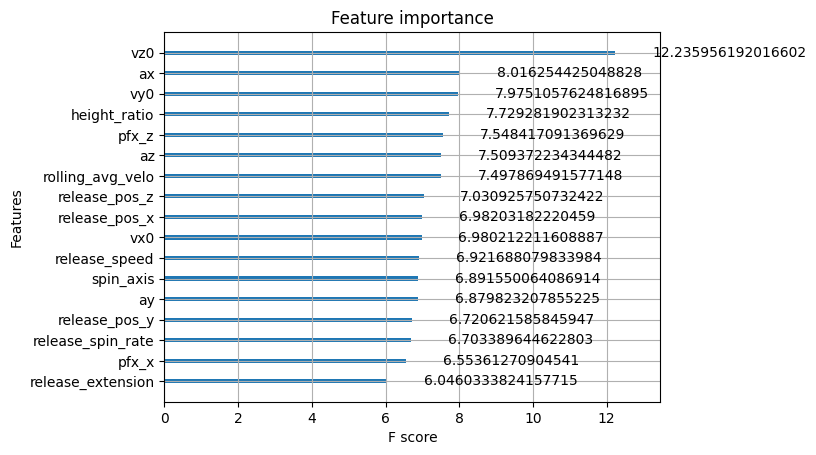

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

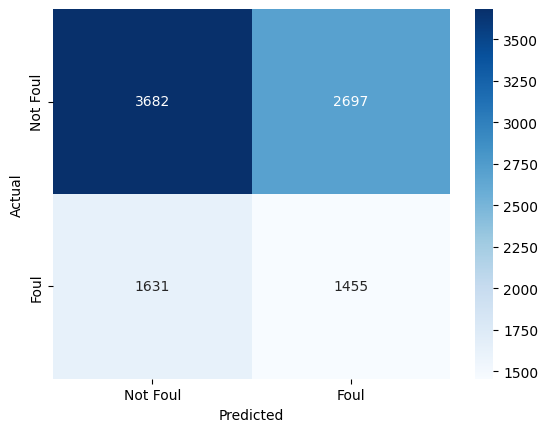

In [21]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xfoul'] = y_pred

In [26]:
testing_identifiers.head()

pitch_id_raw     xfoul
32   661032_608070_623474_4_62_9  0.536701
40   661032_680911_628452_4_64_9  0.517457
157  661032_640458_663776_2_49_7  0.457659
158  661032_676391_663776_2_33_5  0.479145
159  661032_642708_663776_2_19_3  0.408371

In [27]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/foul_2022&3_xfoul.csv")